In [15]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [16]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNETR
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import logging
logging.disable(logging.WARNING)

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [17]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp0su3rml4


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
        
#     ]
# )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-175,
#             a_max=250,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[0],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[1],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[2],
#             prob=0.10,
#         ),
#         RandRotate90d(
#             keys=["image", "label"],
#             prob=0.10,
#             max_k=3,
#         ),
#         RandShiftIntensityd(
#             keys=["image"],
#             offsets=0.10,
#             prob=0.50,
#         ),
#     ]
# )
#训练python脚本中import torch后，加上下面这句。 
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
#DWT_UNETR

In [5]:
#pretrain on word
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=80,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=20, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=20, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|██████████████████████████| 20/20 [00:35<00:00,  1.78s/it]


image shape: torch.Size([1, 276, 214, 280]), label shape: torch.Size([1, 276, 214, 280])


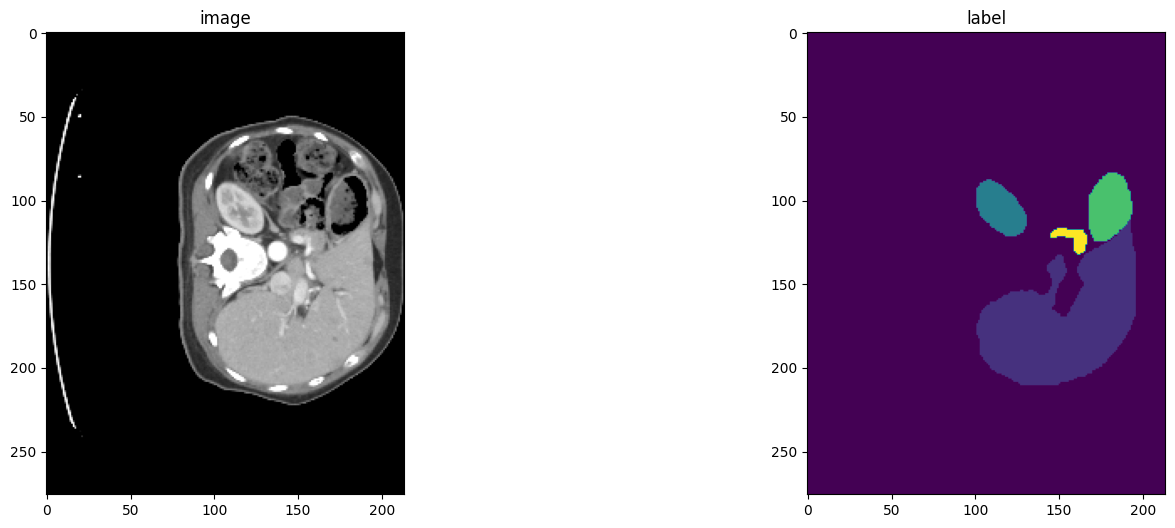

In [6]:
# slice_map = {
#     "img0035.nii.gz": 170,
#     "img0036.nii.gz": 230,
#     "img0037.nii.gz": 204,
#     "img0038.nii.gz": 204,
#     "img0039.nii.gz": 204,
#     "img0040.nii.gz": 180,
# }
slice_map = {
    "word_0125.nii.gz":177,#cant show label
    "word_0126.nii.gz":224,
    "word_0127.nii.gz":206,
    "word_0128.nii.gz":236,
    "word_0130.nii.gz":159,
    "word_0132.nii.gz":168,#
    "word_0133.nii.gz":226,
    "word_0134.nii.gz":205,#
    "word_0135.nii.gz":230,#
    "word_0136.nii.gz":218,
    "word_0138.nii.gz":223,
    "word_0140.nii.gz":223,#
    "word_0142.nii.gz":200,
    "word_0143.nii.gz":217,
    "word_0144.nii.gz":237,
    "word_0145.nii.gz":226,
    "word_0146.nii.gz":161,
    "word_0147.nii.gz":200,
    "word_0148.nii.gz":242,#
    "word_0150.nii.gz":230,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()
#take out 132

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=48,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        gc.collect()
        torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))

Training (79 / 25000 Steps) (loss=2.27351): 100%|█| 80/80 [01:22<00:00,  1.03s/i
Training (159 / 25000 Steps) (loss=2.05286): 100%|█| 80/80 [01:18<00:00,  1.02it
Training (239 / 25000 Steps) (loss=1.77399): 100%|█| 80/80 [01:18<00:00,  1.01it
Training (319 / 25000 Steps) (loss=1.56917): 100%|█| 80/80 [01:18<00:00,  1.02it
Training (399 / 25000 Steps) (loss=1.42037): 100%|█| 80/80 [01:17<00:00,  1.04it
Training (479 / 25000 Steps) (loss=1.36774): 100%|█| 80/80 [01:17<00:00,  1.03it
Training (500 / 25000 Steps) (loss=1.48236):  25%|▎| 20/80 [00:23<00:53,  1.12it
Validate (480 / 10 Steps): 100%|████████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (500 / 25000 Steps) (loss=1.48236):  26%|▎| 21/80 [00:29<02:47,  2.83s/

Model Was Saved ! Current Best Avg. Dice: 0.47715187072753906 Current Avg. Dice: 0.47715187072753906


Training (559 / 25000 Steps) (loss=1.30536): 100%|█| 80/80 [01:23<00:00,  1.04s/
Training (639 / 25000 Steps) (loss=1.27012): 100%|█| 80/80 [01:17<00:00,  1.03it
Training (719 / 25000 Steps) (loss=1.16205): 100%|█| 80/80 [01:17<00:00,  1.04it
Training (799 / 25000 Steps) (loss=1.13474): 100%|█| 80/80 [01:17<00:00,  1.03it
Training (879 / 25000 Steps) (loss=1.61553): 100%|█| 80/80 [01:17<00:00,  1.03it
Training (959 / 25000 Steps) (loss=1.18825): 100%|█| 80/80 [01:18<00:00,  1.03it
Training (1000 / 25000 Steps) (loss=1.11912):  50%|▌| 40/80 [00:41<00:36,  1.11i
Validate (960 / 10 Steps): 100%|████████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (1000 / 25000 Steps) (loss=1.11912):  51%|▌| 41/80 [00:48<01:50,  2.84s

Model Was Saved ! Current Best Avg. Dice: 0.5269279479980469 Current Avg. Dice: 0.5269279479980469


Training (1039 / 25000 Steps) (loss=1.09045): 100%|█| 80/80 [01:24<00:00,  1.06s
Training (1119 / 25000 Steps) (loss=1.02085): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (1199 / 25000 Steps) (loss=1.19640): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1279 / 25000 Steps) (loss=1.29699): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1359 / 25000 Steps) (loss=1.09207): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (1439 / 25000 Steps) (loss=1.17270): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1500 / 25000 Steps) (loss=1.12102):  75%|▊| 60/80 [00:59<00:18,  1.10i
Validate (1440 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (1500 / 25000 Steps) (loss=1.12102):  76%|▊| 61/80 [01:06<00:54,  2.86s

Model Was Saved ! Current Best Avg. Dice: 0.590983510017395 Current Avg. Dice: 0.590983510017395


Training (1519 / 25000 Steps) (loss=0.92399): 100%|█| 80/80 [01:23<00:00,  1.05s
Training (1599 / 25000 Steps) (loss=1.11131): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1679 / 25000 Steps) (loss=0.83076): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (1759 / 25000 Steps) (loss=0.94493): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1839 / 25000 Steps) (loss=0.90317): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1919 / 25000 Steps) (loss=0.95684): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1999 / 25000 Steps) (loss=0.99291): 100%|█| 80/80 [01:17<00:00,  1.03i
Validate (2000 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.33it/s]
Training (2000 / 25000 Steps) (loss=1.00584):   1%| | 1/80 [00:12<15:58, 12.13s/

Model Was Saved ! Current Best Avg. Dice: 0.6274353861808777 Current Avg. Dice: 0.6274353861808777


Training (2079 / 25000 Steps) (loss=0.92937): 100%|█| 80/80 [01:24<00:00,  1.05s
Training (2159 / 25000 Steps) (loss=1.00880): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (2239 / 25000 Steps) (loss=0.80651): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (2319 / 25000 Steps) (loss=0.84323): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (2399 / 25000 Steps) (loss=0.83354): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (2479 / 25000 Steps) (loss=0.91903): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (2500 / 25000 Steps) (loss=0.96329):  25%|▎| 20/80 [00:23<00:54,  1.10i
Validate (2480 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (2500 / 25000 Steps) (loss=0.96329):  26%|▎| 21/80 [00:29<02:39,  2.71s

Model Was Not Saved ! Current Best Avg. Dice: 0.6274353861808777 Current Avg. Dice: 0.6184988617897034


Training (2559 / 25000 Steps) (loss=0.85696): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (2639 / 25000 Steps) (loss=0.85811): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (2719 / 25000 Steps) (loss=0.81030): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (2799 / 25000 Steps) (loss=0.82018): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (2879 / 25000 Steps) (loss=0.99744): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (2959 / 25000 Steps) (loss=0.83172): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3000 / 25000 Steps) (loss=0.87521):  50%|▌| 40/80 [00:41<00:36,  1.10i
Validate (2960 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.38it/s]
Training (3000 / 25000 Steps) (loss=0.87521):  51%|▌| 41/80 [00:47<01:50,  2.84s

Model Was Saved ! Current Best Avg. Dice: 0.6835229992866516 Current Avg. Dice: 0.6835229992866516


Training (3039 / 25000 Steps) (loss=0.82111): 100%|█| 80/80 [01:23<00:00,  1.05s
Training (3119 / 25000 Steps) (loss=0.83483): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (3199 / 25000 Steps) (loss=1.18481): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3279 / 25000 Steps) (loss=0.87611): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3359 / 25000 Steps) (loss=0.79925): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3439 / 25000 Steps) (loss=1.03767): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3500 / 25000 Steps) (loss=0.86689):  75%|▊| 60/80 [00:59<00:17,  1.11i
Validate (3440 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (3500 / 25000 Steps) (loss=0.86689):  76%|▊| 61/80 [01:05<00:51,  2.70s

Model Was Not Saved ! Current Best Avg. Dice: 0.6835229992866516 Current Avg. Dice: 0.6745308041572571


Training (3519 / 25000 Steps) (loss=0.89293): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (3599 / 25000 Steps) (loss=1.16214): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3679 / 25000 Steps) (loss=0.90981): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (3759 / 25000 Steps) (loss=0.78399): 100%|█| 80/80 [01:18<00:00,  1.03i
Training (3839 / 25000 Steps) (loss=0.90410): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3919 / 25000 Steps) (loss=0.75473): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (3999 / 25000 Steps) (loss=0.85426): 100%|█| 80/80 [01:17<00:00,  1.03i
Validate (4000 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (4000 / 25000 Steps) (loss=0.70045):   1%| | 1/80 [00:12<15:58, 12.13s/

Model Was Saved ! Current Best Avg. Dice: 0.7025526165962219 Current Avg. Dice: 0.7025526165962219


Training (4079 / 25000 Steps) (loss=0.76949): 100%|█| 80/80 [01:23<00:00,  1.05s
Training (4159 / 25000 Steps) (loss=1.03576): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (4239 / 25000 Steps) (loss=0.83386): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (4319 / 25000 Steps) (loss=0.86486): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (4399 / 25000 Steps) (loss=0.73737): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (4479 / 25000 Steps) (loss=0.82698): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (4500 / 25000 Steps) (loss=0.59440):  25%|▎| 20/80 [00:23<00:53,  1.13i
Validate (4480 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (4500 / 25000 Steps) (loss=0.59440):  26%|▎| 21/80 [00:29<02:47,  2.83s

Model Was Saved ! Current Best Avg. Dice: 0.7404796481132507 Current Avg. Dice: 0.7404796481132507


Training (4559 / 25000 Steps) (loss=0.92495): 100%|█| 80/80 [01:22<00:00,  1.04s
Training (4639 / 25000 Steps) (loss=0.77222): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (4719 / 25000 Steps) (loss=0.89449): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (4799 / 25000 Steps) (loss=0.79664): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (4879 / 25000 Steps) (loss=0.91795): 100%|█| 80/80 [01:18<00:00,  1.02i
Training (4959 / 25000 Steps) (loss=0.67125): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5000 / 25000 Steps) (loss=0.87256):  50%|▌| 40/80 [00:41<00:35,  1.11i
Validate (4960 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (5000 / 25000 Steps) (loss=0.87256):  51%|▌| 41/80 [00:47<01:45,  2.70s

Model Was Not Saved ! Current Best Avg. Dice: 0.7404796481132507 Current Avg. Dice: 0.7277019023895264


Training (5039 / 25000 Steps) (loss=0.74229): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (5119 / 25000 Steps) (loss=0.80487): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (5199 / 25000 Steps) (loss=0.76849): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (5279 / 25000 Steps) (loss=0.83313): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5359 / 25000 Steps) (loss=0.83263): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5439 / 25000 Steps) (loss=0.69203): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (5500 / 25000 Steps) (loss=0.65189):  75%|▊| 60/80 [00:59<00:18,  1.10i
Validate (5440 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (5500 / 25000 Steps) (loss=0.65189):  76%|▊| 61/80 [01:06<00:54,  2.86s

Model Was Saved ! Current Best Avg. Dice: 0.7460444569587708 Current Avg. Dice: 0.7460444569587708


Training (5519 / 25000 Steps) (loss=0.84634): 100%|█| 80/80 [01:23<00:00,  1.05s
Training (5599 / 25000 Steps) (loss=0.85963): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5679 / 25000 Steps) (loss=0.85217): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5759 / 25000 Steps) (loss=0.80357): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (5839 / 25000 Steps) (loss=0.90646): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (5919 / 25000 Steps) (loss=1.04888): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5999 / 25000 Steps) (loss=0.75404): 100%|█| 80/80 [01:17<00:00,  1.04i
Validate (6000 / 10 Steps): 100%|███████████████| 20/20 [00:06<00:00,  3.25it/s]
Training (6000 / 25000 Steps) (loss=0.79553):   1%| | 1/80 [00:11<15:09, 11.51s/

Model Was Not Saved ! Current Best Avg. Dice: 0.7460444569587708 Current Avg. Dice: 0.6971213221549988


Training (6079 / 25000 Steps) (loss=0.66656): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (6159 / 25000 Steps) (loss=0.87192): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (6239 / 25000 Steps) (loss=0.75367): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (6319 / 25000 Steps) (loss=0.82961): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (6399 / 25000 Steps) (loss=0.98193): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (6479 / 25000 Steps) (loss=0.73924): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (6500 / 25000 Steps) (loss=0.76233):  25%|▎| 20/80 [00:23<00:53,  1.12i
Validate (6480 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (6500 / 25000 Steps) (loss=0.76233):  26%|▎| 21/80 [00:30<02:47,  2.83s

Model Was Saved ! Current Best Avg. Dice: 0.770596981048584 Current Avg. Dice: 0.770596981048584


Training (6559 / 25000 Steps) (loss=0.72582): 100%|█| 80/80 [01:24<00:00,  1.05s
Training (6639 / 25000 Steps) (loss=0.80405): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (6719 / 25000 Steps) (loss=0.84828): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (6799 / 25000 Steps) (loss=0.83717): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (6879 / 25000 Steps) (loss=0.73852): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (6959 / 25000 Steps) (loss=0.99176): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (7000 / 25000 Steps) (loss=0.62639):  50%|▌| 40/80 [00:41<00:35,  1.12i
Validate (6960 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.39it/s]
Training (7000 / 25000 Steps) (loss=0.62639):  51%|▌| 41/80 [00:47<01:49,  2.81s

Model Was Saved ! Current Best Avg. Dice: 0.7743145227432251 Current Avg. Dice: 0.7743145227432251


Training (7039 / 25000 Steps) (loss=0.92403): 100%|█| 80/80 [01:22<00:00,  1.04s
Training (7119 / 25000 Steps) (loss=0.86271): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (7199 / 25000 Steps) (loss=0.78844): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (7279 / 25000 Steps) (loss=0.74239): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (7359 / 25000 Steps) (loss=0.78334): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (7439 / 25000 Steps) (loss=0.53941): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (7500 / 25000 Steps) (loss=0.91508):  75%|▊| 60/80 [00:59<00:17,  1.13i
Validate (7440 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (7500 / 25000 Steps) (loss=0.91508):  76%|▊| 61/80 [01:05<00:53,  2.83s

Model Was Saved ! Current Best Avg. Dice: 0.8007751703262329 Current Avg. Dice: 0.8007751703262329


Training (7519 / 25000 Steps) (loss=0.73207): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (7599 / 25000 Steps) (loss=0.79359): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (7679 / 25000 Steps) (loss=0.79956): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (7759 / 25000 Steps) (loss=0.64876): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (7839 / 25000 Steps) (loss=0.74902): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (7919 / 25000 Steps) (loss=0.86231): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (7999 / 25000 Steps) (loss=0.63346): 100%|█| 80/80 [01:16<00:00,  1.04i
Validate (8000 / 10 Steps): 100%|███████████████| 20/20 [00:06<00:00,  3.32it/s]
Training (8000 / 25000 Steps) (loss=0.64021):   1%| | 1/80 [00:12<15:58, 12.14s/

Model Was Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.8026655316352844


Training (8079 / 25000 Steps) (loss=0.74251): 100%|█| 80/80 [01:23<00:00,  1.05s
Training (8159 / 25000 Steps) (loss=0.48608): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (8239 / 25000 Steps) (loss=0.51046): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (8319 / 25000 Steps) (loss=0.67955): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (8399 / 25000 Steps) (loss=1.03199): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (8479 / 25000 Steps) (loss=0.81718): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (8500 / 25000 Steps) (loss=0.77284):  25%|▎| 20/80 [00:23<00:53,  1.12i
Validate (8480 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (8500 / 25000 Steps) (loss=0.77284):  26%|▎| 21/80 [00:29<02:38,  2.69s

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7971548438072205


Training (8559 / 25000 Steps) (loss=0.71702): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (8639 / 25000 Steps) (loss=0.71202): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (8719 / 25000 Steps) (loss=0.67247): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (8799 / 25000 Steps) (loss=0.87316): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (8879 / 25000 Steps) (loss=0.86377): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (8959 / 25000 Steps) (loss=0.66402): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9000 / 25000 Steps) (loss=0.77732):  50%|▌| 40/80 [00:41<00:36,  1.11i
Validate (8960 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (9000 / 25000 Steps) (loss=0.77732):  51%|▌| 41/80 [00:47<01:44,  2.69s

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7384510040283203


Training (9039 / 25000 Steps) (loss=0.87538): 100%|█| 80/80 [01:22<00:00,  1.03s
Training (9119 / 25000 Steps) (loss=0.67990): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9199 / 25000 Steps) (loss=0.78312): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9279 / 25000 Steps) (loss=1.31976): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9359 / 25000 Steps) (loss=0.74411): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9439 / 25000 Steps) (loss=0.92131): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9500 / 25000 Steps) (loss=0.69972):  75%|▊| 60/80 [00:59<00:18,  1.11i
Validate (9440 / 10 Steps): 100%|███████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (9500 / 25000 Steps) (loss=0.69972):  76%|▊| 61/80 [01:05<00:50,  2.68s

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7517629861831665


Training (9519 / 25000 Steps) (loss=0.71489): 100%|█| 80/80 [01:23<00:00,  1.04s
Training (9599 / 25000 Steps) (loss=0.53958): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9679 / 25000 Steps) (loss=0.79695): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9759 / 25000 Steps) (loss=0.80259): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9839 / 25000 Steps) (loss=0.97562): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9919 / 25000 Steps) (loss=0.63885): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9999 / 25000 Steps) (loss=0.62711): 100%|█| 80/80 [01:17<00:00,  1.03i
Validate (10000 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (10000 / 25000 Steps) (loss=0.81720):   1%| | 1/80 [00:11<15:18, 11.62s

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7827765941619873


Training (10079 / 25000 Steps) (loss=0.65086): 100%|█| 80/80 [01:23<00:00,  1.05
Training (10159 / 25000 Steps) (loss=0.70772): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10239 / 25000 Steps) (loss=0.87147): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10319 / 25000 Steps) (loss=0.81222): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10399 / 25000 Steps) (loss=0.67118): 100%|█| 80/80 [01:17<00:00,  1.04
Training (10479 / 25000 Steps) (loss=0.74541): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10500 / 25000 Steps) (loss=0.48771):  25%|▎| 20/80 [00:23<00:54,  1.11
Validate (10480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (10500 / 25000 Steps) (loss=0.48771):  26%|▎| 21/80 [00:29<02:38,  2.69

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7673914432525635


Training (10559 / 25000 Steps) (loss=0.81569): 100%|█| 80/80 [01:23<00:00,  1.05
Training (10639 / 25000 Steps) (loss=0.76741): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10719 / 25000 Steps) (loss=0.65625): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10799 / 25000 Steps) (loss=0.71309): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10879 / 25000 Steps) (loss=0.78806): 100%|█| 80/80 [01:17<00:00,  1.03
Training (10959 / 25000 Steps) (loss=0.76644): 100%|█| 80/80 [01:17<00:00,  1.04
Training (11000 / 25000 Steps) (loss=0.79887):  50%|▌| 40/80 [00:41<00:36,  1.10
Validate (10960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.38it/s]
Training (11000 / 25000 Steps) (loss=0.79887):  51%|▌| 41/80 [00:47<01:44,  2.69

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7861415147781372


Training (11039 / 25000 Steps) (loss=0.67051): 100%|█| 80/80 [01:23<00:00,  1.04
Training (11119 / 25000 Steps) (loss=0.99837): 100%|█| 80/80 [01:17<00:00,  1.04
Training (11199 / 25000 Steps) (loss=0.81483): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11279 / 25000 Steps) (loss=0.71224): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11359 / 25000 Steps) (loss=0.50242): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11439 / 25000 Steps) (loss=0.85481): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11500 / 25000 Steps) (loss=0.62771):  75%|▊| 60/80 [00:59<00:18,  1.10
Validate (11440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.38it/s]
Training (11500 / 25000 Steps) (loss=0.62771):  76%|▊| 61/80 [01:05<00:50,  2.68

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.8019355535507202


Training (11519 / 25000 Steps) (loss=0.63611): 100%|█| 80/80 [01:23<00:00,  1.04
Training (11599 / 25000 Steps) (loss=0.57368): 100%|█| 80/80 [01:17<00:00,  1.04
Training (11679 / 25000 Steps) (loss=0.83271): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11759 / 25000 Steps) (loss=0.63425): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11839 / 25000 Steps) (loss=0.61402): 100%|█| 80/80 [01:16<00:00,  1.04
Training (11919 / 25000 Steps) (loss=0.63709): 100%|█| 80/80 [01:17<00:00,  1.04
Training (11999 / 25000 Steps) (loss=0.74519): 100%|█| 80/80 [01:17<00:00,  1.04
Validate (12000 / 10 Steps): 100%|██████████████| 20/20 [00:06<00:00,  3.29it/s]
Training (12000 / 25000 Steps) (loss=0.58468):   1%| | 1/80 [00:11<15:08, 11.50s

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7950246930122375


Training (12079 / 25000 Steps) (loss=0.98392): 100%|█| 80/80 [01:23<00:00,  1.04
Training (12159 / 25000 Steps) (loss=0.86260): 100%|█| 80/80 [01:16<00:00,  1.04
Training (12239 / 25000 Steps) (loss=0.71849): 100%|█| 80/80 [01:17<00:00,  1.03
Training (12319 / 25000 Steps) (loss=0.82526): 100%|█| 80/80 [01:17<00:00,  1.04
Training (12399 / 25000 Steps) (loss=0.60347): 100%|█| 80/80 [01:16<00:00,  1.04
Training (12479 / 25000 Steps) (loss=0.82005): 100%|█| 80/80 [01:17<00:00,  1.03
Training (12500 / 25000 Steps) (loss=0.58212):  25%|▎| 20/80 [00:23<00:53,  1.12
Validate (12480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.34it/s]
Training (12500 / 25000 Steps) (loss=0.58212):  26%|▎| 21/80 [00:29<02:39,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7694886326789856


Training (12559 / 25000 Steps) (loss=0.74682): 100%|█| 80/80 [01:23<00:00,  1.04
Training (12639 / 25000 Steps) (loss=0.88579): 100%|█| 80/80 [01:17<00:00,  1.03
Training (12719 / 25000 Steps) (loss=0.91257): 100%|█| 80/80 [01:17<00:00,  1.04
Training (12799 / 25000 Steps) (loss=0.83687): 100%|█| 80/80 [01:17<00:00,  1.04
Training (12879 / 25000 Steps) (loss=0.62615): 100%|█| 80/80 [01:17<00:00,  1.03
Training (12959 / 25000 Steps) (loss=0.61081): 100%|█| 80/80 [01:17<00:00,  1.03
Training (13000 / 25000 Steps) (loss=0.73413):  50%|▌| 40/80 [00:41<00:35,  1.12
Validate (12960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.34it/s]
Training (13000 / 25000 Steps) (loss=0.73413):  51%|▌| 41/80 [00:47<01:45,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7899203300476074


Training (13039 / 25000 Steps) (loss=0.63575): 100%|█| 80/80 [01:22<00:00,  1.03
Training (13119 / 25000 Steps) (loss=0.76855): 100%|█| 80/80 [01:17<00:00,  1.04
Training (13199 / 25000 Steps) (loss=0.75015): 100%|█| 80/80 [01:17<00:00,  1.03
Training (13279 / 25000 Steps) (loss=0.70941): 100%|█| 80/80 [01:16<00:00,  1.04
Training (13359 / 25000 Steps) (loss=0.82859): 100%|█| 80/80 [01:16<00:00,  1.04
Training (13439 / 25000 Steps) (loss=0.63487): 100%|█| 80/80 [01:17<00:00,  1.03
Training (13500 / 25000 Steps) (loss=0.75180):  75%|▊| 60/80 [00:59<00:17,  1.12
Validate (13440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.34it/s]
Training (13500 / 25000 Steps) (loss=0.75180):  76%|▊| 61/80 [01:05<00:51,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7997912168502808


Training (13519 / 25000 Steps) (loss=0.82276): 100%|█| 80/80 [01:23<00:00,  1.04
Training (13599 / 25000 Steps) (loss=0.88975): 100%|█| 80/80 [01:17<00:00,  1.04
Training (13679 / 25000 Steps) (loss=0.76800): 100%|█| 80/80 [01:16<00:00,  1.04
Training (13759 / 25000 Steps) (loss=0.66160): 100%|█| 80/80 [01:17<00:00,  1.04
Training (13839 / 25000 Steps) (loss=0.74639): 100%|█| 80/80 [01:17<00:00,  1.03
Training (13919 / 25000 Steps) (loss=0.64380): 100%|█| 80/80 [01:16<00:00,  1.04
Training (13999 / 25000 Steps) (loss=0.59754): 100%|█| 80/80 [01:17<00:00,  1.03
Validate (14000 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.34it/s]
Training (14000 / 25000 Steps) (loss=0.92682):   1%| | 1/80 [00:11<15:24, 11.70s

Model Was Not Saved ! Current Best Avg. Dice: 0.8026655316352844 Current Avg. Dice: 0.7671634554862976


Training (14079 / 25000 Steps) (loss=0.70610): 100%|█| 80/80 [01:23<00:00,  1.04
Training (14159 / 25000 Steps) (loss=0.78149): 100%|█| 80/80 [01:17<00:00,  1.04
Training (14239 / 25000 Steps) (loss=0.65491): 100%|█| 80/80 [01:17<00:00,  1.03
Training (14319 / 25000 Steps) (loss=0.78758): 100%|█| 80/80 [01:17<00:00,  1.04
Training (14399 / 25000 Steps) (loss=0.64827): 100%|█| 80/80 [01:17<00:00,  1.04
Training (14479 / 25000 Steps) (loss=0.73141): 100%|█| 80/80 [01:17<00:00,  1.03
Training (14500 / 25000 Steps) (loss=0.69162):  25%|▎| 20/80 [00:23<00:54,  1.11
Validate (14480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (14500 / 25000 Steps) (loss=0.69162):  26%|▎| 21/80 [00:30<02:48,  2.85

Model Was Saved ! Current Best Avg. Dice: 0.8117704391479492 Current Avg. Dice: 0.8117704391479492


Training (14559 / 25000 Steps) (loss=0.76696): 100%|█| 80/80 [01:23<00:00,  1.05
Training (14639 / 25000 Steps) (loss=0.80664): 100%|█| 80/80 [01:17<00:00,  1.03
Training (14719 / 25000 Steps) (loss=0.76913): 100%|█| 80/80 [01:17<00:00,  1.04
Training (14799 / 25000 Steps) (loss=0.80686): 100%|█| 80/80 [01:17<00:00,  1.03
Training (14879 / 25000 Steps) (loss=1.06657): 100%|█| 80/80 [01:17<00:00,  1.03
Training (14959 / 25000 Steps) (loss=0.69928): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15000 / 25000 Steps) (loss=0.67226):  50%|▌| 40/80 [00:41<00:36,  1.10
Validate (14960 / 10 Steps): 100%|██████████████| 20/20 [00:06<00:00,  3.32it/s]
Training (15000 / 25000 Steps) (loss=0.67226):  51%|▌| 41/80 [00:48<01:46,  2.72

Model Was Not Saved ! Current Best Avg. Dice: 0.8117704391479492 Current Avg. Dice: 0.7727357149124146


Training (15039 / 25000 Steps) (loss=0.73580): 100%|█| 80/80 [01:23<00:00,  1.05
Training (15119 / 25000 Steps) (loss=0.67577): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15199 / 25000 Steps) (loss=0.85329): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15279 / 25000 Steps) (loss=0.79740): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15359 / 25000 Steps) (loss=0.71416): 100%|█| 80/80 [01:17<00:00,  1.04
Training (15439 / 25000 Steps) (loss=0.66617): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15500 / 25000 Steps) (loss=0.71747):  75%|▊| 60/80 [00:59<00:17,  1.11
Validate (15440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (15500 / 25000 Steps) (loss=0.71747):  76%|▊| 61/80 [01:05<00:51,  2.69

Model Was Not Saved ! Current Best Avg. Dice: 0.8117704391479492 Current Avg. Dice: 0.8037073016166687


Training (15519 / 25000 Steps) (loss=0.55244): 100%|█| 80/80 [01:23<00:00,  1.04
Training (15599 / 25000 Steps) (loss=0.67895): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15679 / 25000 Steps) (loss=0.64358): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15759 / 25000 Steps) (loss=0.73737): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15839 / 25000 Steps) (loss=0.79912): 100%|█| 80/80 [01:17<00:00,  1.04
Training (15919 / 25000 Steps) (loss=0.62168): 100%|█| 80/80 [01:17<00:00,  1.04
Training (15999 / 25000 Steps) (loss=0.94327): 100%|█| 80/80 [01:17<00:00,  1.03
Validate (16000 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (16000 / 25000 Steps) (loss=0.76503):   1%| | 1/80 [00:12<16:16, 12.36s

Model Was Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.8249086141586304


Training (16079 / 25000 Steps) (loss=0.66403): 100%|█| 80/80 [01:24<00:00,  1.06
Training (16159 / 25000 Steps) (loss=0.76678): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16239 / 25000 Steps) (loss=1.04717): 100%|█| 80/80 [01:17<00:00,  1.04
Training (16319 / 25000 Steps) (loss=0.74895): 100%|█| 80/80 [01:17<00:00,  1.04
Training (16399 / 25000 Steps) (loss=0.71915): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16479 / 25000 Steps) (loss=0.45126): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16500 / 25000 Steps) (loss=0.96980):  25%|▎| 20/80 [00:23<00:54,  1.09
Validate (16480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (16500 / 25000 Steps) (loss=0.96980):  26%|▎| 21/80 [00:29<02:39,  2.71

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.8120203018188477


Training (16559 / 25000 Steps) (loss=1.03594): 100%|█| 80/80 [01:23<00:00,  1.04
Training (16639 / 25000 Steps) (loss=0.42770): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16719 / 25000 Steps) (loss=0.64519): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16799 / 25000 Steps) (loss=0.79673): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16879 / 25000 Steps) (loss=0.75139): 100%|█| 80/80 [01:17<00:00,  1.03
Training (16959 / 25000 Steps) (loss=1.03161): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17000 / 25000 Steps) (loss=0.70625):  50%|▌| 40/80 [00:41<00:35,  1.11
Validate (16960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (17000 / 25000 Steps) (loss=0.70625):  51%|▌| 41/80 [00:47<01:44,  2.69

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.794861376285553


Training (17039 / 25000 Steps) (loss=0.75431): 100%|█| 80/80 [01:23<00:00,  1.04
Training (17119 / 25000 Steps) (loss=0.76902): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17199 / 25000 Steps) (loss=0.57066): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17279 / 25000 Steps) (loss=0.70040): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17359 / 25000 Steps) (loss=0.67383): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17439 / 25000 Steps) (loss=0.58269): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17500 / 25000 Steps) (loss=0.77643):  75%|▊| 60/80 [00:59<00:17,  1.12
Validate (17440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.38it/s]
Training (17500 / 25000 Steps) (loss=0.77643):  76%|▊| 61/80 [01:05<00:50,  2.67

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.8011477589607239


Training (17519 / 25000 Steps) (loss=0.83735): 100%|█| 80/80 [01:23<00:00,  1.04
Training (17599 / 25000 Steps) (loss=0.46199): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17679 / 25000 Steps) (loss=0.66729): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17759 / 25000 Steps) (loss=0.61859): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17839 / 25000 Steps) (loss=0.75004): 100%|█| 80/80 [01:17<00:00,  1.03
Training (17919 / 25000 Steps) (loss=0.62342): 100%|█| 80/80 [01:17<00:00,  1.04
Training (17999 / 25000 Steps) (loss=0.61032): 100%|█| 80/80 [01:17<00:00,  1.04
Validate (18000 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (18000 / 25000 Steps) (loss=0.63636):   1%| | 1/80 [00:11<15:33, 11.82s

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.801520824432373


Training (18079 / 25000 Steps) (loss=0.78449): 100%|█| 80/80 [01:23<00:00,  1.05
Training (18159 / 25000 Steps) (loss=0.64482): 100%|█| 80/80 [01:17<00:00,  1.04
Training (18239 / 25000 Steps) (loss=0.75636): 100%|█| 80/80 [01:17<00:00,  1.03
Training (18319 / 25000 Steps) (loss=0.82514): 100%|█| 80/80 [01:17<00:00,  1.03
Training (18399 / 25000 Steps) (loss=0.59039): 100%|█| 80/80 [01:17<00:00,  1.04
Training (18479 / 25000 Steps) (loss=0.79652): 100%|█| 80/80 [01:16<00:00,  1.04
Training (18500 / 25000 Steps) (loss=0.44047):  25%|▎| 20/80 [00:23<00:53,  1.12
Validate (18480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (18500 / 25000 Steps) (loss=0.44047):  26%|▎| 21/80 [00:29<02:39,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.8186140060424805


Training (18559 / 25000 Steps) (loss=0.69029): 100%|█| 80/80 [01:23<00:00,  1.04
Training (18639 / 25000 Steps) (loss=0.74019): 100%|█| 80/80 [01:17<00:00,  1.03
Training (18719 / 25000 Steps) (loss=0.85622): 100%|█| 80/80 [01:17<00:00,  1.04
Training (18799 / 25000 Steps) (loss=0.76027): 100%|█| 80/80 [01:17<00:00,  1.04
Training (18879 / 25000 Steps) (loss=0.64588): 100%|█| 80/80 [01:16<00:00,  1.04
Training (18959 / 25000 Steps) (loss=0.51399): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19000 / 25000 Steps) (loss=0.55716):  50%|▌| 40/80 [00:41<00:36,  1.11
Validate (18960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (19000 / 25000 Steps) (loss=0.55716):  51%|▌| 41/80 [00:47<01:45,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.7833199501037598


Training (19039 / 25000 Steps) (loss=0.68376): 100%|█| 80/80 [01:23<00:00,  1.04
Training (19119 / 25000 Steps) (loss=0.76582): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19199 / 25000 Steps) (loss=0.90468): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19279 / 25000 Steps) (loss=0.61047): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19359 / 25000 Steps) (loss=0.59581): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19439 / 25000 Steps) (loss=0.65449): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19500 / 25000 Steps) (loss=0.52675):  75%|▊| 60/80 [00:59<00:18,  1.11
Validate (19440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (19500 / 25000 Steps) (loss=0.52675):  76%|▊| 61/80 [01:05<00:51,  2.69

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.8125629425048828


Training (19519 / 25000 Steps) (loss=0.73129): 100%|█| 80/80 [01:23<00:00,  1.04
Training (19599 / 25000 Steps) (loss=0.69969): 100%|█| 80/80 [01:17<00:00,  1.04
Training (19679 / 25000 Steps) (loss=0.52475): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19759 / 25000 Steps) (loss=0.73460): 100%|█| 80/80 [01:17<00:00,  1.04
Training (19839 / 25000 Steps) (loss=0.75700): 100%|█| 80/80 [01:17<00:00,  1.03
Training (19919 / 25000 Steps) (loss=0.63705): 100%|█| 80/80 [01:17<00:00,  1.04
Training (19999 / 25000 Steps) (loss=0.65271): 100%|█| 80/80 [01:16<00:00,  1.04
Validate (20000 / 10 Steps): 100%|██████████████| 20/20 [00:06<00:00,  3.29it/s]
Training (20000 / 25000 Steps) (loss=0.72838):   1%| | 1/80 [00:11<15:06, 11.47s

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.818916916847229


Training (20079 / 25000 Steps) (loss=0.75992): 100%|█| 80/80 [01:22<00:00,  1.04
Training (20159 / 25000 Steps) (loss=0.67397): 100%|█| 80/80 [01:17<00:00,  1.04
Training (20239 / 25000 Steps) (loss=0.43244): 100%|█| 80/80 [01:17<00:00,  1.04
Training (20319 / 25000 Steps) (loss=0.67536): 100%|█| 80/80 [01:17<00:00,  1.03
Training (20399 / 25000 Steps) (loss=0.66667): 100%|█| 80/80 [01:17<00:00,  1.03
Training (20479 / 25000 Steps) (loss=0.68359): 100%|█| 80/80 [01:17<00:00,  1.03
Training (20500 / 25000 Steps) (loss=0.59848):  25%|▎| 20/80 [00:23<00:54,  1.11
Validate (20480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (20500 / 25000 Steps) (loss=0.59848):  26%|▎| 21/80 [00:29<02:39,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8249086141586304 Current Avg. Dice: 0.7775468826293945


Training (20559 / 25000 Steps) (loss=0.65208): 100%|█| 80/80 [01:23<00:00,  1.04
Training (20639 / 25000 Steps) (loss=0.68033): 100%|█| 80/80 [01:17<00:00,  1.03
Training (20719 / 25000 Steps) (loss=0.50955): 100%|█| 80/80 [01:17<00:00,  1.03
Training (20799 / 25000 Steps) (loss=0.55172): 100%|█| 80/80 [01:17<00:00,  1.04
Training (20879 / 25000 Steps) (loss=0.76794): 100%|█| 80/80 [01:17<00:00,  1.03
Training (20959 / 25000 Steps) (loss=0.79786): 100%|█| 80/80 [01:17<00:00,  1.04
Training (21000 / 25000 Steps) (loss=0.72638):  50%|▌| 40/80 [00:41<00:36,  1.10
Validate (20960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (21000 / 25000 Steps) (loss=0.72638):  51%|▌| 41/80 [00:48<01:51,  2.86

Model Was Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8385211229324341


Training (21039 / 25000 Steps) (loss=0.58476): 100%|█| 80/80 [01:23<00:00,  1.05
Training (21119 / 25000 Steps) (loss=0.92654): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21199 / 25000 Steps) (loss=0.75922): 100%|█| 80/80 [01:17<00:00,  1.04
Training (21279 / 25000 Steps) (loss=0.55204): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21359 / 25000 Steps) (loss=0.72622): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21439 / 25000 Steps) (loss=0.73923): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21500 / 25000 Steps) (loss=0.86829):  75%|▊| 60/80 [00:59<00:18,  1.11
Validate (21440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (21500 / 25000 Steps) (loss=0.86829):  76%|▊| 61/80 [01:05<00:51,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8102605938911438


Training (21519 / 25000 Steps) (loss=0.89145): 100%|█| 80/80 [01:23<00:00,  1.04
Training (21599 / 25000 Steps) (loss=0.71628): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21679 / 25000 Steps) (loss=0.72094): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21759 / 25000 Steps) (loss=0.50930): 100%|█| 80/80 [01:17<00:00,  1.04
Training (21839 / 25000 Steps) (loss=0.67906): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21919 / 25000 Steps) (loss=0.73075): 100%|█| 80/80 [01:17<00:00,  1.03
Training (21999 / 25000 Steps) (loss=0.69263): 100%|█| 80/80 [01:17<00:00,  1.04
Validate (22000 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (22000 / 25000 Steps) (loss=0.71949):   1%| | 1/80 [00:11<15:36, 11.85s

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8169509768486023


Training (22079 / 25000 Steps) (loss=0.82251): 100%|█| 80/80 [01:23<00:00,  1.04
Training (22159 / 25000 Steps) (loss=0.58432): 100%|█| 80/80 [01:16<00:00,  1.04
Training (22239 / 25000 Steps) (loss=0.77634): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22319 / 25000 Steps) (loss=0.84504): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22399 / 25000 Steps) (loss=0.76092): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22479 / 25000 Steps) (loss=0.55876): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22500 / 25000 Steps) (loss=0.69532):  25%|▎| 20/80 [00:23<00:54,  1.10
Validate (22480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.36it/s]
Training (22500 / 25000 Steps) (loss=0.69532):  26%|▎| 21/80 [00:29<02:39,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8086620569229126


Training (22559 / 25000 Steps) (loss=0.82954): 100%|█| 80/80 [01:23<00:00,  1.04
Training (22639 / 25000 Steps) (loss=0.66308): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22719 / 25000 Steps) (loss=0.64700): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22799 / 25000 Steps) (loss=0.64062): 100%|█| 80/80 [01:17<00:00,  1.03
Training (22879 / 25000 Steps) (loss=0.70242): 100%|█| 80/80 [01:17<00:00,  1.04
Training (22959 / 25000 Steps) (loss=0.67688): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23000 / 25000 Steps) (loss=0.62933):  50%|▌| 40/80 [00:41<00:36,  1.10
Validate (22960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (23000 / 25000 Steps) (loss=0.62933):  51%|▌| 41/80 [00:47<01:45,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8048156499862671


Training (23039 / 25000 Steps) (loss=0.77386): 100%|█| 80/80 [01:23<00:00,  1.04
Training (23119 / 25000 Steps) (loss=0.72197): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23199 / 25000 Steps) (loss=0.81322): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23279 / 25000 Steps) (loss=0.63147): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23359 / 25000 Steps) (loss=0.54519): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23439 / 25000 Steps) (loss=0.87506): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23500 / 25000 Steps) (loss=0.65946):  75%|▊| 60/80 [00:59<00:18,  1.11
Validate (23440 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (23500 / 25000 Steps) (loss=0.65946):  76%|▊| 61/80 [01:05<00:51,  2.71

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8191266059875488


Training (23519 / 25000 Steps) (loss=0.71382): 100%|█| 80/80 [01:23<00:00,  1.04
Training (23599 / 25000 Steps) (loss=0.58952): 100%|█| 80/80 [01:17<00:00,  1.04
Training (23679 / 25000 Steps) (loss=0.82776): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23759 / 25000 Steps) (loss=0.81469): 100%|█| 80/80 [01:17<00:00,  1.03
Training (23839 / 25000 Steps) (loss=0.69816): 100%|█| 80/80 [01:17<00:00,  1.04
Training (23919 / 25000 Steps) (loss=0.70047): 100%|█| 80/80 [01:17<00:00,  1.04
Training (23999 / 25000 Steps) (loss=0.83931): 100%|█| 80/80 [01:17<00:00,  1.03
Validate (24000 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.35it/s]
Training (24000 / 25000 Steps) (loss=0.72765):   1%| | 1/80 [00:11<15:31, 11.80s

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8310697674751282


Training (24079 / 25000 Steps) (loss=0.47478): 100%|█| 80/80 [01:23<00:00,  1.05
Training (24159 / 25000 Steps) (loss=0.80691): 100%|█| 80/80 [01:16<00:00,  1.04
Training (24239 / 25000 Steps) (loss=0.71489): 100%|█| 80/80 [01:17<00:00,  1.04
Training (24319 / 25000 Steps) (loss=0.78259): 100%|█| 80/80 [01:17<00:00,  1.04
Training (24399 / 25000 Steps) (loss=0.58008): 100%|█| 80/80 [01:17<00:00,  1.04
Training (24479 / 25000 Steps) (loss=0.75627): 100%|█| 80/80 [01:17<00:00,  1.04
Training (24500 / 25000 Steps) (loss=0.62677):  25%|▎| 20/80 [00:23<00:54,  1.11
Validate (24480 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (24500 / 25000 Steps) (loss=0.62677):  26%|▎| 21/80 [00:29<02:39,  2.70

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8164917230606079


Training (24559 / 25000 Steps) (loss=0.55934): 100%|█| 80/80 [01:23<00:00,  1.04
Training (24639 / 25000 Steps) (loss=0.62802): 100%|█| 80/80 [01:17<00:00,  1.04
Training (24719 / 25000 Steps) (loss=0.68699): 100%|█| 80/80 [01:16<00:00,  1.04
Training (24799 / 25000 Steps) (loss=0.64143): 100%|█| 80/80 [01:16<00:00,  1.04
Training (24879 / 25000 Steps) (loss=0.50748): 100%|█| 80/80 [01:17<00:00,  1.03
Training (24959 / 25000 Steps) (loss=0.74968): 100%|█| 80/80 [01:17<00:00,  1.03
Training (25000 / 25000 Steps) (loss=0.53455):  50%|▌| 40/80 [00:41<00:35,  1.11
Validate (24960 / 10 Steps): 100%|██████████████| 20/20 [00:05<00:00,  3.37it/s]
Training (25000 / 25000 Steps) (loss=0.53455):  51%|▌| 41/80 [00:47<01:44,  2.69

Model Was Not Saved ! Current Best Avg. Dice: 0.8385211229324341 Current Avg. Dice: 0.8365252614021301


Training (25039 / 25000 Steps) (loss=0.43401): 100%|█| 80/80 [01:23<00:00,  1.04


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8385 at iteration: 21000


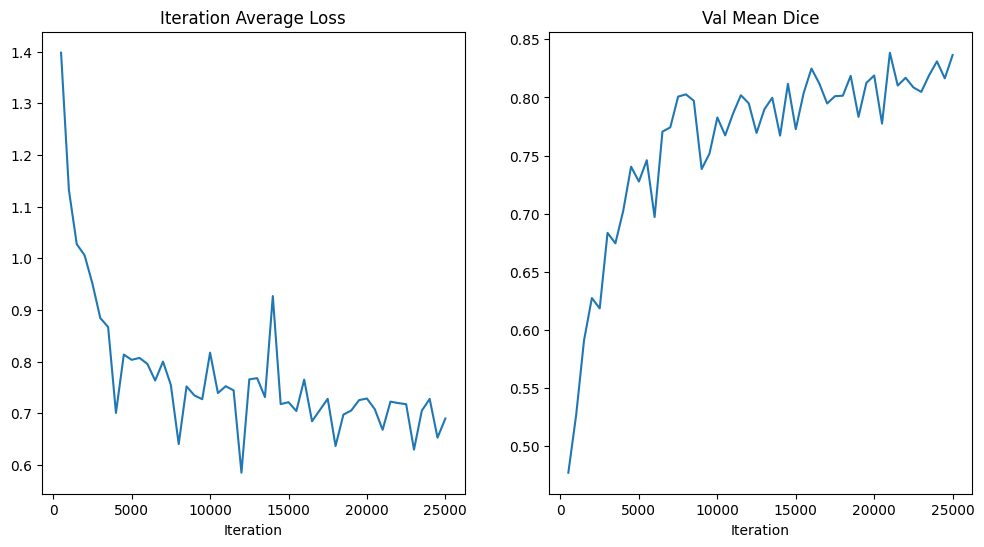

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

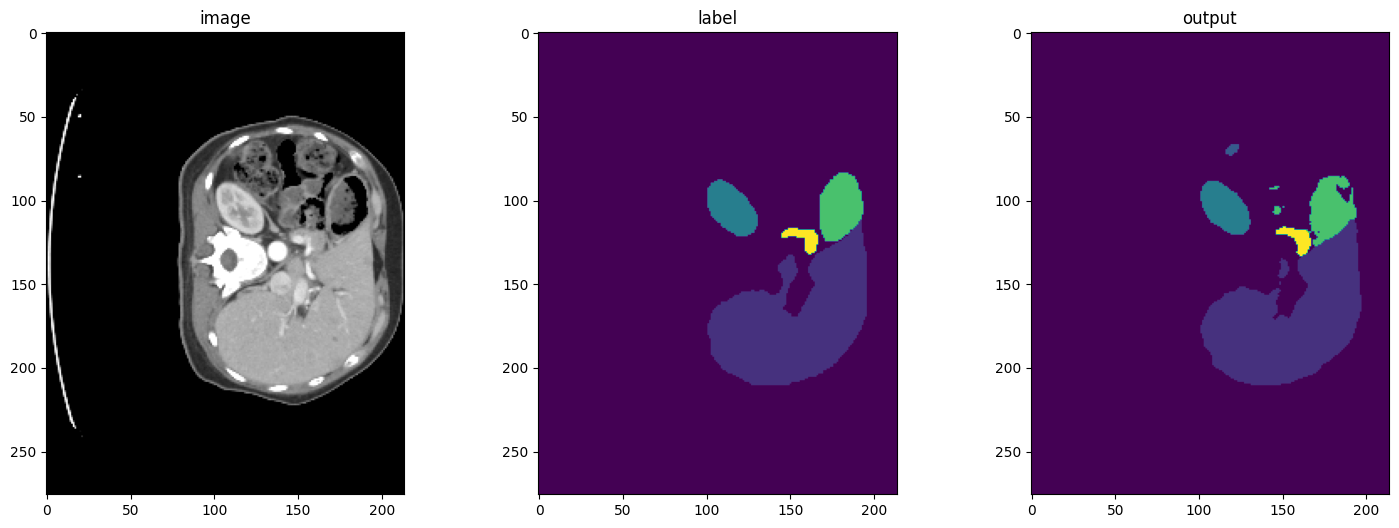

In [12]:
case_num = 1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwt_swinunetr_pretrainonword_best_metric_model2.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [5]:
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=20, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=48,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        gc.collect()
        torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.66892): 100%|█| 24/24 [00:27<00:00,  1.15s/i
Training (47 / 25000 Steps) (loss=0.85540): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (71 / 25000 Steps) (loss=0.76590): 100%|█| 24/24 [00:23<00:00,  1.01it/
Training (95 / 25000 Steps) (loss=0.94269): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (119 / 25000 Steps) (loss=0.84659): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (143 / 25000 Steps) (loss=0.88323): 100%|█| 24/24 [00:23<00:00,  1.02it
Training (167 / 25000 Steps) (loss=0.73648): 100%|█| 24/24 [00:23<00:00,  1.02it
Training (191 / 25000 Steps) (loss=1.75273): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (215 / 25000 Steps) (loss=0.97284): 100%|█| 24/24 [00:23<00:00,  1.02it
Training (239 / 25000 Steps) (loss=1.69812): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (263 / 25000 Steps) (loss=0.75274): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (287 / 25000 Steps) (loss=1.16401): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7858436703681946 Current Avg. Dice: 0.7858436703681946


Training (503 / 25000 Steps) (loss=1.27921): 100%|█| 24/24 [00:26<00:00,  1.09s/
Training (527 / 25000 Steps) (loss=0.86100): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (551 / 25000 Steps) (loss=0.94421): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (575 / 25000 Steps) (loss=0.91530): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (599 / 25000 Steps) (loss=0.76706): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (623 / 25000 Steps) (loss=0.90801): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (647 / 25000 Steps) (loss=0.89239): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (671 / 25000 Steps) (loss=1.28925): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (695 / 25000 Steps) (loss=0.89031): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (719 / 25000 Steps) (loss=0.88652): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (743 / 25000 Steps) (loss=1.01043): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (767 / 25000 Steps) (loss=0.91881): 100%|█| 24/24 [00:24<00:00,  1.00s/
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7858436703681946 Current Avg. Dice: 0.7663955688476562


Training (1007 / 25000 Steps) (loss=0.77533): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (1031 / 25000 Steps) (loss=0.96671): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1055 / 25000 Steps) (loss=0.88752): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1079 / 25000 Steps) (loss=1.08175): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1103 / 25000 Steps) (loss=0.92164): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (1127 / 25000 Steps) (loss=0.78126): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1151 / 25000 Steps) (loss=1.09975): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (1175 / 25000 Steps) (loss=0.91584): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1199 / 25000 Steps) (loss=0.92759): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1223 / 25000 Steps) (loss=0.78683): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1247 / 25000 Steps) (loss=0.95718): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1271 / 25000 Steps) (loss=0.91978): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7921090126037598


Training (1511 / 25000 Steps) (loss=0.82843): 100%|█| 24/24 [00:26<00:00,  1.10s
Training (1535 / 25000 Steps) (loss=0.75741): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1559 / 25000 Steps) (loss=0.79298): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1583 / 25000 Steps) (loss=0.96706): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1607 / 25000 Steps) (loss=1.32732): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1631 / 25000 Steps) (loss=0.91726): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1655 / 25000 Steps) (loss=0.96303): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1679 / 25000 Steps) (loss=0.98820): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1703 / 25000 Steps) (loss=0.60072): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1727 / 25000 Steps) (loss=0.78416): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1751 / 25000 Steps) (loss=1.10267): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1775 / 25000 Steps) (loss=0.88140): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7456414103507996


Training (2015 / 25000 Steps) (loss=0.75198): 100%|█| 24/24 [00:25<00:00,  1.06s
Training (2039 / 25000 Steps) (loss=0.86145): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2063 / 25000 Steps) (loss=0.87704): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2087 / 25000 Steps) (loss=0.84909): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (2111 / 25000 Steps) (loss=0.68190): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (2135 / 25000 Steps) (loss=0.89548): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (2159 / 25000 Steps) (loss=1.06644): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2183 / 25000 Steps) (loss=0.81858): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2207 / 25000 Steps) (loss=0.83929): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2231 / 25000 Steps) (loss=1.13827): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (2255 / 25000 Steps) (loss=1.11297): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2279 / 25000 Steps) (loss=0.81367): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7596457600593567


Training (2519 / 25000 Steps) (loss=0.77907): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (2543 / 25000 Steps) (loss=0.82774): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2567 / 25000 Steps) (loss=1.11235): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2591 / 25000 Steps) (loss=0.81069): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (2615 / 25000 Steps) (loss=0.96865): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2639 / 25000 Steps) (loss=1.05307): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (2663 / 25000 Steps) (loss=0.62207): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2687 / 25000 Steps) (loss=0.77332): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2711 / 25000 Steps) (loss=0.80806): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2735 / 25000 Steps) (loss=1.15651): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2759 / 25000 Steps) (loss=1.24377): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2783 / 25000 Steps) (loss=0.86430): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7728745341300964


Training (3023 / 25000 Steps) (loss=1.17107): 100%|█| 24/24 [00:25<00:00,  1.06s
Training (3047 / 25000 Steps) (loss=1.00986): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3071 / 25000 Steps) (loss=0.65053): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3095 / 25000 Steps) (loss=0.94567): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3119 / 25000 Steps) (loss=0.97173): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3143 / 25000 Steps) (loss=0.72947): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3167 / 25000 Steps) (loss=0.89847): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3191 / 25000 Steps) (loss=0.84322): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3215 / 25000 Steps) (loss=1.06690): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3239 / 25000 Steps) (loss=0.97675): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3263 / 25000 Steps) (loss=0.99333): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3287 / 25000 Steps) (loss=0.99761): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7697413563728333


Training (3503 / 25000 Steps) (loss=0.89630): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (3527 / 25000 Steps) (loss=0.81079): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3551 / 25000 Steps) (loss=1.24980): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3575 / 25000 Steps) (loss=0.81882): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (3599 / 25000 Steps) (loss=1.61429): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3623 / 25000 Steps) (loss=0.51520): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3647 / 25000 Steps) (loss=0.91138): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3671 / 25000 Steps) (loss=1.11304): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3695 / 25000 Steps) (loss=1.09361): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3719 / 25000 Steps) (loss=1.40549): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3743 / 25000 Steps) (loss=0.87808): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3767 / 25000 Steps) (loss=0.86403): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7377238869667053


Training (4007 / 25000 Steps) (loss=0.96014): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (4031 / 25000 Steps) (loss=0.89127): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4055 / 25000 Steps) (loss=1.01948): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4079 / 25000 Steps) (loss=0.88106): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4103 / 25000 Steps) (loss=0.76765): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4127 / 25000 Steps) (loss=0.69924): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (4151 / 25000 Steps) (loss=0.72676): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4175 / 25000 Steps) (loss=0.65307): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (4199 / 25000 Steps) (loss=1.12807): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4223 / 25000 Steps) (loss=0.79706): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (4247 / 25000 Steps) (loss=1.59472): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4271 / 25000 Steps) (loss=1.80535): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7499077916145325


Training (4511 / 25000 Steps) (loss=0.57932): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (4535 / 25000 Steps) (loss=0.90846): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (4559 / 25000 Steps) (loss=1.02415): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4583 / 25000 Steps) (loss=0.89336): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4607 / 25000 Steps) (loss=0.76656): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4631 / 25000 Steps) (loss=0.80179): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (4655 / 25000 Steps) (loss=1.01311): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (4679 / 25000 Steps) (loss=1.30340): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4703 / 25000 Steps) (loss=0.77027): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4727 / 25000 Steps) (loss=0.61682): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4751 / 25000 Steps) (loss=1.19655): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4775 / 25000 Steps) (loss=1.06539): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7921090126037598 Current Avg. Dice: 0.7271761894226074


Training (5015 / 25000 Steps) (loss=0.84457): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (5039 / 25000 Steps) (loss=0.86059): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5063 / 25000 Steps) (loss=0.83497): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5087 / 25000 Steps) (loss=0.96933): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5111 / 25000 Steps) (loss=0.69166): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5135 / 25000 Steps) (loss=0.90543): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (5159 / 25000 Steps) (loss=0.88589): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5183 / 25000 Steps) (loss=0.78840): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5207 / 25000 Steps) (loss=0.87544): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5231 / 25000 Steps) (loss=0.90085): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (5255 / 25000 Steps) (loss=0.75737): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5279 / 25000 Steps) (loss=0.80307): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.793678343296051 Current Avg. Dice: 0.793678343296051


Training (5519 / 25000 Steps) (loss=0.82235): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (5543 / 25000 Steps) (loss=1.01859): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (5567 / 25000 Steps) (loss=0.77549): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5591 / 25000 Steps) (loss=0.77280): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (5615 / 25000 Steps) (loss=0.81245): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (5639 / 25000 Steps) (loss=0.84265): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5663 / 25000 Steps) (loss=0.90672): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5687 / 25000 Steps) (loss=1.00206): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5711 / 25000 Steps) (loss=0.76840): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5735 / 25000 Steps) (loss=0.77286): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5759 / 25000 Steps) (loss=0.86257): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5783 / 25000 Steps) (loss=0.80124): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.793678343296051 Current Avg. Dice: 0.7837812900543213


Training (6023 / 25000 Steps) (loss=0.90980): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (6047 / 25000 Steps) (loss=0.85156): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6071 / 25000 Steps) (loss=0.78199): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6095 / 25000 Steps) (loss=0.84586): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6119 / 25000 Steps) (loss=1.08841): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6143 / 25000 Steps) (loss=0.74036): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6167 / 25000 Steps) (loss=0.82312): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6191 / 25000 Steps) (loss=0.90868): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6215 / 25000 Steps) (loss=0.93333): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (6239 / 25000 Steps) (loss=0.75374): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6263 / 25000 Steps) (loss=2.42959): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6287 / 25000 Steps) (loss=0.84322): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.8394066691398621


Training (6503 / 25000 Steps) (loss=0.79668): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (6527 / 25000 Steps) (loss=0.88793): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (6551 / 25000 Steps) (loss=0.89502): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (6575 / 25000 Steps) (loss=1.07878): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6599 / 25000 Steps) (loss=0.93972): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6623 / 25000 Steps) (loss=0.82275): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6647 / 25000 Steps) (loss=0.83946): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (6671 / 25000 Steps) (loss=0.92161): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6695 / 25000 Steps) (loss=0.92084): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (6719 / 25000 Steps) (loss=0.65084): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6743 / 25000 Steps) (loss=1.03745): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (6767 / 25000 Steps) (loss=0.88064): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7613081932067871


Training (7007 / 25000 Steps) (loss=1.21692): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (7031 / 25000 Steps) (loss=0.95243): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7055 / 25000 Steps) (loss=0.92353): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7079 / 25000 Steps) (loss=0.73091): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7103 / 25000 Steps) (loss=1.45809): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7127 / 25000 Steps) (loss=0.96056): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7151 / 25000 Steps) (loss=0.97434): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7175 / 25000 Steps) (loss=1.27674): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (7199 / 25000 Steps) (loss=0.99533): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7223 / 25000 Steps) (loss=0.87620): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (7247 / 25000 Steps) (loss=0.84624): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7271 / 25000 Steps) (loss=0.77813): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7760975360870361


Training (7511 / 25000 Steps) (loss=0.78765): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (7535 / 25000 Steps) (loss=0.65108): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (7559 / 25000 Steps) (loss=0.75761): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7583 / 25000 Steps) (loss=1.54255): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (7607 / 25000 Steps) (loss=0.91385): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7631 / 25000 Steps) (loss=0.75326): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7655 / 25000 Steps) (loss=0.95055): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7679 / 25000 Steps) (loss=0.89080): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7703 / 25000 Steps) (loss=0.73991): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7727 / 25000 Steps) (loss=1.01796): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (7751 / 25000 Steps) (loss=0.86078): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7775 / 25000 Steps) (loss=0.97685): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7878387570381165


Training (8015 / 25000 Steps) (loss=0.86931): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (8039 / 25000 Steps) (loss=0.81447): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8063 / 25000 Steps) (loss=0.84838): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8087 / 25000 Steps) (loss=0.78176): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (8111 / 25000 Steps) (loss=1.19098): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8135 / 25000 Steps) (loss=1.02335): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8159 / 25000 Steps) (loss=0.98149): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8183 / 25000 Steps) (loss=2.26983): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8207 / 25000 Steps) (loss=1.04642): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8231 / 25000 Steps) (loss=0.70314): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8255 / 25000 Steps) (loss=0.85752): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8279 / 25000 Steps) (loss=0.64183): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7872083783149719


Training (8519 / 25000 Steps) (loss=1.02597): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (8543 / 25000 Steps) (loss=0.79416): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8567 / 25000 Steps) (loss=0.77061): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8591 / 25000 Steps) (loss=0.81529): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8615 / 25000 Steps) (loss=1.15880): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8639 / 25000 Steps) (loss=0.92892): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8663 / 25000 Steps) (loss=1.49183): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8687 / 25000 Steps) (loss=0.97683): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8711 / 25000 Steps) (loss=0.82800): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8735 / 25000 Steps) (loss=0.76669): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8759 / 25000 Steps) (loss=0.98297): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (8783 / 25000 Steps) (loss=0.76359): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7738215327262878


Training (9023 / 25000 Steps) (loss=1.00837): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (9047 / 25000 Steps) (loss=0.79576): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9071 / 25000 Steps) (loss=0.84382): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9095 / 25000 Steps) (loss=1.29245): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9119 / 25000 Steps) (loss=0.88392): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9143 / 25000 Steps) (loss=0.89710): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9167 / 25000 Steps) (loss=0.90605): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9191 / 25000 Steps) (loss=0.96662): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9215 / 25000 Steps) (loss=0.89368): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9239 / 25000 Steps) (loss=0.86052): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9263 / 25000 Steps) (loss=0.65392): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9287 / 25000 Steps) (loss=1.01727): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.6833913922309875


Training (9503 / 25000 Steps) (loss=1.34515): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (9527 / 25000 Steps) (loss=0.94514): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9551 / 25000 Steps) (loss=0.86824): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9575 / 25000 Steps) (loss=0.77251): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9599 / 25000 Steps) (loss=0.97299): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9623 / 25000 Steps) (loss=0.88784): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9647 / 25000 Steps) (loss=0.74976): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9671 / 25000 Steps) (loss=1.00472): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9695 / 25000 Steps) (loss=0.66837): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9719 / 25000 Steps) (loss=0.66864): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9743 / 25000 Steps) (loss=0.90323): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (9767 / 25000 Steps) (loss=0.69546): 100%|█| 24/24 [00:23<00:00,  1.02i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7622838020324707


Training (10007 / 25000 Steps) (loss=0.89086): 100%|█| 24/24 [00:25<00:00,  1.08
Training (10031 / 25000 Steps) (loss=0.89666): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10055 / 25000 Steps) (loss=1.06733): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10079 / 25000 Steps) (loss=0.70182): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10103 / 25000 Steps) (loss=0.80237): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10127 / 25000 Steps) (loss=0.92017): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10151 / 25000 Steps) (loss=0.93211): 100%|█| 24/24 [00:23<00:00,  1.02
Training (10175 / 25000 Steps) (loss=0.86726): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10199 / 25000 Steps) (loss=0.85241): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10223 / 25000 Steps) (loss=0.87543): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10247 / 25000 Steps) (loss=0.99157): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10271 / 25000 Steps) (loss=0.80946): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7882914543151855


Training (10511 / 25000 Steps) (loss=0.91715): 100%|█| 24/24 [00:25<00:00,  1.07
Training (10535 / 25000 Steps) (loss=1.42400): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10559 / 25000 Steps) (loss=1.64933): 100%|█| 24/24 [00:23<00:00,  1.02
Training (10583 / 25000 Steps) (loss=0.81190): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10607 / 25000 Steps) (loss=0.99186): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10631 / 25000 Steps) (loss=0.66873): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10655 / 25000 Steps) (loss=0.73943): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10679 / 25000 Steps) (loss=1.13177): 100%|█| 24/24 [00:23<00:00,  1.02
Training (10703 / 25000 Steps) (loss=0.98603): 100%|█| 24/24 [00:23<00:00,  1.01
Training (10727 / 25000 Steps) (loss=1.20190): 100%|█| 24/24 [00:23<00:00,  1.02
Training (10751 / 25000 Steps) (loss=0.95222): 100%|█| 24/24 [00:23<00:00,  1.02
Training (10775 / 25000 Steps) (loss=0.85349): 100%|█| 24/24 [00:23<00:00,  1.02
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7353598475456238


Training (11015 / 25000 Steps) (loss=0.83691): 100%|█| 24/24 [00:25<00:00,  1.07
Training (11039 / 25000 Steps) (loss=0.95204): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11063 / 25000 Steps) (loss=0.59929): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11087 / 25000 Steps) (loss=0.88489): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11111 / 25000 Steps) (loss=0.77603): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11135 / 25000 Steps) (loss=0.82984): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11159 / 25000 Steps) (loss=0.83075): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11183 / 25000 Steps) (loss=1.05941): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11207 / 25000 Steps) (loss=0.85622): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11231 / 25000 Steps) (loss=0.93127): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11255 / 25000 Steps) (loss=0.83902): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11279 / 25000 Steps) (loss=0.80528): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7491626739501953


Training (11519 / 25000 Steps) (loss=0.90772): 100%|█| 24/24 [00:25<00:00,  1.07
Training (11543 / 25000 Steps) (loss=0.84406): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11567 / 25000 Steps) (loss=0.81083): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11591 / 25000 Steps) (loss=0.90350): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11615 / 25000 Steps) (loss=0.76162): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11639 / 25000 Steps) (loss=1.16368): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11663 / 25000 Steps) (loss=0.85417): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11687 / 25000 Steps) (loss=0.96278): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11711 / 25000 Steps) (loss=0.80710): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11735 / 25000 Steps) (loss=0.73716): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11759 / 25000 Steps) (loss=0.94965): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11783 / 25000 Steps) (loss=0.87170): 100%|█| 24/24 [00:23<00:00,  1.02
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7889352440834045


Training (12023 / 25000 Steps) (loss=0.73968): 100%|█| 24/24 [00:25<00:00,  1.07
Training (12047 / 25000 Steps) (loss=1.12262): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12071 / 25000 Steps) (loss=0.71471): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12095 / 25000 Steps) (loss=1.53905): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12119 / 25000 Steps) (loss=1.22372): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12143 / 25000 Steps) (loss=0.92672): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12167 / 25000 Steps) (loss=0.78627): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12191 / 25000 Steps) (loss=0.76686): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12215 / 25000 Steps) (loss=1.11299): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12239 / 25000 Steps) (loss=0.87215): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12263 / 25000 Steps) (loss=1.07196): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12287 / 25000 Steps) (loss=0.79841): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7804003357887268


Training (12503 / 25000 Steps) (loss=0.90164): 100%|█| 24/24 [00:25<00:00,  1.07
Training (12527 / 25000 Steps) (loss=1.06631): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12551 / 25000 Steps) (loss=1.00538): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12575 / 25000 Steps) (loss=0.77900): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12599 / 25000 Steps) (loss=1.20384): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12623 / 25000 Steps) (loss=0.90254): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12647 / 25000 Steps) (loss=0.93272): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12671 / 25000 Steps) (loss=0.73547): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12695 / 25000 Steps) (loss=0.92938): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12719 / 25000 Steps) (loss=0.94084): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12743 / 25000 Steps) (loss=0.86739): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12767 / 25000 Steps) (loss=1.05233): 100%|█| 24/24 [00:23<00:00,  1.02
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7934123873710632


Training (13007 / 25000 Steps) (loss=0.86606): 100%|█| 24/24 [00:25<00:00,  1.08
Training (13031 / 25000 Steps) (loss=1.01845): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13055 / 25000 Steps) (loss=0.72918): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13079 / 25000 Steps) (loss=1.19614): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13103 / 25000 Steps) (loss=1.05191): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13127 / 25000 Steps) (loss=0.84772): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13151 / 25000 Steps) (loss=0.91252): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13175 / 25000 Steps) (loss=1.13265): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13199 / 25000 Steps) (loss=1.03750): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13223 / 25000 Steps) (loss=0.84578): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13247 / 25000 Steps) (loss=0.81812): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13271 / 25000 Steps) (loss=0.59462): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7183255553245544


Training (13511 / 25000 Steps) (loss=1.05873): 100%|█| 24/24 [00:25<00:00,  1.06
Training (13535 / 25000 Steps) (loss=0.89453): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13559 / 25000 Steps) (loss=1.12763): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13583 / 25000 Steps) (loss=0.88520): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13607 / 25000 Steps) (loss=0.97892): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13631 / 25000 Steps) (loss=0.83997): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13655 / 25000 Steps) (loss=0.74663): 100%|█| 24/24 [00:23<00:00,  1.00
Training (13679 / 25000 Steps) (loss=0.80339): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13703 / 25000 Steps) (loss=0.91250): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13727 / 25000 Steps) (loss=0.71409): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13751 / 25000 Steps) (loss=1.03981): 100%|█| 24/24 [00:23<00:00,  1.02
Training (13775 / 25000 Steps) (loss=0.79618): 100%|█| 24/24 [00:23<00:00,  1.01
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7657343745231628


Training (14015 / 25000 Steps) (loss=0.85483): 100%|█| 24/24 [00:25<00:00,  1.06
Training (14039 / 25000 Steps) (loss=0.85980): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14063 / 25000 Steps) (loss=1.16450): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14087 / 25000 Steps) (loss=1.13053): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14111 / 25000 Steps) (loss=1.25338): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14135 / 25000 Steps) (loss=0.81287): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14159 / 25000 Steps) (loss=0.84078): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14183 / 25000 Steps) (loss=1.09874): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14207 / 25000 Steps) (loss=1.11551): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14231 / 25000 Steps) (loss=1.42235): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14255 / 25000 Steps) (loss=0.93399): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14279 / 25000 Steps) (loss=1.10960): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7518365979194641


Training (14519 / 25000 Steps) (loss=0.82609): 100%|█| 24/24 [00:25<00:00,  1.07
Training (14543 / 25000 Steps) (loss=1.03990): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14567 / 25000 Steps) (loss=0.92338): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14591 / 25000 Steps) (loss=0.83194): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14615 / 25000 Steps) (loss=1.02565): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14639 / 25000 Steps) (loss=0.97506): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14663 / 25000 Steps) (loss=0.86676): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14687 / 25000 Steps) (loss=0.77197): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14711 / 25000 Steps) (loss=0.83789): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14735 / 25000 Steps) (loss=0.69754): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14759 / 25000 Steps) (loss=1.09362): 100%|█| 24/24 [00:23<00:00,  1.02
Training (14783 / 25000 Steps) (loss=0.70677): 100%|█| 24/24 [00:23<00:00,  1.01
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7694653868675232


Training (15023 / 25000 Steps) (loss=0.81788): 100%|█| 24/24 [00:25<00:00,  1.07
Training (15047 / 25000 Steps) (loss=0.70462): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15071 / 25000 Steps) (loss=0.94143): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15095 / 25000 Steps) (loss=0.80421): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15119 / 25000 Steps) (loss=0.84495): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15143 / 25000 Steps) (loss=0.82705): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15167 / 25000 Steps) (loss=1.55223): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15191 / 25000 Steps) (loss=0.99954): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15215 / 25000 Steps) (loss=0.86497): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15239 / 25000 Steps) (loss=1.07389): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15263 / 25000 Steps) (loss=0.84872): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15287 / 25000 Steps) (loss=0.92065): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7463696599006653


Training (15503 / 25000 Steps) (loss=0.69727): 100%|█| 24/24 [00:25<00:00,  1.07
Training (15527 / 25000 Steps) (loss=0.88540): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15551 / 25000 Steps) (loss=0.75299): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15575 / 25000 Steps) (loss=0.98687): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15599 / 25000 Steps) (loss=0.94774): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15623 / 25000 Steps) (loss=0.59294): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15647 / 25000 Steps) (loss=0.87438): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15671 / 25000 Steps) (loss=0.87890): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15695 / 25000 Steps) (loss=1.14461): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15719 / 25000 Steps) (loss=0.76720): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15743 / 25000 Steps) (loss=0.88624): 100%|█| 24/24 [00:23<00:00,  1.02
Training (15767 / 25000 Steps) (loss=0.80857): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.71185702085495


Training (16007 / 25000 Steps) (loss=0.91813): 100%|█| 24/24 [00:25<00:00,  1.07
Training (16031 / 25000 Steps) (loss=0.86861): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16055 / 25000 Steps) (loss=0.95366): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16079 / 25000 Steps) (loss=0.97723): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16103 / 25000 Steps) (loss=1.17627): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16127 / 25000 Steps) (loss=0.82626): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16151 / 25000 Steps) (loss=0.93382): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16175 / 25000 Steps) (loss=0.99866): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16199 / 25000 Steps) (loss=1.24028): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16223 / 25000 Steps) (loss=0.83969): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16247 / 25000 Steps) (loss=0.91569): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16271 / 25000 Steps) (loss=0.79546): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7868094444274902


Training (16511 / 25000 Steps) (loss=0.96013): 100%|█| 24/24 [00:25<00:00,  1.07
Training (16535 / 25000 Steps) (loss=1.44119): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16559 / 25000 Steps) (loss=0.91139): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16583 / 25000 Steps) (loss=0.88282): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16607 / 25000 Steps) (loss=0.84066): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16631 / 25000 Steps) (loss=0.95126): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16655 / 25000 Steps) (loss=1.27795): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16679 / 25000 Steps) (loss=0.69455): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16703 / 25000 Steps) (loss=0.91159): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16727 / 25000 Steps) (loss=0.89102): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16751 / 25000 Steps) (loss=1.00891): 100%|█| 24/24 [00:23<00:00,  1.02
Training (16775 / 25000 Steps) (loss=0.74551): 100%|█| 24/24 [00:23<00:00,  1.01
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7798975110054016


Training (17015 / 25000 Steps) (loss=1.02454): 100%|█| 24/24 [00:25<00:00,  1.06
Training (17039 / 25000 Steps) (loss=0.65727): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17063 / 25000 Steps) (loss=0.95702): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17087 / 25000 Steps) (loss=0.83520): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17111 / 25000 Steps) (loss=0.73835): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17135 / 25000 Steps) (loss=0.89877): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17159 / 25000 Steps) (loss=0.80118): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17183 / 25000 Steps) (loss=0.78765): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17207 / 25000 Steps) (loss=0.84102): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17231 / 25000 Steps) (loss=0.84877): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17255 / 25000 Steps) (loss=0.69956): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17279 / 25000 Steps) (loss=0.73455): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7817263603210449


Training (17519 / 25000 Steps) (loss=0.90314): 100%|█| 24/24 [00:25<00:00,  1.07
Training (17543 / 25000 Steps) (loss=0.88981): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17567 / 25000 Steps) (loss=0.81878): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17591 / 25000 Steps) (loss=0.86367): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17615 / 25000 Steps) (loss=0.76836): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17639 / 25000 Steps) (loss=1.56450): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17663 / 25000 Steps) (loss=0.91839): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17687 / 25000 Steps) (loss=0.80560): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17711 / 25000 Steps) (loss=0.99040): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17735 / 25000 Steps) (loss=0.92295): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17759 / 25000 Steps) (loss=0.78025): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17783 / 25000 Steps) (loss=0.85169): 100%|█| 24/24 [00:23<00:00,  1.02
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.673501193523407


Training (18023 / 25000 Steps) (loss=0.89170): 100%|█| 24/24 [00:25<00:00,  1.07
Training (18047 / 25000 Steps) (loss=0.91508): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18071 / 25000 Steps) (loss=0.78266): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18095 / 25000 Steps) (loss=0.78273): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18119 / 25000 Steps) (loss=0.68054): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18143 / 25000 Steps) (loss=0.78772): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18167 / 25000 Steps) (loss=0.90601): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18191 / 25000 Steps) (loss=0.95015): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18215 / 25000 Steps) (loss=0.90616): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18239 / 25000 Steps) (loss=0.87267): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18263 / 25000 Steps) (loss=1.03530): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18287 / 25000 Steps) (loss=0.67105): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.762416660785675


Training (18503 / 25000 Steps) (loss=0.58994): 100%|█| 24/24 [00:25<00:00,  1.07
Training (18527 / 25000 Steps) (loss=0.68576): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18551 / 25000 Steps) (loss=0.91709): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18575 / 25000 Steps) (loss=0.91297): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18599 / 25000 Steps) (loss=0.88446): 100%|█| 24/24 [00:24<00:00,  1.02
Training (18623 / 25000 Steps) (loss=0.79966): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18647 / 25000 Steps) (loss=1.72899): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18671 / 25000 Steps) (loss=0.99615): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18695 / 25000 Steps) (loss=0.77243): 100%|█| 24/24 [00:23<00:00,  1.02
Training (18719 / 25000 Steps) (loss=0.84001): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18743 / 25000 Steps) (loss=1.15022): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18767 / 25000 Steps) (loss=0.84274): 100%|█| 24/24 [00:23<00:00,  1.03
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7710909247398376


Training (19007 / 25000 Steps) (loss=0.86870): 100%|█| 24/24 [00:25<00:00,  1.07
Training (19031 / 25000 Steps) (loss=1.13155): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19055 / 25000 Steps) (loss=0.98183): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19079 / 25000 Steps) (loss=0.97813): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19103 / 25000 Steps) (loss=1.33656): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19127 / 25000 Steps) (loss=0.82574): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19151 / 25000 Steps) (loss=0.83213): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19175 / 25000 Steps) (loss=1.02716): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19199 / 25000 Steps) (loss=1.13371): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19223 / 25000 Steps) (loss=0.86767): 100%|█| 24/24 [00:23<00:00,  1.02
Training (19247 / 25000 Steps) (loss=0.84176): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19271 / 25000 Steps) (loss=0.76235): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.8210123181343079


Training (19511 / 25000 Steps) (loss=0.88810): 100%|█| 24/24 [00:25<00:00,  1.07
Training (19535 / 25000 Steps) (loss=0.85381): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19559 / 25000 Steps) (loss=0.81722): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19583 / 25000 Steps) (loss=0.97063): 100%|█| 24/24 [00:23<00:00,  1.02
Training (19607 / 25000 Steps) (loss=0.97442): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19631 / 25000 Steps) (loss=1.07291): 100%|█| 24/24 [00:23<00:00,  1.02
Training (19655 / 25000 Steps) (loss=0.72905): 100%|█| 24/24 [00:23<00:00,  1.02
Training (19679 / 25000 Steps) (loss=0.71962): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19703 / 25000 Steps) (loss=1.16867): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19727 / 25000 Steps) (loss=0.81844): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19751 / 25000 Steps) (loss=0.89886): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19775 / 25000 Steps) (loss=0.82148): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7537570595741272


Training (20015 / 25000 Steps) (loss=0.75480): 100%|█| 24/24 [00:25<00:00,  1.08
Training (20039 / 25000 Steps) (loss=0.89515): 100%|█| 24/24 [00:23<00:00,  1.01
Training (20063 / 25000 Steps) (loss=1.05638): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20087 / 25000 Steps) (loss=1.14978): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20111 / 25000 Steps) (loss=0.90954): 100%|█| 24/24 [00:24<00:00,  1.02
Training (20135 / 25000 Steps) (loss=0.89574): 100%|█| 24/24 [00:24<00:00,  1.02
Training (20159 / 25000 Steps) (loss=0.78092): 100%|█| 24/24 [00:24<00:00,  1.02
Training (20183 / 25000 Steps) (loss=0.86381): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20207 / 25000 Steps) (loss=1.37759): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20231 / 25000 Steps) (loss=0.71609): 100%|█| 24/24 [00:23<00:00,  1.01
Training (20255 / 25000 Steps) (loss=1.18754): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20279 / 25000 Steps) (loss=0.89430): 100%|█| 24/24 [00:23<00:00,  1.01
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.785687267780304


Training (20519 / 25000 Steps) (loss=0.91046): 100%|█| 24/24 [00:25<00:00,  1.08
Training (20543 / 25000 Steps) (loss=0.99064): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20567 / 25000 Steps) (loss=0.78577): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20591 / 25000 Steps) (loss=0.87504): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20615 / 25000 Steps) (loss=0.81622): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20639 / 25000 Steps) (loss=1.22224): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20663 / 25000 Steps) (loss=0.90920): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20687 / 25000 Steps) (loss=0.88752): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20711 / 25000 Steps) (loss=0.90909): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20735 / 25000 Steps) (loss=0.79600): 100%|█| 24/24 [00:23<00:00,  1.01
Training (20759 / 25000 Steps) (loss=1.19112): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20783 / 25000 Steps) (loss=0.67907): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.6873542666435242


Training (21023 / 25000 Steps) (loss=0.94838): 100%|█| 24/24 [00:25<00:00,  1.08
Training (21047 / 25000 Steps) (loss=0.62505): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21071 / 25000 Steps) (loss=0.85136): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21095 / 25000 Steps) (loss=0.94254): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21119 / 25000 Steps) (loss=0.95613): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21143 / 25000 Steps) (loss=0.90167): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21167 / 25000 Steps) (loss=0.86079): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21191 / 25000 Steps) (loss=0.72108): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21215 / 25000 Steps) (loss=0.79672): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21239 / 25000 Steps) (loss=0.94664): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21263 / 25000 Steps) (loss=0.78794): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21287 / 25000 Steps) (loss=0.74672): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7671117782592773


Training (21503 / 25000 Steps) (loss=1.01698): 100%|█| 24/24 [00:25<00:00,  1.08
Training (21527 / 25000 Steps) (loss=0.78984): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21551 / 25000 Steps) (loss=0.91186): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21575 / 25000 Steps) (loss=0.67426): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21599 / 25000 Steps) (loss=0.84473): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21623 / 25000 Steps) (loss=0.94913): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21647 / 25000 Steps) (loss=1.19923): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21671 / 25000 Steps) (loss=1.04690): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21695 / 25000 Steps) (loss=0.88606): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21719 / 25000 Steps) (loss=1.00010): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21743 / 25000 Steps) (loss=0.90467): 100%|█| 24/24 [00:23<00:00,  1.01
Training (21767 / 25000 Steps) (loss=1.09221): 100%|█| 24/24 [00:23<00:00,  1.02
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.8097836375236511


Training (22007 / 25000 Steps) (loss=0.75073): 100%|█| 24/24 [00:25<00:00,  1.07
Training (22031 / 25000 Steps) (loss=0.66728): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22055 / 25000 Steps) (loss=1.65484): 100%|█| 24/24 [00:23<00:00,  1.00
Training (22079 / 25000 Steps) (loss=0.94593): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22103 / 25000 Steps) (loss=1.02429): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22127 / 25000 Steps) (loss=0.60799): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22151 / 25000 Steps) (loss=0.82682): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22175 / 25000 Steps) (loss=0.97296): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22199 / 25000 Steps) (loss=0.90908): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22223 / 25000 Steps) (loss=0.86259): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22247 / 25000 Steps) (loss=0.88835): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22271 / 25000 Steps) (loss=1.02786): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.8222346305847168


Training (22511 / 25000 Steps) (loss=0.88300): 100%|█| 24/24 [00:25<00:00,  1.07
Training (22535 / 25000 Steps) (loss=0.75163): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22559 / 25000 Steps) (loss=1.03569): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22583 / 25000 Steps) (loss=0.72483): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22607 / 25000 Steps) (loss=1.60587): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22631 / 25000 Steps) (loss=1.18031): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22655 / 25000 Steps) (loss=0.78246): 100%|█| 24/24 [00:23<00:00,  1.02
Training (22679 / 25000 Steps) (loss=0.88354): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22703 / 25000 Steps) (loss=0.71662): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22727 / 25000 Steps) (loss=1.03110): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22751 / 25000 Steps) (loss=0.99390): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22775 / 25000 Steps) (loss=0.91696): 100%|█| 24/24 [00:23<00:00,  1.02
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7939549088478088


Training (23015 / 25000 Steps) (loss=0.77691): 100%|█| 24/24 [00:25<00:00,  1.07
Training (23039 / 25000 Steps) (loss=1.07530): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23063 / 25000 Steps) (loss=0.65245): 100%|█| 24/24 [00:23<00:00,  1.00
Training (23087 / 25000 Steps) (loss=1.21006): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23111 / 25000 Steps) (loss=0.61544): 100%|█| 24/24 [00:23<00:00,  1.02
Training (23135 / 25000 Steps) (loss=0.65681): 100%|█| 24/24 [00:23<00:00,  1.02
Training (23159 / 25000 Steps) (loss=0.70340): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23183 / 25000 Steps) (loss=0.78576): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23207 / 25000 Steps) (loss=0.93277): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23231 / 25000 Steps) (loss=0.72163): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23255 / 25000 Steps) (loss=0.75360): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23279 / 25000 Steps) (loss=0.84999): 100%|█| 24/24 [00:23<00:00,  1.00
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7961737513542175


Training (23519 / 25000 Steps) (loss=1.23337): 100%|█| 24/24 [00:25<00:00,  1.07
Training (23543 / 25000 Steps) (loss=0.93405): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23567 / 25000 Steps) (loss=1.42313): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23591 / 25000 Steps) (loss=0.81145): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23615 / 25000 Steps) (loss=1.01363): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23639 / 25000 Steps) (loss=0.71332): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23663 / 25000 Steps) (loss=0.80366): 100%|█| 24/24 [00:23<00:00,  1.02
Training (23687 / 25000 Steps) (loss=0.95234): 100%|█| 24/24 [00:23<00:00,  1.00
Training (23711 / 25000 Steps) (loss=0.92021): 100%|█| 24/24 [00:23<00:00,  1.02
Training (23735 / 25000 Steps) (loss=0.90479): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23759 / 25000 Steps) (loss=1.02119): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23783 / 25000 Steps) (loss=0.82804): 100%|█| 24/24 [00:23<00:00,  1.01
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.6811525225639343


Training (24023 / 25000 Steps) (loss=0.82454): 100%|█| 24/24 [00:26<00:00,  1.11
Training (24047 / 25000 Steps) (loss=0.77448): 100%|█| 24/24 [00:24<00:00,  1.03
Training (24071 / 25000 Steps) (loss=0.95277): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24095 / 25000 Steps) (loss=1.01867): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24119 / 25000 Steps) (loss=0.77053): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24143 / 25000 Steps) (loss=0.79020): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24167 / 25000 Steps) (loss=0.69422): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24191 / 25000 Steps) (loss=0.86756): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24215 / 25000 Steps) (loss=1.07778): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24239 / 25000 Steps) (loss=0.70776): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24263 / 25000 Steps) (loss=0.85021): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24287 / 25000 Steps) (loss=0.91874): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7214289307594299


Training (24503 / 25000 Steps) (loss=1.35224): 100%|█| 24/24 [00:25<00:00,  1.08
Training (24527 / 25000 Steps) (loss=0.81053): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24551 / 25000 Steps) (loss=0.79656): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24575 / 25000 Steps) (loss=0.81834): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24599 / 25000 Steps) (loss=0.84643): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24623 / 25000 Steps) (loss=0.93324): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24647 / 25000 Steps) (loss=0.84750): 100%|█| 24/24 [00:23<00:00,  1.02
Training (24671 / 25000 Steps) (loss=0.90872): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24695 / 25000 Steps) (loss=1.05072): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24719 / 25000 Steps) (loss=0.86897): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24743 / 25000 Steps) (loss=0.91277): 100%|█| 24/24 [00:23<00:00,  1.01
Training (24767 / 25000 Steps) (loss=0.97527): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8394066691398621 Current Avg. Dice: 0.7553128600120544


Training (25007 / 25000 Steps) (loss=0.72123): 100%|█| 24/24 [00:25<00:00,  1.07


<All keys matched successfully>

In [9]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8394 at iteration: 6500


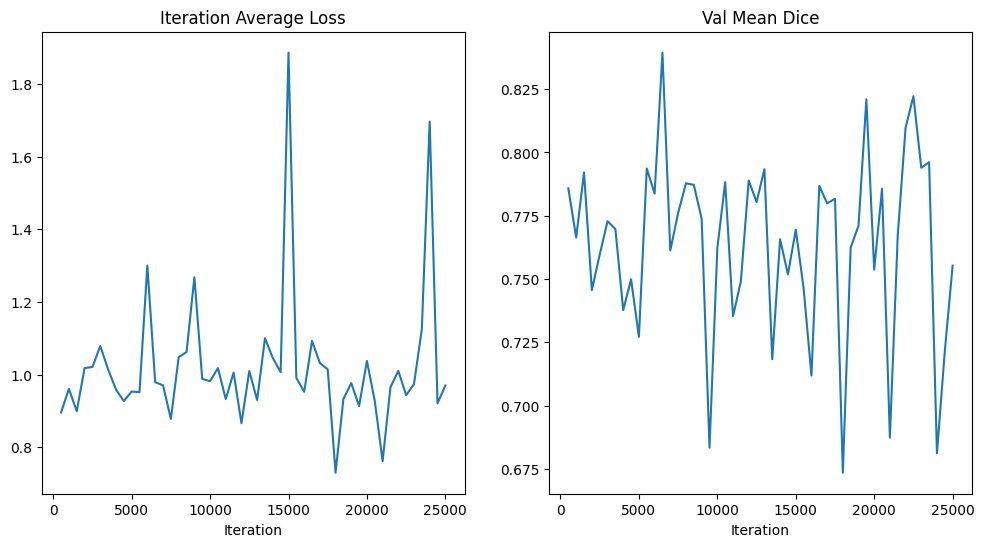

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [6]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=20, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]


In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=48,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [16]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        gc.collect()
        torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.79694): 100%|█| 24/24 [00:23<00:00,  1.01it/
Training (47 / 25000 Steps) (loss=0.84039): 100%|█| 24/24 [00:23<00:00,  1.01it/
Training (71 / 25000 Steps) (loss=0.80285): 100%|█| 24/24 [00:23<00:00,  1.00it/
Training (95 / 25000 Steps) (loss=1.06996): 100%|█| 24/24 [00:23<00:00,  1.01it/
Training (119 / 25000 Steps) (loss=1.48222): 100%|█| 24/24 [00:23<00:00,  1.02it
Training (143 / 25000 Steps) (loss=0.69242): 100%|█| 24/24 [00:24<00:00,  1.00s/
Training (167 / 25000 Steps) (loss=0.72557): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (191 / 25000 Steps) (loss=1.02292): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (215 / 25000 Steps) (loss=0.74347): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (239 / 25000 Steps) (loss=1.22145): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (263 / 25000 Steps) (loss=1.69778): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (287 / 25000 Steps) (loss=0.91811): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7218456268310547 Current Avg. Dice: 0.7218456268310547


Training (503 / 25000 Steps) (loss=0.80225): 100%|█| 24/24 [00:26<00:00,  1.10s/
Training (527 / 25000 Steps) (loss=0.79846): 100%|█| 24/24 [00:24<00:00,  1.00s/
Training (551 / 25000 Steps) (loss=0.97962): 100%|█| 24/24 [00:24<00:00,  1.00s/
Training (575 / 25000 Steps) (loss=0.74061): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (599 / 25000 Steps) (loss=0.99703): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (623 / 25000 Steps) (loss=0.89351): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (647 / 25000 Steps) (loss=0.85983): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (671 / 25000 Steps) (loss=1.29033): 100%|█| 24/24 [00:23<00:00,  1.01it
Training (695 / 25000 Steps) (loss=0.80067): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (719 / 25000 Steps) (loss=0.80497): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (743 / 25000 Steps) (loss=0.79500): 100%|█| 24/24 [00:24<00:00,  1.00s/
Training (767 / 25000 Steps) (loss=0.67275): 100%|█| 24/24 [00:23<00:00,  1.00it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.7363292574882507


Training (1007 / 25000 Steps) (loss=0.68154): 100%|█| 24/24 [00:26<00:00,  1.10s
Training (1031 / 25000 Steps) (loss=0.91871): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1055 / 25000 Steps) (loss=0.99111): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1079 / 25000 Steps) (loss=0.97926): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1103 / 25000 Steps) (loss=0.79283): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1127 / 25000 Steps) (loss=0.80149): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1151 / 25000 Steps) (loss=1.07992): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1175 / 25000 Steps) (loss=2.02720): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1199 / 25000 Steps) (loss=0.87204): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (1223 / 25000 Steps) (loss=0.94662): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1247 / 25000 Steps) (loss=1.03540): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1271 / 25000 Steps) (loss=0.84853): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.684837818145752


Training (1511 / 25000 Steps) (loss=1.07355): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (1535 / 25000 Steps) (loss=0.84052): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1559 / 25000 Steps) (loss=0.83838): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1583 / 25000 Steps) (loss=0.98611): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1607 / 25000 Steps) (loss=1.01137): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1631 / 25000 Steps) (loss=1.32061): 100%|█| 24/24 [00:24<00:00,  1.02s
Training (1655 / 25000 Steps) (loss=0.72764): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1679 / 25000 Steps) (loss=0.90703): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1703 / 25000 Steps) (loss=0.84920): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (1727 / 25000 Steps) (loss=0.82823): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (1751 / 25000 Steps) (loss=0.66839): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (1775 / 25000 Steps) (loss=1.14185): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.6689493656158447


Training (2015 / 25000 Steps) (loss=0.90101): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (2039 / 25000 Steps) (loss=1.78177): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2063 / 25000 Steps) (loss=0.83535): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (2087 / 25000 Steps) (loss=1.02192): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (2111 / 25000 Steps) (loss=0.64562): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (2135 / 25000 Steps) (loss=1.07327): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (2159 / 25000 Steps) (loss=1.11661): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2183 / 25000 Steps) (loss=0.87439): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (2207 / 25000 Steps) (loss=0.86215): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (2231 / 25000 Steps) (loss=0.71945): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2255 / 25000 Steps) (loss=0.72794): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2279 / 25000 Steps) (loss=1.03301): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.6358517408370972


Training (2519 / 25000 Steps) (loss=1.10837): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (2543 / 25000 Steps) (loss=0.82339): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (2567 / 25000 Steps) (loss=1.23933): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (2591 / 25000 Steps) (loss=0.75383): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2615 / 25000 Steps) (loss=1.03728): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (2639 / 25000 Steps) (loss=0.83966): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2663 / 25000 Steps) (loss=0.81961): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (2687 / 25000 Steps) (loss=0.75356): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (2711 / 25000 Steps) (loss=1.05423): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2735 / 25000 Steps) (loss=0.95064): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (2759 / 25000 Steps) (loss=1.22624): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2783 / 25000 Steps) (loss=0.80897): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.6523807644844055


Training (3023 / 25000 Steps) (loss=0.70558): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (3047 / 25000 Steps) (loss=0.81253): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3071 / 25000 Steps) (loss=0.83330): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3095 / 25000 Steps) (loss=0.97959): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3119 / 25000 Steps) (loss=1.16125): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3143 / 25000 Steps) (loss=0.68724): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (3167 / 25000 Steps) (loss=0.74619): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (3191 / 25000 Steps) (loss=0.67798): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (3215 / 25000 Steps) (loss=1.24821): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3239 / 25000 Steps) (loss=1.06124): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (3263 / 25000 Steps) (loss=0.71587): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3287 / 25000 Steps) (loss=1.04981): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.7216105461120605


Training (3503 / 25000 Steps) (loss=0.84630): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (3527 / 25000 Steps) (loss=0.75613): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3551 / 25000 Steps) (loss=0.71142): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3575 / 25000 Steps) (loss=1.43305): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3599 / 25000 Steps) (loss=1.35890): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3623 / 25000 Steps) (loss=0.87957): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (3647 / 25000 Steps) (loss=0.82328): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (3671 / 25000 Steps) (loss=0.78124): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (3695 / 25000 Steps) (loss=0.70166): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (3719 / 25000 Steps) (loss=1.12883): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3743 / 25000 Steps) (loss=0.94450): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (3767 / 25000 Steps) (loss=0.78460): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7363292574882507 Current Avg. Dice: 0.6750538945198059


Training (4007 / 25000 Steps) (loss=0.67721): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (4031 / 25000 Steps) (loss=0.77160): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4055 / 25000 Steps) (loss=0.91314): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4079 / 25000 Steps) (loss=1.08750): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (4103 / 25000 Steps) (loss=0.98507): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4127 / 25000 Steps) (loss=1.25338): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4151 / 25000 Steps) (loss=0.78455): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (4175 / 25000 Steps) (loss=0.72389): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4199 / 25000 Steps) (loss=0.76756): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4223 / 25000 Steps) (loss=1.55749): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (4247 / 25000 Steps) (loss=0.85172): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (4271 / 25000 Steps) (loss=0.86091): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7716032862663269


Training (4511 / 25000 Steps) (loss=0.83074): 100%|█| 24/24 [00:26<00:00,  1.10s
Training (4535 / 25000 Steps) (loss=1.68922): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (4559 / 25000 Steps) (loss=0.78255): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4583 / 25000 Steps) (loss=1.35199): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (4607 / 25000 Steps) (loss=1.63847): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4631 / 25000 Steps) (loss=0.84697): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (4655 / 25000 Steps) (loss=0.79530): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4679 / 25000 Steps) (loss=0.80705): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (4703 / 25000 Steps) (loss=0.82809): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (4727 / 25000 Steps) (loss=2.04750): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (4751 / 25000 Steps) (loss=1.17010): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (4775 / 25000 Steps) (loss=0.83664): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6829426288604736


Training (5015 / 25000 Steps) (loss=0.78346): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (5039 / 25000 Steps) (loss=0.86326): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5063 / 25000 Steps) (loss=1.05917): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5087 / 25000 Steps) (loss=0.78811): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5111 / 25000 Steps) (loss=0.80547): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5135 / 25000 Steps) (loss=1.05378): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (5159 / 25000 Steps) (loss=0.94043): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5183 / 25000 Steps) (loss=0.74637): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (5207 / 25000 Steps) (loss=0.67725): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (5231 / 25000 Steps) (loss=1.03918): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5255 / 25000 Steps) (loss=0.69198): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5279 / 25000 Steps) (loss=0.70077): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6640916466712952


Training (5519 / 25000 Steps) (loss=0.70455): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (5543 / 25000 Steps) (loss=0.68975): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5567 / 25000 Steps) (loss=0.77078): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5591 / 25000 Steps) (loss=1.17331): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (5615 / 25000 Steps) (loss=0.77574): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5639 / 25000 Steps) (loss=0.76381): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (5663 / 25000 Steps) (loss=0.78673): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5687 / 25000 Steps) (loss=1.23087): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (5711 / 25000 Steps) (loss=0.84100): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (5735 / 25000 Steps) (loss=0.87622): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (5759 / 25000 Steps) (loss=1.05768): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (5783 / 25000 Steps) (loss=1.17259): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6713471412658691


Training (6023 / 25000 Steps) (loss=1.15034): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (6047 / 25000 Steps) (loss=0.80965): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (6071 / 25000 Steps) (loss=0.80739): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6095 / 25000 Steps) (loss=0.75445): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6119 / 25000 Steps) (loss=0.76791): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6143 / 25000 Steps) (loss=1.02315): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6167 / 25000 Steps) (loss=0.82801): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6191 / 25000 Steps) (loss=0.70863): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6215 / 25000 Steps) (loss=0.85816): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6239 / 25000 Steps) (loss=0.81757): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6263 / 25000 Steps) (loss=0.70258): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6287 / 25000 Steps) (loss=0.85317): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6839434504508972


Training (6503 / 25000 Steps) (loss=0.86600): 100%|█| 24/24 [00:26<00:00,  1.10s
Training (6527 / 25000 Steps) (loss=0.80672): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6551 / 25000 Steps) (loss=0.77606): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6575 / 25000 Steps) (loss=0.70682): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6599 / 25000 Steps) (loss=0.75347): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6623 / 25000 Steps) (loss=0.80261): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (6647 / 25000 Steps) (loss=0.87170): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6671 / 25000 Steps) (loss=0.81807): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6695 / 25000 Steps) (loss=0.85259): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6719 / 25000 Steps) (loss=1.74454): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (6743 / 25000 Steps) (loss=0.77613): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (6767 / 25000 Steps) (loss=0.65889): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7591568827629089


Training (7007 / 25000 Steps) (loss=0.85494): 100%|█| 24/24 [00:25<00:00,  1.08s
Training (7031 / 25000 Steps) (loss=0.79587): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7055 / 25000 Steps) (loss=0.77388): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7079 / 25000 Steps) (loss=0.97609): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7103 / 25000 Steps) (loss=0.91259): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7127 / 25000 Steps) (loss=0.84697): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (7151 / 25000 Steps) (loss=1.06131): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7175 / 25000 Steps) (loss=1.06423): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7199 / 25000 Steps) (loss=0.69374): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (7223 / 25000 Steps) (loss=0.82557): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7247 / 25000 Steps) (loss=0.88172): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (7271 / 25000 Steps) (loss=0.87847): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7033652663230896


Training (7511 / 25000 Steps) (loss=0.78216): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (7535 / 25000 Steps) (loss=1.10002): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7559 / 25000 Steps) (loss=1.00477): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7583 / 25000 Steps) (loss=0.90236): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7607 / 25000 Steps) (loss=0.73248): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7631 / 25000 Steps) (loss=0.81815): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7655 / 25000 Steps) (loss=1.28181): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7679 / 25000 Steps) (loss=0.81169): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7703 / 25000 Steps) (loss=1.10703): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (7727 / 25000 Steps) (loss=0.85514): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7751 / 25000 Steps) (loss=0.93332): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (7775 / 25000 Steps) (loss=0.99961): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7445068955421448


Training (8015 / 25000 Steps) (loss=0.79427): 100%|█| 24/24 [00:25<00:00,  1.07s
Training (8039 / 25000 Steps) (loss=0.69913): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8063 / 25000 Steps) (loss=0.64270): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8087 / 25000 Steps) (loss=1.03165): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8111 / 25000 Steps) (loss=0.78076): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8135 / 25000 Steps) (loss=0.86632): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8159 / 25000 Steps) (loss=0.71017): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (8183 / 25000 Steps) (loss=1.47175): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8207 / 25000 Steps) (loss=1.34504): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8231 / 25000 Steps) (loss=1.63907): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8255 / 25000 Steps) (loss=1.52563): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8279 / 25000 Steps) (loss=0.85789): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7113153338432312


Training (8519 / 25000 Steps) (loss=0.82926): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (8543 / 25000 Steps) (loss=1.20726): 100%|█| 24/24 [00:24<00:00,  1.02s
Training (8567 / 25000 Steps) (loss=0.81619): 100%|█| 24/24 [00:24<00:00,  1.02s
Training (8591 / 25000 Steps) (loss=0.79561): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (8615 / 25000 Steps) (loss=1.11087): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8639 / 25000 Steps) (loss=0.68073): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (8663 / 25000 Steps) (loss=0.93846): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (8687 / 25000 Steps) (loss=0.89114): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8711 / 25000 Steps) (loss=0.85628): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8735 / 25000 Steps) (loss=0.80569): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (8759 / 25000 Steps) (loss=0.91171): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (8783 / 25000 Steps) (loss=0.65141): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6623377203941345


Training (9023 / 25000 Steps) (loss=0.94189): 100%|█| 24/24 [00:26<00:00,  1.10s
Training (9047 / 25000 Steps) (loss=0.71104): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (9071 / 25000 Steps) (loss=0.83647): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9095 / 25000 Steps) (loss=0.73974): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9119 / 25000 Steps) (loss=0.88500): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9143 / 25000 Steps) (loss=0.95138): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9167 / 25000 Steps) (loss=0.69501): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9191 / 25000 Steps) (loss=1.04721): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9215 / 25000 Steps) (loss=1.41666): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9239 / 25000 Steps) (loss=0.80074): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9263 / 25000 Steps) (loss=1.06398): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9287 / 25000 Steps) (loss=0.68756): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7170817852020264


Training (9503 / 25000 Steps) (loss=0.69689): 100%|█| 24/24 [00:26<00:00,  1.09s
Training (9527 / 25000 Steps) (loss=1.02938): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (9551 / 25000 Steps) (loss=1.48254): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (9575 / 25000 Steps) (loss=0.80302): 100%|█| 24/24 [00:23<00:00,  1.00i
Training (9599 / 25000 Steps) (loss=0.74385): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9623 / 25000 Steps) (loss=0.87605): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9647 / 25000 Steps) (loss=0.96445): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9671 / 25000 Steps) (loss=1.08252): 100%|█| 24/24 [00:23<00:00,  1.01i
Training (9695 / 25000 Steps) (loss=0.81468): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9719 / 25000 Steps) (loss=0.82236): 100%|█| 24/24 [00:24<00:00,  1.00s
Training (9743 / 25000 Steps) (loss=0.82841): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9767 / 25000 Steps) (loss=0.94234): 100%|█| 24/24 [00:24<00:00,  1.01s
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7100774645805359


Training (10007 / 25000 Steps) (loss=1.17889): 100%|█| 24/24 [00:26<00:00,  1.10
Training (10031 / 25000 Steps) (loss=0.81634): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10055 / 25000 Steps) (loss=1.77374): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10079 / 25000 Steps) (loss=0.78587): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10103 / 25000 Steps) (loss=0.81513): 100%|█| 24/24 [00:24<00:00,  1.01
Training (10127 / 25000 Steps) (loss=0.86218): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10151 / 25000 Steps) (loss=0.85085): 100%|█| 24/24 [00:24<00:00,  1.01
Training (10175 / 25000 Steps) (loss=0.81735): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10199 / 25000 Steps) (loss=0.90445): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10223 / 25000 Steps) (loss=0.82130): 100%|█| 24/24 [00:24<00:00,  1.01
Training (10247 / 25000 Steps) (loss=0.65016): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10271 / 25000 Steps) (loss=0.73255): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7296043038368225


Training (10511 / 25000 Steps) (loss=0.75001): 100%|█| 24/24 [00:26<00:00,  1.09
Training (10535 / 25000 Steps) (loss=0.88399): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10559 / 25000 Steps) (loss=0.86117): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10583 / 25000 Steps) (loss=1.07896): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10607 / 25000 Steps) (loss=1.13813): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10631 / 25000 Steps) (loss=0.82465): 100%|█| 24/24 [00:23<00:00,  1.00
Training (10655 / 25000 Steps) (loss=0.89226): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10679 / 25000 Steps) (loss=0.83700): 100%|█| 24/24 [00:24<00:00,  1.01
Training (10703 / 25000 Steps) (loss=0.89107): 100%|█| 24/24 [00:24<00:00,  1.01
Training (10727 / 25000 Steps) (loss=1.17272): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10751 / 25000 Steps) (loss=0.83565): 100%|█| 24/24 [00:24<00:00,  1.00
Training (10775 / 25000 Steps) (loss=0.89737): 100%|█| 24/24 [00:24<00:00,  1.01
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.748445987701416


Training (11015 / 25000 Steps) (loss=0.77909): 100%|█| 24/24 [00:26<00:00,  1.09
Training (11039 / 25000 Steps) (loss=1.33881): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11063 / 25000 Steps) (loss=0.79276): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11087 / 25000 Steps) (loss=1.02472): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11111 / 25000 Steps) (loss=0.78138): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11135 / 25000 Steps) (loss=0.64222): 100%|█| 24/24 [00:23<00:00,  1.00
Training (11159 / 25000 Steps) (loss=0.80662): 100%|█| 24/24 [00:23<00:00,  1.01
Training (11183 / 25000 Steps) (loss=1.40172): 100%|█| 24/24 [00:24<00:00,  1.01
Training (11207 / 25000 Steps) (loss=0.90123): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11231 / 25000 Steps) (loss=0.71307): 100%|█| 24/24 [00:24<00:00,  1.01
Training (11255 / 25000 Steps) (loss=0.86629): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11279 / 25000 Steps) (loss=0.82742): 100%|█| 24/24 [00:24<00:00,  1.01
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6803409457206726


Training (11519 / 25000 Steps) (loss=0.90546): 100%|█| 24/24 [00:25<00:00,  1.08
Training (11543 / 25000 Steps) (loss=0.79893): 100%|█| 24/24 [00:24<00:00,  1.01
Training (11567 / 25000 Steps) (loss=0.91224): 100%|█| 24/24 [00:24<00:00,  1.01
Training (11591 / 25000 Steps) (loss=0.88152): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11615 / 25000 Steps) (loss=1.14425): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11639 / 25000 Steps) (loss=0.87204): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11663 / 25000 Steps) (loss=1.11160): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11687 / 25000 Steps) (loss=1.01030): 100%|█| 24/24 [00:24<00:00,  1.02
Training (11711 / 25000 Steps) (loss=0.99837): 100%|█| 24/24 [00:24<00:00,  1.00
Training (11735 / 25000 Steps) (loss=0.81357): 100%|█| 24/24 [00:24<00:00,  1.01
Training (11759 / 25000 Steps) (loss=0.65391): 100%|█| 24/24 [00:23<00:00,  1.00
Training (11783 / 25000 Steps) (loss=0.82757): 100%|█| 24/24 [00:23<00:00,  1.00
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6856583952903748


Training (12023 / 25000 Steps) (loss=0.98870): 100%|█| 24/24 [00:25<00:00,  1.08
Training (12047 / 25000 Steps) (loss=1.13917): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12071 / 25000 Steps) (loss=0.74942): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12095 / 25000 Steps) (loss=1.06477): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12119 / 25000 Steps) (loss=0.96551): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12143 / 25000 Steps) (loss=0.98324): 100%|█| 24/24 [00:23<00:00,  1.00
Training (12167 / 25000 Steps) (loss=0.62629): 100%|█| 24/24 [00:23<00:00,  1.01
Training (12191 / 25000 Steps) (loss=0.76153): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12215 / 25000 Steps) (loss=0.98448): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12239 / 25000 Steps) (loss=1.08663): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12263 / 25000 Steps) (loss=0.83728): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12287 / 25000 Steps) (loss=0.89468): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6622444987297058


Training (12503 / 25000 Steps) (loss=0.79736): 100%|█| 24/24 [00:26<00:00,  1.09
Training (12527 / 25000 Steps) (loss=0.84217): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12551 / 25000 Steps) (loss=1.02475): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12575 / 25000 Steps) (loss=0.87408): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12599 / 25000 Steps) (loss=1.03554): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12623 / 25000 Steps) (loss=0.81440): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12647 / 25000 Steps) (loss=1.07528): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12671 / 25000 Steps) (loss=0.68419): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12695 / 25000 Steps) (loss=0.95710): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12719 / 25000 Steps) (loss=0.97779): 100%|█| 24/24 [00:24<00:00,  1.01
Training (12743 / 25000 Steps) (loss=0.67212): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12767 / 25000 Steps) (loss=1.28116): 100%|█| 24/24 [00:24<00:00,  1.00
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7394949793815613


Training (13007 / 25000 Steps) (loss=0.80467): 100%|█| 24/24 [00:26<00:00,  1.09
Training (13031 / 25000 Steps) (loss=0.82129): 100%|█| 24/24 [00:24<00:00,  1.00
Training (13055 / 25000 Steps) (loss=0.68042): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13079 / 25000 Steps) (loss=0.95429): 100%|█| 24/24 [00:23<00:00,  1.00
Training (13103 / 25000 Steps) (loss=1.19143): 100%|█| 24/24 [00:24<00:00,  1.00
Training (13127 / 25000 Steps) (loss=0.88125): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13151 / 25000 Steps) (loss=0.74327): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13175 / 25000 Steps) (loss=0.86151): 100%|█| 24/24 [00:23<00:00,  1.00
Training (13199 / 25000 Steps) (loss=0.81503): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13223 / 25000 Steps) (loss=0.64574): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13247 / 25000 Steps) (loss=1.68655): 100%|█| 24/24 [00:23<00:00,  1.00
Training (13271 / 25000 Steps) (loss=0.78409): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7374238967895508


Training (13511 / 25000 Steps) (loss=0.87520): 100%|█| 24/24 [00:26<00:00,  1.09
Training (13535 / 25000 Steps) (loss=1.08647): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13559 / 25000 Steps) (loss=0.79734): 100%|█| 24/24 [00:24<00:00,  1.00
Training (13583 / 25000 Steps) (loss=0.92338): 100%|█| 24/24 [00:23<00:00,  1.00
Training (13607 / 25000 Steps) (loss=0.75469): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13631 / 25000 Steps) (loss=0.88053): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13655 / 25000 Steps) (loss=0.86951): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13679 / 25000 Steps) (loss=0.87943): 100%|█| 24/24 [00:24<00:00,  1.00
Training (13703 / 25000 Steps) (loss=1.09677): 100%|█| 24/24 [00:23<00:00,  1.00
Training (13727 / 25000 Steps) (loss=1.19971): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13751 / 25000 Steps) (loss=0.95523): 100%|█| 24/24 [00:24<00:00,  1.00
Training (13775 / 25000 Steps) (loss=0.74178): 100%|█| 24/24 [00:24<00:00,  1.01
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6938182711601257


Training (14015 / 25000 Steps) (loss=1.14331): 100%|█| 24/24 [00:26<00:00,  1.10
Training (14039 / 25000 Steps) (loss=0.89972): 100%|█| 24/24 [00:23<00:00,  1.00
Training (14063 / 25000 Steps) (loss=0.89648): 100%|█| 24/24 [00:24<00:00,  1.00
Training (14087 / 25000 Steps) (loss=0.91306): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14111 / 25000 Steps) (loss=0.78790): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14135 / 25000 Steps) (loss=0.82799): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14159 / 25000 Steps) (loss=0.87676): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14183 / 25000 Steps) (loss=1.07603): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14207 / 25000 Steps) (loss=0.77344): 100%|█| 24/24 [00:24<00:00,  1.00
Training (14231 / 25000 Steps) (loss=0.86046): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14255 / 25000 Steps) (loss=0.87417): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14279 / 25000 Steps) (loss=0.68744): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7047536373138428


Training (14519 / 25000 Steps) (loss=0.99883): 100%|█| 24/24 [00:26<00:00,  1.09
Training (14543 / 25000 Steps) (loss=0.97649): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14567 / 25000 Steps) (loss=0.99110): 100%|█| 24/24 [00:24<00:00,  1.00
Training (14591 / 25000 Steps) (loss=0.65279): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14615 / 25000 Steps) (loss=0.82031): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14639 / 25000 Steps) (loss=0.70625): 100%|█| 24/24 [00:24<00:00,  1.00
Training (14663 / 25000 Steps) (loss=1.62757): 100%|█| 24/24 [00:24<00:00,  1.00
Training (14687 / 25000 Steps) (loss=0.80273): 100%|█| 24/24 [00:23<00:00,  1.00
Training (14711 / 25000 Steps) (loss=0.90345): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14735 / 25000 Steps) (loss=0.68977): 100%|█| 24/24 [00:24<00:00,  1.01
Training (14759 / 25000 Steps) (loss=0.82986): 100%|█| 24/24 [00:23<00:00,  1.00
Training (14783 / 25000 Steps) (loss=0.99581): 100%|█| 24/24 [00:24<00:00,  1.00
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6604844927787781


Training (15023 / 25000 Steps) (loss=0.76014): 100%|█| 24/24 [00:26<00:00,  1.09
Training (15047 / 25000 Steps) (loss=0.77465): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15071 / 25000 Steps) (loss=0.86376): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15095 / 25000 Steps) (loss=0.97977): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15119 / 25000 Steps) (loss=0.93793): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15143 / 25000 Steps) (loss=0.76967): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15167 / 25000 Steps) (loss=0.81084): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15191 / 25000 Steps) (loss=0.88588): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15215 / 25000 Steps) (loss=0.87175): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15239 / 25000 Steps) (loss=0.70994): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15263 / 25000 Steps) (loss=0.75726): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15287 / 25000 Steps) (loss=0.84076): 100%|█| 24/24 [00:23<00:00,  1.00
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7176551818847656


Training (15503 / 25000 Steps) (loss=0.90465): 100%|█| 24/24 [00:26<00:00,  1.09
Training (15527 / 25000 Steps) (loss=0.95481): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15551 / 25000 Steps) (loss=0.95930): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15575 / 25000 Steps) (loss=0.89020): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15599 / 25000 Steps) (loss=0.78322): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15623 / 25000 Steps) (loss=0.97220): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15647 / 25000 Steps) (loss=1.05358): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15671 / 25000 Steps) (loss=1.01636): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15695 / 25000 Steps) (loss=0.85729): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15719 / 25000 Steps) (loss=0.79668): 100%|█| 24/24 [00:24<00:00,  1.00
Training (15743 / 25000 Steps) (loss=0.80756): 100%|█| 24/24 [00:23<00:00,  1.01
Training (15767 / 25000 Steps) (loss=0.86436): 100%|█| 24/24 [00:24<00:00,  1.01
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7026961445808411


Training (16007 / 25000 Steps) (loss=1.02861): 100%|█| 24/24 [00:26<00:00,  1.08
Training (16031 / 25000 Steps) (loss=0.81527): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16055 / 25000 Steps) (loss=0.78540): 100%|█| 24/24 [00:23<00:00,  1.00
Training (16079 / 25000 Steps) (loss=0.84696): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16103 / 25000 Steps) (loss=1.08027): 100%|█| 24/24 [00:24<00:00,  1.01
Training (16127 / 25000 Steps) (loss=0.78607): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16151 / 25000 Steps) (loss=0.69322): 100%|█| 24/24 [00:24<00:00,  1.01
Training (16175 / 25000 Steps) (loss=0.76666): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16199 / 25000 Steps) (loss=0.84602): 100%|█| 24/24 [00:23<00:00,  1.00
Training (16223 / 25000 Steps) (loss=1.25563): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16247 / 25000 Steps) (loss=0.79559): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16271 / 25000 Steps) (loss=0.72216): 100%|█| 24/24 [00:24<00:00,  1.01
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7170818448066711


Training (16511 / 25000 Steps) (loss=0.75832): 100%|█| 24/24 [00:26<00:00,  1.09
Training (16535 / 25000 Steps) (loss=0.69225): 100%|█| 24/24 [00:24<00:00,  1.01
Training (16559 / 25000 Steps) (loss=0.66780): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16583 / 25000 Steps) (loss=0.87113): 100%|█| 24/24 [00:24<00:00,  1.01
Training (16607 / 25000 Steps) (loss=0.83077): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16631 / 25000 Steps) (loss=1.15234): 100%|█| 24/24 [00:24<00:00,  1.01
Training (16655 / 25000 Steps) (loss=0.84797): 100%|█| 24/24 [00:23<00:00,  1.00
Training (16679 / 25000 Steps) (loss=0.92773): 100%|█| 24/24 [00:23<00:00,  1.00
Training (16703 / 25000 Steps) (loss=0.97071): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16727 / 25000 Steps) (loss=0.91525): 100%|█| 24/24 [00:24<00:00,  1.00
Training (16751 / 25000 Steps) (loss=0.85823): 100%|█| 24/24 [00:23<00:00,  1.00
Training (16775 / 25000 Steps) (loss=0.70663): 100%|█| 24/24 [00:23<00:00,  1.00
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7512057423591614


Training (17015 / 25000 Steps) (loss=0.84635): 100%|█| 24/24 [00:26<00:00,  1.09
Training (17039 / 25000 Steps) (loss=0.87632): 100%|█| 24/24 [00:23<00:00,  1.00
Training (17063 / 25000 Steps) (loss=0.98229): 100%|█| 24/24 [00:23<00:00,  1.00
Training (17087 / 25000 Steps) (loss=0.90644): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17111 / 25000 Steps) (loss=1.18104): 100%|█| 24/24 [00:24<00:00,  1.01
Training (17135 / 25000 Steps) (loss=0.76683): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17159 / 25000 Steps) (loss=0.73129): 100%|█| 24/24 [00:23<00:00,  1.01
Training (17183 / 25000 Steps) (loss=0.81468): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17207 / 25000 Steps) (loss=0.84026): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17231 / 25000 Steps) (loss=0.81456): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17255 / 25000 Steps) (loss=0.78929): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17279 / 25000 Steps) (loss=0.83580): 100%|█| 24/24 [00:24<00:00,  1.01
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6754050254821777


Training (17519 / 25000 Steps) (loss=1.16618): 100%|█| 24/24 [00:26<00:00,  1.09
Training (17543 / 25000 Steps) (loss=0.83022): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17567 / 25000 Steps) (loss=1.11081): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17591 / 25000 Steps) (loss=0.74127): 100%|█| 24/24 [00:24<00:00,  1.01
Training (17615 / 25000 Steps) (loss=0.97486): 100%|█| 24/24 [00:24<00:00,  1.01
Training (17639 / 25000 Steps) (loss=1.16484): 100%|█| 24/24 [00:24<00:00,  1.00
Training (17663 / 25000 Steps) (loss=0.77855): 100%|█| 24/24 [00:24<00:00,  1.01
Training (17687 / 25000 Steps) (loss=0.85819): 100%|█| 24/24 [00:23<00:00,  1.00
Training (17711 / 25000 Steps) (loss=0.94492): 100%|█| 24/24 [00:23<00:00,  1.00
Training (17735 / 25000 Steps) (loss=1.96404): 100%|█| 24/24 [00:23<00:00,  1.00
Training (17759 / 25000 Steps) (loss=0.82687): 100%|█| 24/24 [00:23<00:00,  1.00
Training (17783 / 25000 Steps) (loss=0.79103): 100%|█| 24/24 [00:24<00:00,  1.01
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6880729794502258


Training (18023 / 25000 Steps) (loss=1.20130): 100%|█| 24/24 [00:26<00:00,  1.09
Training (18047 / 25000 Steps) (loss=0.92440): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18071 / 25000 Steps) (loss=0.95632): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18095 / 25000 Steps) (loss=0.85579): 100%|█| 24/24 [00:23<00:00,  1.00
Training (18119 / 25000 Steps) (loss=0.89049): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18143 / 25000 Steps) (loss=0.81806): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18167 / 25000 Steps) (loss=1.15509): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18191 / 25000 Steps) (loss=0.92187): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18215 / 25000 Steps) (loss=0.78765): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18239 / 25000 Steps) (loss=1.52354): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18263 / 25000 Steps) (loss=1.03017): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18287 / 25000 Steps) (loss=0.93196): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7377678751945496


Training (18503 / 25000 Steps) (loss=0.81587): 100%|█| 24/24 [00:26<00:00,  1.09
Training (18527 / 25000 Steps) (loss=1.12072): 100%|█| 24/24 [00:23<00:00,  1.00
Training (18551 / 25000 Steps) (loss=0.75806): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18575 / 25000 Steps) (loss=1.79731): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18599 / 25000 Steps) (loss=0.60729): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18623 / 25000 Steps) (loss=0.81969): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18647 / 25000 Steps) (loss=0.87541): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18671 / 25000 Steps) (loss=0.60293): 100%|█| 24/24 [00:24<00:00,  1.01
Training (18695 / 25000 Steps) (loss=0.92467): 100%|█| 24/24 [00:23<00:00,  1.01
Training (18719 / 25000 Steps) (loss=1.25988): 100%|█| 24/24 [00:23<00:00,  1.00
Training (18743 / 25000 Steps) (loss=0.58450): 100%|█| 24/24 [00:23<00:00,  1.00
Training (18767 / 25000 Steps) (loss=0.85443): 100%|█| 24/24 [00:24<00:00,  1.00
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6940653324127197


Training (19007 / 25000 Steps) (loss=0.92152): 100%|█| 24/24 [00:26<00:00,  1.09
Training (19031 / 25000 Steps) (loss=0.83896): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19055 / 25000 Steps) (loss=0.95397): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19079 / 25000 Steps) (loss=0.71409): 100%|█| 24/24 [00:23<00:00,  1.01
Training (19103 / 25000 Steps) (loss=1.04266): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19127 / 25000 Steps) (loss=0.90085): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19151 / 25000 Steps) (loss=1.30633): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19175 / 25000 Steps) (loss=0.72286): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19199 / 25000 Steps) (loss=0.84879): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19223 / 25000 Steps) (loss=0.91710): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19247 / 25000 Steps) (loss=0.67260): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19271 / 25000 Steps) (loss=0.74989): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6914870738983154


Training (19511 / 25000 Steps) (loss=0.83980): 100%|█| 24/24 [00:26<00:00,  1.09
Training (19535 / 25000 Steps) (loss=1.29002): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19559 / 25000 Steps) (loss=0.77419): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19583 / 25000 Steps) (loss=0.47550): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19607 / 25000 Steps) (loss=0.71837): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19631 / 25000 Steps) (loss=0.76609): 100%|█| 24/24 [00:23<00:00,  1.00
Training (19655 / 25000 Steps) (loss=0.89245): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19679 / 25000 Steps) (loss=0.69993): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19703 / 25000 Steps) (loss=0.86869): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19727 / 25000 Steps) (loss=1.34436): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19751 / 25000 Steps) (loss=0.77213): 100%|█| 24/24 [00:24<00:00,  1.01
Training (19775 / 25000 Steps) (loss=0.89618): 100%|█| 24/24 [00:24<00:00,  1.00
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6464214324951172


Training (20015 / 25000 Steps) (loss=0.75680): 100%|█| 24/24 [00:26<00:00,  1.09
Training (20039 / 25000 Steps) (loss=0.83854): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20063 / 25000 Steps) (loss=1.04524): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20087 / 25000 Steps) (loss=0.83074): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20111 / 25000 Steps) (loss=1.44684): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20135 / 25000 Steps) (loss=1.42447): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20159 / 25000 Steps) (loss=0.64259): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20183 / 25000 Steps) (loss=0.92097): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20207 / 25000 Steps) (loss=0.95481): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20231 / 25000 Steps) (loss=0.80218): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20255 / 25000 Steps) (loss=0.97034): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20279 / 25000 Steps) (loss=0.78631): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6778678297996521


Training (20519 / 25000 Steps) (loss=0.76408): 100%|█| 24/24 [00:26<00:00,  1.09
Training (20543 / 25000 Steps) (loss=0.97613): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20567 / 25000 Steps) (loss=0.94943): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20591 / 25000 Steps) (loss=0.78340): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20615 / 25000 Steps) (loss=1.05103): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20639 / 25000 Steps) (loss=0.73796): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20663 / 25000 Steps) (loss=0.63559): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20687 / 25000 Steps) (loss=1.38244): 100%|█| 24/24 [00:23<00:00,  1.00
Training (20711 / 25000 Steps) (loss=1.61758): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20735 / 25000 Steps) (loss=0.96877): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20759 / 25000 Steps) (loss=0.81914): 100%|█| 24/24 [00:24<00:00,  1.00
Training (20783 / 25000 Steps) (loss=1.09886): 100%|█| 24/24 [00:24<00:00,  1.01
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6537992358207703


Training (21023 / 25000 Steps) (loss=0.77087): 100%|█| 24/24 [00:26<00:00,  1.09
Training (21047 / 25000 Steps) (loss=0.76956): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21071 / 25000 Steps) (loss=0.92186): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21095 / 25000 Steps) (loss=1.16077): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21119 / 25000 Steps) (loss=0.74870): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21143 / 25000 Steps) (loss=0.77734): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21167 / 25000 Steps) (loss=0.85163): 100%|█| 24/24 [00:24<00:00,  1.02
Training (21191 / 25000 Steps) (loss=0.84584): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21215 / 25000 Steps) (loss=1.07335): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21239 / 25000 Steps) (loss=0.87879): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21263 / 25000 Steps) (loss=0.75905): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21287 / 25000 Steps) (loss=0.65254): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7485976219177246


Training (21503 / 25000 Steps) (loss=0.77047): 100%|█| 24/24 [00:26<00:00,  1.09
Training (21527 / 25000 Steps) (loss=0.85450): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21551 / 25000 Steps) (loss=0.70903): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21575 / 25000 Steps) (loss=0.88834): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21599 / 25000 Steps) (loss=0.90951): 100%|█| 24/24 [00:23<00:00,  1.00
Training (21623 / 25000 Steps) (loss=1.01601): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21647 / 25000 Steps) (loss=0.99206): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21671 / 25000 Steps) (loss=1.06730): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21695 / 25000 Steps) (loss=0.99841): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21719 / 25000 Steps) (loss=0.81473): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21743 / 25000 Steps) (loss=0.86839): 100%|█| 24/24 [00:24<00:00,  1.01
Training (21767 / 25000 Steps) (loss=0.79646): 100%|█| 24/24 [00:24<00:00,  1.00
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.7314228415489197


Training (22007 / 25000 Steps) (loss=0.87325): 100%|█| 24/24 [00:25<00:00,  1.08
Training (22031 / 25000 Steps) (loss=0.84183): 100%|█| 24/24 [00:23<00:00,  1.00
Training (22055 / 25000 Steps) (loss=0.78657): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22079 / 25000 Steps) (loss=0.89872): 100%|█| 24/24 [00:24<00:00,  1.00
Training (22103 / 25000 Steps) (loss=0.71408): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22127 / 25000 Steps) (loss=0.76879): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22151 / 25000 Steps) (loss=0.87572): 100%|█| 24/24 [00:24<00:00,  1.00
Training (22175 / 25000 Steps) (loss=1.29426): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22199 / 25000 Steps) (loss=0.93464): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22223 / 25000 Steps) (loss=0.80589): 100%|█| 24/24 [00:23<00:00,  1.01
Training (22247 / 25000 Steps) (loss=0.61414): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22271 / 25000 Steps) (loss=0.61542): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6838417053222656


Training (22511 / 25000 Steps) (loss=0.96878): 100%|█| 24/24 [00:26<00:00,  1.09
Training (22535 / 25000 Steps) (loss=1.08232): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22559 / 25000 Steps) (loss=0.79841): 100%|█| 24/24 [00:24<00:00,  1.02
Training (22583 / 25000 Steps) (loss=2.05272): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22607 / 25000 Steps) (loss=0.84353): 100%|█| 24/24 [00:24<00:00,  1.00
Training (22631 / 25000 Steps) (loss=0.67126): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22655 / 25000 Steps) (loss=0.93422): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22679 / 25000 Steps) (loss=1.05331): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22703 / 25000 Steps) (loss=0.95777): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22727 / 25000 Steps) (loss=0.93843): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22751 / 25000 Steps) (loss=0.81468): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22775 / 25000 Steps) (loss=0.85277): 100%|█| 24/24 [00:24<00:00,  1.01
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6955741047859192


Training (23015 / 25000 Steps) (loss=0.81007): 100%|█| 24/24 [00:26<00:00,  1.10
Training (23039 / 25000 Steps) (loss=0.84053): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23063 / 25000 Steps) (loss=0.79413): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23087 / 25000 Steps) (loss=0.90893): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23111 / 25000 Steps) (loss=0.84616): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23135 / 25000 Steps) (loss=0.85620): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23159 / 25000 Steps) (loss=0.72584): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23183 / 25000 Steps) (loss=0.86237): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23207 / 25000 Steps) (loss=0.79883): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23231 / 25000 Steps) (loss=1.17795): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23255 / 25000 Steps) (loss=0.92946): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23279 / 25000 Steps) (loss=0.91745): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6981938481330872


Training (23519 / 25000 Steps) (loss=0.87209): 100%|█| 24/24 [00:26<00:00,  1.09
Training (23543 / 25000 Steps) (loss=0.80266): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23567 / 25000 Steps) (loss=0.84050): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23591 / 25000 Steps) (loss=0.87129): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23615 / 25000 Steps) (loss=0.99264): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23639 / 25000 Steps) (loss=0.77698): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23663 / 25000 Steps) (loss=0.95008): 100%|█| 24/24 [00:24<00:00,  1.00
Training (23687 / 25000 Steps) (loss=0.88419): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23711 / 25000 Steps) (loss=0.87451): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23735 / 25000 Steps) (loss=1.12913): 100%|█| 24/24 [00:24<00:00,  1.02
Training (23759 / 25000 Steps) (loss=0.76089): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23783 / 25000 Steps) (loss=0.84743): 100%|█| 24/24 [00:24<00:00,  1.01
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7716032862663269 Current Avg. Dice: 0.6310861706733704


Training (24023 / 25000 Steps) (loss=0.99696): 100%|█| 24/24 [00:26<00:00,  1.09
Training (24047 / 25000 Steps) (loss=0.85009): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24071 / 25000 Steps) (loss=0.80220): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24095 / 25000 Steps) (loss=1.03133): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24119 / 25000 Steps) (loss=0.81161): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24143 / 25000 Steps) (loss=0.69721): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24167 / 25000 Steps) (loss=1.05925): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24191 / 25000 Steps) (loss=1.12621): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24215 / 25000 Steps) (loss=0.82815): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24239 / 25000 Steps) (loss=0.84651): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24263 / 25000 Steps) (loss=0.86253): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24287 / 25000 Steps) (loss=1.38870): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7752330899238586 Current Avg. Dice: 0.7752330899238586


Training (24503 / 25000 Steps) (loss=1.10143): 100%|█| 24/24 [00:26<00:00,  1.11
Training (24527 / 25000 Steps) (loss=1.92871): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24551 / 25000 Steps) (loss=0.83852): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24575 / 25000 Steps) (loss=0.84413): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24599 / 25000 Steps) (loss=0.88235): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24623 / 25000 Steps) (loss=0.77641): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24647 / 25000 Steps) (loss=2.18193): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24671 / 25000 Steps) (loss=0.75869): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24695 / 25000 Steps) (loss=1.03968): 100%|█| 24/24 [00:23<00:00,  1.00
Training (24719 / 25000 Steps) (loss=0.81882): 100%|█| 24/24 [00:24<00:00,  1.02
Training (24743 / 25000 Steps) (loss=1.00570): 100%|█| 24/24 [00:24<00:00,  1.01
Training (24767 / 25000 Steps) (loss=0.98241): 100%|█| 24/24 [00:24<00:00,  1.00
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7752330899238586 Current Avg. Dice: 0.724719762802124


Training (25007 / 25000 Steps) (loss=0.68343): 100%|█| 24/24 [00:26<00:00,  1.09


<All keys matched successfully>

In [18]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7752 at iteration: 24500


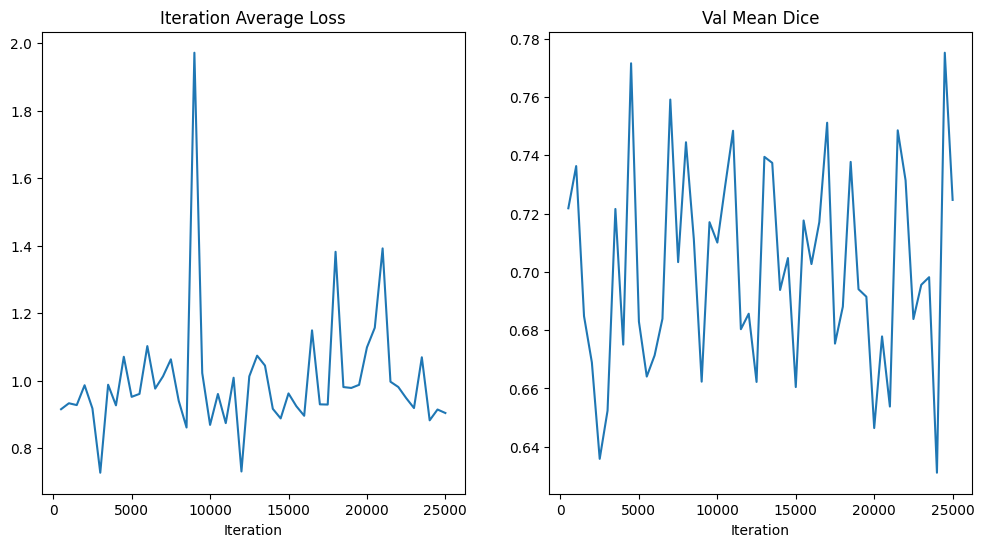

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [21]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=20, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]


In [20]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=48,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [22]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.77580): 100%|█| 24/24 [00:19<00:00,  1.21it/
Training (47 / 25000 Steps) (loss=1.03901): 100%|█| 24/24 [00:19<00:00,  1.22it/
Training (71 / 25000 Steps) (loss=1.07220): 100%|█| 24/24 [00:19<00:00,  1.21it/
Training (95 / 25000 Steps) (loss=0.90812): 100%|█| 24/24 [00:19<00:00,  1.20it/
Training (119 / 25000 Steps) (loss=0.76736): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (143 / 25000 Steps) (loss=0.91111): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (167 / 25000 Steps) (loss=1.30338): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (191 / 25000 Steps) (loss=0.76787): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (215 / 25000 Steps) (loss=0.79836): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (239 / 25000 Steps) (loss=1.03965): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (263 / 25000 Steps) (loss=0.81316): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (287 / 25000 Steps) (loss=0.77191): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6422414183616638 Current Avg. Dice: 0.6422414183616638


Training (503 / 25000 Steps) (loss=0.99452): 100%|█| 24/24 [00:22<00:00,  1.07it
Training (527 / 25000 Steps) (loss=0.70058): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (551 / 25000 Steps) (loss=0.99331): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (575 / 25000 Steps) (loss=1.07303): 100%|█| 24/24 [00:20<00:00,  1.19it
Training (599 / 25000 Steps) (loss=0.87245): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (623 / 25000 Steps) (loss=0.82279): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (647 / 25000 Steps) (loss=0.99598): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (671 / 25000 Steps) (loss=0.88567): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (695 / 25000 Steps) (loss=0.98885): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (719 / 25000 Steps) (loss=0.82960): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (743 / 25000 Steps) (loss=0.83379): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (767 / 25000 Steps) (loss=0.63997): 100%|█| 24/24 [00:20<00:00,  1.19it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.686763346195221 Current Avg. Dice: 0.686763346195221


Training (1007 / 25000 Steps) (loss=0.73836): 100%|█| 24/24 [00:22<00:00,  1.06i
Training (1031 / 25000 Steps) (loss=0.83698): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1055 / 25000 Steps) (loss=0.85166): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1079 / 25000 Steps) (loss=0.84093): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (1103 / 25000 Steps) (loss=0.72106): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1127 / 25000 Steps) (loss=0.65190): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1151 / 25000 Steps) (loss=1.23002): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1175 / 25000 Steps) (loss=1.21154): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (1199 / 25000 Steps) (loss=0.70344): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1223 / 25000 Steps) (loss=0.94307): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1247 / 25000 Steps) (loss=0.66033): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1271 / 25000 Steps) (loss=1.05089): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.686763346195221 Current Avg. Dice: 0.633522093296051


Training (1511 / 25000 Steps) (loss=0.82422): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (1535 / 25000 Steps) (loss=0.93411): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1559 / 25000 Steps) (loss=0.77443): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1583 / 25000 Steps) (loss=1.04112): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1607 / 25000 Steps) (loss=1.03404): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1631 / 25000 Steps) (loss=0.93529): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1655 / 25000 Steps) (loss=0.76571): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1679 / 25000 Steps) (loss=1.01208): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1703 / 25000 Steps) (loss=0.84482): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1727 / 25000 Steps) (loss=0.75345): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1751 / 25000 Steps) (loss=0.76619): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1775 / 25000 Steps) (loss=0.70851): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.686763346195221 Current Avg. Dice: 0.6613592505455017


Training (2015 / 25000 Steps) (loss=0.79197): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (2039 / 25000 Steps) (loss=0.67651): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2063 / 25000 Steps) (loss=0.62453): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (2087 / 25000 Steps) (loss=0.95908): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2111 / 25000 Steps) (loss=1.31489): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2135 / 25000 Steps) (loss=0.72646): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2159 / 25000 Steps) (loss=0.87772): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2183 / 25000 Steps) (loss=1.16475): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2207 / 25000 Steps) (loss=0.99715): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2231 / 25000 Steps) (loss=0.72452): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2255 / 25000 Steps) (loss=0.84745): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2279 / 25000 Steps) (loss=0.86692): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6904980540275574 Current Avg. Dice: 0.6904980540275574


Training (2519 / 25000 Steps) (loss=0.91161): 100%|█| 24/24 [00:22<00:00,  1.06i
Training (2543 / 25000 Steps) (loss=0.69128): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2567 / 25000 Steps) (loss=0.82606): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2591 / 25000 Steps) (loss=0.70138): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2615 / 25000 Steps) (loss=1.02086): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2639 / 25000 Steps) (loss=1.03863): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (2663 / 25000 Steps) (loss=1.48141): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (2687 / 25000 Steps) (loss=0.64187): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2711 / 25000 Steps) (loss=0.76888): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2735 / 25000 Steps) (loss=0.94190): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (2759 / 25000 Steps) (loss=0.94838): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2783 / 25000 Steps) (loss=0.94323): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6904980540275574 Current Avg. Dice: 0.5963290333747864


Training (3023 / 25000 Steps) (loss=0.78263): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (3047 / 25000 Steps) (loss=0.96348): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3071 / 25000 Steps) (loss=0.90901): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (3095 / 25000 Steps) (loss=1.12147): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3119 / 25000 Steps) (loss=0.97674): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (3143 / 25000 Steps) (loss=1.09856): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3167 / 25000 Steps) (loss=0.82417): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3191 / 25000 Steps) (loss=0.79138): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3215 / 25000 Steps) (loss=0.86781): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (3239 / 25000 Steps) (loss=1.05023): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3263 / 25000 Steps) (loss=0.65388): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3287 / 25000 Steps) (loss=0.74146): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6904980540275574 Current Avg. Dice: 0.6130750775337219


Training (3503 / 25000 Steps) (loss=0.95346): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (3527 / 25000 Steps) (loss=1.48956): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3551 / 25000 Steps) (loss=0.87130): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3575 / 25000 Steps) (loss=0.90806): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3599 / 25000 Steps) (loss=0.87377): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3623 / 25000 Steps) (loss=1.06556): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3647 / 25000 Steps) (loss=0.82197): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3671 / 25000 Steps) (loss=1.14825): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3695 / 25000 Steps) (loss=0.96377): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3719 / 25000 Steps) (loss=0.65592): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3743 / 25000 Steps) (loss=1.08281): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3767 / 25000 Steps) (loss=0.89444): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.7321375012397766


Training (4007 / 25000 Steps) (loss=0.77907): 100%|█| 24/24 [00:22<00:00,  1.06i
Training (4031 / 25000 Steps) (loss=0.79106): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4055 / 25000 Steps) (loss=0.89375): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4079 / 25000 Steps) (loss=1.14963): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (4103 / 25000 Steps) (loss=0.84961): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4127 / 25000 Steps) (loss=0.82560): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4151 / 25000 Steps) (loss=1.05335): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4175 / 25000 Steps) (loss=0.65039): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (4199 / 25000 Steps) (loss=0.82261): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4223 / 25000 Steps) (loss=1.04275): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4247 / 25000 Steps) (loss=0.79750): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4271 / 25000 Steps) (loss=1.16980): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6562569737434387


Training (4511 / 25000 Steps) (loss=1.07934): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (4535 / 25000 Steps) (loss=0.76934): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4559 / 25000 Steps) (loss=0.67129): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4583 / 25000 Steps) (loss=0.92632): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (4607 / 25000 Steps) (loss=0.91263): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (4631 / 25000 Steps) (loss=0.84229): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (4655 / 25000 Steps) (loss=0.79655): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4679 / 25000 Steps) (loss=0.96872): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4703 / 25000 Steps) (loss=1.07336): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4727 / 25000 Steps) (loss=0.99489): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4751 / 25000 Steps) (loss=0.83362): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (4775 / 25000 Steps) (loss=1.44313): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6681401133537292


Training (5015 / 25000 Steps) (loss=0.81651): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (5039 / 25000 Steps) (loss=0.88962): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5063 / 25000 Steps) (loss=0.88896): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (5087 / 25000 Steps) (loss=0.95450): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5111 / 25000 Steps) (loss=0.86659): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (5135 / 25000 Steps) (loss=0.87088): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5159 / 25000 Steps) (loss=1.07148): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (5183 / 25000 Steps) (loss=0.94694): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5207 / 25000 Steps) (loss=0.72154): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5231 / 25000 Steps) (loss=0.99656): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5255 / 25000 Steps) (loss=0.93486): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5279 / 25000 Steps) (loss=0.78750): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6577216982841492


Training (5519 / 25000 Steps) (loss=0.82031): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (5543 / 25000 Steps) (loss=0.95316): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5567 / 25000 Steps) (loss=0.86654): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5591 / 25000 Steps) (loss=0.74703): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5615 / 25000 Steps) (loss=0.91174): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (5639 / 25000 Steps) (loss=0.65888): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5663 / 25000 Steps) (loss=0.99857): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5687 / 25000 Steps) (loss=0.82385): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5711 / 25000 Steps) (loss=0.78123): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5735 / 25000 Steps) (loss=0.86221): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (5759 / 25000 Steps) (loss=1.13481): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5783 / 25000 Steps) (loss=0.87493): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6255181431770325


Training (6023 / 25000 Steps) (loss=0.93343): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (6047 / 25000 Steps) (loss=0.89846): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6071 / 25000 Steps) (loss=0.94576): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6095 / 25000 Steps) (loss=0.89477): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6119 / 25000 Steps) (loss=0.66517): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6143 / 25000 Steps) (loss=0.88454): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (6167 / 25000 Steps) (loss=0.79348): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6191 / 25000 Steps) (loss=0.89974): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6215 / 25000 Steps) (loss=0.88794): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (6239 / 25000 Steps) (loss=0.86280): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6263 / 25000 Steps) (loss=1.28525): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6287 / 25000 Steps) (loss=0.79680): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.609096348285675


Training (6503 / 25000 Steps) (loss=1.10709): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (6527 / 25000 Steps) (loss=0.83016): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6551 / 25000 Steps) (loss=0.90447): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (6575 / 25000 Steps) (loss=0.92763): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6599 / 25000 Steps) (loss=0.76662): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6623 / 25000 Steps) (loss=0.90022): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6647 / 25000 Steps) (loss=0.73828): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6671 / 25000 Steps) (loss=0.93665): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6695 / 25000 Steps) (loss=0.62325): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6719 / 25000 Steps) (loss=0.68741): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6743 / 25000 Steps) (loss=1.01684): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6767 / 25000 Steps) (loss=0.78288): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6298274397850037


Training (7007 / 25000 Steps) (loss=0.74708): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (7031 / 25000 Steps) (loss=0.90149): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7055 / 25000 Steps) (loss=0.83409): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7079 / 25000 Steps) (loss=1.12128): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7103 / 25000 Steps) (loss=0.88926): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7127 / 25000 Steps) (loss=0.83820): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7151 / 25000 Steps) (loss=0.89003): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7175 / 25000 Steps) (loss=0.80993): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7199 / 25000 Steps) (loss=0.77643): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7223 / 25000 Steps) (loss=0.94401): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7247 / 25000 Steps) (loss=0.75481): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7271 / 25000 Steps) (loss=0.81007): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.5989270210266113


Training (7511 / 25000 Steps) (loss=0.80366): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (7535 / 25000 Steps) (loss=0.81588): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7559 / 25000 Steps) (loss=0.81836): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (7583 / 25000 Steps) (loss=0.95513): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7607 / 25000 Steps) (loss=0.80053): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7631 / 25000 Steps) (loss=0.49011): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7655 / 25000 Steps) (loss=0.78682): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (7679 / 25000 Steps) (loss=1.06998): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7703 / 25000 Steps) (loss=0.97425): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7727 / 25000 Steps) (loss=0.70379): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7751 / 25000 Steps) (loss=0.62685): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7775 / 25000 Steps) (loss=1.60762): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6935858130455017


Training (8015 / 25000 Steps) (loss=0.76673): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (8039 / 25000 Steps) (loss=0.70307): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8063 / 25000 Steps) (loss=0.92420): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8087 / 25000 Steps) (loss=0.97109): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8111 / 25000 Steps) (loss=1.00334): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8135 / 25000 Steps) (loss=0.92773): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8159 / 25000 Steps) (loss=0.82907): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8183 / 25000 Steps) (loss=0.75969): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8207 / 25000 Steps) (loss=0.86477): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8231 / 25000 Steps) (loss=0.78083): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8255 / 25000 Steps) (loss=1.54511): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8279 / 25000 Steps) (loss=0.84603): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6792252659797668


Training (8519 / 25000 Steps) (loss=1.01224): 100%|█| 24/24 [00:22<00:00,  1.07i
Training (8543 / 25000 Steps) (loss=0.93377): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8567 / 25000 Steps) (loss=1.17743): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8591 / 25000 Steps) (loss=0.84545): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8615 / 25000 Steps) (loss=1.01916): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8639 / 25000 Steps) (loss=1.04334): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8663 / 25000 Steps) (loss=0.94097): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8687 / 25000 Steps) (loss=0.78059): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8711 / 25000 Steps) (loss=1.08194): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8735 / 25000 Steps) (loss=0.72403): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8759 / 25000 Steps) (loss=0.89625): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8783 / 25000 Steps) (loss=0.72671): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6505104303359985


Training (9023 / 25000 Steps) (loss=0.69313): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (9047 / 25000 Steps) (loss=0.77279): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9071 / 25000 Steps) (loss=1.96712): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (9095 / 25000 Steps) (loss=1.21145): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9119 / 25000 Steps) (loss=0.82744): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9143 / 25000 Steps) (loss=1.03137): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (9167 / 25000 Steps) (loss=0.77241): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9191 / 25000 Steps) (loss=0.83698): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9215 / 25000 Steps) (loss=0.86448): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9239 / 25000 Steps) (loss=1.06939): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9263 / 25000 Steps) (loss=0.69789): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9287 / 25000 Steps) (loss=1.02100): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6496619582176208


Training (9503 / 25000 Steps) (loss=0.74163): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (9527 / 25000 Steps) (loss=0.94522): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9551 / 25000 Steps) (loss=1.10808): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (9575 / 25000 Steps) (loss=0.88017): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9599 / 25000 Steps) (loss=0.81160): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9623 / 25000 Steps) (loss=0.87774): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9647 / 25000 Steps) (loss=0.88672): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9671 / 25000 Steps) (loss=1.41140): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9695 / 25000 Steps) (loss=1.12027): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9719 / 25000 Steps) (loss=1.09139): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (9743 / 25000 Steps) (loss=0.92503): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9767 / 25000 Steps) (loss=0.66389): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6406140923500061


Training (10007 / 25000 Steps) (loss=0.93431): 100%|█| 24/24 [00:22<00:00,  1.09
Training (10031 / 25000 Steps) (loss=0.94409): 100%|█| 24/24 [00:19<00:00,  1.21
Training (10055 / 25000 Steps) (loss=0.84232): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10079 / 25000 Steps) (loss=1.14571): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10103 / 25000 Steps) (loss=1.01531): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10127 / 25000 Steps) (loss=1.42883): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10151 / 25000 Steps) (loss=0.91206): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10175 / 25000 Steps) (loss=0.65517): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10199 / 25000 Steps) (loss=0.98625): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10223 / 25000 Steps) (loss=1.13123): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10247 / 25000 Steps) (loss=1.15857): 100%|█| 24/24 [00:19<00:00,  1.21
Training (10271 / 25000 Steps) (loss=0.93735): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.697317898273468


Training (10511 / 25000 Steps) (loss=0.99988): 100%|█| 24/24 [00:22<00:00,  1.09
Training (10535 / 25000 Steps) (loss=0.90081): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10559 / 25000 Steps) (loss=0.65989): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10583 / 25000 Steps) (loss=0.88916): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10607 / 25000 Steps) (loss=0.88256): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10631 / 25000 Steps) (loss=1.28375): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10655 / 25000 Steps) (loss=0.62736): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10679 / 25000 Steps) (loss=1.25352): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10703 / 25000 Steps) (loss=0.97241): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10727 / 25000 Steps) (loss=0.73547): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10751 / 25000 Steps) (loss=0.95212): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10775 / 25000 Steps) (loss=0.87566): 100%|█| 24/24 [00:19<00:00,  1.21
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6394661068916321


Training (11015 / 25000 Steps) (loss=1.03529): 100%|█| 24/24 [00:22<00:00,  1.09
Training (11039 / 25000 Steps) (loss=0.76540): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11063 / 25000 Steps) (loss=1.11446): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11087 / 25000 Steps) (loss=0.68077): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11111 / 25000 Steps) (loss=0.91959): 100%|█| 24/24 [00:19<00:00,  1.21
Training (11135 / 25000 Steps) (loss=1.14935): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11159 / 25000 Steps) (loss=1.16680): 100%|█| 24/24 [00:19<00:00,  1.21
Training (11183 / 25000 Steps) (loss=0.81247): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11207 / 25000 Steps) (loss=0.71861): 100%|█| 24/24 [00:19<00:00,  1.21
Training (11231 / 25000 Steps) (loss=1.08613): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11255 / 25000 Steps) (loss=0.80588): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11279 / 25000 Steps) (loss=1.19553): 100%|█| 24/24 [00:19<00:00,  1.21
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6046907901763916


Training (11519 / 25000 Steps) (loss=0.75294): 100%|█| 24/24 [00:22<00:00,  1.09
Training (11543 / 25000 Steps) (loss=1.05567): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11567 / 25000 Steps) (loss=0.87117): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11591 / 25000 Steps) (loss=0.84922): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11615 / 25000 Steps) (loss=1.18101): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11639 / 25000 Steps) (loss=0.79075): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11663 / 25000 Steps) (loss=0.61624): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11687 / 25000 Steps) (loss=0.91629): 100%|█| 24/24 [00:19<00:00,  1.21
Training (11711 / 25000 Steps) (loss=0.82506): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11735 / 25000 Steps) (loss=0.84827): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11759 / 25000 Steps) (loss=1.18664): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11783 / 25000 Steps) (loss=0.81906): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6407694220542908


Training (12023 / 25000 Steps) (loss=0.84201): 100%|█| 24/24 [00:22<00:00,  1.09
Training (12047 / 25000 Steps) (loss=1.05012): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12071 / 25000 Steps) (loss=0.99565): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12095 / 25000 Steps) (loss=0.99684): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12119 / 25000 Steps) (loss=0.89055): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12143 / 25000 Steps) (loss=0.99581): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12167 / 25000 Steps) (loss=0.98904): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12191 / 25000 Steps) (loss=1.02201): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12215 / 25000 Steps) (loss=0.83682): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12239 / 25000 Steps) (loss=1.24931): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12263 / 25000 Steps) (loss=0.95382): 100%|█| 24/24 [00:19<00:00,  1.21
Training (12287 / 25000 Steps) (loss=0.68951): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.650355875492096


Training (12503 / 25000 Steps) (loss=0.71150): 100%|█| 24/24 [00:22<00:00,  1.09
Training (12527 / 25000 Steps) (loss=0.63816): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12551 / 25000 Steps) (loss=0.72151): 100%|█| 24/24 [00:19<00:00,  1.21
Training (12575 / 25000 Steps) (loss=1.06425): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12599 / 25000 Steps) (loss=0.72453): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12623 / 25000 Steps) (loss=0.76379): 100%|█| 24/24 [00:19<00:00,  1.21
Training (12647 / 25000 Steps) (loss=0.77476): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12671 / 25000 Steps) (loss=0.87440): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12695 / 25000 Steps) (loss=0.78769): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12719 / 25000 Steps) (loss=0.97953): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12743 / 25000 Steps) (loss=0.98824): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12767 / 25000 Steps) (loss=0.80831): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6800372004508972


Training (13007 / 25000 Steps) (loss=0.81611): 100%|█| 24/24 [00:22<00:00,  1.08
Training (13031 / 25000 Steps) (loss=1.34209): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13055 / 25000 Steps) (loss=0.78950): 100%|█| 24/24 [00:20<00:00,  1.17
Training (13079 / 25000 Steps) (loss=0.91136): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13103 / 25000 Steps) (loss=0.74993): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13127 / 25000 Steps) (loss=0.73601): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13151 / 25000 Steps) (loss=0.99379): 100%|█| 24/24 [00:20<00:00,  1.17
Training (13175 / 25000 Steps) (loss=0.69599): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13199 / 25000 Steps) (loss=0.96500): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13223 / 25000 Steps) (loss=0.86245): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13247 / 25000 Steps) (loss=0.94426): 100%|█| 24/24 [00:20<00:00,  1.17
Training (13271 / 25000 Steps) (loss=2.12454): 100%|█| 24/24 [00:19<00:00,  1.21
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6306750774383545


Training (13511 / 25000 Steps) (loss=0.94152): 100%|█| 24/24 [00:22<00:00,  1.08
Training (13535 / 25000 Steps) (loss=0.93367): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13559 / 25000 Steps) (loss=0.83504): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13583 / 25000 Steps) (loss=0.81228): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13607 / 25000 Steps) (loss=0.80565): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13631 / 25000 Steps) (loss=0.83678): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13655 / 25000 Steps) (loss=0.64265): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13679 / 25000 Steps) (loss=0.80862): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13703 / 25000 Steps) (loss=1.11883): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13727 / 25000 Steps) (loss=0.73751): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13751 / 25000 Steps) (loss=0.76967): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13775 / 25000 Steps) (loss=1.85617): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.5807615518569946


Training (14015 / 25000 Steps) (loss=0.86959): 100%|█| 24/24 [00:22<00:00,  1.08
Training (14039 / 25000 Steps) (loss=0.81860): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14063 / 25000 Steps) (loss=0.75385): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14087 / 25000 Steps) (loss=0.67419): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14111 / 25000 Steps) (loss=0.64744): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14135 / 25000 Steps) (loss=0.86988): 100%|█| 24/24 [00:19<00:00,  1.21
Training (14159 / 25000 Steps) (loss=0.72231): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14183 / 25000 Steps) (loss=1.15019): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14207 / 25000 Steps) (loss=0.87836): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14231 / 25000 Steps) (loss=0.68647): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14255 / 25000 Steps) (loss=0.97413): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14279 / 25000 Steps) (loss=0.91471): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6102171540260315


Training (14519 / 25000 Steps) (loss=0.81799): 100%|█| 24/24 [00:22<00:00,  1.09
Training (14543 / 25000 Steps) (loss=0.86849): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14567 / 25000 Steps) (loss=0.86285): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14591 / 25000 Steps) (loss=0.94428): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14615 / 25000 Steps) (loss=0.96863): 100%|█| 24/24 [00:19<00:00,  1.21
Training (14639 / 25000 Steps) (loss=1.44616): 100%|█| 24/24 [00:19<00:00,  1.21
Training (14663 / 25000 Steps) (loss=1.26633): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14687 / 25000 Steps) (loss=0.88130): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14711 / 25000 Steps) (loss=0.91284): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14735 / 25000 Steps) (loss=1.33270): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14759 / 25000 Steps) (loss=1.01229): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14783 / 25000 Steps) (loss=0.88830): 100%|█| 24/24 [00:19<00:00,  1.21
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6910591125488281


Training (15023 / 25000 Steps) (loss=0.73163): 100%|█| 24/24 [00:22<00:00,  1.08
Training (15047 / 25000 Steps) (loss=0.95173): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15071 / 25000 Steps) (loss=1.07928): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15095 / 25000 Steps) (loss=0.87688): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15119 / 25000 Steps) (loss=1.24029): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15143 / 25000 Steps) (loss=0.73945): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15167 / 25000 Steps) (loss=0.89262): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15191 / 25000 Steps) (loss=0.85227): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15215 / 25000 Steps) (loss=0.75812): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15239 / 25000 Steps) (loss=0.71464): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15263 / 25000 Steps) (loss=1.16634): 100%|█| 24/24 [00:20<00:00,  1.17
Training (15287 / 25000 Steps) (loss=1.01283): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6305549740791321


Training (15503 / 25000 Steps) (loss=0.67569): 100%|█| 24/24 [00:22<00:00,  1.09
Training (15527 / 25000 Steps) (loss=1.11680): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15551 / 25000 Steps) (loss=0.87870): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15575 / 25000 Steps) (loss=0.96800): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15599 / 25000 Steps) (loss=0.92703): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15623 / 25000 Steps) (loss=1.23329): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15647 / 25000 Steps) (loss=0.87829): 100%|█| 24/24 [00:19<00:00,  1.21
Training (15671 / 25000 Steps) (loss=0.91554): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15695 / 25000 Steps) (loss=1.80591): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15719 / 25000 Steps) (loss=0.80736): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15743 / 25000 Steps) (loss=0.73487): 100%|█| 24/24 [00:19<00:00,  1.21
Training (15767 / 25000 Steps) (loss=0.69958): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6924381256103516


Training (16007 / 25000 Steps) (loss=0.79549): 100%|█| 24/24 [00:22<00:00,  1.09
Training (16031 / 25000 Steps) (loss=0.93002): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16055 / 25000 Steps) (loss=0.78319): 100%|█| 24/24 [00:19<00:00,  1.21
Training (16079 / 25000 Steps) (loss=1.01202): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16103 / 25000 Steps) (loss=0.81106): 100%|█| 24/24 [00:19<00:00,  1.21
Training (16127 / 25000 Steps) (loss=0.73345): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16151 / 25000 Steps) (loss=0.77418): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16175 / 25000 Steps) (loss=0.66729): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16199 / 25000 Steps) (loss=0.74550): 100%|█| 24/24 [00:19<00:00,  1.21
Training (16223 / 25000 Steps) (loss=0.83100): 100%|█| 24/24 [00:19<00:00,  1.21
Training (16247 / 25000 Steps) (loss=1.17497): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16271 / 25000 Steps) (loss=0.95252): 100%|█| 24/24 [00:20<00:00,  1.19
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6170596480369568


Training (16511 / 25000 Steps) (loss=1.37843): 100%|█| 24/24 [00:22<00:00,  1.08
Training (16535 / 25000 Steps) (loss=1.06835): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16559 / 25000 Steps) (loss=0.87258): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16583 / 25000 Steps) (loss=0.96486): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16607 / 25000 Steps) (loss=1.20715): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16631 / 25000 Steps) (loss=0.71699): 100%|█| 24/24 [00:20<00:00,  1.19
Training (16655 / 25000 Steps) (loss=1.17835): 100%|█| 24/24 [00:19<00:00,  1.21
Training (16679 / 25000 Steps) (loss=0.93393): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16703 / 25000 Steps) (loss=1.04169): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16727 / 25000 Steps) (loss=0.78476): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16751 / 25000 Steps) (loss=0.86709): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16775 / 25000 Steps) (loss=0.98501): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.7078971862792969


Training (17015 / 25000 Steps) (loss=1.04485): 100%|█| 24/24 [00:22<00:00,  1.08
Training (17039 / 25000 Steps) (loss=0.87153): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17063 / 25000 Steps) (loss=1.06753): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17087 / 25000 Steps) (loss=0.85029): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17111 / 25000 Steps) (loss=0.83655): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17135 / 25000 Steps) (loss=0.92519): 100%|█| 24/24 [00:20<00:00,  1.17
Training (17159 / 25000 Steps) (loss=0.70937): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17183 / 25000 Steps) (loss=0.82240): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17207 / 25000 Steps) (loss=1.27209): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17231 / 25000 Steps) (loss=1.07302): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17255 / 25000 Steps) (loss=0.69277): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17279 / 25000 Steps) (loss=1.40102): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.61881023645401


Training (17519 / 25000 Steps) (loss=1.05510): 100%|█| 24/24 [00:22<00:00,  1.08
Training (17543 / 25000 Steps) (loss=0.86093): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17567 / 25000 Steps) (loss=0.83867): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17591 / 25000 Steps) (loss=0.83205): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17615 / 25000 Steps) (loss=0.92612): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17639 / 25000 Steps) (loss=1.61776): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17663 / 25000 Steps) (loss=0.85531): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17687 / 25000 Steps) (loss=0.94927): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17711 / 25000 Steps) (loss=0.81283): 100%|█| 24/24 [00:20<00:00,  1.19
Training (17735 / 25000 Steps) (loss=0.67394): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17759 / 25000 Steps) (loss=0.78886): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17783 / 25000 Steps) (loss=0.94615): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6114454865455627


Training (18023 / 25000 Steps) (loss=1.04474): 100%|█| 24/24 [00:22<00:00,  1.09
Training (18047 / 25000 Steps) (loss=0.79698): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18071 / 25000 Steps) (loss=0.83014): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18095 / 25000 Steps) (loss=0.86621): 100%|█| 24/24 [00:20<00:00,  1.18
Training (18119 / 25000 Steps) (loss=0.83508): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18143 / 25000 Steps) (loss=0.98823): 100%|█| 24/24 [00:19<00:00,  1.21
Training (18167 / 25000 Steps) (loss=0.88181): 100%|█| 24/24 [00:20<00:00,  1.19
Training (18191 / 25000 Steps) (loss=1.48468): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18215 / 25000 Steps) (loss=0.90982): 100%|█| 24/24 [00:19<00:00,  1.21
Training (18239 / 25000 Steps) (loss=0.68743): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18263 / 25000 Steps) (loss=1.04982): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18287 / 25000 Steps) (loss=0.77966): 100%|█| 24/24 [00:19<00:00,  1.21
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6443386077880859


Training (18503 / 25000 Steps) (loss=0.69341): 100%|█| 24/24 [00:22<00:00,  1.08
Training (18527 / 25000 Steps) (loss=1.17310): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18551 / 25000 Steps) (loss=0.62423): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18575 / 25000 Steps) (loss=0.83029): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18599 / 25000 Steps) (loss=1.86852): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18623 / 25000 Steps) (loss=0.64825): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18647 / 25000 Steps) (loss=1.10857): 100%|█| 24/24 [00:20<00:00,  1.19
Training (18671 / 25000 Steps) (loss=0.76094): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18695 / 25000 Steps) (loss=0.80051): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18719 / 25000 Steps) (loss=0.89429): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18743 / 25000 Steps) (loss=0.54931): 100%|█| 24/24 [00:20<00:00,  1.19
Training (18767 / 25000 Steps) (loss=0.79663): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6705994606018066


Training (19007 / 25000 Steps) (loss=0.74535): 100%|█| 24/24 [00:22<00:00,  1.08
Training (19031 / 25000 Steps) (loss=1.98383): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19055 / 25000 Steps) (loss=0.83204): 100%|█| 24/24 [00:19<00:00,  1.21
Training (19079 / 25000 Steps) (loss=0.95281): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19103 / 25000 Steps) (loss=0.76412): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19127 / 25000 Steps) (loss=0.77883): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19151 / 25000 Steps) (loss=0.92472): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19175 / 25000 Steps) (loss=0.84547): 100%|█| 24/24 [00:19<00:00,  1.21
Training (19199 / 25000 Steps) (loss=0.79195): 100%|█| 24/24 [00:19<00:00,  1.21
Training (19223 / 25000 Steps) (loss=1.23352): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19247 / 25000 Steps) (loss=0.69085): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19271 / 25000 Steps) (loss=0.92239): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6631641387939453


Training (19511 / 25000 Steps) (loss=0.78726): 100%|█| 24/24 [00:22<00:00,  1.08
Training (19535 / 25000 Steps) (loss=0.90472): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19559 / 25000 Steps) (loss=1.23180): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19583 / 25000 Steps) (loss=0.91250): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19607 / 25000 Steps) (loss=1.03216): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19631 / 25000 Steps) (loss=0.87447): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19655 / 25000 Steps) (loss=1.12765): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19679 / 25000 Steps) (loss=1.75489): 100%|█| 24/24 [00:20<00:00,  1.19
Training (19703 / 25000 Steps) (loss=1.21626): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19727 / 25000 Steps) (loss=0.91725): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19751 / 25000 Steps) (loss=0.88696): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19775 / 25000 Steps) (loss=0.83184): 100%|█| 24/24 [00:20<00:00,  1.19
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.572275698184967


Training (20015 / 25000 Steps) (loss=0.83781): 100%|█| 24/24 [00:22<00:00,  1.09
Training (20039 / 25000 Steps) (loss=0.81635): 100%|█| 24/24 [00:19<00:00,  1.21
Training (20063 / 25000 Steps) (loss=1.29340): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20087 / 25000 Steps) (loss=0.59503): 100%|█| 24/24 [00:20<00:00,  1.17
Training (20111 / 25000 Steps) (loss=0.71935): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20135 / 25000 Steps) (loss=0.91093): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20159 / 25000 Steps) (loss=0.63018): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20183 / 25000 Steps) (loss=0.83868): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20207 / 25000 Steps) (loss=0.81360): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20231 / 25000 Steps) (loss=0.70436): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20255 / 25000 Steps) (loss=1.06659): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20279 / 25000 Steps) (loss=1.12399): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6275660395622253


Training (20519 / 25000 Steps) (loss=0.83471): 100%|█| 24/24 [00:22<00:00,  1.09
Training (20543 / 25000 Steps) (loss=0.81527): 100%|█| 24/24 [00:20<00:00,  1.19
Training (20567 / 25000 Steps) (loss=0.94892): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20591 / 25000 Steps) (loss=0.75307): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20615 / 25000 Steps) (loss=0.99676): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20639 / 25000 Steps) (loss=0.91548): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20663 / 25000 Steps) (loss=0.89775): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20687 / 25000 Steps) (loss=0.78120): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20711 / 25000 Steps) (loss=0.93697): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20735 / 25000 Steps) (loss=0.91443): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20759 / 25000 Steps) (loss=0.71072): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20783 / 25000 Steps) (loss=0.92950): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6614022850990295


Training (21023 / 25000 Steps) (loss=1.38511): 100%|█| 24/24 [00:22<00:00,  1.08
Training (21047 / 25000 Steps) (loss=0.73618): 100%|█| 24/24 [00:19<00:00,  1.21
Training (21071 / 25000 Steps) (loss=0.82672): 100%|█| 24/24 [00:19<00:00,  1.21
Training (21095 / 25000 Steps) (loss=0.69784): 100%|█| 24/24 [00:19<00:00,  1.21
Training (21119 / 25000 Steps) (loss=1.00004): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21143 / 25000 Steps) (loss=0.82725): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21167 / 25000 Steps) (loss=1.04630): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21191 / 25000 Steps) (loss=0.85525): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21215 / 25000 Steps) (loss=1.11946): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21239 / 25000 Steps) (loss=0.85413): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21263 / 25000 Steps) (loss=0.64283): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21287 / 25000 Steps) (loss=0.86789): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6944101452827454


Training (21503 / 25000 Steps) (loss=0.88679): 100%|█| 24/24 [00:22<00:00,  1.09
Training (21527 / 25000 Steps) (loss=0.99077): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21551 / 25000 Steps) (loss=0.68163): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21575 / 25000 Steps) (loss=0.66914): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21599 / 25000 Steps) (loss=0.78256): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21623 / 25000 Steps) (loss=1.03874): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21647 / 25000 Steps) (loss=0.80521): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21671 / 25000 Steps) (loss=0.78950): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21695 / 25000 Steps) (loss=0.73638): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21719 / 25000 Steps) (loss=0.79212): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21743 / 25000 Steps) (loss=1.33234): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21767 / 25000 Steps) (loss=0.84606): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.5609189867973328


Training (22007 / 25000 Steps) (loss=0.95270): 100%|█| 24/24 [00:22<00:00,  1.08
Training (22031 / 25000 Steps) (loss=0.81379): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22055 / 25000 Steps) (loss=0.87134): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22079 / 25000 Steps) (loss=0.89048): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22103 / 25000 Steps) (loss=0.82690): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22127 / 25000 Steps) (loss=0.76249): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22151 / 25000 Steps) (loss=0.91882): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22175 / 25000 Steps) (loss=1.16503): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22199 / 25000 Steps) (loss=1.00481): 100%|█| 24/24 [00:19<00:00,  1.21
Training (22223 / 25000 Steps) (loss=0.79292): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22247 / 25000 Steps) (loss=1.15783): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22271 / 25000 Steps) (loss=1.11643): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6691217422485352


Training (22511 / 25000 Steps) (loss=0.75523): 100%|█| 24/24 [00:22<00:00,  1.08
Training (22535 / 25000 Steps) (loss=0.90726): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22559 / 25000 Steps) (loss=0.74536): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22583 / 25000 Steps) (loss=0.87212): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22607 / 25000 Steps) (loss=0.78653): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22631 / 25000 Steps) (loss=0.92640): 100%|█| 24/24 [00:19<00:00,  1.21
Training (22655 / 25000 Steps) (loss=0.92298): 100%|█| 24/24 [00:19<00:00,  1.21
Training (22679 / 25000 Steps) (loss=0.71503): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22703 / 25000 Steps) (loss=1.00130): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22727 / 25000 Steps) (loss=0.90301): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22751 / 25000 Steps) (loss=0.82933): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22775 / 25000 Steps) (loss=0.80085): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6386337876319885


Training (23015 / 25000 Steps) (loss=0.80679): 100%|█| 24/24 [00:22<00:00,  1.09
Training (23039 / 25000 Steps) (loss=0.73714): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23063 / 25000 Steps) (loss=0.78027): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23087 / 25000 Steps) (loss=0.89759): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23111 / 25000 Steps) (loss=0.79367): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23135 / 25000 Steps) (loss=0.87541): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23159 / 25000 Steps) (loss=0.72283): 100%|█| 24/24 [00:19<00:00,  1.21
Training (23183 / 25000 Steps) (loss=0.95610): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23207 / 25000 Steps) (loss=0.88279): 100%|█| 24/24 [00:19<00:00,  1.21
Training (23231 / 25000 Steps) (loss=0.87492): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23255 / 25000 Steps) (loss=0.80881): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23279 / 25000 Steps) (loss=0.86073): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6484522223472595


Training (23519 / 25000 Steps) (loss=0.70391): 100%|█| 24/24 [00:22<00:00,  1.09
Training (23543 / 25000 Steps) (loss=0.87167): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23567 / 25000 Steps) (loss=1.06246): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23591 / 25000 Steps) (loss=0.87667): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23615 / 25000 Steps) (loss=0.79331): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23639 / 25000 Steps) (loss=0.61968): 100%|█| 24/24 [00:19<00:00,  1.21
Training (23663 / 25000 Steps) (loss=0.80154): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23687 / 25000 Steps) (loss=1.24056): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23711 / 25000 Steps) (loss=0.88606): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23735 / 25000 Steps) (loss=0.85677): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23759 / 25000 Steps) (loss=0.84336): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23783 / 25000 Steps) (loss=0.94114): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6165362596511841


Training (24023 / 25000 Steps) (loss=1.09568): 100%|█| 24/24 [00:22<00:00,  1.09
Training (24047 / 25000 Steps) (loss=0.78064): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24071 / 25000 Steps) (loss=0.67128): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24095 / 25000 Steps) (loss=1.07791): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24119 / 25000 Steps) (loss=0.98175): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24143 / 25000 Steps) (loss=1.00413): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24167 / 25000 Steps) (loss=0.86004): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24191 / 25000 Steps) (loss=0.84250): 100%|█| 24/24 [00:19<00:00,  1.21
Training (24215 / 25000 Steps) (loss=0.75516): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24239 / 25000 Steps) (loss=1.16405): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24263 / 25000 Steps) (loss=0.82679): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24287 / 25000 Steps) (loss=0.91717): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6871728301048279


Training (24503 / 25000 Steps) (loss=0.90720): 100%|█| 24/24 [00:22<00:00,  1.09
Training (24527 / 25000 Steps) (loss=1.22857): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24551 / 25000 Steps) (loss=0.98136): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24575 / 25000 Steps) (loss=0.63333): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24599 / 25000 Steps) (loss=0.91794): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24623 / 25000 Steps) (loss=0.85518): 100%|█| 24/24 [00:19<00:00,  1.21
Training (24647 / 25000 Steps) (loss=0.93990): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24671 / 25000 Steps) (loss=0.80030): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24695 / 25000 Steps) (loss=0.99100): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24719 / 25000 Steps) (loss=0.88106): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24743 / 25000 Steps) (loss=0.71229): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24767 / 25000 Steps) (loss=0.84588): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7321375012397766 Current Avg. Dice: 0.6388797163963318


Training (25007 / 25000 Steps) (loss=0.84789): 100%|█| 24/24 [00:22<00:00,  1.09


<All keys matched successfully>

In [23]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7321 at iteration: 4000


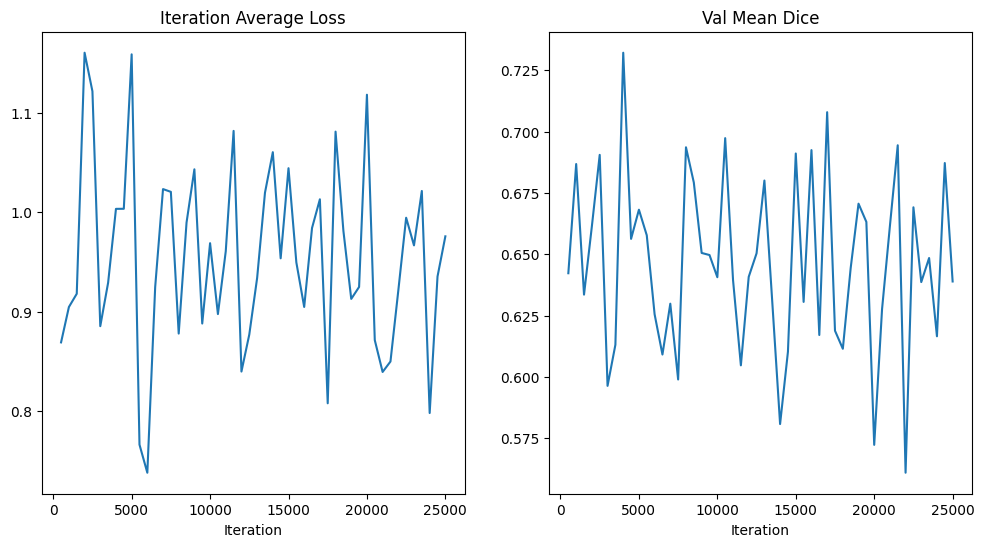

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [26]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=20, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]


In [25]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=48,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [27]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.72276): 100%|█| 24/24 [00:19<00:00,  1.21it/
Training (47 / 25000 Steps) (loss=1.32632): 100%|█| 24/24 [00:19<00:00,  1.21it/
Training (71 / 25000 Steps) (loss=0.78397): 100%|█| 24/24 [00:19<00:00,  1.21it/
Training (95 / 25000 Steps) (loss=0.91093): 100%|█| 24/24 [00:19<00:00,  1.20it/
Training (119 / 25000 Steps) (loss=0.97684): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (143 / 25000 Steps) (loss=0.88175): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (167 / 25000 Steps) (loss=0.84633): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (191 / 25000 Steps) (loss=0.79770): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (215 / 25000 Steps) (loss=0.70673): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (239 / 25000 Steps) (loss=1.01664): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (263 / 25000 Steps) (loss=0.69961): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (287 / 25000 Steps) (loss=0.86849): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.7109984755516052


Training (503 / 25000 Steps) (loss=0.76993): 100%|█| 24/24 [00:22<00:00,  1.06it
Training (527 / 25000 Steps) (loss=1.09534): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (551 / 25000 Steps) (loss=1.09631): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (575 / 25000 Steps) (loss=0.93396): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (599 / 25000 Steps) (loss=0.77321): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (623 / 25000 Steps) (loss=0.87416): 100%|█| 24/24 [00:19<00:00,  1.21it
Training (647 / 25000 Steps) (loss=0.99526): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (671 / 25000 Steps) (loss=0.70044): 100%|█| 24/24 [00:20<00:00,  1.19it
Training (695 / 25000 Steps) (loss=0.92681): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (719 / 25000 Steps) (loss=0.97090): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (743 / 25000 Steps) (loss=0.75024): 100%|█| 24/24 [00:19<00:00,  1.20it
Training (767 / 25000 Steps) (loss=0.71924): 100%|█| 24/24 [00:20<00:00,  1.20it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6516720652580261


Training (1007 / 25000 Steps) (loss=1.01062): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (1031 / 25000 Steps) (loss=0.81796): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1055 / 25000 Steps) (loss=1.04161): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1079 / 25000 Steps) (loss=1.64912): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1103 / 25000 Steps) (loss=0.77958): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1127 / 25000 Steps) (loss=0.84905): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1151 / 25000 Steps) (loss=0.85945): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1175 / 25000 Steps) (loss=0.74893): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1199 / 25000 Steps) (loss=0.93855): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1223 / 25000 Steps) (loss=0.94647): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1247 / 25000 Steps) (loss=0.75254): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1271 / 25000 Steps) (loss=0.82400): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.673926055431366


Training (1511 / 25000 Steps) (loss=0.80803): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (1535 / 25000 Steps) (loss=0.80903): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1559 / 25000 Steps) (loss=0.94297): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1583 / 25000 Steps) (loss=0.85613): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1607 / 25000 Steps) (loss=0.96052): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1631 / 25000 Steps) (loss=0.93844): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1655 / 25000 Steps) (loss=1.01185): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1679 / 25000 Steps) (loss=0.88752): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (1703 / 25000 Steps) (loss=0.84546): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1727 / 25000 Steps) (loss=0.91259): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (1751 / 25000 Steps) (loss=0.85437): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (1775 / 25000 Steps) (loss=0.72222): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6629727482795715


Training (2015 / 25000 Steps) (loss=1.02395): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (2039 / 25000 Steps) (loss=0.80478): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2063 / 25000 Steps) (loss=0.80744): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2087 / 25000 Steps) (loss=0.89279): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2111 / 25000 Steps) (loss=0.83450): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (2135 / 25000 Steps) (loss=1.40948): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2159 / 25000 Steps) (loss=0.82281): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2183 / 25000 Steps) (loss=0.84754): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (2207 / 25000 Steps) (loss=0.78727): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2231 / 25000 Steps) (loss=0.77691): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2255 / 25000 Steps) (loss=0.90018): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2279 / 25000 Steps) (loss=0.90728): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.5963773727416992


Training (2519 / 25000 Steps) (loss=0.73899): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (2543 / 25000 Steps) (loss=0.99854): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2567 / 25000 Steps) (loss=0.70739): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (2591 / 25000 Steps) (loss=0.88723): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (2615 / 25000 Steps) (loss=0.80517): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2639 / 25000 Steps) (loss=0.92147): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (2663 / 25000 Steps) (loss=0.85957): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2687 / 25000 Steps) (loss=0.57299): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (2711 / 25000 Steps) (loss=0.78788): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (2735 / 25000 Steps) (loss=0.81386): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2759 / 25000 Steps) (loss=0.91636): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (2783 / 25000 Steps) (loss=0.86445): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6195693612098694


Training (3023 / 25000 Steps) (loss=0.82696): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (3047 / 25000 Steps) (loss=0.77448): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3071 / 25000 Steps) (loss=0.77267): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (3095 / 25000 Steps) (loss=0.74991): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3119 / 25000 Steps) (loss=1.20002): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3143 / 25000 Steps) (loss=0.74292): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3167 / 25000 Steps) (loss=0.84900): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (3191 / 25000 Steps) (loss=1.18461): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3215 / 25000 Steps) (loss=1.14205): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (3239 / 25000 Steps) (loss=0.78515): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3263 / 25000 Steps) (loss=0.91493): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3287 / 25000 Steps) (loss=0.83463): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6450134515762329


Training (3503 / 25000 Steps) (loss=0.57444): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (3527 / 25000 Steps) (loss=1.18977): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3551 / 25000 Steps) (loss=0.79469): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (3575 / 25000 Steps) (loss=0.83727): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3599 / 25000 Steps) (loss=1.18853): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3623 / 25000 Steps) (loss=0.84361): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3647 / 25000 Steps) (loss=0.88612): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (3671 / 25000 Steps) (loss=0.82732): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3695 / 25000 Steps) (loss=0.95640): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3719 / 25000 Steps) (loss=0.76246): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (3743 / 25000 Steps) (loss=1.48231): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3767 / 25000 Steps) (loss=0.90638): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6379905939102173


Training (4007 / 25000 Steps) (loss=1.34956): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (4031 / 25000 Steps) (loss=0.90767): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4055 / 25000 Steps) (loss=0.83466): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4079 / 25000 Steps) (loss=0.79608): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (4103 / 25000 Steps) (loss=0.95177): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4127 / 25000 Steps) (loss=0.70357): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4151 / 25000 Steps) (loss=0.67107): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4175 / 25000 Steps) (loss=0.84735): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4199 / 25000 Steps) (loss=0.90517): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4223 / 25000 Steps) (loss=1.01059): 100%|█| 24/24 [00:20<00:00,  1.17i
Training (4247 / 25000 Steps) (loss=0.84053): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4271 / 25000 Steps) (loss=0.77160): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6836612820625305


Training (4511 / 25000 Steps) (loss=1.04402): 100%|█| 24/24 [00:22<00:00,  1.07i
Training (4535 / 25000 Steps) (loss=0.83876): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4559 / 25000 Steps) (loss=0.94252): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4583 / 25000 Steps) (loss=0.86709): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4607 / 25000 Steps) (loss=0.75234): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4631 / 25000 Steps) (loss=0.79530): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4655 / 25000 Steps) (loss=0.92146): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (4679 / 25000 Steps) (loss=0.83660): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (4703 / 25000 Steps) (loss=1.28012): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (4727 / 25000 Steps) (loss=0.87673): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4751 / 25000 Steps) (loss=0.93138): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4775 / 25000 Steps) (loss=0.76729): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6727145314216614


Training (5015 / 25000 Steps) (loss=1.04946): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (5039 / 25000 Steps) (loss=1.04522): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5063 / 25000 Steps) (loss=0.77080): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5087 / 25000 Steps) (loss=0.77196): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (5111 / 25000 Steps) (loss=0.78309): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5135 / 25000 Steps) (loss=0.67438): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5159 / 25000 Steps) (loss=0.79197): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5183 / 25000 Steps) (loss=0.88599): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5207 / 25000 Steps) (loss=0.90000): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (5231 / 25000 Steps) (loss=1.04269): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5255 / 25000 Steps) (loss=0.71157): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5279 / 25000 Steps) (loss=0.71335): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.698266327381134


Training (5519 / 25000 Steps) (loss=0.92664): 100%|█| 24/24 [00:22<00:00,  1.09i
Training (5543 / 25000 Steps) (loss=0.91284): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5567 / 25000 Steps) (loss=0.83953): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5591 / 25000 Steps) (loss=0.84595): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5615 / 25000 Steps) (loss=0.70241): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5639 / 25000 Steps) (loss=0.72850): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5663 / 25000 Steps) (loss=0.89645): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (5687 / 25000 Steps) (loss=0.80483): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5711 / 25000 Steps) (loss=1.00464): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5735 / 25000 Steps) (loss=0.83908): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (5759 / 25000 Steps) (loss=1.01591): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (5783 / 25000 Steps) (loss=0.85772): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6697268486022949


Training (6023 / 25000 Steps) (loss=0.67463): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (6047 / 25000 Steps) (loss=0.71211): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6071 / 25000 Steps) (loss=0.78903): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6095 / 25000 Steps) (loss=0.95489): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (6119 / 25000 Steps) (loss=0.75961): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6143 / 25000 Steps) (loss=0.96302): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6167 / 25000 Steps) (loss=0.82282): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6191 / 25000 Steps) (loss=0.82020): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6215 / 25000 Steps) (loss=1.10332): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (6239 / 25000 Steps) (loss=1.05169): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (6263 / 25000 Steps) (loss=0.75596): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6287 / 25000 Steps) (loss=0.86508): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.7096750140190125


Training (6503 / 25000 Steps) (loss=0.89228): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (6527 / 25000 Steps) (loss=0.77831): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (6551 / 25000 Steps) (loss=0.80519): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6575 / 25000 Steps) (loss=0.72028): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6599 / 25000 Steps) (loss=1.07186): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6623 / 25000 Steps) (loss=0.75983): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6647 / 25000 Steps) (loss=0.79039): 100%|█| 24/24 [00:20<00:00,  1.17i
Training (6671 / 25000 Steps) (loss=0.86727): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6695 / 25000 Steps) (loss=0.81748): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6719 / 25000 Steps) (loss=0.61654): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (6743 / 25000 Steps) (loss=0.76388): 100%|█| 24/24 [00:20<00:00,  1.16i
Training (6767 / 25000 Steps) (loss=1.02093): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.5978538990020752


Training (7007 / 25000 Steps) (loss=0.86595): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (7031 / 25000 Steps) (loss=1.15977): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7055 / 25000 Steps) (loss=0.80083): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7079 / 25000 Steps) (loss=1.17869): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7103 / 25000 Steps) (loss=1.08794): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7127 / 25000 Steps) (loss=1.04471): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (7151 / 25000 Steps) (loss=0.78123): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7175 / 25000 Steps) (loss=1.13066): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7199 / 25000 Steps) (loss=1.15893): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7223 / 25000 Steps) (loss=0.83220): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (7247 / 25000 Steps) (loss=1.68077): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7271 / 25000 Steps) (loss=0.80681): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6504241824150085


Training (7511 / 25000 Steps) (loss=0.67769): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (7535 / 25000 Steps) (loss=0.76333): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7559 / 25000 Steps) (loss=1.29180): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (7583 / 25000 Steps) (loss=0.90281): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7607 / 25000 Steps) (loss=0.99044): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (7631 / 25000 Steps) (loss=0.61719): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7655 / 25000 Steps) (loss=0.78908): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7679 / 25000 Steps) (loss=0.93719): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7703 / 25000 Steps) (loss=1.01177): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (7727 / 25000 Steps) (loss=0.90668): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7751 / 25000 Steps) (loss=0.77721): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (7775 / 25000 Steps) (loss=0.90862): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6463926434516907


Training (8015 / 25000 Steps) (loss=1.16524): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (8039 / 25000 Steps) (loss=0.78167): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8063 / 25000 Steps) (loss=1.26977): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8087 / 25000 Steps) (loss=0.80216): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8111 / 25000 Steps) (loss=0.87136): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8135 / 25000 Steps) (loss=0.97744): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8159 / 25000 Steps) (loss=0.98971): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8183 / 25000 Steps) (loss=0.87715): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8207 / 25000 Steps) (loss=1.08407): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8231 / 25000 Steps) (loss=0.77303): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8255 / 25000 Steps) (loss=0.89076): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8279 / 25000 Steps) (loss=0.76872): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6477915048599243


Training (8519 / 25000 Steps) (loss=0.80504): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (8543 / 25000 Steps) (loss=0.83166): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (8567 / 25000 Steps) (loss=0.85540): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8591 / 25000 Steps) (loss=0.82427): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8615 / 25000 Steps) (loss=1.42166): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8639 / 25000 Steps) (loss=1.51191): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (8663 / 25000 Steps) (loss=1.06514): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (8687 / 25000 Steps) (loss=0.74827): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8711 / 25000 Steps) (loss=1.25663): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8735 / 25000 Steps) (loss=0.75827): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8759 / 25000 Steps) (loss=0.95535): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (8783 / 25000 Steps) (loss=0.78774): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6459091305732727


Training (9023 / 25000 Steps) (loss=0.80837): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (9047 / 25000 Steps) (loss=0.83533): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9071 / 25000 Steps) (loss=0.89454): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9095 / 25000 Steps) (loss=0.92442): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9119 / 25000 Steps) (loss=0.79803): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9143 / 25000 Steps) (loss=0.75916): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9167 / 25000 Steps) (loss=1.05706): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9191 / 25000 Steps) (loss=0.85741): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9215 / 25000 Steps) (loss=0.80923): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9239 / 25000 Steps) (loss=0.82822): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9263 / 25000 Steps) (loss=1.36083): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9287 / 25000 Steps) (loss=0.97788): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.652401864528656


Training (9503 / 25000 Steps) (loss=1.02006): 100%|█| 24/24 [00:22<00:00,  1.08i
Training (9527 / 25000 Steps) (loss=0.86499): 100%|█| 24/24 [00:20<00:00,  1.17i
Training (9551 / 25000 Steps) (loss=0.80730): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9575 / 25000 Steps) (loss=0.82937): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9599 / 25000 Steps) (loss=0.68277): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9623 / 25000 Steps) (loss=0.94047): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9647 / 25000 Steps) (loss=0.88803): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9671 / 25000 Steps) (loss=0.85228): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9695 / 25000 Steps) (loss=0.87329): 100%|█| 24/24 [00:20<00:00,  1.19i
Training (9719 / 25000 Steps) (loss=0.65462): 100%|█| 24/24 [00:20<00:00,  1.20i
Training (9743 / 25000 Steps) (loss=0.79788): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9767 / 25000 Steps) (loss=0.72185): 100%|█| 24/24 [00:19<00:00,  1.20i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6945025324821472


Training (10007 / 25000 Steps) (loss=0.64210): 100%|█| 24/24 [00:22<00:00,  1.08
Training (10031 / 25000 Steps) (loss=1.37392): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10055 / 25000 Steps) (loss=0.88701): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10079 / 25000 Steps) (loss=0.74483): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10103 / 25000 Steps) (loss=0.81030): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10127 / 25000 Steps) (loss=0.82459): 100%|█| 24/24 [00:19<00:00,  1.21
Training (10151 / 25000 Steps) (loss=0.88584): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10175 / 25000 Steps) (loss=1.47429): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10199 / 25000 Steps) (loss=0.95906): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10223 / 25000 Steps) (loss=0.95999): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10247 / 25000 Steps) (loss=0.68351): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10271 / 25000 Steps) (loss=0.66485): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6808162331581116


Training (10511 / 25000 Steps) (loss=0.76474): 100%|█| 24/24 [00:22<00:00,  1.09
Training (10535 / 25000 Steps) (loss=1.41432): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10559 / 25000 Steps) (loss=0.69819): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10583 / 25000 Steps) (loss=0.97217): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10607 / 25000 Steps) (loss=0.68764): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10631 / 25000 Steps) (loss=1.04641): 100%|█| 24/24 [00:19<00:00,  1.20
Training (10655 / 25000 Steps) (loss=1.04230): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10679 / 25000 Steps) (loss=0.93341): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10703 / 25000 Steps) (loss=1.12290): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10727 / 25000 Steps) (loss=0.89510): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10751 / 25000 Steps) (loss=1.08172): 100%|█| 24/24 [00:20<00:00,  1.19
Training (10775 / 25000 Steps) (loss=1.05983): 100%|█| 24/24 [00:20<00:00,  1.20
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.5706251859664917


Training (11015 / 25000 Steps) (loss=1.16859): 100%|█| 24/24 [00:22<00:00,  1.08
Training (11039 / 25000 Steps) (loss=0.75565): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11063 / 25000 Steps) (loss=0.90907): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11087 / 25000 Steps) (loss=0.82962): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11111 / 25000 Steps) (loss=0.98910): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11135 / 25000 Steps) (loss=0.82327): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11159 / 25000 Steps) (loss=0.71403): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11183 / 25000 Steps) (loss=1.10333): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11207 / 25000 Steps) (loss=0.90425): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11231 / 25000 Steps) (loss=0.89523): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11255 / 25000 Steps) (loss=0.68126): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11279 / 25000 Steps) (loss=0.71429): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6374276280403137


Training (11519 / 25000 Steps) (loss=1.04947): 100%|█| 24/24 [00:22<00:00,  1.08
Training (11543 / 25000 Steps) (loss=0.87328): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11567 / 25000 Steps) (loss=0.89922): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11591 / 25000 Steps) (loss=1.16372): 100%|█| 24/24 [00:19<00:00,  1.20
Training (11615 / 25000 Steps) (loss=0.63680): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11639 / 25000 Steps) (loss=0.74234): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11663 / 25000 Steps) (loss=1.10733): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11687 / 25000 Steps) (loss=0.85537): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11711 / 25000 Steps) (loss=1.10377): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11735 / 25000 Steps) (loss=0.72535): 100%|█| 24/24 [00:20<00:00,  1.19
Training (11759 / 25000 Steps) (loss=0.81941): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11783 / 25000 Steps) (loss=1.01857): 100%|█| 24/24 [00:20<00:00,  1.20
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6227375864982605


Training (12023 / 25000 Steps) (loss=1.18010): 100%|█| 24/24 [00:22<00:00,  1.08
Training (12047 / 25000 Steps) (loss=1.46862): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12071 / 25000 Steps) (loss=0.92663): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12095 / 25000 Steps) (loss=0.85150): 100%|█| 24/24 [00:20<00:00,  1.18
Training (12119 / 25000 Steps) (loss=0.89998): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12143 / 25000 Steps) (loss=0.79471): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12167 / 25000 Steps) (loss=0.89530): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12191 / 25000 Steps) (loss=0.85507): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12215 / 25000 Steps) (loss=1.06940): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12239 / 25000 Steps) (loss=0.78982): 100%|█| 24/24 [00:19<00:00,  1.21
Training (12263 / 25000 Steps) (loss=0.84773): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12287 / 25000 Steps) (loss=1.08687): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6182838082313538


Training (12503 / 25000 Steps) (loss=0.60144): 100%|█| 24/24 [00:22<00:00,  1.08
Training (12527 / 25000 Steps) (loss=0.69946): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12551 / 25000 Steps) (loss=0.86192): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12575 / 25000 Steps) (loss=1.05351): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12599 / 25000 Steps) (loss=0.66775): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12623 / 25000 Steps) (loss=0.68995): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12647 / 25000 Steps) (loss=0.60752): 100%|█| 24/24 [00:19<00:00,  1.20
Training (12671 / 25000 Steps) (loss=0.83905): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12695 / 25000 Steps) (loss=0.78712): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12719 / 25000 Steps) (loss=0.90822): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12743 / 25000 Steps) (loss=0.91124): 100%|█| 24/24 [00:20<00:00,  1.20
Training (12767 / 25000 Steps) (loss=0.82401): 100%|█| 24/24 [00:20<00:00,  1.19
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.636660635471344


Training (13007 / 25000 Steps) (loss=0.81442): 100%|█| 24/24 [00:22<00:00,  1.08
Training (13031 / 25000 Steps) (loss=1.15552): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13055 / 25000 Steps) (loss=0.97460): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13079 / 25000 Steps) (loss=0.97414): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13103 / 25000 Steps) (loss=0.78777): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13127 / 25000 Steps) (loss=0.74033): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13151 / 25000 Steps) (loss=0.94029): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13175 / 25000 Steps) (loss=0.60930): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13199 / 25000 Steps) (loss=0.93404): 100%|█| 24/24 [00:19<00:00,  1.21
Training (13223 / 25000 Steps) (loss=0.76571): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13247 / 25000 Steps) (loss=0.80865): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13271 / 25000 Steps) (loss=1.03064): 100%|█| 24/24 [00:20<00:00,  1.17
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6001150608062744


Training (13511 / 25000 Steps) (loss=0.92341): 100%|█| 24/24 [00:22<00:00,  1.08
Training (13535 / 25000 Steps) (loss=0.84758): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13559 / 25000 Steps) (loss=0.95639): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13583 / 25000 Steps) (loss=1.02751): 100%|█| 24/24 [00:19<00:00,  1.20
Training (13607 / 25000 Steps) (loss=1.11427): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13631 / 25000 Steps) (loss=0.70127): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13655 / 25000 Steps) (loss=1.08023): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13679 / 25000 Steps) (loss=0.89251): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13703 / 25000 Steps) (loss=0.92541): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13727 / 25000 Steps) (loss=0.85287): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13751 / 25000 Steps) (loss=0.78813): 100%|█| 24/24 [00:20<00:00,  1.19
Training (13775 / 25000 Steps) (loss=0.80279): 100%|█| 24/24 [00:20<00:00,  1.20
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6124784350395203


Training (14015 / 25000 Steps) (loss=0.67390): 100%|█| 24/24 [00:22<00:00,  1.08
Training (14039 / 25000 Steps) (loss=1.08385): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14063 / 25000 Steps) (loss=0.77063): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14087 / 25000 Steps) (loss=0.83526): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14111 / 25000 Steps) (loss=1.02397): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14135 / 25000 Steps) (loss=1.01383): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14159 / 25000 Steps) (loss=0.75218): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14183 / 25000 Steps) (loss=0.86241): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14207 / 25000 Steps) (loss=0.89060): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14231 / 25000 Steps) (loss=1.03746): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14255 / 25000 Steps) (loss=0.87328): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14279 / 25000 Steps) (loss=0.95763): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6841480135917664


Training (14519 / 25000 Steps) (loss=1.23264): 100%|█| 24/24 [00:22<00:00,  1.08
Training (14543 / 25000 Steps) (loss=0.84346): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14567 / 25000 Steps) (loss=0.88771): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14591 / 25000 Steps) (loss=1.00375): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14615 / 25000 Steps) (loss=0.92193): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14639 / 25000 Steps) (loss=0.91856): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14663 / 25000 Steps) (loss=1.07423): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14687 / 25000 Steps) (loss=0.87794): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14711 / 25000 Steps) (loss=1.12841): 100%|█| 24/24 [00:20<00:00,  1.19
Training (14735 / 25000 Steps) (loss=0.72031): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14759 / 25000 Steps) (loss=0.95097): 100%|█| 24/24 [00:20<00:00,  1.20
Training (14783 / 25000 Steps) (loss=0.76645): 100%|█| 24/24 [00:19<00:00,  1.20
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.575958788394928


Training (15023 / 25000 Steps) (loss=0.78127): 100%|█| 24/24 [00:22<00:00,  1.08
Training (15047 / 25000 Steps) (loss=0.78441): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15071 / 25000 Steps) (loss=0.93525): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15095 / 25000 Steps) (loss=1.10794): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15119 / 25000 Steps) (loss=0.71853): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15143 / 25000 Steps) (loss=1.18678): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15167 / 25000 Steps) (loss=1.13075): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15191 / 25000 Steps) (loss=0.83595): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15215 / 25000 Steps) (loss=0.95775): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15239 / 25000 Steps) (loss=0.83517): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15263 / 25000 Steps) (loss=1.21377): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15287 / 25000 Steps) (loss=0.81613): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7109984755516052 Current Avg. Dice: 0.6230680346488953


Training (15503 / 25000 Steps) (loss=0.98356): 100%|█| 24/24 [00:22<00:00,  1.08
Training (15527 / 25000 Steps) (loss=0.80290): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15551 / 25000 Steps) (loss=0.81433): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15575 / 25000 Steps) (loss=0.81994): 100%|█| 24/24 [00:20<00:00,  1.19
Training (15599 / 25000 Steps) (loss=0.72466): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15623 / 25000 Steps) (loss=0.97251): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15647 / 25000 Steps) (loss=0.99324): 100%|█| 24/24 [00:19<00:00,  1.21
Training (15671 / 25000 Steps) (loss=0.77229): 100%|█| 24/24 [00:20<00:00,  1.20
Training (15695 / 25000 Steps) (loss=0.90274): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15719 / 25000 Steps) (loss=0.78869): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15743 / 25000 Steps) (loss=0.71720): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15767 / 25000 Steps) (loss=0.94418): 100%|█| 24/24 [00:19<00:00,  1.20
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.7427266240119934


Training (16007 / 25000 Steps) (loss=1.05505): 100%|█| 24/24 [00:22<00:00,  1.05
Training (16031 / 25000 Steps) (loss=0.72331): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16055 / 25000 Steps) (loss=1.17437): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16079 / 25000 Steps) (loss=0.86306): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16103 / 25000 Steps) (loss=0.95492): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16127 / 25000 Steps) (loss=1.04099): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16151 / 25000 Steps) (loss=0.79310): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16175 / 25000 Steps) (loss=0.90314): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16199 / 25000 Steps) (loss=0.86946): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16223 / 25000 Steps) (loss=0.77067): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16247 / 25000 Steps) (loss=0.94397): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16271 / 25000 Steps) (loss=1.00403): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6333405375480652


Training (16511 / 25000 Steps) (loss=0.91484): 100%|█| 24/24 [00:22<00:00,  1.07
Training (16535 / 25000 Steps) (loss=1.05478): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16559 / 25000 Steps) (loss=0.94629): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16583 / 25000 Steps) (loss=0.80458): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16607 / 25000 Steps) (loss=0.74892): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16631 / 25000 Steps) (loss=1.08294): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16655 / 25000 Steps) (loss=0.81261): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16679 / 25000 Steps) (loss=0.69716): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16703 / 25000 Steps) (loss=0.84665): 100%|█| 24/24 [00:20<00:00,  1.19
Training (16727 / 25000 Steps) (loss=0.86152): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16751 / 25000 Steps) (loss=0.84475): 100%|█| 24/24 [00:20<00:00,  1.20
Training (16775 / 25000 Steps) (loss=0.63209): 100%|█| 24/24 [00:19<00:00,  1.20
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.7104409337043762


Training (17015 / 25000 Steps) (loss=1.02251): 100%|█| 24/24 [00:22<00:00,  1.08
Training (17039 / 25000 Steps) (loss=0.82558): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17063 / 25000 Steps) (loss=0.76885): 100%|█| 24/24 [00:20<00:00,  1.19
Training (17087 / 25000 Steps) (loss=0.77203): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17111 / 25000 Steps) (loss=1.33478): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17135 / 25000 Steps) (loss=0.77047): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17159 / 25000 Steps) (loss=0.83321): 100%|█| 24/24 [00:20<00:00,  1.19
Training (17183 / 25000 Steps) (loss=0.76996): 100%|█| 24/24 [00:19<00:00,  1.21
Training (17207 / 25000 Steps) (loss=1.06406): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17231 / 25000 Steps) (loss=0.87177): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17255 / 25000 Steps) (loss=1.18078): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17279 / 25000 Steps) (loss=0.79134): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.5557999014854431


Training (17519 / 25000 Steps) (loss=1.22339): 100%|█| 24/24 [00:22<00:00,  1.08
Training (17543 / 25000 Steps) (loss=0.85375): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17567 / 25000 Steps) (loss=1.12432): 100%|█| 24/24 [00:20<00:00,  1.19
Training (17591 / 25000 Steps) (loss=0.76351): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17615 / 25000 Steps) (loss=1.77356): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17639 / 25000 Steps) (loss=0.80944): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17663 / 25000 Steps) (loss=0.85514): 100%|█| 24/24 [00:20<00:00,  1.19
Training (17687 / 25000 Steps) (loss=0.87849): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17711 / 25000 Steps) (loss=0.69532): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17735 / 25000 Steps) (loss=0.89547): 100%|█| 24/24 [00:20<00:00,  1.20
Training (17759 / 25000 Steps) (loss=0.78801): 100%|█| 24/24 [00:20<00:00,  1.19
Training (17783 / 25000 Steps) (loss=1.27211): 100%|█| 24/24 [00:19<00:00,  1.20
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.688066303730011


Training (18023 / 25000 Steps) (loss=0.75235): 100%|█| 24/24 [00:22<00:00,  1.09
Training (18047 / 25000 Steps) (loss=1.38538): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18071 / 25000 Steps) (loss=0.80718): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18095 / 25000 Steps) (loss=0.85192): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18119 / 25000 Steps) (loss=0.85327): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18143 / 25000 Steps) (loss=0.81070): 100%|█| 24/24 [00:20<00:00,  1.19
Training (18167 / 25000 Steps) (loss=0.78766): 100%|█| 24/24 [00:19<00:00,  1.21
Training (18191 / 25000 Steps) (loss=1.06815): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18215 / 25000 Steps) (loss=0.70281): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18239 / 25000 Steps) (loss=0.99452): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18263 / 25000 Steps) (loss=1.07503): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18287 / 25000 Steps) (loss=0.88990): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6964125633239746


Training (18503 / 25000 Steps) (loss=0.90242): 100%|█| 24/24 [00:22<00:00,  1.08
Training (18527 / 25000 Steps) (loss=0.72071): 100%|█| 24/24 [00:20<00:00,  1.19
Training (18551 / 25000 Steps) (loss=1.07096): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18575 / 25000 Steps) (loss=0.82197): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18599 / 25000 Steps) (loss=0.79299): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18623 / 25000 Steps) (loss=0.74687): 100%|█| 24/24 [00:20<00:00,  1.19
Training (18647 / 25000 Steps) (loss=0.92321): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18671 / 25000 Steps) (loss=0.62097): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18695 / 25000 Steps) (loss=0.77973): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18719 / 25000 Steps) (loss=1.05882): 100%|█| 24/24 [00:20<00:00,  1.20
Training (18743 / 25000 Steps) (loss=0.85728): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18767 / 25000 Steps) (loss=1.13610): 100%|█| 24/24 [00:19<00:00,  1.20
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6586979031562805


Training (19007 / 25000 Steps) (loss=0.85277): 100%|█| 24/24 [00:22<00:00,  1.08
Training (19031 / 25000 Steps) (loss=1.08371): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19055 / 25000 Steps) (loss=1.06604): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19079 / 25000 Steps) (loss=1.01499): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19103 / 25000 Steps) (loss=0.86002): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19127 / 25000 Steps) (loss=0.83338): 100%|█| 24/24 [00:19<00:00,  1.21
Training (19151 / 25000 Steps) (loss=1.02860): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19175 / 25000 Steps) (loss=0.77881): 100%|█| 24/24 [00:19<00:00,  1.21
Training (19199 / 25000 Steps) (loss=0.91638): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19223 / 25000 Steps) (loss=0.85871): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19247 / 25000 Steps) (loss=0.98407): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19271 / 25000 Steps) (loss=1.25998): 100%|█| 24/24 [00:20<00:00,  1.19
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6413393616676331


Training (19511 / 25000 Steps) (loss=0.66884): 100%|█| 24/24 [00:22<00:00,  1.08
Training (19535 / 25000 Steps) (loss=0.78194): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19559 / 25000 Steps) (loss=0.76295): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19583 / 25000 Steps) (loss=0.74771): 100%|█| 24/24 [00:20<00:00,  1.19
Training (19607 / 25000 Steps) (loss=0.70868): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19631 / 25000 Steps) (loss=1.03090): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19655 / 25000 Steps) (loss=0.84631): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19679 / 25000 Steps) (loss=0.92569): 100%|█| 24/24 [00:19<00:00,  1.20
Training (19703 / 25000 Steps) (loss=0.78574): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19727 / 25000 Steps) (loss=0.81909): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19751 / 25000 Steps) (loss=0.91350): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19775 / 25000 Steps) (loss=0.90562): 100%|█| 24/24 [00:20<00:00,  1.20
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6297589540481567


Training (20015 / 25000 Steps) (loss=0.95386): 100%|█| 24/24 [00:22<00:00,  1.08
Training (20039 / 25000 Steps) (loss=0.78665): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20063 / 25000 Steps) (loss=0.75294): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20087 / 25000 Steps) (loss=0.79203): 100%|█| 24/24 [00:20<00:00,  1.19
Training (20111 / 25000 Steps) (loss=1.18508): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20135 / 25000 Steps) (loss=0.53626): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20159 / 25000 Steps) (loss=0.97182): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20183 / 25000 Steps) (loss=0.76684): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20207 / 25000 Steps) (loss=0.84251): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20231 / 25000 Steps) (loss=0.90161): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20255 / 25000 Steps) (loss=0.78522): 100%|█| 24/24 [00:20<00:00,  1.19
Training (20279 / 25000 Steps) (loss=0.87563): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6641208529472351


Training (20519 / 25000 Steps) (loss=0.73658): 100%|█| 24/24 [00:22<00:00,  1.08
Training (20543 / 25000 Steps) (loss=0.84273): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20567 / 25000 Steps) (loss=0.73038): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20591 / 25000 Steps) (loss=0.76993): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20615 / 25000 Steps) (loss=0.84786): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20639 / 25000 Steps) (loss=0.84627): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20663 / 25000 Steps) (loss=0.94949): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20687 / 25000 Steps) (loss=0.85872): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20711 / 25000 Steps) (loss=0.94286): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20735 / 25000 Steps) (loss=0.65307): 100%|█| 24/24 [00:19<00:00,  1.20
Training (20759 / 25000 Steps) (loss=0.80809): 100%|█| 24/24 [00:20<00:00,  1.20
Training (20783 / 25000 Steps) (loss=0.85572): 100%|█| 24/24 [00:20<00:00,  1.19
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.7412326335906982


Training (21023 / 25000 Steps) (loss=0.87273): 100%|█| 24/24 [00:22<00:00,  1.08
Training (21047 / 25000 Steps) (loss=0.67830): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21071 / 25000 Steps) (loss=0.81990): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21095 / 25000 Steps) (loss=0.79581): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21119 / 25000 Steps) (loss=0.90879): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21143 / 25000 Steps) (loss=0.91037): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21167 / 25000 Steps) (loss=1.14610): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21191 / 25000 Steps) (loss=0.78942): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21215 / 25000 Steps) (loss=0.67764): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21239 / 25000 Steps) (loss=0.74883): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21263 / 25000 Steps) (loss=1.10254): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21287 / 25000 Steps) (loss=0.65354): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6313194036483765


Training (21503 / 25000 Steps) (loss=0.63216): 100%|█| 24/24 [00:22<00:00,  1.08
Training (21527 / 25000 Steps) (loss=0.66207): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21551 / 25000 Steps) (loss=0.75009): 100%|█| 24/24 [00:20<00:00,  1.19
Training (21575 / 25000 Steps) (loss=0.88114): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21599 / 25000 Steps) (loss=0.72912): 100%|█| 24/24 [00:19<00:00,  1.21
Training (21623 / 25000 Steps) (loss=0.97921): 100%|█| 24/24 [00:19<00:00,  1.21
Training (21647 / 25000 Steps) (loss=0.94761): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21671 / 25000 Steps) (loss=1.02145): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21695 / 25000 Steps) (loss=0.81951): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21719 / 25000 Steps) (loss=0.78339): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21743 / 25000 Steps) (loss=0.83433): 100%|█| 24/24 [00:20<00:00,  1.20
Training (21767 / 25000 Steps) (loss=1.03299): 100%|█| 24/24 [00:19<00:00,  1.20
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6026322841644287


Training (22007 / 25000 Steps) (loss=0.82182): 100%|█| 24/24 [00:22<00:00,  1.08
Training (22031 / 25000 Steps) (loss=0.90623): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22055 / 25000 Steps) (loss=0.69781): 100%|█| 24/24 [00:19<00:00,  1.21
Training (22079 / 25000 Steps) (loss=0.81546): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22103 / 25000 Steps) (loss=0.60608): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22127 / 25000 Steps) (loss=0.86357): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22151 / 25000 Steps) (loss=0.93833): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22175 / 25000 Steps) (loss=0.98522): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22199 / 25000 Steps) (loss=0.81127): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22223 / 25000 Steps) (loss=0.92985): 100%|█| 24/24 [00:20<00:00,  1.18
Training (22247 / 25000 Steps) (loss=0.94255): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22271 / 25000 Steps) (loss=0.77697): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.5958187580108643


Training (22511 / 25000 Steps) (loss=0.71677): 100%|█| 24/24 [00:22<00:00,  1.07
Training (22535 / 25000 Steps) (loss=0.64594): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22559 / 25000 Steps) (loss=0.78949): 100%|█| 24/24 [00:19<00:00,  1.21
Training (22583 / 25000 Steps) (loss=0.66429): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22607 / 25000 Steps) (loss=0.97236): 100%|█| 24/24 [00:20<00:00,  1.20
Training (22631 / 25000 Steps) (loss=0.85408): 100%|█| 24/24 [00:19<00:00,  1.20
Training (22655 / 25000 Steps) (loss=0.68534): 100%|█| 24/24 [00:19<00:00,  1.21
Training (22679 / 25000 Steps) (loss=1.00751): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22703 / 25000 Steps) (loss=1.14381): 100%|█| 24/24 [00:20<00:00,  1.18
Training (22727 / 25000 Steps) (loss=0.66337): 100%|█| 24/24 [00:20<00:00,  1.18
Training (22751 / 25000 Steps) (loss=0.77778): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22775 / 25000 Steps) (loss=0.94842): 100%|█| 24/24 [00:20<00:00,  1.19
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6650657653808594


Training (23015 / 25000 Steps) (loss=0.90522): 100%|█| 24/24 [00:22<00:00,  1.08
Training (23039 / 25000 Steps) (loss=0.84544): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23063 / 25000 Steps) (loss=0.56455): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23087 / 25000 Steps) (loss=0.83529): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23111 / 25000 Steps) (loss=0.91073): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23135 / 25000 Steps) (loss=0.75608): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23159 / 25000 Steps) (loss=0.98021): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23183 / 25000 Steps) (loss=0.99923): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23207 / 25000 Steps) (loss=1.05009): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23231 / 25000 Steps) (loss=0.83022): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23255 / 25000 Steps) (loss=0.94251): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23279 / 25000 Steps) (loss=0.85624): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6713423728942871


Training (23519 / 25000 Steps) (loss=0.96995): 100%|█| 24/24 [00:22<00:00,  1.08
Training (23543 / 25000 Steps) (loss=0.65966): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23567 / 25000 Steps) (loss=0.91179): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23591 / 25000 Steps) (loss=1.16998): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23615 / 25000 Steps) (loss=0.92711): 100%|█| 24/24 [00:19<00:00,  1.20
Training (23639 / 25000 Steps) (loss=0.84247): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23663 / 25000 Steps) (loss=0.83427): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23687 / 25000 Steps) (loss=0.82827): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23711 / 25000 Steps) (loss=1.04255): 100%|█| 24/24 [00:20<00:00,  1.19
Training (23735 / 25000 Steps) (loss=0.80533): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23759 / 25000 Steps) (loss=0.74989): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23783 / 25000 Steps) (loss=0.81858): 100%|█| 24/24 [00:20<00:00,  1.20
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6378555297851562


Training (24023 / 25000 Steps) (loss=0.92387): 100%|█| 24/24 [00:22<00:00,  1.08
Training (24047 / 25000 Steps) (loss=0.78079): 100%|█| 24/24 [00:19<00:00,  1.20
Training (24071 / 25000 Steps) (loss=1.14990): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24095 / 25000 Steps) (loss=0.85760): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24119 / 25000 Steps) (loss=1.14488): 100%|█| 24/24 [00:20<00:00,  1.18
Training (24143 / 25000 Steps) (loss=0.96892): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24167 / 25000 Steps) (loss=0.74557): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24191 / 25000 Steps) (loss=0.68809): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24215 / 25000 Steps) (loss=1.05294): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24239 / 25000 Steps) (loss=0.76787): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24263 / 25000 Steps) (loss=0.74863): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24287 / 25000 Steps) (loss=0.98166): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6404569745063782


Training (24503 / 25000 Steps) (loss=0.72451): 100%|█| 24/24 [00:22<00:00,  1.07
Training (24527 / 25000 Steps) (loss=0.90207): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24551 / 25000 Steps) (loss=0.96544): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24575 / 25000 Steps) (loss=0.74713): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24599 / 25000 Steps) (loss=1.05467): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24623 / 25000 Steps) (loss=0.69581): 100%|█| 24/24 [00:20<00:00,  1.16
Training (24647 / 25000 Steps) (loss=1.07533): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24671 / 25000 Steps) (loss=0.89119): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24695 / 25000 Steps) (loss=0.64772): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24719 / 25000 Steps) (loss=0.79367): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24743 / 25000 Steps) (loss=0.78427): 100%|█| 24/24 [00:20<00:00,  1.20
Training (24767 / 25000 Steps) (loss=0.79483): 100%|█| 24/24 [00:20<00:00,  1.19
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427266240119934 Current Avg. Dice: 0.6826534867286682


Training (25007 / 25000 Steps) (loss=0.80584): 100%|█| 24/24 [00:22<00:00,  1.08


<All keys matched successfully>

In [28]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7427 at iteration: 16000


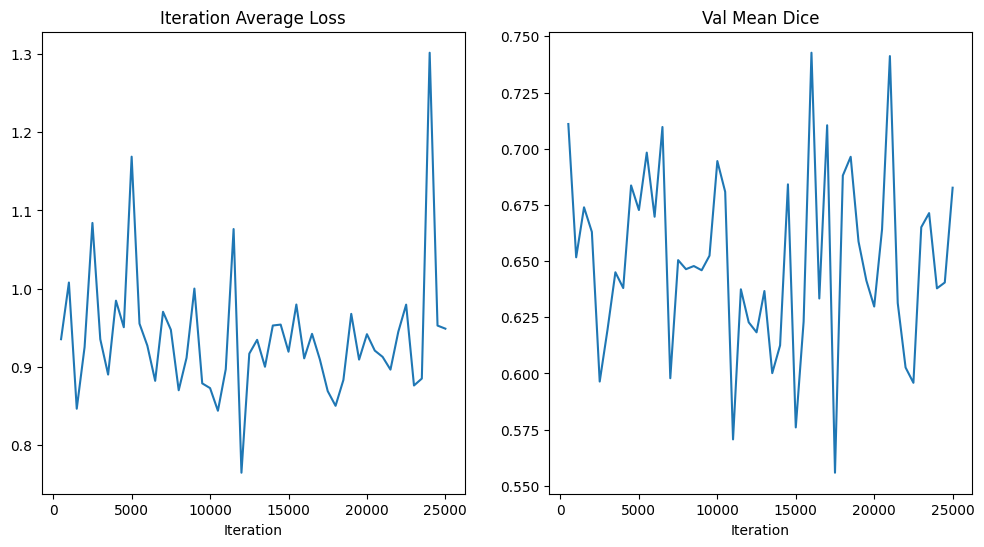

In [29]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.10it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        print(x.shape)
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "dwtunetr_pretrainonwordfinetuneonmiccai_fold4_best_metric_model.pth")))

RuntimeError: Error(s) in loading state_dict for UNETR:
	Missing key(s) in state_dict: "vit.patch_embedding.position_embeddings", "vit.patch_embedding.patch_embeddings.1.weight", "vit.patch_embedding.patch_embeddings.1.bias", "vit.blocks.0.mlp.linear1.weight", "vit.blocks.0.mlp.linear1.bias", "vit.blocks.0.mlp.linear2.weight", "vit.blocks.0.mlp.linear2.bias", "vit.blocks.0.norm1.weight", "vit.blocks.0.norm1.bias", "vit.blocks.0.attn.reduce.0.weight", "vit.blocks.0.attn.reduce.0.bias", "vit.blocks.0.attn.reduce.1.weight", "vit.blocks.0.attn.reduce.1.bias", "vit.blocks.0.attn.reduce.1.running_mean", "vit.blocks.0.attn.reduce.1.running_var", "vit.blocks.0.attn.filter.0.weight", "vit.blocks.0.attn.filter.0.bias", "vit.blocks.0.attn.filter.1.weight", "vit.blocks.0.attn.filter.1.bias", "vit.blocks.0.attn.filter.1.running_mean", "vit.blocks.0.attn.filter.1.running_var", "vit.blocks.0.attn.kv_embed.weight", "vit.blocks.0.attn.kv_embed.bias", "vit.blocks.0.attn.q.weight", "vit.blocks.0.attn.q.bias", "vit.blocks.0.attn.kv.0.weight", "vit.blocks.0.attn.kv.0.bias", "vit.blocks.0.attn.kv.1.weight", "vit.blocks.0.attn.kv.1.bias", "vit.blocks.0.attn.proj.weight", "vit.blocks.0.attn.proj.bias", "vit.blocks.0.norm2.weight", "vit.blocks.0.norm2.bias", "vit.blocks.1.mlp.linear1.weight", "vit.blocks.1.mlp.linear1.bias", "vit.blocks.1.mlp.linear2.weight", "vit.blocks.1.mlp.linear2.bias", "vit.blocks.1.norm1.weight", "vit.blocks.1.norm1.bias", "vit.blocks.1.attn.reduce.0.weight", "vit.blocks.1.attn.reduce.0.bias", "vit.blocks.1.attn.reduce.1.weight", "vit.blocks.1.attn.reduce.1.bias", "vit.blocks.1.attn.reduce.1.running_mean", "vit.blocks.1.attn.reduce.1.running_var", "vit.blocks.1.attn.filter.0.weight", "vit.blocks.1.attn.filter.0.bias", "vit.blocks.1.attn.filter.1.weight", "vit.blocks.1.attn.filter.1.bias", "vit.blocks.1.attn.filter.1.running_mean", "vit.blocks.1.attn.filter.1.running_var", "vit.blocks.1.attn.kv_embed.weight", "vit.blocks.1.attn.kv_embed.bias", "vit.blocks.1.attn.q.weight", "vit.blocks.1.attn.q.bias", "vit.blocks.1.attn.kv.0.weight", "vit.blocks.1.attn.kv.0.bias", "vit.blocks.1.attn.kv.1.weight", "vit.blocks.1.attn.kv.1.bias", "vit.blocks.1.attn.proj.weight", "vit.blocks.1.attn.proj.bias", "vit.blocks.1.norm2.weight", "vit.blocks.1.norm2.bias", "vit.blocks.2.mlp.linear1.weight", "vit.blocks.2.mlp.linear1.bias", "vit.blocks.2.mlp.linear2.weight", "vit.blocks.2.mlp.linear2.bias", "vit.blocks.2.norm1.weight", "vit.blocks.2.norm1.bias", "vit.blocks.2.attn.reduce.0.weight", "vit.blocks.2.attn.reduce.0.bias", "vit.blocks.2.attn.reduce.1.weight", "vit.blocks.2.attn.reduce.1.bias", "vit.blocks.2.attn.reduce.1.running_mean", "vit.blocks.2.attn.reduce.1.running_var", "vit.blocks.2.attn.filter.0.weight", "vit.blocks.2.attn.filter.0.bias", "vit.blocks.2.attn.filter.1.weight", "vit.blocks.2.attn.filter.1.bias", "vit.blocks.2.attn.filter.1.running_mean", "vit.blocks.2.attn.filter.1.running_var", "vit.blocks.2.attn.kv_embed.weight", "vit.blocks.2.attn.kv_embed.bias", "vit.blocks.2.attn.q.weight", "vit.blocks.2.attn.q.bias", "vit.blocks.2.attn.kv.0.weight", "vit.blocks.2.attn.kv.0.bias", "vit.blocks.2.attn.kv.1.weight", "vit.blocks.2.attn.kv.1.bias", "vit.blocks.2.attn.proj.weight", "vit.blocks.2.attn.proj.bias", "vit.blocks.2.norm2.weight", "vit.blocks.2.norm2.bias", "vit.blocks.3.mlp.linear1.weight", "vit.blocks.3.mlp.linear1.bias", "vit.blocks.3.mlp.linear2.weight", "vit.blocks.3.mlp.linear2.bias", "vit.blocks.3.norm1.weight", "vit.blocks.3.norm1.bias", "vit.blocks.3.attn.reduce.0.weight", "vit.blocks.3.attn.reduce.0.bias", "vit.blocks.3.attn.reduce.1.weight", "vit.blocks.3.attn.reduce.1.bias", "vit.blocks.3.attn.reduce.1.running_mean", "vit.blocks.3.attn.reduce.1.running_var", "vit.blocks.3.attn.filter.0.weight", "vit.blocks.3.attn.filter.0.bias", "vit.blocks.3.attn.filter.1.weight", "vit.blocks.3.attn.filter.1.bias", "vit.blocks.3.attn.filter.1.running_mean", "vit.blocks.3.attn.filter.1.running_var", "vit.blocks.3.attn.kv_embed.weight", "vit.blocks.3.attn.kv_embed.bias", "vit.blocks.3.attn.q.weight", "vit.blocks.3.attn.q.bias", "vit.blocks.3.attn.kv.0.weight", "vit.blocks.3.attn.kv.0.bias", "vit.blocks.3.attn.kv.1.weight", "vit.blocks.3.attn.kv.1.bias", "vit.blocks.3.attn.proj.weight", "vit.blocks.3.attn.proj.bias", "vit.blocks.3.norm2.weight", "vit.blocks.3.norm2.bias", "vit.blocks.4.mlp.linear1.weight", "vit.blocks.4.mlp.linear1.bias", "vit.blocks.4.mlp.linear2.weight", "vit.blocks.4.mlp.linear2.bias", "vit.blocks.4.norm1.weight", "vit.blocks.4.norm1.bias", "vit.blocks.4.attn.reduce.0.weight", "vit.blocks.4.attn.reduce.0.bias", "vit.blocks.4.attn.reduce.1.weight", "vit.blocks.4.attn.reduce.1.bias", "vit.blocks.4.attn.reduce.1.running_mean", "vit.blocks.4.attn.reduce.1.running_var", "vit.blocks.4.attn.filter.0.weight", "vit.blocks.4.attn.filter.0.bias", "vit.blocks.4.attn.filter.1.weight", "vit.blocks.4.attn.filter.1.bias", "vit.blocks.4.attn.filter.1.running_mean", "vit.blocks.4.attn.filter.1.running_var", "vit.blocks.4.attn.kv_embed.weight", "vit.blocks.4.attn.kv_embed.bias", "vit.blocks.4.attn.q.weight", "vit.blocks.4.attn.q.bias", "vit.blocks.4.attn.kv.0.weight", "vit.blocks.4.attn.kv.0.bias", "vit.blocks.4.attn.kv.1.weight", "vit.blocks.4.attn.kv.1.bias", "vit.blocks.4.attn.proj.weight", "vit.blocks.4.attn.proj.bias", "vit.blocks.4.norm2.weight", "vit.blocks.4.norm2.bias", "vit.blocks.5.mlp.linear1.weight", "vit.blocks.5.mlp.linear1.bias", "vit.blocks.5.mlp.linear2.weight", "vit.blocks.5.mlp.linear2.bias", "vit.blocks.5.norm1.weight", "vit.blocks.5.norm1.bias", "vit.blocks.5.attn.reduce.0.weight", "vit.blocks.5.attn.reduce.0.bias", "vit.blocks.5.attn.reduce.1.weight", "vit.blocks.5.attn.reduce.1.bias", "vit.blocks.5.attn.reduce.1.running_mean", "vit.blocks.5.attn.reduce.1.running_var", "vit.blocks.5.attn.filter.0.weight", "vit.blocks.5.attn.filter.0.bias", "vit.blocks.5.attn.filter.1.weight", "vit.blocks.5.attn.filter.1.bias", "vit.blocks.5.attn.filter.1.running_mean", "vit.blocks.5.attn.filter.1.running_var", "vit.blocks.5.attn.kv_embed.weight", "vit.blocks.5.attn.kv_embed.bias", "vit.blocks.5.attn.q.weight", "vit.blocks.5.attn.q.bias", "vit.blocks.5.attn.kv.0.weight", "vit.blocks.5.attn.kv.0.bias", "vit.blocks.5.attn.kv.1.weight", "vit.blocks.5.attn.kv.1.bias", "vit.blocks.5.attn.proj.weight", "vit.blocks.5.attn.proj.bias", "vit.blocks.5.norm2.weight", "vit.blocks.5.norm2.bias", "vit.blocks.6.mlp.linear1.weight", "vit.blocks.6.mlp.linear1.bias", "vit.blocks.6.mlp.linear2.weight", "vit.blocks.6.mlp.linear2.bias", "vit.blocks.6.norm1.weight", "vit.blocks.6.norm1.bias", "vit.blocks.6.attn.reduce.0.weight", "vit.blocks.6.attn.reduce.0.bias", "vit.blocks.6.attn.reduce.1.weight", "vit.blocks.6.attn.reduce.1.bias", "vit.blocks.6.attn.reduce.1.running_mean", "vit.blocks.6.attn.reduce.1.running_var", "vit.blocks.6.attn.filter.0.weight", "vit.blocks.6.attn.filter.0.bias", "vit.blocks.6.attn.filter.1.weight", "vit.blocks.6.attn.filter.1.bias", "vit.blocks.6.attn.filter.1.running_mean", "vit.blocks.6.attn.filter.1.running_var", "vit.blocks.6.attn.kv_embed.weight", "vit.blocks.6.attn.kv_embed.bias", "vit.blocks.6.attn.q.weight", "vit.blocks.6.attn.q.bias", "vit.blocks.6.attn.kv.0.weight", "vit.blocks.6.attn.kv.0.bias", "vit.blocks.6.attn.kv.1.weight", "vit.blocks.6.attn.kv.1.bias", "vit.blocks.6.attn.proj.weight", "vit.blocks.6.attn.proj.bias", "vit.blocks.6.norm2.weight", "vit.blocks.6.norm2.bias", "vit.blocks.7.mlp.linear1.weight", "vit.blocks.7.mlp.linear1.bias", "vit.blocks.7.mlp.linear2.weight", "vit.blocks.7.mlp.linear2.bias", "vit.blocks.7.norm1.weight", "vit.blocks.7.norm1.bias", "vit.blocks.7.attn.reduce.0.weight", "vit.blocks.7.attn.reduce.0.bias", "vit.blocks.7.attn.reduce.1.weight", "vit.blocks.7.attn.reduce.1.bias", "vit.blocks.7.attn.reduce.1.running_mean", "vit.blocks.7.attn.reduce.1.running_var", "vit.blocks.7.attn.filter.0.weight", "vit.blocks.7.attn.filter.0.bias", "vit.blocks.7.attn.filter.1.weight", "vit.blocks.7.attn.filter.1.bias", "vit.blocks.7.attn.filter.1.running_mean", "vit.blocks.7.attn.filter.1.running_var", "vit.blocks.7.attn.kv_embed.weight", "vit.blocks.7.attn.kv_embed.bias", "vit.blocks.7.attn.q.weight", "vit.blocks.7.attn.q.bias", "vit.blocks.7.attn.kv.0.weight", "vit.blocks.7.attn.kv.0.bias", "vit.blocks.7.attn.kv.1.weight", "vit.blocks.7.attn.kv.1.bias", "vit.blocks.7.attn.proj.weight", "vit.blocks.7.attn.proj.bias", "vit.blocks.7.norm2.weight", "vit.blocks.7.norm2.bias", "vit.blocks.8.mlp.linear1.weight", "vit.blocks.8.mlp.linear1.bias", "vit.blocks.8.mlp.linear2.weight", "vit.blocks.8.mlp.linear2.bias", "vit.blocks.8.norm1.weight", "vit.blocks.8.norm1.bias", "vit.blocks.8.attn.reduce.0.weight", "vit.blocks.8.attn.reduce.0.bias", "vit.blocks.8.attn.reduce.1.weight", "vit.blocks.8.attn.reduce.1.bias", "vit.blocks.8.attn.reduce.1.running_mean", "vit.blocks.8.attn.reduce.1.running_var", "vit.blocks.8.attn.filter.0.weight", "vit.blocks.8.attn.filter.0.bias", "vit.blocks.8.attn.filter.1.weight", "vit.blocks.8.attn.filter.1.bias", "vit.blocks.8.attn.filter.1.running_mean", "vit.blocks.8.attn.filter.1.running_var", "vit.blocks.8.attn.kv_embed.weight", "vit.blocks.8.attn.kv_embed.bias", "vit.blocks.8.attn.q.weight", "vit.blocks.8.attn.q.bias", "vit.blocks.8.attn.kv.0.weight", "vit.blocks.8.attn.kv.0.bias", "vit.blocks.8.attn.kv.1.weight", "vit.blocks.8.attn.kv.1.bias", "vit.blocks.8.attn.proj.weight", "vit.blocks.8.attn.proj.bias", "vit.blocks.8.norm2.weight", "vit.blocks.8.norm2.bias", "vit.blocks.9.mlp.linear1.weight", "vit.blocks.9.mlp.linear1.bias", "vit.blocks.9.mlp.linear2.weight", "vit.blocks.9.mlp.linear2.bias", "vit.blocks.9.norm1.weight", "vit.blocks.9.norm1.bias", "vit.blocks.9.attn.reduce.0.weight", "vit.blocks.9.attn.reduce.0.bias", "vit.blocks.9.attn.reduce.1.weight", "vit.blocks.9.attn.reduce.1.bias", "vit.blocks.9.attn.reduce.1.running_mean", "vit.blocks.9.attn.reduce.1.running_var", "vit.blocks.9.attn.filter.0.weight", "vit.blocks.9.attn.filter.0.bias", "vit.blocks.9.attn.filter.1.weight", "vit.blocks.9.attn.filter.1.bias", "vit.blocks.9.attn.filter.1.running_mean", "vit.blocks.9.attn.filter.1.running_var", "vit.blocks.9.attn.kv_embed.weight", "vit.blocks.9.attn.kv_embed.bias", "vit.blocks.9.attn.q.weight", "vit.blocks.9.attn.q.bias", "vit.blocks.9.attn.kv.0.weight", "vit.blocks.9.attn.kv.0.bias", "vit.blocks.9.attn.kv.1.weight", "vit.blocks.9.attn.kv.1.bias", "vit.blocks.9.attn.proj.weight", "vit.blocks.9.attn.proj.bias", "vit.blocks.9.norm2.weight", "vit.blocks.9.norm2.bias", "vit.blocks.10.mlp.linear1.weight", "vit.blocks.10.mlp.linear1.bias", "vit.blocks.10.mlp.linear2.weight", "vit.blocks.10.mlp.linear2.bias", "vit.blocks.10.norm1.weight", "vit.blocks.10.norm1.bias", "vit.blocks.10.attn.reduce.0.weight", "vit.blocks.10.attn.reduce.0.bias", "vit.blocks.10.attn.reduce.1.weight", "vit.blocks.10.attn.reduce.1.bias", "vit.blocks.10.attn.reduce.1.running_mean", "vit.blocks.10.attn.reduce.1.running_var", "vit.blocks.10.attn.filter.0.weight", "vit.blocks.10.attn.filter.0.bias", "vit.blocks.10.attn.filter.1.weight", "vit.blocks.10.attn.filter.1.bias", "vit.blocks.10.attn.filter.1.running_mean", "vit.blocks.10.attn.filter.1.running_var", "vit.blocks.10.attn.kv_embed.weight", "vit.blocks.10.attn.kv_embed.bias", "vit.blocks.10.attn.q.weight", "vit.blocks.10.attn.q.bias", "vit.blocks.10.attn.kv.0.weight", "vit.blocks.10.attn.kv.0.bias", "vit.blocks.10.attn.kv.1.weight", "vit.blocks.10.attn.kv.1.bias", "vit.blocks.10.attn.proj.weight", "vit.blocks.10.attn.proj.bias", "vit.blocks.10.norm2.weight", "vit.blocks.10.norm2.bias", "vit.blocks.11.mlp.linear1.weight", "vit.blocks.11.mlp.linear1.bias", "vit.blocks.11.mlp.linear2.weight", "vit.blocks.11.mlp.linear2.bias", "vit.blocks.11.norm1.weight", "vit.blocks.11.norm1.bias", "vit.blocks.11.attn.reduce.0.weight", "vit.blocks.11.attn.reduce.0.bias", "vit.blocks.11.attn.reduce.1.weight", "vit.blocks.11.attn.reduce.1.bias", "vit.blocks.11.attn.reduce.1.running_mean", "vit.blocks.11.attn.reduce.1.running_var", "vit.blocks.11.attn.filter.0.weight", "vit.blocks.11.attn.filter.0.bias", "vit.blocks.11.attn.filter.1.weight", "vit.blocks.11.attn.filter.1.bias", "vit.blocks.11.attn.filter.1.running_mean", "vit.blocks.11.attn.filter.1.running_var", "vit.blocks.11.attn.kv_embed.weight", "vit.blocks.11.attn.kv_embed.bias", "vit.blocks.11.attn.q.weight", "vit.blocks.11.attn.q.bias", "vit.blocks.11.attn.kv.0.weight", "vit.blocks.11.attn.kv.0.bias", "vit.blocks.11.attn.kv.1.weight", "vit.blocks.11.attn.kv.1.bias", "vit.blocks.11.attn.proj.weight", "vit.blocks.11.attn.proj.bias", "vit.blocks.11.norm2.weight", "vit.blocks.11.norm2.bias", "vit.norm.weight", "vit.norm.bias", "encoder2.transp_conv_init.conv.weight", "encoder2.blocks.0.0.conv.weight", "encoder2.blocks.0.1.conv1.conv.weight", "encoder2.blocks.0.1.conv2.conv.weight", "encoder2.blocks.1.0.conv.weight", "encoder2.blocks.1.1.conv1.conv.weight", "encoder2.blocks.1.1.conv2.conv.weight", "encoder3.transp_conv_init.conv.weight", "encoder3.blocks.0.0.conv.weight", "encoder3.blocks.0.1.conv1.conv.weight", "encoder3.blocks.0.1.conv2.conv.weight", "encoder4.transp_conv_init.conv.weight". 
	Unexpected key(s) in state_dict: "patch_embed.proj.weight", "patch_embed.proj.bias", "patch_embed.norm.weight", "patch_embed.norm.bias", "Patch_merge0.reduction.weight", "Patch_merge0.norm.weight", "Patch_merge0.norm.bias", "vit1.patch_embedding.position_embeddings", "vit1.patch_embedding.patch_embeddings.0.weight", "vit1.patch_embedding.patch_embeddings.0.bias", "vit1.blocks.0.mlp.linear1.weight", "vit1.blocks.0.mlp.linear1.bias", "vit1.blocks.0.mlp.linear2.weight", "vit1.blocks.0.mlp.linear2.bias", "vit1.blocks.0.norm1.weight", "vit1.blocks.0.norm1.bias", "vit1.blocks.0.attn.out_proj.weight", "vit1.blocks.0.attn.out_proj.bias", "vit1.blocks.0.attn.qkv.weight", "vit1.blocks.0.norm2.weight", "vit1.blocks.0.norm2.bias", "vit1.blocks.1.mlp.linear1.weight", "vit1.blocks.1.mlp.linear1.bias", "vit1.blocks.1.mlp.linear2.weight", "vit1.blocks.1.mlp.linear2.bias", "vit1.blocks.1.norm1.weight", "vit1.blocks.1.norm1.bias", "vit1.blocks.1.attn.out_proj.weight", "vit1.blocks.1.attn.out_proj.bias", "vit1.blocks.1.attn.qkv.weight", "vit1.blocks.1.norm2.weight", "vit1.blocks.1.norm2.bias", "vit1.blocks.2.mlp.linear1.weight", "vit1.blocks.2.mlp.linear1.bias", "vit1.blocks.2.mlp.linear2.weight", "vit1.blocks.2.mlp.linear2.bias", "vit1.blocks.2.norm1.weight", "vit1.blocks.2.norm1.bias", "vit1.blocks.2.attn.out_proj.weight", "vit1.blocks.2.attn.out_proj.bias", "vit1.blocks.2.attn.qkv.weight", "vit1.blocks.2.norm2.weight", "vit1.blocks.2.norm2.bias", "vit1.blocks.3.mlp.linear1.weight", "vit1.blocks.3.mlp.linear1.bias", "vit1.blocks.3.mlp.linear2.weight", "vit1.blocks.3.mlp.linear2.bias", "vit1.blocks.3.norm1.weight", "vit1.blocks.3.norm1.bias", "vit1.blocks.3.attn.out_proj.weight", "vit1.blocks.3.attn.out_proj.bias", "vit1.blocks.3.attn.qkv.weight", "vit1.blocks.3.norm2.weight", "vit1.blocks.3.norm2.bias", "vit1.blocks.4.mlp.linear1.weight", "vit1.blocks.4.mlp.linear1.bias", "vit1.blocks.4.mlp.linear2.weight", "vit1.blocks.4.mlp.linear2.bias", "vit1.blocks.4.norm1.weight", "vit1.blocks.4.norm1.bias", "vit1.blocks.4.attn.out_proj.weight", "vit1.blocks.4.attn.out_proj.bias", "vit1.blocks.4.attn.qkv.weight", "vit1.blocks.4.norm2.weight", "vit1.blocks.4.norm2.bias", "vit1.blocks.5.mlp.linear1.weight", "vit1.blocks.5.mlp.linear1.bias", "vit1.blocks.5.mlp.linear2.weight", "vit1.blocks.5.mlp.linear2.bias", "vit1.blocks.5.norm1.weight", "vit1.blocks.5.norm1.bias", "vit1.blocks.5.attn.out_proj.weight", "vit1.blocks.5.attn.out_proj.bias", "vit1.blocks.5.attn.qkv.weight", "vit1.blocks.5.norm2.weight", "vit1.blocks.5.norm2.bias", "vit1.norm.weight", "vit1.norm.bias", "Patch_merge1.reduction.weight", "Patch_merge1.norm.weight", "Patch_merge1.norm.bias", "vit2.patch_embedding.position_embeddings", "vit2.patch_embedding.patch_embeddings.0.weight", "vit2.patch_embedding.patch_embeddings.0.bias", "vit2.blocks.0.mlp.linear1.weight", "vit2.blocks.0.mlp.linear1.bias", "vit2.blocks.0.mlp.linear2.weight", "vit2.blocks.0.mlp.linear2.bias", "vit2.blocks.0.norm1.weight", "vit2.blocks.0.norm1.bias", "vit2.blocks.0.attn.out_proj.weight", "vit2.blocks.0.attn.out_proj.bias", "vit2.blocks.0.attn.qkv.weight", "vit2.blocks.0.norm2.weight", "vit2.blocks.0.norm2.bias", "vit2.blocks.1.mlp.linear1.weight", "vit2.blocks.1.mlp.linear1.bias", "vit2.blocks.1.mlp.linear2.weight", "vit2.blocks.1.mlp.linear2.bias", "vit2.blocks.1.norm1.weight", "vit2.blocks.1.norm1.bias", "vit2.blocks.1.attn.out_proj.weight", "vit2.blocks.1.attn.out_proj.bias", "vit2.blocks.1.attn.qkv.weight", "vit2.blocks.1.norm2.weight", "vit2.blocks.1.norm2.bias", "vit2.blocks.2.mlp.linear1.weight", "vit2.blocks.2.mlp.linear1.bias", "vit2.blocks.2.mlp.linear2.weight", "vit2.blocks.2.mlp.linear2.bias", "vit2.blocks.2.norm1.weight", "vit2.blocks.2.norm1.bias", "vit2.blocks.2.attn.out_proj.weight", "vit2.blocks.2.attn.out_proj.bias", "vit2.blocks.2.attn.qkv.weight", "vit2.blocks.2.norm2.weight", "vit2.blocks.2.norm2.bias", "vit2.blocks.3.mlp.linear1.weight", "vit2.blocks.3.mlp.linear1.bias", "vit2.blocks.3.mlp.linear2.weight", "vit2.blocks.3.mlp.linear2.bias", "vit2.blocks.3.norm1.weight", "vit2.blocks.3.norm1.bias", "vit2.blocks.3.attn.out_proj.weight", "vit2.blocks.3.attn.out_proj.bias", "vit2.blocks.3.attn.qkv.weight", "vit2.blocks.3.norm2.weight", "vit2.blocks.3.norm2.bias", "vit2.blocks.4.mlp.linear1.weight", "vit2.blocks.4.mlp.linear1.bias", "vit2.blocks.4.mlp.linear2.weight", "vit2.blocks.4.mlp.linear2.bias", "vit2.blocks.4.norm1.weight", "vit2.blocks.4.norm1.bias", "vit2.blocks.4.attn.out_proj.weight", "vit2.blocks.4.attn.out_proj.bias", "vit2.blocks.4.attn.qkv.weight", "vit2.blocks.4.norm2.weight", "vit2.blocks.4.norm2.bias", "vit2.blocks.5.mlp.linear1.weight", "vit2.blocks.5.mlp.linear1.bias", "vit2.blocks.5.mlp.linear2.weight", "vit2.blocks.5.mlp.linear2.bias", "vit2.blocks.5.norm1.weight", "vit2.blocks.5.norm1.bias", "vit2.blocks.5.attn.out_proj.weight", "vit2.blocks.5.attn.out_proj.bias", "vit2.blocks.5.attn.qkv.weight", "vit2.blocks.5.norm2.weight", "vit2.blocks.5.norm2.bias", "vit2.norm.weight", "vit2.norm.bias", "Patch_merge2.reduction.weight", "Patch_merge2.norm.weight", "Patch_merge2.norm.bias", "vit3.patch_embedding.position_embeddings", "vit3.patch_embedding.patch_embeddings.0.weight", "vit3.patch_embedding.patch_embeddings.0.bias", "vit3.blocks.0.mlp.linear1.weight", "vit3.blocks.0.mlp.linear1.bias", "vit3.blocks.0.mlp.linear2.weight", "vit3.blocks.0.mlp.linear2.bias", "vit3.blocks.0.norm1.weight", "vit3.blocks.0.norm1.bias", "vit3.blocks.0.attn.out_proj.weight", "vit3.blocks.0.attn.out_proj.bias", "vit3.blocks.0.attn.qkv.weight", "vit3.blocks.0.norm2.weight", "vit3.blocks.0.norm2.bias", "vit3.blocks.1.mlp.linear1.weight", "vit3.blocks.1.mlp.linear1.bias", "vit3.blocks.1.mlp.linear2.weight", "vit3.blocks.1.mlp.linear2.bias", "vit3.blocks.1.norm1.weight", "vit3.blocks.1.norm1.bias", "vit3.blocks.1.attn.out_proj.weight", "vit3.blocks.1.attn.out_proj.bias", "vit3.blocks.1.attn.qkv.weight", "vit3.blocks.1.norm2.weight", "vit3.blocks.1.norm2.bias", "vit3.blocks.2.mlp.linear1.weight", "vit3.blocks.2.mlp.linear1.bias", "vit3.blocks.2.mlp.linear2.weight", "vit3.blocks.2.mlp.linear2.bias", "vit3.blocks.2.norm1.weight", "vit3.blocks.2.norm1.bias", "vit3.blocks.2.attn.out_proj.weight", "vit3.blocks.2.attn.out_proj.bias", "vit3.blocks.2.attn.qkv.weight", "vit3.blocks.2.norm2.weight", "vit3.blocks.2.norm2.bias", "vit3.blocks.3.mlp.linear1.weight", "vit3.blocks.3.mlp.linear1.bias", "vit3.blocks.3.mlp.linear2.weight", "vit3.blocks.3.mlp.linear2.bias", "vit3.blocks.3.norm1.weight", "vit3.blocks.3.norm1.bias", "vit3.blocks.3.attn.out_proj.weight", "vit3.blocks.3.attn.out_proj.bias", "vit3.blocks.3.attn.qkv.weight", "vit3.blocks.3.norm2.weight", "vit3.blocks.3.norm2.bias", "vit3.blocks.4.mlp.linear1.weight", "vit3.blocks.4.mlp.linear1.bias", "vit3.blocks.4.mlp.linear2.weight", "vit3.blocks.4.mlp.linear2.bias", "vit3.blocks.4.norm1.weight", "vit3.blocks.4.norm1.bias", "vit3.blocks.4.attn.out_proj.weight", "vit3.blocks.4.attn.out_proj.bias", "vit3.blocks.4.attn.qkv.weight", "vit3.blocks.4.norm2.weight", "vit3.blocks.4.norm2.bias", "vit3.blocks.5.mlp.linear1.weight", "vit3.blocks.5.mlp.linear1.bias", "vit3.blocks.5.mlp.linear2.weight", "vit3.blocks.5.mlp.linear2.bias", "vit3.blocks.5.norm1.weight", "vit3.blocks.5.norm1.bias", "vit3.blocks.5.attn.out_proj.weight", "vit3.blocks.5.attn.out_proj.bias", "vit3.blocks.5.attn.qkv.weight", "vit3.blocks.5.norm2.weight", "vit3.blocks.5.norm2.bias", "vit3.norm.weight", "vit3.norm.bias", "Patch_merge3.reduction.weight", "Patch_merge3.norm.weight", "Patch_merge3.norm.bias", "encoder10.layer.conv1.conv.weight", "encoder10.layer.conv2.conv.weight", "decoder1.transp_conv.conv.weight", "decoder1.conv_block.conv1.conv.weight", "decoder1.conv_block.conv2.conv.weight", "decoder1.conv_block.conv3.conv.weight", "encoder2.layer.conv1.conv.weight", "encoder2.layer.conv2.conv.weight", "encoder3.layer.conv1.conv.weight", "encoder3.layer.conv2.conv.weight", "encoder4.layer.conv1.conv.weight", "encoder4.layer.conv2.conv.weight". 

In [34]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7336 at iteration: 5500


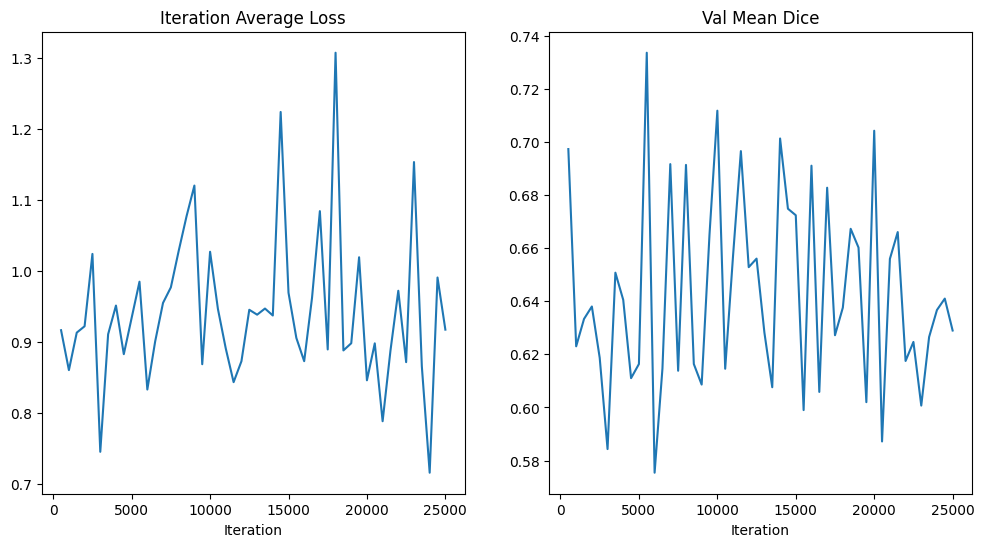

In [35]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#UNETR vit change to wavelet vit

In [5]:
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.12s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.83925): 100%|█| 24/24 [00:13<00:00,  1.72it/
Training (47 / 25000 Steps) (loss=2.69693): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (71 / 25000 Steps) (loss=2.67189): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (95 / 25000 Steps) (loss=2.64155): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (119 / 25000 Steps) (loss=2.54037): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (143 / 25000 Steps) (loss=2.59506): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (167 / 25000 Steps) (loss=2.53750): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (191 / 25000 Steps) (loss=2.41408): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (215 / 25000 Steps) (loss=2.47945): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (239 / 25000 Steps) (loss=2.39996): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (263 / 25000 Steps) (loss=2.26630): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (287 / 25000 Steps) (loss=2.26648): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.45764684677124023 Current Avg. Dice: 0.45764684677124023


Training (503 / 25000 Steps) (loss=2.03852): 100%|█| 24/24 [00:16<00:00,  1.47it
Training (527 / 25000 Steps) (loss=1.99004): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (551 / 25000 Steps) (loss=1.98969): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (575 / 25000 Steps) (loss=1.80836): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (599 / 25000 Steps) (loss=1.82778): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (623 / 25000 Steps) (loss=1.80751): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (647 / 25000 Steps) (loss=1.77899): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (671 / 25000 Steps) (loss=1.77777): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (695 / 25000 Steps) (loss=1.63295): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (719 / 25000 Steps) (loss=1.69710): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (743 / 25000 Steps) (loss=1.69414): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (767 / 25000 Steps) (loss=1.69910): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5463996529579163 Current Avg. Dice: 0.5463996529579163


Training (1007 / 25000 Steps) (loss=1.64228): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (1031 / 25000 Steps) (loss=1.55039): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1055 / 25000 Steps) (loss=1.48827): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1079 / 25000 Steps) (loss=1.40028): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1103 / 25000 Steps) (loss=1.42576): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1127 / 25000 Steps) (loss=1.46574): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1151 / 25000 Steps) (loss=1.34435): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.29024): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1199 / 25000 Steps) (loss=1.34474): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1223 / 25000 Steps) (loss=1.34529): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1247 / 25000 Steps) (loss=1.27529): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1271 / 25000 Steps) (loss=1.36743): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5463996529579163 Current Avg. Dice: 0.5403371453285217


Training (1511 / 25000 Steps) (loss=1.39377): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (1535 / 25000 Steps) (loss=1.21057): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1559 / 25000 Steps) (loss=1.23152): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1583 / 25000 Steps) (loss=1.16441): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1607 / 25000 Steps) (loss=1.38414): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1631 / 25000 Steps) (loss=1.16394): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1655 / 25000 Steps) (loss=1.18925): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1679 / 25000 Steps) (loss=1.07821): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1703 / 25000 Steps) (loss=1.17733): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1727 / 25000 Steps) (loss=1.23352): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1751 / 25000 Steps) (loss=1.70972): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1775 / 25000 Steps) (loss=1.17234): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.549954891204834 Current Avg. Dice: 0.549954891204834


Training (2015 / 25000 Steps) (loss=1.05630): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (2039 / 25000 Steps) (loss=1.11420): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2063 / 25000 Steps) (loss=1.08977): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2087 / 25000 Steps) (loss=1.06183): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2111 / 25000 Steps) (loss=1.24818): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2135 / 25000 Steps) (loss=1.11969): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2159 / 25000 Steps) (loss=1.23917): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2183 / 25000 Steps) (loss=1.31782): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2207 / 25000 Steps) (loss=0.99518): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2231 / 25000 Steps) (loss=1.06668): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2255 / 25000 Steps) (loss=1.21741): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2279 / 25000 Steps) (loss=1.01208): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.549954891204834 Current Avg. Dice: 0.4106905460357666


Training (2519 / 25000 Steps) (loss=1.13149): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (2543 / 25000 Steps) (loss=1.38366): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2567 / 25000 Steps) (loss=1.05305): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2591 / 25000 Steps) (loss=1.03988): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2615 / 25000 Steps) (loss=1.10827): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2639 / 25000 Steps) (loss=1.14865): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2663 / 25000 Steps) (loss=1.02298): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2687 / 25000 Steps) (loss=1.15331): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2711 / 25000 Steps) (loss=1.06027): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2735 / 25000 Steps) (loss=1.05506): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2759 / 25000 Steps) (loss=1.13291): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2783 / 25000 Steps) (loss=1.07237): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.549954891204834 Current Avg. Dice: 0.5498504042625427


Training (3023 / 25000 Steps) (loss=1.11546): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (3047 / 25000 Steps) (loss=1.00893): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3071 / 25000 Steps) (loss=0.99726): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3095 / 25000 Steps) (loss=0.97845): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3119 / 25000 Steps) (loss=0.91720): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3143 / 25000 Steps) (loss=0.94927): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3167 / 25000 Steps) (loss=1.01449): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3191 / 25000 Steps) (loss=1.00238): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3215 / 25000 Steps) (loss=0.97344): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3239 / 25000 Steps) (loss=1.02406): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3263 / 25000 Steps) (loss=0.92954): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3287 / 25000 Steps) (loss=1.05552): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.549954891204834 Current Avg. Dice: 0.5296666026115417


Training (3503 / 25000 Steps) (loss=1.09908): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (3527 / 25000 Steps) (loss=0.89125): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3551 / 25000 Steps) (loss=0.99124): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3575 / 25000 Steps) (loss=0.91473): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3599 / 25000 Steps) (loss=1.09018): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3623 / 25000 Steps) (loss=0.98418): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3647 / 25000 Steps) (loss=0.93855): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3671 / 25000 Steps) (loss=1.01809): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3695 / 25000 Steps) (loss=0.92734): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3719 / 25000 Steps) (loss=0.93382): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3743 / 25000 Steps) (loss=0.94948): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3767 / 25000 Steps) (loss=0.95534): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.549954891204834 Current Avg. Dice: 0.50441974401474


Training (4007 / 25000 Steps) (loss=0.93929): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (4031 / 25000 Steps) (loss=0.96080): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4055 / 25000 Steps) (loss=1.00173): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4079 / 25000 Steps) (loss=0.92622): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4103 / 25000 Steps) (loss=1.02117): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4127 / 25000 Steps) (loss=1.06514): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4151 / 25000 Steps) (loss=0.91568): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4175 / 25000 Steps) (loss=1.02092): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4199 / 25000 Steps) (loss=0.87390): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4223 / 25000 Steps) (loss=0.98936): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4247 / 25000 Steps) (loss=1.01899): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4271 / 25000 Steps) (loss=0.96184): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.549954891204834 Current Avg. Dice: 0.4901998043060303


Training (4511 / 25000 Steps) (loss=1.18188): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (4535 / 25000 Steps) (loss=1.06706): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4559 / 25000 Steps) (loss=1.00046): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4583 / 25000 Steps) (loss=0.85972): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4607 / 25000 Steps) (loss=0.86118): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4631 / 25000 Steps) (loss=0.97573): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4655 / 25000 Steps) (loss=0.87037): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4679 / 25000 Steps) (loss=0.92341): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4703 / 25000 Steps) (loss=0.87859): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4727 / 25000 Steps) (loss=0.98308): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4751 / 25000 Steps) (loss=1.00561): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4775 / 25000 Steps) (loss=0.89271): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5963594317436218 Current Avg. Dice: 0.5963594317436218


Training (5015 / 25000 Steps) (loss=0.95480): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (5039 / 25000 Steps) (loss=1.02042): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5063 / 25000 Steps) (loss=0.91111): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5087 / 25000 Steps) (loss=0.98081): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5111 / 25000 Steps) (loss=0.93787): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5135 / 25000 Steps) (loss=0.90397): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (5159 / 25000 Steps) (loss=0.88671): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5183 / 25000 Steps) (loss=0.90693): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5207 / 25000 Steps) (loss=0.92935): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5231 / 25000 Steps) (loss=0.96006): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5255 / 25000 Steps) (loss=0.93621): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5279 / 25000 Steps) (loss=0.94648): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5963594317436218 Current Avg. Dice: 0.5936161875724792


Training (5519 / 25000 Steps) (loss=0.86213): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (5543 / 25000 Steps) (loss=0.91677): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5567 / 25000 Steps) (loss=0.92682): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5591 / 25000 Steps) (loss=0.80537): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5615 / 25000 Steps) (loss=0.88830): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5639 / 25000 Steps) (loss=1.49143): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5663 / 25000 Steps) (loss=0.79820): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5687 / 25000 Steps) (loss=0.79281): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5711 / 25000 Steps) (loss=1.47512): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5735 / 25000 Steps) (loss=0.71520): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5759 / 25000 Steps) (loss=0.86773): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5783 / 25000 Steps) (loss=0.87383): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6172852516174316 Current Avg. Dice: 0.6172852516174316


Training (6023 / 25000 Steps) (loss=0.99163): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (6047 / 25000 Steps) (loss=0.85914): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6071 / 25000 Steps) (loss=0.83525): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6095 / 25000 Steps) (loss=0.87269): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6119 / 25000 Steps) (loss=0.76127): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6143 / 25000 Steps) (loss=0.83754): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6167 / 25000 Steps) (loss=0.90230): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6191 / 25000 Steps) (loss=0.80104): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6215 / 25000 Steps) (loss=0.88067): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6239 / 25000 Steps) (loss=0.81838): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6263 / 25000 Steps) (loss=0.81440): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6287 / 25000 Steps) (loss=0.88483): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6172852516174316 Current Avg. Dice: 0.5914521813392639


Training (6503 / 25000 Steps) (loss=0.84671): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (6527 / 25000 Steps) (loss=0.84209): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6551 / 25000 Steps) (loss=0.84124): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6575 / 25000 Steps) (loss=0.93169): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.81644): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6623 / 25000 Steps) (loss=0.86087): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6647 / 25000 Steps) (loss=0.92670): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6671 / 25000 Steps) (loss=0.91524): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6695 / 25000 Steps) (loss=0.74113): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6719 / 25000 Steps) (loss=0.80615): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6743 / 25000 Steps) (loss=0.79312): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6767 / 25000 Steps) (loss=0.94822): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6281691193580627 Current Avg. Dice: 0.6281691193580627


Training (7007 / 25000 Steps) (loss=0.83842): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (7031 / 25000 Steps) (loss=0.88138): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7055 / 25000 Steps) (loss=0.82165): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7079 / 25000 Steps) (loss=0.85593): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7103 / 25000 Steps) (loss=0.84959): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7127 / 25000 Steps) (loss=0.84876): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7151 / 25000 Steps) (loss=0.90234): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7175 / 25000 Steps) (loss=0.79612): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7199 / 25000 Steps) (loss=0.76028): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7223 / 25000 Steps) (loss=0.72751): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7247 / 25000 Steps) (loss=0.74512): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7271 / 25000 Steps) (loss=0.84768): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7120466232299805 Current Avg. Dice: 0.7120466232299805


Training (7511 / 25000 Steps) (loss=0.70961): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (7535 / 25000 Steps) (loss=0.70245): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7559 / 25000 Steps) (loss=0.67532): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7583 / 25000 Steps) (loss=0.80972): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7607 / 25000 Steps) (loss=0.88501): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7631 / 25000 Steps) (loss=0.81256): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7655 / 25000 Steps) (loss=0.66516): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7679 / 25000 Steps) (loss=0.82684): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7703 / 25000 Steps) (loss=0.87050): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7727 / 25000 Steps) (loss=0.88927): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7751 / 25000 Steps) (loss=0.87949): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7775 / 25000 Steps) (loss=0.85509): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7120466232299805 Current Avg. Dice: 0.6717768311500549


Training (8015 / 25000 Steps) (loss=0.68488): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (8039 / 25000 Steps) (loss=0.87883): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8063 / 25000 Steps) (loss=0.74627): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8087 / 25000 Steps) (loss=0.89180): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8111 / 25000 Steps) (loss=0.82951): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8135 / 25000 Steps) (loss=0.79850): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8159 / 25000 Steps) (loss=0.77693): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8183 / 25000 Steps) (loss=0.79457): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8207 / 25000 Steps) (loss=0.77725): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8231 / 25000 Steps) (loss=0.70306): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8255 / 25000 Steps) (loss=0.89405): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8279 / 25000 Steps) (loss=0.78875): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7282151579856873 Current Avg. Dice: 0.7282151579856873


Training (8519 / 25000 Steps) (loss=0.80575): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (8543 / 25000 Steps) (loss=0.74202): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8567 / 25000 Steps) (loss=0.67406): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8591 / 25000 Steps) (loss=0.79030): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8615 / 25000 Steps) (loss=0.64040): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8639 / 25000 Steps) (loss=0.73859): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8663 / 25000 Steps) (loss=0.88136): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8687 / 25000 Steps) (loss=0.84119): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8711 / 25000 Steps) (loss=0.80918): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8735 / 25000 Steps) (loss=0.74818): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8759 / 25000 Steps) (loss=0.90874): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8783 / 25000 Steps) (loss=0.75413): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7282151579856873 Current Avg. Dice: 0.6898769736289978


Training (9023 / 25000 Steps) (loss=0.63787): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (9047 / 25000 Steps) (loss=0.70596): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9071 / 25000 Steps) (loss=0.74364): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9095 / 25000 Steps) (loss=0.71871): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9119 / 25000 Steps) (loss=0.91553): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9143 / 25000 Steps) (loss=0.81253): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9167 / 25000 Steps) (loss=0.75301): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9191 / 25000 Steps) (loss=0.75729): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9215 / 25000 Steps) (loss=0.84424): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9239 / 25000 Steps) (loss=0.73834): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9263 / 25000 Steps) (loss=0.80563): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9287 / 25000 Steps) (loss=0.70318): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7644394040107727 Current Avg. Dice: 0.7644394040107727


Training (9503 / 25000 Steps) (loss=0.88168): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (9527 / 25000 Steps) (loss=0.85983): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9551 / 25000 Steps) (loss=0.73734): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9575 / 25000 Steps) (loss=0.80205): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9599 / 25000 Steps) (loss=0.76538): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9623 / 25000 Steps) (loss=0.83115): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9647 / 25000 Steps) (loss=0.70102): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9671 / 25000 Steps) (loss=0.72532): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9695 / 25000 Steps) (loss=1.33775): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9719 / 25000 Steps) (loss=0.70273): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9743 / 25000 Steps) (loss=0.80150): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9767 / 25000 Steps) (loss=0.63162): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7644394040107727 Current Avg. Dice: 0.7314479351043701


Training (10007 / 25000 Steps) (loss=0.99550): 100%|█| 24/24 [00:13<00:00,  1.83
Training (10031 / 25000 Steps) (loss=0.74843): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10055 / 25000 Steps) (loss=0.95413): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10079 / 25000 Steps) (loss=0.83569): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10103 / 25000 Steps) (loss=0.74575): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10127 / 25000 Steps) (loss=0.83075): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10151 / 25000 Steps) (loss=0.69854): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10175 / 25000 Steps) (loss=0.65122): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10199 / 25000 Steps) (loss=0.64425): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10223 / 25000 Steps) (loss=0.72644): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10247 / 25000 Steps) (loss=0.85182): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10271 / 25000 Steps) (loss=1.71796): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7955965995788574 Current Avg. Dice: 0.7955965995788574


Training (10511 / 25000 Steps) (loss=0.53710): 100%|█| 24/24 [00:16<00:00,  1.46
Training (10535 / 25000 Steps) (loss=0.70667): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10559 / 25000 Steps) (loss=0.64288): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10583 / 25000 Steps) (loss=0.62132): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10607 / 25000 Steps) (loss=0.63246): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10631 / 25000 Steps) (loss=0.63725): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10655 / 25000 Steps) (loss=1.10322): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10679 / 25000 Steps) (loss=0.62737): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10703 / 25000 Steps) (loss=0.63530): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10727 / 25000 Steps) (loss=0.80665): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10751 / 25000 Steps) (loss=0.76108): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10775 / 25000 Steps) (loss=0.71399): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8043891787528992 Current Avg. Dice: 0.8043891787528992


Training (11015 / 25000 Steps) (loss=0.75139): 100%|█| 24/24 [00:16<00:00,  1.46
Training (11039 / 25000 Steps) (loss=0.59631): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11063 / 25000 Steps) (loss=0.63089): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11087 / 25000 Steps) (loss=0.64146): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11111 / 25000 Steps) (loss=0.78294): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11135 / 25000 Steps) (loss=0.53622): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11159 / 25000 Steps) (loss=0.75615): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11183 / 25000 Steps) (loss=0.78283): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11207 / 25000 Steps) (loss=0.86029): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11231 / 25000 Steps) (loss=0.67655): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11255 / 25000 Steps) (loss=0.77704): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11279 / 25000 Steps) (loss=0.68106): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.823250949382782 Current Avg. Dice: 0.823250949382782


Training (11519 / 25000 Steps) (loss=0.63585): 100%|█| 24/24 [00:16<00:00,  1.46
Training (11543 / 25000 Steps) (loss=0.69541): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11567 / 25000 Steps) (loss=0.70464): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11591 / 25000 Steps) (loss=0.86911): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11615 / 25000 Steps) (loss=0.59410): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11639 / 25000 Steps) (loss=0.91753): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11663 / 25000 Steps) (loss=0.64625): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11687 / 25000 Steps) (loss=0.70153): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11711 / 25000 Steps) (loss=0.63616): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11735 / 25000 Steps) (loss=0.94625): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11759 / 25000 Steps) (loss=0.70381): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11783 / 25000 Steps) (loss=0.61715): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.823250949382782 Current Avg. Dice: 0.8068328499794006


Training (12023 / 25000 Steps) (loss=0.79518): 100%|█| 24/24 [00:13<00:00,  1.83
Training (12047 / 25000 Steps) (loss=0.79239): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12071 / 25000 Steps) (loss=0.74015): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12095 / 25000 Steps) (loss=0.79333): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12119 / 25000 Steps) (loss=0.63650): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12143 / 25000 Steps) (loss=0.78585): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12167 / 25000 Steps) (loss=0.66979): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12191 / 25000 Steps) (loss=0.79268): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12215 / 25000 Steps) (loss=0.64297): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12239 / 25000 Steps) (loss=0.66720): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12263 / 25000 Steps) (loss=0.43948): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12287 / 25000 Steps) (loss=0.60559): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8420111536979675 Current Avg. Dice: 0.8420111536979675


Training (12503 / 25000 Steps) (loss=0.74042): 100%|█| 24/24 [00:16<00:00,  1.46
Training (12527 / 25000 Steps) (loss=0.73136): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12551 / 25000 Steps) (loss=0.71789): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12575 / 25000 Steps) (loss=0.80136): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12599 / 25000 Steps) (loss=0.71846): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12623 / 25000 Steps) (loss=0.64657): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12647 / 25000 Steps) (loss=0.83379): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12671 / 25000 Steps) (loss=0.81096): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12695 / 25000 Steps) (loss=0.84024): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12719 / 25000 Steps) (loss=0.66189): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12743 / 25000 Steps) (loss=0.77104): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12767 / 25000 Steps) (loss=0.71706): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8420111536979675 Current Avg. Dice: 0.7614664435386658


Training (13007 / 25000 Steps) (loss=0.75564): 100%|█| 24/24 [00:13<00:00,  1.81
Training (13031 / 25000 Steps) (loss=0.63759): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13055 / 25000 Steps) (loss=0.66321): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13079 / 25000 Steps) (loss=0.67671): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13103 / 25000 Steps) (loss=0.58211): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13127 / 25000 Steps) (loss=0.66705): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13151 / 25000 Steps) (loss=0.54275): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13175 / 25000 Steps) (loss=0.53098): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13199 / 25000 Steps) (loss=0.53078): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13223 / 25000 Steps) (loss=0.46887): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13247 / 25000 Steps) (loss=0.68573): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13271 / 25000 Steps) (loss=0.60608): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8420111536979675 Current Avg. Dice: 0.7964574694633484


Training (13511 / 25000 Steps) (loss=0.77905): 100%|█| 24/24 [00:13<00:00,  1.83
Training (13535 / 25000 Steps) (loss=0.83742): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13559 / 25000 Steps) (loss=0.91353): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13583 / 25000 Steps) (loss=0.88922): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13607 / 25000 Steps) (loss=0.63762): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13631 / 25000 Steps) (loss=0.84468): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13655 / 25000 Steps) (loss=0.42020): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13679 / 25000 Steps) (loss=0.71586): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13703 / 25000 Steps) (loss=0.42143): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13727 / 25000 Steps) (loss=0.65665): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13751 / 25000 Steps) (loss=0.52597): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13775 / 25000 Steps) (loss=0.64341): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8420111536979675 Current Avg. Dice: 0.7371859550476074


Training (14015 / 25000 Steps) (loss=0.55215): 100%|█| 24/24 [00:13<00:00,  1.83
Training (14039 / 25000 Steps) (loss=0.60932): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14063 / 25000 Steps) (loss=0.81135): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14087 / 25000 Steps) (loss=0.69607): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14111 / 25000 Steps) (loss=0.72118): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14135 / 25000 Steps) (loss=0.71485): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14159 / 25000 Steps) (loss=0.87193): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14183 / 25000 Steps) (loss=0.62683): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14207 / 25000 Steps) (loss=0.56133): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14231 / 25000 Steps) (loss=0.74845): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14255 / 25000 Steps) (loss=0.95034): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14279 / 25000 Steps) (loss=0.69769): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8420111536979675 Current Avg. Dice: 0.8142067790031433


Training (14519 / 25000 Steps) (loss=0.74265): 100%|█| 24/24 [00:13<00:00,  1.82
Training (14543 / 25000 Steps) (loss=0.68605): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14567 / 25000 Steps) (loss=0.56114): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14591 / 25000 Steps) (loss=0.88150): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14615 / 25000 Steps) (loss=0.81838): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14639 / 25000 Steps) (loss=0.67690): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14663 / 25000 Steps) (loss=0.73019): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14687 / 25000 Steps) (loss=0.73411): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14711 / 25000 Steps) (loss=0.50867): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14735 / 25000 Steps) (loss=0.73917): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14759 / 25000 Steps) (loss=0.73850): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14783 / 25000 Steps) (loss=0.74195): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8437399864196777 Current Avg. Dice: 0.8437399864196777


Training (15023 / 25000 Steps) (loss=0.60086): 100%|█| 24/24 [00:16<00:00,  1.45
Training (15047 / 25000 Steps) (loss=0.85031): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15071 / 25000 Steps) (loss=0.68715): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15095 / 25000 Steps) (loss=0.52553): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15119 / 25000 Steps) (loss=1.02068): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15143 / 25000 Steps) (loss=0.80980): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15167 / 25000 Steps) (loss=0.72066): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15191 / 25000 Steps) (loss=0.67359): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15215 / 25000 Steps) (loss=0.77428): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15239 / 25000 Steps) (loss=1.13971): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15263 / 25000 Steps) (loss=0.70240): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15287 / 25000 Steps) (loss=0.92715): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8437399864196777 Current Avg. Dice: 0.7741990685462952


Training (15503 / 25000 Steps) (loss=0.47145): 100%|█| 24/24 [00:13<00:00,  1.83
Training (15527 / 25000 Steps) (loss=0.64770): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15551 / 25000 Steps) (loss=0.68510): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15575 / 25000 Steps) (loss=0.55312): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15599 / 25000 Steps) (loss=0.42447): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15623 / 25000 Steps) (loss=0.74299): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15647 / 25000 Steps) (loss=0.70627): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15671 / 25000 Steps) (loss=0.84530): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15695 / 25000 Steps) (loss=0.67187): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15719 / 25000 Steps) (loss=0.71376): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15743 / 25000 Steps) (loss=0.74861): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15767 / 25000 Steps) (loss=0.71290): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8437399864196777 Current Avg. Dice: 0.8129237294197083


Training (16007 / 25000 Steps) (loss=0.56957): 100%|█| 24/24 [00:13<00:00,  1.83
Training (16031 / 25000 Steps) (loss=0.63264): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16055 / 25000 Steps) (loss=0.61855): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16079 / 25000 Steps) (loss=0.70708): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16103 / 25000 Steps) (loss=0.68313): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16127 / 25000 Steps) (loss=0.71267): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16151 / 25000 Steps) (loss=0.58424): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16175 / 25000 Steps) (loss=0.74167): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16199 / 25000 Steps) (loss=0.62193): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16223 / 25000 Steps) (loss=0.80056): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16247 / 25000 Steps) (loss=0.65523): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16271 / 25000 Steps) (loss=0.54131): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8437399864196777 Current Avg. Dice: 0.7550593018531799


Training (16511 / 25000 Steps) (loss=0.70157): 100%|█| 24/24 [00:13<00:00,  1.83
Training (16535 / 25000 Steps) (loss=0.71921): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16559 / 25000 Steps) (loss=0.79388): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16583 / 25000 Steps) (loss=0.49475): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16607 / 25000 Steps) (loss=0.90922): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16631 / 25000 Steps) (loss=0.56397): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16655 / 25000 Steps) (loss=0.76232): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16679 / 25000 Steps) (loss=0.66477): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16703 / 25000 Steps) (loss=0.44048): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16727 / 25000 Steps) (loss=0.71783): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16751 / 25000 Steps) (loss=0.52601): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16775 / 25000 Steps) (loss=0.79614): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8640015721321106


Training (17015 / 25000 Steps) (loss=0.57264): 100%|█| 24/24 [00:16<00:00,  1.46
Training (17039 / 25000 Steps) (loss=0.57802): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17063 / 25000 Steps) (loss=0.75568): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17087 / 25000 Steps) (loss=0.48944): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17111 / 25000 Steps) (loss=0.50161): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17135 / 25000 Steps) (loss=0.61189): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17159 / 25000 Steps) (loss=0.56325): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17183 / 25000 Steps) (loss=0.45568): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17207 / 25000 Steps) (loss=0.49328): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17231 / 25000 Steps) (loss=0.78662): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17255 / 25000 Steps) (loss=0.62967): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17279 / 25000 Steps) (loss=0.68558): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8065924644470215


Training (17519 / 25000 Steps) (loss=0.49522): 100%|█| 24/24 [00:13<00:00,  1.83
Training (17543 / 25000 Steps) (loss=0.53463): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17567 / 25000 Steps) (loss=0.55034): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17591 / 25000 Steps) (loss=0.45931): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17615 / 25000 Steps) (loss=0.72536): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17639 / 25000 Steps) (loss=0.52568): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17663 / 25000 Steps) (loss=0.65494): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17687 / 25000 Steps) (loss=0.54605): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17711 / 25000 Steps) (loss=0.72657): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17735 / 25000 Steps) (loss=0.65876): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17759 / 25000 Steps) (loss=0.71488): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17783 / 25000 Steps) (loss=0.71793): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.828912079334259


Training (18023 / 25000 Steps) (loss=0.72394): 100%|█| 24/24 [00:13<00:00,  1.82
Training (18047 / 25000 Steps) (loss=0.50896): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18071 / 25000 Steps) (loss=0.62680): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18095 / 25000 Steps) (loss=0.62026): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18119 / 25000 Steps) (loss=1.03095): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18143 / 25000 Steps) (loss=0.80931): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18167 / 25000 Steps) (loss=0.58354): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18191 / 25000 Steps) (loss=0.70400): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18215 / 25000 Steps) (loss=0.64267): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18239 / 25000 Steps) (loss=0.79179): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18263 / 25000 Steps) (loss=0.49811): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18287 / 25000 Steps) (loss=0.72166): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.7927670478820801


Training (18503 / 25000 Steps) (loss=0.66108): 100%|█| 24/24 [00:13<00:00,  1.83
Training (18527 / 25000 Steps) (loss=0.79613): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18551 / 25000 Steps) (loss=0.67953): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18575 / 25000 Steps) (loss=0.78351): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18599 / 25000 Steps) (loss=0.55807): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18623 / 25000 Steps) (loss=0.72316): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18647 / 25000 Steps) (loss=0.73434): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18671 / 25000 Steps) (loss=0.67756): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18695 / 25000 Steps) (loss=0.67113): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18719 / 25000 Steps) (loss=0.62776): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18743 / 25000 Steps) (loss=0.55728): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18767 / 25000 Steps) (loss=0.68266): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.7964646220207214


Training (19007 / 25000 Steps) (loss=0.45492): 100%|█| 24/24 [00:13<00:00,  1.83
Training (19031 / 25000 Steps) (loss=0.78754): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19055 / 25000 Steps) (loss=0.67554): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19079 / 25000 Steps) (loss=0.55062): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19103 / 25000 Steps) (loss=0.69198): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19127 / 25000 Steps) (loss=0.80446): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19151 / 25000 Steps) (loss=0.61406): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19175 / 25000 Steps) (loss=0.44102): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19199 / 25000 Steps) (loss=0.61162): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19223 / 25000 Steps) (loss=0.64957): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19247 / 25000 Steps) (loss=0.55371): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19271 / 25000 Steps) (loss=0.45878): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8254265785217285


Training (19511 / 25000 Steps) (loss=0.50528): 100%|█| 24/24 [00:13<00:00,  1.83
Training (19535 / 25000 Steps) (loss=0.63640): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19559 / 25000 Steps) (loss=0.77605): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19583 / 25000 Steps) (loss=0.64941): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19607 / 25000 Steps) (loss=0.64297): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19631 / 25000 Steps) (loss=0.45810): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19655 / 25000 Steps) (loss=0.78214): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19679 / 25000 Steps) (loss=0.65773): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19703 / 25000 Steps) (loss=0.46643): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19727 / 25000 Steps) (loss=0.60195): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19751 / 25000 Steps) (loss=0.65848): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19775 / 25000 Steps) (loss=0.58124): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8520684242248535


Training (20015 / 25000 Steps) (loss=0.57586): 100%|█| 24/24 [00:13<00:00,  1.83
Training (20039 / 25000 Steps) (loss=0.58513): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20063 / 25000 Steps) (loss=0.74385): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20087 / 25000 Steps) (loss=0.58825): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20111 / 25000 Steps) (loss=0.68645): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20135 / 25000 Steps) (loss=0.64434): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20159 / 25000 Steps) (loss=0.63010): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20183 / 25000 Steps) (loss=0.55229): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20207 / 25000 Steps) (loss=0.57345): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20231 / 25000 Steps) (loss=0.57227): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20255 / 25000 Steps) (loss=0.61688): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20279 / 25000 Steps) (loss=0.77184): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8119582533836365


Training (20519 / 25000 Steps) (loss=0.56799): 100%|█| 24/24 [00:13<00:00,  1.83
Training (20543 / 25000 Steps) (loss=0.71818): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20567 / 25000 Steps) (loss=0.66943): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20591 / 25000 Steps) (loss=0.74123): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20615 / 25000 Steps) (loss=0.84078): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20639 / 25000 Steps) (loss=0.56752): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20663 / 25000 Steps) (loss=0.60166): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20687 / 25000 Steps) (loss=0.64056): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20711 / 25000 Steps) (loss=0.73449): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20735 / 25000 Steps) (loss=0.59250): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20759 / 25000 Steps) (loss=0.52684): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20783 / 25000 Steps) (loss=0.54398): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8547787666320801


Training (21023 / 25000 Steps) (loss=0.86707): 100%|█| 24/24 [00:13<00:00,  1.83
Training (21047 / 25000 Steps) (loss=0.82007): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21071 / 25000 Steps) (loss=0.43532): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21095 / 25000 Steps) (loss=0.47752): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21119 / 25000 Steps) (loss=0.67467): 100%|█| 24/24 [00:11<00:00,  2.06
Training (21143 / 25000 Steps) (loss=0.48660): 100%|█| 24/24 [00:11<00:00,  2.06
Training (21167 / 25000 Steps) (loss=0.48204): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21191 / 25000 Steps) (loss=0.70412): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21215 / 25000 Steps) (loss=0.45320): 100%|█| 24/24 [00:11<00:00,  2.06
Training (21239 / 25000 Steps) (loss=0.62469): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21263 / 25000 Steps) (loss=0.40414): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21287 / 25000 Steps) (loss=0.85061): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8376272320747375


Training (21503 / 25000 Steps) (loss=0.68147): 100%|█| 24/24 [00:13<00:00,  1.83
Training (21527 / 25000 Steps) (loss=0.89707): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21551 / 25000 Steps) (loss=0.42852): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21575 / 25000 Steps) (loss=0.57538): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21599 / 25000 Steps) (loss=0.64273): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21623 / 25000 Steps) (loss=0.47107): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21647 / 25000 Steps) (loss=0.77711): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21671 / 25000 Steps) (loss=0.47162): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21695 / 25000 Steps) (loss=0.74897): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21719 / 25000 Steps) (loss=0.62076): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21743 / 25000 Steps) (loss=0.55763): 100%|█| 24/24 [00:11<00:00,  2.06
Training (21767 / 25000 Steps) (loss=0.89069): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.7901380062103271


Training (22007 / 25000 Steps) (loss=0.69245): 100%|█| 24/24 [00:13<00:00,  1.81
Training (22031 / 25000 Steps) (loss=0.52650): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22055 / 25000 Steps) (loss=0.68480): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22079 / 25000 Steps) (loss=0.54862): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22103 / 25000 Steps) (loss=0.55008): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22127 / 25000 Steps) (loss=0.52075): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22151 / 25000 Steps) (loss=0.36252): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22175 / 25000 Steps) (loss=0.56599): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22199 / 25000 Steps) (loss=0.60470): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22223 / 25000 Steps) (loss=0.55305): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22247 / 25000 Steps) (loss=0.77791): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22271 / 25000 Steps) (loss=0.42602): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.84065181016922


Training (22511 / 25000 Steps) (loss=0.61704): 100%|█| 24/24 [00:13<00:00,  1.83
Training (22535 / 25000 Steps) (loss=0.52948): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22559 / 25000 Steps) (loss=0.53602): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22583 / 25000 Steps) (loss=0.67072): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22607 / 25000 Steps) (loss=0.66238): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22631 / 25000 Steps) (loss=0.56494): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22655 / 25000 Steps) (loss=0.75886): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22679 / 25000 Steps) (loss=0.72792): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22703 / 25000 Steps) (loss=0.63870): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22727 / 25000 Steps) (loss=0.55771): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22751 / 25000 Steps) (loss=0.61025): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22775 / 25000 Steps) (loss=0.41032): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8082060813903809


Training (23015 / 25000 Steps) (loss=0.70297): 100%|█| 24/24 [00:13<00:00,  1.83
Training (23039 / 25000 Steps) (loss=0.47068): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23063 / 25000 Steps) (loss=0.63937): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23087 / 25000 Steps) (loss=0.70693): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23111 / 25000 Steps) (loss=0.70354): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23135 / 25000 Steps) (loss=0.68507): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23159 / 25000 Steps) (loss=0.76276): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23183 / 25000 Steps) (loss=0.54259): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23207 / 25000 Steps) (loss=0.73900): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23231 / 25000 Steps) (loss=0.75224): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23255 / 25000 Steps) (loss=0.46674): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23279 / 25000 Steps) (loss=0.42882): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8516491055488586


Training (23519 / 25000 Steps) (loss=0.48286): 100%|█| 24/24 [00:13<00:00,  1.83
Training (23543 / 25000 Steps) (loss=0.62287): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23567 / 25000 Steps) (loss=1.06937): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23591 / 25000 Steps) (loss=0.75713): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23615 / 25000 Steps) (loss=0.65993): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23639 / 25000 Steps) (loss=0.75984): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23663 / 25000 Steps) (loss=0.41524): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23687 / 25000 Steps) (loss=0.73428): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23711 / 25000 Steps) (loss=0.52965): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23735 / 25000 Steps) (loss=0.75022): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23759 / 25000 Steps) (loss=0.78743): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23783 / 25000 Steps) (loss=0.46012): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.8410484194755554


Training (24023 / 25000 Steps) (loss=0.64726): 100%|█| 24/24 [00:13<00:00,  1.83
Training (24047 / 25000 Steps) (loss=0.39573): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24071 / 25000 Steps) (loss=0.72614): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24095 / 25000 Steps) (loss=0.55786): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24119 / 25000 Steps) (loss=0.52742): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24143 / 25000 Steps) (loss=0.76111): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24167 / 25000 Steps) (loss=0.52934): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24191 / 25000 Steps) (loss=0.46171): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24215 / 25000 Steps) (loss=0.43171): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24239 / 25000 Steps) (loss=0.56165): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24263 / 25000 Steps) (loss=0.57715): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24287 / 25000 Steps) (loss=0.48803): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.7662666440010071


Training (24503 / 25000 Steps) (loss=0.64456): 100%|█| 24/24 [00:13<00:00,  1.83
Training (24527 / 25000 Steps) (loss=0.66875): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24551 / 25000 Steps) (loss=0.42022): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24575 / 25000 Steps) (loss=0.81235): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24599 / 25000 Steps) (loss=0.58467): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24623 / 25000 Steps) (loss=0.40281): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24647 / 25000 Steps) (loss=0.62210): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24671 / 25000 Steps) (loss=0.57307): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24695 / 25000 Steps) (loss=0.38243): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24719 / 25000 Steps) (loss=0.56434): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24743 / 25000 Steps) (loss=0.48055): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24767 / 25000 Steps) (loss=0.46965): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8640015721321106 Current Avg. Dice: 0.7387917637825012


Training (25007 / 25000 Steps) (loss=0.43511): 100%|█| 24/24 [00:13<00:00,  1.83


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8640 at iteration: 17000


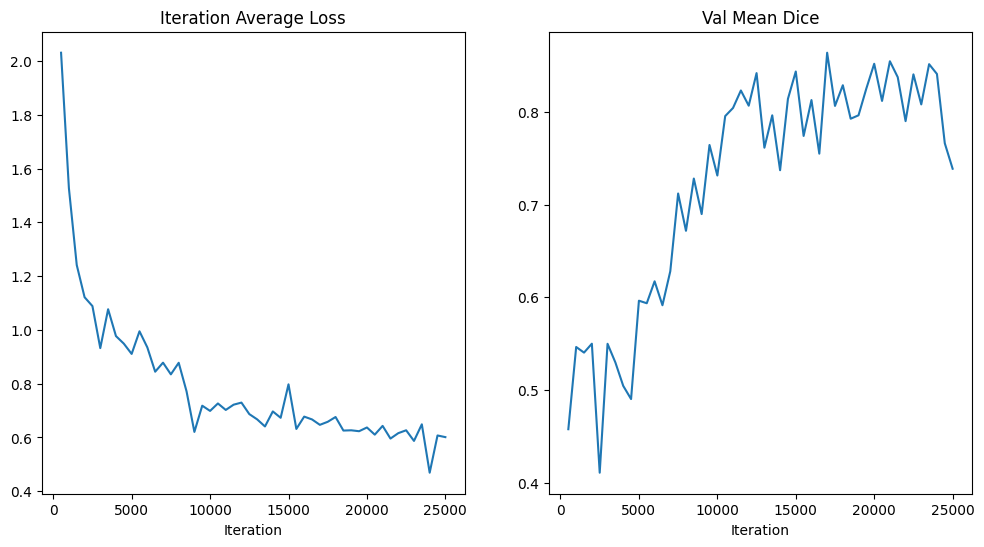

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.52290): 100%|█| 24/24 [00:14<00:00,  1.67it/
Training (47 / 25000 Steps) (loss=2.48210): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (71 / 25000 Steps) (loss=2.27747): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (95 / 25000 Steps) (loss=2.48888): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (119 / 25000 Steps) (loss=2.27710): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (143 / 25000 Steps) (loss=2.17323): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (167 / 25000 Steps) (loss=2.12047): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (191 / 25000 Steps) (loss=2.05395): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (215 / 25000 Steps) (loss=2.03322): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (239 / 25000 Steps) (loss=2.03257): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (263 / 25000 Steps) (loss=2.00822): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (287 / 25000 Steps) (loss=2.00589): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.39301586151123047 Current Avg. Dice: 0.39301586151123047


Training (503 / 25000 Steps) (loss=1.69252): 100%|█| 24/24 [00:16<00:00,  1.46it
Training (527 / 25000 Steps) (loss=1.67482): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (551 / 25000 Steps) (loss=1.65293): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (575 / 25000 Steps) (loss=1.66101): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (599 / 25000 Steps) (loss=1.59699): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (623 / 25000 Steps) (loss=1.58164): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (647 / 25000 Steps) (loss=1.58542): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (671 / 25000 Steps) (loss=1.61073): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (695 / 25000 Steps) (loss=2.21301): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (719 / 25000 Steps) (loss=1.51772): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (743 / 25000 Steps) (loss=1.46895): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (767 / 25000 Steps) (loss=1.43492): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4028242826461792 Current Avg. Dice: 0.4028242826461792


Training (1007 / 25000 Steps) (loss=1.39366): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (1031 / 25000 Steps) (loss=1.39236): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1055 / 25000 Steps) (loss=1.24504): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1079 / 25000 Steps) (loss=1.21847): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1103 / 25000 Steps) (loss=1.31260): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1127 / 25000 Steps) (loss=1.34045): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1151 / 25000 Steps) (loss=1.34165): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.35969): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=1.25340): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1223 / 25000 Steps) (loss=1.71807): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1247 / 25000 Steps) (loss=1.26786): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1271 / 25000 Steps) (loss=1.20452): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4480534493923187 Current Avg. Dice: 0.4480534493923187


Training (1511 / 25000 Steps) (loss=1.13735): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (1535 / 25000 Steps) (loss=1.10082): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1559 / 25000 Steps) (loss=1.18260): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1583 / 25000 Steps) (loss=1.13698): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1607 / 25000 Steps) (loss=1.16135): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1631 / 25000 Steps) (loss=1.20367): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1655 / 25000 Steps) (loss=1.21381): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1679 / 25000 Steps) (loss=1.29317): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1703 / 25000 Steps) (loss=1.11313): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1727 / 25000 Steps) (loss=1.32267): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1751 / 25000 Steps) (loss=1.13296): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1775 / 25000 Steps) (loss=1.10881): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4480534493923187 Current Avg. Dice: 0.38774797320365906


Training (2015 / 25000 Steps) (loss=1.26166): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (2039 / 25000 Steps) (loss=1.07791): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2063 / 25000 Steps) (loss=1.19049): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2087 / 25000 Steps) (loss=1.17383): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2111 / 25000 Steps) (loss=1.04938): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2135 / 25000 Steps) (loss=1.19535): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2159 / 25000 Steps) (loss=1.18354): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2183 / 25000 Steps) (loss=1.08246): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2207 / 25000 Steps) (loss=1.12925): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2231 / 25000 Steps) (loss=1.26918): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2255 / 25000 Steps) (loss=1.23611): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2279 / 25000 Steps) (loss=1.07043): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4480534493923187 Current Avg. Dice: 0.387446790933609


Training (2519 / 25000 Steps) (loss=1.14522): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (2543 / 25000 Steps) (loss=1.21421): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2567 / 25000 Steps) (loss=1.09624): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2591 / 25000 Steps) (loss=1.00084): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2615 / 25000 Steps) (loss=1.06794): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2639 / 25000 Steps) (loss=1.19142): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2663 / 25000 Steps) (loss=1.05082): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2687 / 25000 Steps) (loss=0.96788): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2711 / 25000 Steps) (loss=1.06618): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2735 / 25000 Steps) (loss=1.35433): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2759 / 25000 Steps) (loss=1.09924): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2783 / 25000 Steps) (loss=1.08745): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4480534493923187 Current Avg. Dice: 0.3997879922389984


Training (3023 / 25000 Steps) (loss=1.15953): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (3047 / 25000 Steps) (loss=0.99849): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3071 / 25000 Steps) (loss=1.01048): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3095 / 25000 Steps) (loss=1.06903): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3119 / 25000 Steps) (loss=0.96862): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3143 / 25000 Steps) (loss=1.09492): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3167 / 25000 Steps) (loss=1.05401): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3191 / 25000 Steps) (loss=1.25685): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3215 / 25000 Steps) (loss=1.02862): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3239 / 25000 Steps) (loss=1.06133): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3263 / 25000 Steps) (loss=1.07042): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3287 / 25000 Steps) (loss=1.22788): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.45998576283454895 Current Avg. Dice: 0.45998576283454895


Training (3503 / 25000 Steps) (loss=0.97633): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (3527 / 25000 Steps) (loss=1.04003): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3551 / 25000 Steps) (loss=0.97586): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3575 / 25000 Steps) (loss=1.06542): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3599 / 25000 Steps) (loss=0.97661): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3623 / 25000 Steps) (loss=1.02310): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3647 / 25000 Steps) (loss=0.89247): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3671 / 25000 Steps) (loss=1.11177): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3695 / 25000 Steps) (loss=0.99886): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3719 / 25000 Steps) (loss=0.94297): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3743 / 25000 Steps) (loss=1.08346): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3767 / 25000 Steps) (loss=1.07949): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4711325466632843 Current Avg. Dice: 0.4711325466632843


Training (4007 / 25000 Steps) (loss=1.02554): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (4031 / 25000 Steps) (loss=0.95046): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4055 / 25000 Steps) (loss=1.10664): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4079 / 25000 Steps) (loss=0.94220): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4103 / 25000 Steps) (loss=0.95896): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4127 / 25000 Steps) (loss=0.92695): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4151 / 25000 Steps) (loss=1.02025): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4175 / 25000 Steps) (loss=0.87318): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4199 / 25000 Steps) (loss=0.98872): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4223 / 25000 Steps) (loss=1.12093): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4247 / 25000 Steps) (loss=1.00082): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4271 / 25000 Steps) (loss=1.05552): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5045462250709534 Current Avg. Dice: 0.5045462250709534


Training (4511 / 25000 Steps) (loss=0.98369): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (4535 / 25000 Steps) (loss=0.95352): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4559 / 25000 Steps) (loss=0.95573): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4583 / 25000 Steps) (loss=1.14466): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4607 / 25000 Steps) (loss=0.99447): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4631 / 25000 Steps) (loss=1.01338): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4655 / 25000 Steps) (loss=1.30144): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4679 / 25000 Steps) (loss=1.26287): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4703 / 25000 Steps) (loss=0.98345): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4727 / 25000 Steps) (loss=0.93782): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4751 / 25000 Steps) (loss=0.89502): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4775 / 25000 Steps) (loss=0.93214): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5045462250709534 Current Avg. Dice: 0.4383213520050049


Training (5015 / 25000 Steps) (loss=0.93344): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5039 / 25000 Steps) (loss=1.00521): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5063 / 25000 Steps) (loss=1.04597): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5087 / 25000 Steps) (loss=0.86454): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5111 / 25000 Steps) (loss=0.96488): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5135 / 25000 Steps) (loss=0.94496): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.94553): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5183 / 25000 Steps) (loss=0.86024): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5207 / 25000 Steps) (loss=0.96205): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5231 / 25000 Steps) (loss=0.88813): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5255 / 25000 Steps) (loss=1.38244): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5279 / 25000 Steps) (loss=0.88411): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5045462250709534 Current Avg. Dice: 0.4448068141937256


Training (5519 / 25000 Steps) (loss=0.95022): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (5543 / 25000 Steps) (loss=0.94527): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5567 / 25000 Steps) (loss=0.89652): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5591 / 25000 Steps) (loss=0.98069): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5615 / 25000 Steps) (loss=0.89241): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5639 / 25000 Steps) (loss=0.89520): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5663 / 25000 Steps) (loss=0.95386): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5687 / 25000 Steps) (loss=1.11954): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5711 / 25000 Steps) (loss=0.90224): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5735 / 25000 Steps) (loss=0.88458): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5759 / 25000 Steps) (loss=0.87611): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5783 / 25000 Steps) (loss=0.97939): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5633619427680969 Current Avg. Dice: 0.5633619427680969


Training (6023 / 25000 Steps) (loss=1.00721): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (6047 / 25000 Steps) (loss=0.93829): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6071 / 25000 Steps) (loss=0.84132): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6095 / 25000 Steps) (loss=0.83814): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6119 / 25000 Steps) (loss=0.90054): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6143 / 25000 Steps) (loss=1.07674): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6167 / 25000 Steps) (loss=0.79020): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6191 / 25000 Steps) (loss=0.95636): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6215 / 25000 Steps) (loss=1.01883): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6239 / 25000 Steps) (loss=0.82395): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6263 / 25000 Steps) (loss=0.94889): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6287 / 25000 Steps) (loss=0.91424): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5748744606971741 Current Avg. Dice: 0.5748744606971741


Training (6503 / 25000 Steps) (loss=0.89283): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (6527 / 25000 Steps) (loss=0.90013): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6551 / 25000 Steps) (loss=0.84667): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6575 / 25000 Steps) (loss=1.03413): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6599 / 25000 Steps) (loss=0.89877): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6623 / 25000 Steps) (loss=0.93704): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6647 / 25000 Steps) (loss=1.03345): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6671 / 25000 Steps) (loss=0.87841): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6695 / 25000 Steps) (loss=1.09801): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6719 / 25000 Steps) (loss=0.84410): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6743 / 25000 Steps) (loss=0.95673): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6767 / 25000 Steps) (loss=0.79720): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5925701260566711 Current Avg. Dice: 0.5925701260566711


Training (7007 / 25000 Steps) (loss=0.89292): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (7031 / 25000 Steps) (loss=0.94193): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7055 / 25000 Steps) (loss=0.75534): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7079 / 25000 Steps) (loss=0.88758): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7103 / 25000 Steps) (loss=0.88348): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7127 / 25000 Steps) (loss=0.90428): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7151 / 25000 Steps) (loss=1.35186): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7175 / 25000 Steps) (loss=0.98817): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7199 / 25000 Steps) (loss=0.85281): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7223 / 25000 Steps) (loss=0.90124): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7247 / 25000 Steps) (loss=0.94810): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7271 / 25000 Steps) (loss=0.83721): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5925701260566711 Current Avg. Dice: 0.5540581345558167


Training (7511 / 25000 Steps) (loss=0.97925): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (7535 / 25000 Steps) (loss=0.81649): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7559 / 25000 Steps) (loss=0.85283): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7583 / 25000 Steps) (loss=0.79786): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7607 / 25000 Steps) (loss=0.78298): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7631 / 25000 Steps) (loss=0.86510): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7655 / 25000 Steps) (loss=0.78806): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7679 / 25000 Steps) (loss=0.67852): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7703 / 25000 Steps) (loss=0.82875): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7727 / 25000 Steps) (loss=0.82055): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7751 / 25000 Steps) (loss=0.91872): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7775 / 25000 Steps) (loss=0.92917): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6220636963844299 Current Avg. Dice: 0.6220636963844299


Training (8015 / 25000 Steps) (loss=0.96404): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (8039 / 25000 Steps) (loss=0.83057): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8063 / 25000 Steps) (loss=0.86204): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8087 / 25000 Steps) (loss=0.76899): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8111 / 25000 Steps) (loss=0.74653): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8135 / 25000 Steps) (loss=0.80198): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8159 / 25000 Steps) (loss=0.81140): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8183 / 25000 Steps) (loss=1.02219): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8207 / 25000 Steps) (loss=0.85756): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8231 / 25000 Steps) (loss=0.84709): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8255 / 25000 Steps) (loss=0.64887): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8279 / 25000 Steps) (loss=0.84667): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7293831706047058 Current Avg. Dice: 0.7293831706047058


Training (8519 / 25000 Steps) (loss=0.87245): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (8543 / 25000 Steps) (loss=0.89261): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8567 / 25000 Steps) (loss=0.88853): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8591 / 25000 Steps) (loss=0.81194): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8615 / 25000 Steps) (loss=0.64854): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8639 / 25000 Steps) (loss=0.75642): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8663 / 25000 Steps) (loss=0.91219): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8687 / 25000 Steps) (loss=0.81022): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8711 / 25000 Steps) (loss=0.80066): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8735 / 25000 Steps) (loss=0.88658): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8759 / 25000 Steps) (loss=0.87604): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8783 / 25000 Steps) (loss=0.95925): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.78822261095047 Current Avg. Dice: 0.78822261095047


Training (9023 / 25000 Steps) (loss=0.67831): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (9047 / 25000 Steps) (loss=0.81451): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9071 / 25000 Steps) (loss=0.68820): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9095 / 25000 Steps) (loss=0.61969): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9119 / 25000 Steps) (loss=0.71064): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9143 / 25000 Steps) (loss=0.80084): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9167 / 25000 Steps) (loss=0.77834): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9191 / 25000 Steps) (loss=0.70599): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9215 / 25000 Steps) (loss=0.86450): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9239 / 25000 Steps) (loss=0.73231): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9263 / 25000 Steps) (loss=0.76614): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9287 / 25000 Steps) (loss=0.81978): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.78822261095047 Current Avg. Dice: 0.7031243443489075


Training (9503 / 25000 Steps) (loss=0.80064): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (9527 / 25000 Steps) (loss=0.79099): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9551 / 25000 Steps) (loss=0.75955): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9575 / 25000 Steps) (loss=0.65447): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9599 / 25000 Steps) (loss=0.78632): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9623 / 25000 Steps) (loss=0.84383): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9647 / 25000 Steps) (loss=0.85716): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9671 / 25000 Steps) (loss=0.61244): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9695 / 25000 Steps) (loss=0.70055): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9719 / 25000 Steps) (loss=0.62688): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9743 / 25000 Steps) (loss=0.71052): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9767 / 25000 Steps) (loss=0.89081): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.78822261095047 Current Avg. Dice: 0.7238674163818359


Training (10007 / 25000 Steps) (loss=0.84689): 100%|█| 24/24 [00:13<00:00,  1.83
Training (10031 / 25000 Steps) (loss=0.77139): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10055 / 25000 Steps) (loss=0.89154): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10079 / 25000 Steps) (loss=0.67966): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10103 / 25000 Steps) (loss=0.84266): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10127 / 25000 Steps) (loss=0.71016): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10151 / 25000 Steps) (loss=0.84713): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10175 / 25000 Steps) (loss=0.77899): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10199 / 25000 Steps) (loss=0.68896): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10223 / 25000 Steps) (loss=0.87329): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10247 / 25000 Steps) (loss=0.98446): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10271 / 25000 Steps) (loss=0.61984): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7995279431343079


Training (10511 / 25000 Steps) (loss=0.66076): 100%|█| 24/24 [00:16<00:00,  1.45
Training (10535 / 25000 Steps) (loss=0.70846): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10559 / 25000 Steps) (loss=0.79139): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10583 / 25000 Steps) (loss=0.76272): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10607 / 25000 Steps) (loss=0.72081): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10631 / 25000 Steps) (loss=0.78363): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10655 / 25000 Steps) (loss=0.80107): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10679 / 25000 Steps) (loss=1.05787): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10703 / 25000 Steps) (loss=0.89856): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10727 / 25000 Steps) (loss=0.91425): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10751 / 25000 Steps) (loss=0.65395): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10775 / 25000 Steps) (loss=0.73806): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7747955322265625


Training (11015 / 25000 Steps) (loss=0.89269): 100%|█| 24/24 [00:13<00:00,  1.82
Training (11039 / 25000 Steps) (loss=0.70958): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11063 / 25000 Steps) (loss=0.67750): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11087 / 25000 Steps) (loss=0.65093): 100%|█| 24/24 [00:11<00:00,  2.04
Training (11111 / 25000 Steps) (loss=0.77902): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11135 / 25000 Steps) (loss=0.81808): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11159 / 25000 Steps) (loss=0.87826): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11183 / 25000 Steps) (loss=0.71607): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11207 / 25000 Steps) (loss=0.71274): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11231 / 25000 Steps) (loss=0.74383): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11255 / 25000 Steps) (loss=0.76001): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11279 / 25000 Steps) (loss=0.58385): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7796607613563538


Training (11519 / 25000 Steps) (loss=0.77010): 100%|█| 24/24 [00:13<00:00,  1.82
Training (11543 / 25000 Steps) (loss=0.61035): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11567 / 25000 Steps) (loss=0.69311): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11591 / 25000 Steps) (loss=0.61182): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11615 / 25000 Steps) (loss=0.70910): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11639 / 25000 Steps) (loss=0.66974): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11663 / 25000 Steps) (loss=0.74627): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11687 / 25000 Steps) (loss=0.62431): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11711 / 25000 Steps) (loss=1.04157): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11735 / 25000 Steps) (loss=0.62192): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11759 / 25000 Steps) (loss=0.74306): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11783 / 25000 Steps) (loss=0.76201): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7910186648368835


Training (12023 / 25000 Steps) (loss=0.61928): 100%|█| 24/24 [00:13<00:00,  1.83
Training (12047 / 25000 Steps) (loss=0.83184): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12071 / 25000 Steps) (loss=0.69189): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12095 / 25000 Steps) (loss=0.73519): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12119 / 25000 Steps) (loss=0.67942): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12143 / 25000 Steps) (loss=0.76284): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12167 / 25000 Steps) (loss=0.67390): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12191 / 25000 Steps) (loss=0.74711): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12215 / 25000 Steps) (loss=0.84086): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12239 / 25000 Steps) (loss=0.68111): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12263 / 25000 Steps) (loss=0.65135): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12287 / 25000 Steps) (loss=0.90043): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7511445879936218


Training (12503 / 25000 Steps) (loss=0.76936): 100%|█| 24/24 [00:13<00:00,  1.82
Training (12527 / 25000 Steps) (loss=0.91615): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12551 / 25000 Steps) (loss=0.85162): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12575 / 25000 Steps) (loss=0.65914): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12599 / 25000 Steps) (loss=0.66822): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12623 / 25000 Steps) (loss=0.89320): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12647 / 25000 Steps) (loss=0.83071): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12671 / 25000 Steps) (loss=0.67283): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12695 / 25000 Steps) (loss=0.68647): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12719 / 25000 Steps) (loss=0.77901): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12743 / 25000 Steps) (loss=0.73714): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12767 / 25000 Steps) (loss=0.60234): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.734338104724884


Training (13007 / 25000 Steps) (loss=0.50539): 100%|█| 24/24 [00:13<00:00,  1.83
Training (13031 / 25000 Steps) (loss=0.57625): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13055 / 25000 Steps) (loss=0.82676): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13079 / 25000 Steps) (loss=0.83907): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13103 / 25000 Steps) (loss=0.52800): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13127 / 25000 Steps) (loss=0.58146): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13151 / 25000 Steps) (loss=0.73014): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13175 / 25000 Steps) (loss=0.82970): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13199 / 25000 Steps) (loss=0.75909): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13223 / 25000 Steps) (loss=0.65814): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13247 / 25000 Steps) (loss=0.70468): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13271 / 25000 Steps) (loss=0.70187): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7630087733268738


Training (13511 / 25000 Steps) (loss=0.57621): 100%|█| 24/24 [00:13<00:00,  1.82
Training (13535 / 25000 Steps) (loss=0.51122): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13559 / 25000 Steps) (loss=0.56137): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13583 / 25000 Steps) (loss=0.51573): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13607 / 25000 Steps) (loss=0.72950): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13631 / 25000 Steps) (loss=0.64822): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13655 / 25000 Steps) (loss=0.49018): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13679 / 25000 Steps) (loss=0.70497): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13703 / 25000 Steps) (loss=0.80326): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13727 / 25000 Steps) (loss=0.62430): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13751 / 25000 Steps) (loss=0.80793): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13775 / 25000 Steps) (loss=0.79867): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7995279431343079 Current Avg. Dice: 0.7508366703987122


Training (14015 / 25000 Steps) (loss=0.56865): 100%|█| 24/24 [00:13<00:00,  1.82
Training (14039 / 25000 Steps) (loss=0.59494): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14063 / 25000 Steps) (loss=0.68690): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14087 / 25000 Steps) (loss=0.77011): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14111 / 25000 Steps) (loss=0.82786): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14135 / 25000 Steps) (loss=0.70103): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14159 / 25000 Steps) (loss=0.66751): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14183 / 25000 Steps) (loss=0.58411): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14207 / 25000 Steps) (loss=0.70894): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14231 / 25000 Steps) (loss=0.75330): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14255 / 25000 Steps) (loss=0.71701): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14279 / 25000 Steps) (loss=0.79216): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8097453117370605 Current Avg. Dice: 0.8097453117370605


Training (14519 / 25000 Steps) (loss=0.55353): 100%|█| 24/24 [00:16<00:00,  1.44
Training (14543 / 25000 Steps) (loss=0.69604): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14567 / 25000 Steps) (loss=0.73170): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14591 / 25000 Steps) (loss=0.76259): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14615 / 25000 Steps) (loss=0.75395): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14639 / 25000 Steps) (loss=0.64673): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14663 / 25000 Steps) (loss=0.60821): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14687 / 25000 Steps) (loss=0.72611): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14711 / 25000 Steps) (loss=0.82735): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14735 / 25000 Steps) (loss=0.72732): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14759 / 25000 Steps) (loss=0.59495): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14783 / 25000 Steps) (loss=0.69078): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8097453117370605 Current Avg. Dice: 0.7673093676567078


Training (15023 / 25000 Steps) (loss=0.80711): 100%|█| 24/24 [00:13<00:00,  1.82
Training (15047 / 25000 Steps) (loss=0.64937): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15071 / 25000 Steps) (loss=0.92096): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15095 / 25000 Steps) (loss=0.72664): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15119 / 25000 Steps) (loss=0.70364): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15143 / 25000 Steps) (loss=0.75872): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15167 / 25000 Steps) (loss=0.80627): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15191 / 25000 Steps) (loss=0.73439): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15215 / 25000 Steps) (loss=0.66061): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15239 / 25000 Steps) (loss=0.63562): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15263 / 25000 Steps) (loss=0.85444): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15287 / 25000 Steps) (loss=0.67509): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8097453117370605 Current Avg. Dice: 0.7867339253425598


Training (15503 / 25000 Steps) (loss=0.66702): 100%|█| 24/24 [00:13<00:00,  1.82
Training (15527 / 25000 Steps) (loss=0.72652): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15551 / 25000 Steps) (loss=0.59069): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15575 / 25000 Steps) (loss=0.74396): 100%|█| 24/24 [00:11<00:00,  2.04
Training (15599 / 25000 Steps) (loss=0.63257): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15623 / 25000 Steps) (loss=0.71225): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15647 / 25000 Steps) (loss=0.67861): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15671 / 25000 Steps) (loss=0.51506): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15695 / 25000 Steps) (loss=0.79667): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15719 / 25000 Steps) (loss=0.64764): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15743 / 25000 Steps) (loss=0.69972): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15767 / 25000 Steps) (loss=0.64805): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8097453117370605 Current Avg. Dice: 0.7627992630004883


Training (16007 / 25000 Steps) (loss=0.60772): 100%|█| 24/24 [00:13<00:00,  1.82
Training (16031 / 25000 Steps) (loss=0.59023): 100%|█| 24/24 [00:11<00:00,  2.04
Training (16055 / 25000 Steps) (loss=0.55955): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16079 / 25000 Steps) (loss=0.53516): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16103 / 25000 Steps) (loss=0.56876): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16127 / 25000 Steps) (loss=0.67791): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16151 / 25000 Steps) (loss=0.53769): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16175 / 25000 Steps) (loss=0.67693): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16199 / 25000 Steps) (loss=0.70591): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16223 / 25000 Steps) (loss=0.54501): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16247 / 25000 Steps) (loss=0.71759): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16271 / 25000 Steps) (loss=0.69952): 100%|█| 24/24 [00:11<00:00,  2.04
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8097453117370605 Current Avg. Dice: 0.7627213001251221


Training (16511 / 25000 Steps) (loss=0.70978): 100%|█| 24/24 [00:13<00:00,  1.82
Training (16535 / 25000 Steps) (loss=0.75306): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16559 / 25000 Steps) (loss=0.59772): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16583 / 25000 Steps) (loss=0.73869): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16607 / 25000 Steps) (loss=0.63256): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16631 / 25000 Steps) (loss=0.58076): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16655 / 25000 Steps) (loss=0.56817): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16679 / 25000 Steps) (loss=0.72056): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16703 / 25000 Steps) (loss=0.70034): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16727 / 25000 Steps) (loss=0.74541): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16751 / 25000 Steps) (loss=0.66459): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16775 / 25000 Steps) (loss=0.61547): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8209503293037415 Current Avg. Dice: 0.8209503293037415


Training (17015 / 25000 Steps) (loss=0.54911): 100%|█| 24/24 [00:16<00:00,  1.46
Training (17039 / 25000 Steps) (loss=0.61797): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17063 / 25000 Steps) (loss=0.54165): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17087 / 25000 Steps) (loss=0.56033): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17111 / 25000 Steps) (loss=0.69990): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17135 / 25000 Steps) (loss=0.67838): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17159 / 25000 Steps) (loss=0.82985): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17183 / 25000 Steps) (loss=0.79550): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17207 / 25000 Steps) (loss=0.59218): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17231 / 25000 Steps) (loss=0.89930): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17255 / 25000 Steps) (loss=0.72134): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17279 / 25000 Steps) (loss=0.68744): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8209503293037415 Current Avg. Dice: 0.7525756359100342


Training (17519 / 25000 Steps) (loss=0.56364): 100%|█| 24/24 [00:13<00:00,  1.81
Training (17543 / 25000 Steps) (loss=0.58990): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17567 / 25000 Steps) (loss=0.47581): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17591 / 25000 Steps) (loss=0.53530): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17615 / 25000 Steps) (loss=0.65425): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17639 / 25000 Steps) (loss=0.64716): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17663 / 25000 Steps) (loss=0.41738): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17687 / 25000 Steps) (loss=0.72812): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17711 / 25000 Steps) (loss=0.78853): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17735 / 25000 Steps) (loss=0.65004): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17759 / 25000 Steps) (loss=0.61743): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17783 / 25000 Steps) (loss=0.64949): 100%|█| 24/24 [00:11<00:00,  2.04
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8209503293037415 Current Avg. Dice: 0.8110718727111816


Training (18023 / 25000 Steps) (loss=0.61993): 100%|█| 24/24 [00:13<00:00,  1.82
Training (18047 / 25000 Steps) (loss=0.55935): 100%|█| 24/24 [00:11<00:00,  2.04
Training (18071 / 25000 Steps) (loss=0.63612): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18095 / 25000 Steps) (loss=0.69345): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18119 / 25000 Steps) (loss=0.56856): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18143 / 25000 Steps) (loss=0.66084): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18167 / 25000 Steps) (loss=0.65242): 100%|█| 24/24 [00:11<00:00,  2.04
Training (18191 / 25000 Steps) (loss=0.78351): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18215 / 25000 Steps) (loss=0.55731): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18239 / 25000 Steps) (loss=0.60342): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18263 / 25000 Steps) (loss=0.75813): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18287 / 25000 Steps) (loss=0.71592): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8209503293037415 Current Avg. Dice: 0.7863417267799377


Training (18503 / 25000 Steps) (loss=0.71903): 100%|█| 24/24 [00:13<00:00,  1.83
Training (18527 / 25000 Steps) (loss=0.65668): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18551 / 25000 Steps) (loss=0.60650): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18575 / 25000 Steps) (loss=0.70400): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18599 / 25000 Steps) (loss=0.49311): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18623 / 25000 Steps) (loss=0.50717): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18647 / 25000 Steps) (loss=0.67769): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18671 / 25000 Steps) (loss=0.79271): 100%|█| 24/24 [00:11<00:00,  2.04
Training (18695 / 25000 Steps) (loss=0.64677): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18719 / 25000 Steps) (loss=0.62437): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18743 / 25000 Steps) (loss=0.69027): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18767 / 25000 Steps) (loss=0.77235): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8209503293037415 Current Avg. Dice: 0.7567171454429626


Training (19007 / 25000 Steps) (loss=0.50905): 100%|█| 24/24 [00:13<00:00,  1.83
Training (19031 / 25000 Steps) (loss=0.64292): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19055 / 25000 Steps) (loss=0.76221): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19079 / 25000 Steps) (loss=0.75927): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19103 / 25000 Steps) (loss=0.68234): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19127 / 25000 Steps) (loss=0.69916): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19151 / 25000 Steps) (loss=0.64219): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19175 / 25000 Steps) (loss=0.70056): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19199 / 25000 Steps) (loss=0.65732): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19223 / 25000 Steps) (loss=0.60389): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19247 / 25000 Steps) (loss=0.70795): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19271 / 25000 Steps) (loss=0.70579): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.8516983985900879


Training (19511 / 25000 Steps) (loss=0.66408): 100%|█| 24/24 [00:16<00:00,  1.45
Training (19535 / 25000 Steps) (loss=1.84109): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19559 / 25000 Steps) (loss=0.63474): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19583 / 25000 Steps) (loss=0.79426): 100%|█| 24/24 [00:11<00:00,  2.04
Training (19607 / 25000 Steps) (loss=0.80503): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19631 / 25000 Steps) (loss=0.78084): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19655 / 25000 Steps) (loss=0.56679): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19679 / 25000 Steps) (loss=0.76652): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19703 / 25000 Steps) (loss=0.70486): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19727 / 25000 Steps) (loss=0.69403): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19751 / 25000 Steps) (loss=0.59074): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19775 / 25000 Steps) (loss=0.75692): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.7828835844993591


Training (20015 / 25000 Steps) (loss=0.56376): 100%|█| 24/24 [00:13<00:00,  1.82
Training (20039 / 25000 Steps) (loss=0.70859): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20063 / 25000 Steps) (loss=0.53830): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20087 / 25000 Steps) (loss=0.64265): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20111 / 25000 Steps) (loss=0.68487): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20135 / 25000 Steps) (loss=0.69897): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20159 / 25000 Steps) (loss=0.81173): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20183 / 25000 Steps) (loss=0.59648): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20207 / 25000 Steps) (loss=0.59223): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20231 / 25000 Steps) (loss=0.68103): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20255 / 25000 Steps) (loss=0.83850): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20279 / 25000 Steps) (loss=0.69352): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.7891316413879395


Training (20519 / 25000 Steps) (loss=0.82092): 100%|█| 24/24 [00:13<00:00,  1.83
Training (20543 / 25000 Steps) (loss=0.73205): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20567 / 25000 Steps) (loss=0.61901): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20591 / 25000 Steps) (loss=0.66509): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20615 / 25000 Steps) (loss=0.74743): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20639 / 25000 Steps) (loss=0.63601): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20663 / 25000 Steps) (loss=0.73898): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20687 / 25000 Steps) (loss=0.68855): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20711 / 25000 Steps) (loss=0.54663): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20735 / 25000 Steps) (loss=0.64548): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20759 / 25000 Steps) (loss=0.54098): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20783 / 25000 Steps) (loss=0.31466): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.838176965713501


Training (21023 / 25000 Steps) (loss=0.69527): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21047 / 25000 Steps) (loss=0.92879): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21071 / 25000 Steps) (loss=0.66067): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21095 / 25000 Steps) (loss=0.75790): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21119 / 25000 Steps) (loss=0.58914): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21143 / 25000 Steps) (loss=0.50829): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21167 / 25000 Steps) (loss=0.56647): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21191 / 25000 Steps) (loss=0.44428): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21215 / 25000 Steps) (loss=0.51645): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21239 / 25000 Steps) (loss=0.41723): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21263 / 25000 Steps) (loss=0.59867): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21287 / 25000 Steps) (loss=0.68132): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.8121595978736877


Training (21503 / 25000 Steps) (loss=0.64225): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21527 / 25000 Steps) (loss=0.51332): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21551 / 25000 Steps) (loss=0.75613): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21575 / 25000 Steps) (loss=0.55589): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21599 / 25000 Steps) (loss=0.74110): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21623 / 25000 Steps) (loss=0.53125): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21647 / 25000 Steps) (loss=0.37591): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21671 / 25000 Steps) (loss=0.55164): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.43557): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21719 / 25000 Steps) (loss=0.58164): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21743 / 25000 Steps) (loss=0.63321): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21767 / 25000 Steps) (loss=0.67888): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.8149752616882324


Training (22007 / 25000 Steps) (loss=0.63241): 100%|█| 24/24 [00:13<00:00,  1.80
Training (22031 / 25000 Steps) (loss=0.46426): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22055 / 25000 Steps) (loss=0.61239): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22079 / 25000 Steps) (loss=0.75525): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22103 / 25000 Steps) (loss=0.60090): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22127 / 25000 Steps) (loss=0.61358): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22151 / 25000 Steps) (loss=0.56555): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22175 / 25000 Steps) (loss=0.75081): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22199 / 25000 Steps) (loss=0.56714): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22223 / 25000 Steps) (loss=0.66640): 100%|█| 24/24 [00:11<00:00,  2.04
Training (22247 / 25000 Steps) (loss=0.65899): 100%|█| 24/24 [00:11<00:00,  2.04
Training (22271 / 25000 Steps) (loss=0.70727): 100%|█| 24/24 [00:11<00:00,  2.04
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.7945880889892578


Training (22511 / 25000 Steps) (loss=0.56690): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22535 / 25000 Steps) (loss=0.56046): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22559 / 25000 Steps) (loss=0.47370): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22583 / 25000 Steps) (loss=0.69932): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22607 / 25000 Steps) (loss=0.50155): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22631 / 25000 Steps) (loss=0.64182): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22655 / 25000 Steps) (loss=0.63490): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22679 / 25000 Steps) (loss=0.48753): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22703 / 25000 Steps) (loss=0.53113): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22727 / 25000 Steps) (loss=0.62118): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22751 / 25000 Steps) (loss=0.56302): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22775 / 25000 Steps) (loss=0.60624): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.7358649373054504


Training (23015 / 25000 Steps) (loss=0.71684): 100%|█| 24/24 [00:13<00:00,  1.82
Training (23039 / 25000 Steps) (loss=0.60296): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23063 / 25000 Steps) (loss=0.46189): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23087 / 25000 Steps) (loss=0.63010): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23111 / 25000 Steps) (loss=0.56344): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23135 / 25000 Steps) (loss=0.61918): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23159 / 25000 Steps) (loss=0.53000): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23183 / 25000 Steps) (loss=0.67064): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23207 / 25000 Steps) (loss=0.78596): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23231 / 25000 Steps) (loss=0.46258): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23255 / 25000 Steps) (loss=0.49196): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23279 / 25000 Steps) (loss=0.66314): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.7616715431213379


Training (23519 / 25000 Steps) (loss=0.68242): 100%|█| 24/24 [00:13<00:00,  1.82
Training (23543 / 25000 Steps) (loss=0.68913): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23567 / 25000 Steps) (loss=0.65597): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23591 / 25000 Steps) (loss=0.74368): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23615 / 25000 Steps) (loss=0.49956): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23639 / 25000 Steps) (loss=0.49042): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23663 / 25000 Steps) (loss=0.50505): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23687 / 25000 Steps) (loss=0.44810): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23711 / 25000 Steps) (loss=0.66267): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23735 / 25000 Steps) (loss=0.93513): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23759 / 25000 Steps) (loss=0.55016): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23783 / 25000 Steps) (loss=0.49810): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.8465861678123474


Training (24023 / 25000 Steps) (loss=0.58286): 100%|█| 24/24 [00:13<00:00,  1.82
Training (24047 / 25000 Steps) (loss=0.81117): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24071 / 25000 Steps) (loss=0.91714): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24095 / 25000 Steps) (loss=0.61894): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24119 / 25000 Steps) (loss=0.64286): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24143 / 25000 Steps) (loss=0.77695): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24167 / 25000 Steps) (loss=0.63760): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24191 / 25000 Steps) (loss=0.56596): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24215 / 25000 Steps) (loss=0.85795): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24239 / 25000 Steps) (loss=0.70162): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24263 / 25000 Steps) (loss=0.66290): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24287 / 25000 Steps) (loss=0.45844): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.7911728024482727


Training (24503 / 25000 Steps) (loss=0.67834): 100%|█| 24/24 [00:13<00:00,  1.82
Training (24527 / 25000 Steps) (loss=0.75659): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24551 / 25000 Steps) (loss=0.63861): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24575 / 25000 Steps) (loss=0.75426): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24599 / 25000 Steps) (loss=0.48954): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24623 / 25000 Steps) (loss=0.55271): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24647 / 25000 Steps) (loss=0.47314): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24671 / 25000 Steps) (loss=0.66242): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24695 / 25000 Steps) (loss=0.58498): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24719 / 25000 Steps) (loss=0.72791): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24743 / 25000 Steps) (loss=0.65439): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24767 / 25000 Steps) (loss=0.65387): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8516983985900879 Current Avg. Dice: 0.8168449997901917


Training (25007 / 25000 Steps) (loss=0.59900): 100%|█| 24/24 [00:13<00:00,  1.82


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8517 at iteration: 19500


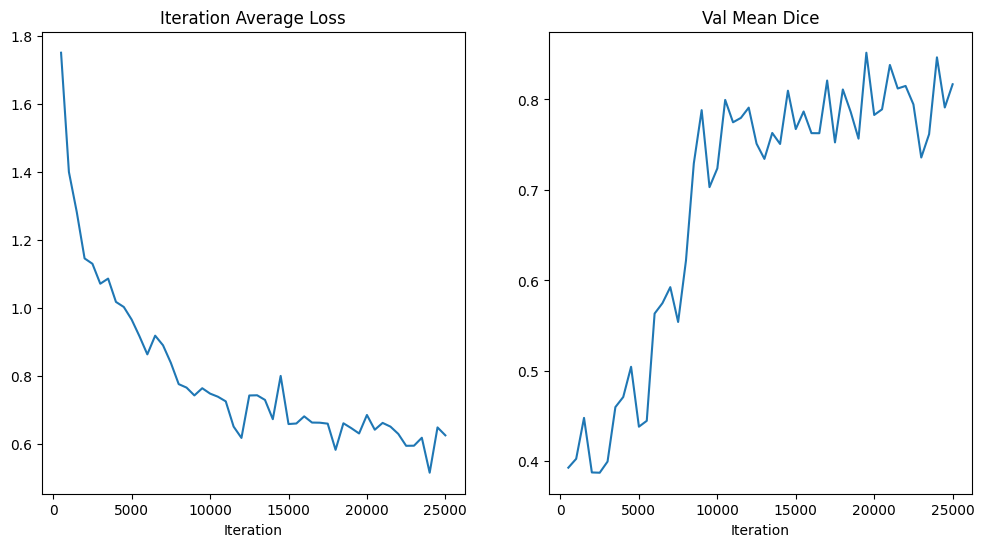

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.71508): 100%|█| 24/24 [00:14<00:00,  1.71it/
Training (47 / 25000 Steps) (loss=2.50662): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (71 / 25000 Steps) (loss=2.43121): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (95 / 25000 Steps) (loss=2.33183): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (119 / 25000 Steps) (loss=2.27165): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (143 / 25000 Steps) (loss=2.27526): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (167 / 25000 Steps) (loss=2.18328): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (191 / 25000 Steps) (loss=2.26009): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (215 / 25000 Steps) (loss=2.21605): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (239 / 25000 Steps) (loss=2.25433): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (263 / 25000 Steps) (loss=2.13613): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (287 / 25000 Steps) (loss=2.10709): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.363859623670578 Current Avg. Dice: 0.363859623670578


Training (503 / 25000 Steps) (loss=1.84151): 100%|█| 24/24 [00:16<00:00,  1.47it
Training (527 / 25000 Steps) (loss=1.87726): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (551 / 25000 Steps) (loss=1.83000): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (575 / 25000 Steps) (loss=1.76525): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (599 / 25000 Steps) (loss=1.80703): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (623 / 25000 Steps) (loss=1.78675): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (647 / 25000 Steps) (loss=1.81485): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (671 / 25000 Steps) (loss=1.66706): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (695 / 25000 Steps) (loss=1.57793): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (719 / 25000 Steps) (loss=1.64002): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (743 / 25000 Steps) (loss=1.81302): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (767 / 25000 Steps) (loss=1.65685): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3868909776210785 Current Avg. Dice: 0.3868909776210785


Training (1007 / 25000 Steps) (loss=1.69310): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (1031 / 25000 Steps) (loss=1.62811): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1055 / 25000 Steps) (loss=1.44686): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1079 / 25000 Steps) (loss=1.52523): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1103 / 25000 Steps) (loss=1.47645): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1127 / 25000 Steps) (loss=1.70084): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1151 / 25000 Steps) (loss=1.55013): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1175 / 25000 Steps) (loss=1.55257): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1199 / 25000 Steps) (loss=1.43417): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1223 / 25000 Steps) (loss=1.49893): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1247 / 25000 Steps) (loss=1.38567): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1271 / 25000 Steps) (loss=1.46121): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3868909776210785 Current Avg. Dice: 0.38659510016441345


Training (1511 / 25000 Steps) (loss=1.24977): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (1535 / 25000 Steps) (loss=1.38297): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1559 / 25000 Steps) (loss=1.32693): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1583 / 25000 Steps) (loss=1.30059): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1607 / 25000 Steps) (loss=1.58782): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1631 / 25000 Steps) (loss=1.22377): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1655 / 25000 Steps) (loss=1.28256): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1679 / 25000 Steps) (loss=1.28795): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1703 / 25000 Steps) (loss=1.27047): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1727 / 25000 Steps) (loss=1.29754): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1751 / 25000 Steps) (loss=1.24036): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1775 / 25000 Steps) (loss=1.19972): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4103337228298187 Current Avg. Dice: 0.4103337228298187


Training (2015 / 25000 Steps) (loss=1.12145): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (2039 / 25000 Steps) (loss=1.22866): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2063 / 25000 Steps) (loss=1.17235): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2087 / 25000 Steps) (loss=1.11575): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2111 / 25000 Steps) (loss=1.05052): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2135 / 25000 Steps) (loss=1.07072): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2159 / 25000 Steps) (loss=1.11583): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2183 / 25000 Steps) (loss=1.17128): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2207 / 25000 Steps) (loss=1.30255): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2231 / 25000 Steps) (loss=1.07562): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2255 / 25000 Steps) (loss=1.09840): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2279 / 25000 Steps) (loss=1.07957): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4711075723171234 Current Avg. Dice: 0.4711075723171234


Training (2519 / 25000 Steps) (loss=1.10953): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (2543 / 25000 Steps) (loss=1.10826): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2567 / 25000 Steps) (loss=1.53154): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2591 / 25000 Steps) (loss=1.00086): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2615 / 25000 Steps) (loss=1.09521): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2639 / 25000 Steps) (loss=1.01389): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2663 / 25000 Steps) (loss=1.02975): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2687 / 25000 Steps) (loss=1.19733): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2711 / 25000 Steps) (loss=1.06419): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2735 / 25000 Steps) (loss=1.03481): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2759 / 25000 Steps) (loss=1.15153): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2783 / 25000 Steps) (loss=1.10652): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.543086051940918 Current Avg. Dice: 0.543086051940918


Training (3023 / 25000 Steps) (loss=1.21436): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (3047 / 25000 Steps) (loss=1.09676): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3071 / 25000 Steps) (loss=1.07362): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3095 / 25000 Steps) (loss=1.14481): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3119 / 25000 Steps) (loss=0.99535): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3143 / 25000 Steps) (loss=1.04295): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3167 / 25000 Steps) (loss=1.07673): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3191 / 25000 Steps) (loss=0.92138): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3215 / 25000 Steps) (loss=1.42180): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3239 / 25000 Steps) (loss=1.00504): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3263 / 25000 Steps) (loss=0.97743): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3287 / 25000 Steps) (loss=1.03445): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.543086051940918 Current Avg. Dice: 0.49121537804603577


Training (3503 / 25000 Steps) (loss=1.04137): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (3527 / 25000 Steps) (loss=0.89428): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3551 / 25000 Steps) (loss=1.02943): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (3575 / 25000 Steps) (loss=1.00892): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3599 / 25000 Steps) (loss=0.97343): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3623 / 25000 Steps) (loss=1.06392): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3647 / 25000 Steps) (loss=1.02046): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3671 / 25000 Steps) (loss=0.92659): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3695 / 25000 Steps) (loss=1.00243): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3719 / 25000 Steps) (loss=0.96386): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3743 / 25000 Steps) (loss=0.88671): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3767 / 25000 Steps) (loss=1.07569): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.543086051940918 Current Avg. Dice: 0.5325316786766052


Training (4007 / 25000 Steps) (loss=0.83253): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (4031 / 25000 Steps) (loss=1.02330): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4055 / 25000 Steps) (loss=1.25805): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4079 / 25000 Steps) (loss=0.90113): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4103 / 25000 Steps) (loss=0.89532): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4127 / 25000 Steps) (loss=0.95533): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4151 / 25000 Steps) (loss=0.96828): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4175 / 25000 Steps) (loss=1.00444): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4199 / 25000 Steps) (loss=0.95488): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4223 / 25000 Steps) (loss=1.02268): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4247 / 25000 Steps) (loss=1.01054): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4271 / 25000 Steps) (loss=1.00148): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6342735886573792 Current Avg. Dice: 0.6342735886573792


Training (4511 / 25000 Steps) (loss=0.94351): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (4535 / 25000 Steps) (loss=0.95073): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4559 / 25000 Steps) (loss=1.24128): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4583 / 25000 Steps) (loss=0.92926): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4607 / 25000 Steps) (loss=1.20506): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4631 / 25000 Steps) (loss=0.94186): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4655 / 25000 Steps) (loss=0.81827): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4679 / 25000 Steps) (loss=0.76308): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4703 / 25000 Steps) (loss=1.03459): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4727 / 25000 Steps) (loss=0.92920): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4751 / 25000 Steps) (loss=1.04595): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4775 / 25000 Steps) (loss=1.05128): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6342735886573792 Current Avg. Dice: 0.5540969967842102


Training (5015 / 25000 Steps) (loss=0.95733): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (5039 / 25000 Steps) (loss=0.87527): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5063 / 25000 Steps) (loss=1.06351): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (5087 / 25000 Steps) (loss=0.86167): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5111 / 25000 Steps) (loss=0.86219): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5135 / 25000 Steps) (loss=0.84725): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (5159 / 25000 Steps) (loss=0.90781): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5183 / 25000 Steps) (loss=0.84324): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5207 / 25000 Steps) (loss=1.10391): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5231 / 25000 Steps) (loss=0.98373): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5255 / 25000 Steps) (loss=0.87933): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5279 / 25000 Steps) (loss=0.93247): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6698233485221863 Current Avg. Dice: 0.6698233485221863


Training (5519 / 25000 Steps) (loss=0.79499): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (5543 / 25000 Steps) (loss=0.93783): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5567 / 25000 Steps) (loss=0.85204): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5591 / 25000 Steps) (loss=0.90688): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5615 / 25000 Steps) (loss=0.79222): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5639 / 25000 Steps) (loss=0.83623): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5663 / 25000 Steps) (loss=0.92534): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5687 / 25000 Steps) (loss=0.97913): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5711 / 25000 Steps) (loss=0.89625): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5735 / 25000 Steps) (loss=1.08068): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5759 / 25000 Steps) (loss=0.92672): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5783 / 25000 Steps) (loss=0.79644): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6698233485221863 Current Avg. Dice: 0.5637719035148621


Training (6023 / 25000 Steps) (loss=0.87934): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (6047 / 25000 Steps) (loss=0.95415): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6071 / 25000 Steps) (loss=0.92178): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6095 / 25000 Steps) (loss=0.98304): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6119 / 25000 Steps) (loss=0.87298): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6143 / 25000 Steps) (loss=0.85425): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6167 / 25000 Steps) (loss=0.91021): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6191 / 25000 Steps) (loss=0.89576): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6215 / 25000 Steps) (loss=0.86715): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6239 / 25000 Steps) (loss=0.87359): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6263 / 25000 Steps) (loss=0.85834): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6287 / 25000 Steps) (loss=0.96024): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6698233485221863 Current Avg. Dice: 0.5967703461647034


Training (6503 / 25000 Steps) (loss=0.90259): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (6527 / 25000 Steps) (loss=0.80842): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6551 / 25000 Steps) (loss=0.68539): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6575 / 25000 Steps) (loss=0.74892): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6599 / 25000 Steps) (loss=0.77673): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6623 / 25000 Steps) (loss=0.95243): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6647 / 25000 Steps) (loss=0.90621): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6671 / 25000 Steps) (loss=0.88972): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6695 / 25000 Steps) (loss=0.80965): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6719 / 25000 Steps) (loss=0.80584): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6743 / 25000 Steps) (loss=0.82991): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6767 / 25000 Steps) (loss=0.88545): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6927142143249512 Current Avg. Dice: 0.6927142143249512


Training (7007 / 25000 Steps) (loss=0.71201): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (7031 / 25000 Steps) (loss=0.91765): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7055 / 25000 Steps) (loss=1.06376): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7079 / 25000 Steps) (loss=0.74163): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7103 / 25000 Steps) (loss=0.79604): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7127 / 25000 Steps) (loss=0.68170): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7151 / 25000 Steps) (loss=1.26332): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7175 / 25000 Steps) (loss=0.83838): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7199 / 25000 Steps) (loss=0.67565): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7223 / 25000 Steps) (loss=0.88907): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7247 / 25000 Steps) (loss=0.73818): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7271 / 25000 Steps) (loss=0.97840): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6927142143249512 Current Avg. Dice: 0.6715169548988342


Training (7511 / 25000 Steps) (loss=0.75416): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (7535 / 25000 Steps) (loss=0.61771): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7559 / 25000 Steps) (loss=0.85266): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7583 / 25000 Steps) (loss=0.68953): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7607 / 25000 Steps) (loss=0.79514): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7631 / 25000 Steps) (loss=0.88430): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7655 / 25000 Steps) (loss=0.59352): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7679 / 25000 Steps) (loss=0.85520): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7703 / 25000 Steps) (loss=0.72103): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7727 / 25000 Steps) (loss=0.79370): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (7751 / 25000 Steps) (loss=0.63463): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7775 / 25000 Steps) (loss=1.05141): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7228734493255615 Current Avg. Dice: 0.7228734493255615


Training (8015 / 25000 Steps) (loss=0.72157): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (8039 / 25000 Steps) (loss=0.87813): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8063 / 25000 Steps) (loss=0.81634): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8087 / 25000 Steps) (loss=0.55459): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8111 / 25000 Steps) (loss=0.75466): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8135 / 25000 Steps) (loss=0.85062): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8159 / 25000 Steps) (loss=0.68022): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8183 / 25000 Steps) (loss=0.66921): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8207 / 25000 Steps) (loss=0.70172): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8231 / 25000 Steps) (loss=0.81526): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8255 / 25000 Steps) (loss=0.70946): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8279 / 25000 Steps) (loss=1.08232): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7228734493255615 Current Avg. Dice: 0.6997703909873962


Training (8519 / 25000 Steps) (loss=0.56448): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (8543 / 25000 Steps) (loss=0.58476): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8567 / 25000 Steps) (loss=0.77483): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8591 / 25000 Steps) (loss=0.96371): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8615 / 25000 Steps) (loss=0.78239): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8639 / 25000 Steps) (loss=0.76356): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8663 / 25000 Steps) (loss=0.66630): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8687 / 25000 Steps) (loss=0.78778): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8711 / 25000 Steps) (loss=0.73905): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8735 / 25000 Steps) (loss=0.85425): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8759 / 25000 Steps) (loss=0.48657): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8783 / 25000 Steps) (loss=0.67603): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7228734493255615 Current Avg. Dice: 0.6867831349372864


Training (9023 / 25000 Steps) (loss=0.69778): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (9047 / 25000 Steps) (loss=0.57833): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9071 / 25000 Steps) (loss=0.92794): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9095 / 25000 Steps) (loss=0.72078): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9119 / 25000 Steps) (loss=0.76505): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9143 / 25000 Steps) (loss=0.52781): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9167 / 25000 Steps) (loss=0.77304): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9191 / 25000 Steps) (loss=0.61508): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9215 / 25000 Steps) (loss=0.73003): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9239 / 25000 Steps) (loss=0.77912): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9263 / 25000 Steps) (loss=0.79732): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9287 / 25000 Steps) (loss=0.57190): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7228734493255615 Current Avg. Dice: 0.7055222392082214


Training (9503 / 25000 Steps) (loss=0.72565): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (9527 / 25000 Steps) (loss=0.96956): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9551 / 25000 Steps) (loss=0.59428): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9575 / 25000 Steps) (loss=0.79640): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9599 / 25000 Steps) (loss=0.69703): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9623 / 25000 Steps) (loss=0.54916): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9647 / 25000 Steps) (loss=0.72360): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9671 / 25000 Steps) (loss=0.60059): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9695 / 25000 Steps) (loss=0.85938): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9719 / 25000 Steps) (loss=0.82791): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9743 / 25000 Steps) (loss=0.66558): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9767 / 25000 Steps) (loss=0.83511): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7228734493255615 Current Avg. Dice: 0.700411319732666


Training (10007 / 25000 Steps) (loss=0.92638): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10031 / 25000 Steps) (loss=0.69836): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10055 / 25000 Steps) (loss=0.47247): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10079 / 25000 Steps) (loss=0.68727): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10103 / 25000 Steps) (loss=0.80084): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10127 / 25000 Steps) (loss=0.71438): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10151 / 25000 Steps) (loss=0.88730): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10175 / 25000 Steps) (loss=0.71899): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10199 / 25000 Steps) (loss=0.76896): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10223 / 25000 Steps) (loss=0.67680): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10247 / 25000 Steps) (loss=0.70677): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10271 / 25000 Steps) (loss=0.71695): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7291164398193359 Current Avg. Dice: 0.7291164398193359


Training (10511 / 25000 Steps) (loss=0.61836): 100%|█| 24/24 [00:16<00:00,  1.44
Training (10535 / 25000 Steps) (loss=0.56242): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10559 / 25000 Steps) (loss=0.79248): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10583 / 25000 Steps) (loss=0.69827): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10607 / 25000 Steps) (loss=0.63996): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10631 / 25000 Steps) (loss=0.61614): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10655 / 25000 Steps) (loss=0.71628): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10679 / 25000 Steps) (loss=0.81514): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10703 / 25000 Steps) (loss=0.91092): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10727 / 25000 Steps) (loss=0.71804): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10751 / 25000 Steps) (loss=0.72884): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10775 / 25000 Steps) (loss=0.78821): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7291164398193359 Current Avg. Dice: 0.6933353543281555


Training (11015 / 25000 Steps) (loss=0.60488): 100%|█| 24/24 [00:13<00:00,  1.84
Training (11039 / 25000 Steps) (loss=0.87380): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11063 / 25000 Steps) (loss=0.88430): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11087 / 25000 Steps) (loss=0.81877): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11111 / 25000 Steps) (loss=0.61987): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11135 / 25000 Steps) (loss=0.92150): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11159 / 25000 Steps) (loss=0.55196): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11183 / 25000 Steps) (loss=0.61385): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11207 / 25000 Steps) (loss=0.81999): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11231 / 25000 Steps) (loss=0.55441): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11255 / 25000 Steps) (loss=0.61728): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11279 / 25000 Steps) (loss=0.53265): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7291164398193359 Current Avg. Dice: 0.638059139251709


Training (11519 / 25000 Steps) (loss=0.77803): 100%|█| 24/24 [00:13<00:00,  1.84
Training (11543 / 25000 Steps) (loss=0.62538): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11567 / 25000 Steps) (loss=0.57776): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11591 / 25000 Steps) (loss=0.78152): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11615 / 25000 Steps) (loss=0.62296): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11639 / 25000 Steps) (loss=0.68332): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11663 / 25000 Steps) (loss=0.78589): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11687 / 25000 Steps) (loss=0.52423): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11711 / 25000 Steps) (loss=0.76148): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11735 / 25000 Steps) (loss=1.18683): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11759 / 25000 Steps) (loss=0.69684): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11783 / 25000 Steps) (loss=0.50535): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7325021624565125 Current Avg. Dice: 0.7325021624565125


Training (12023 / 25000 Steps) (loss=0.69395): 100%|█| 24/24 [00:16<00:00,  1.46
Training (12047 / 25000 Steps) (loss=0.49630): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12071 / 25000 Steps) (loss=0.50106): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12095 / 25000 Steps) (loss=0.64881): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12119 / 25000 Steps) (loss=0.66939): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12143 / 25000 Steps) (loss=0.68978): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12167 / 25000 Steps) (loss=0.70038): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12191 / 25000 Steps) (loss=0.66391): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12215 / 25000 Steps) (loss=0.78746): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12239 / 25000 Steps) (loss=0.74450): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12263 / 25000 Steps) (loss=0.74849): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12287 / 25000 Steps) (loss=0.54603): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7325021624565125 Current Avg. Dice: 0.6666130423545837


Training (12503 / 25000 Steps) (loss=0.70945): 100%|█| 24/24 [00:13<00:00,  1.84
Training (12527 / 25000 Steps) (loss=0.58202): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12551 / 25000 Steps) (loss=0.74068): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12575 / 25000 Steps) (loss=0.51334): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12599 / 25000 Steps) (loss=0.78763): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12623 / 25000 Steps) (loss=0.64469): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12647 / 25000 Steps) (loss=0.47437): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12671 / 25000 Steps) (loss=0.86611): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12695 / 25000 Steps) (loss=0.59225): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12719 / 25000 Steps) (loss=0.61251): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12743 / 25000 Steps) (loss=0.66237): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12767 / 25000 Steps) (loss=0.62163): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7415688633918762 Current Avg. Dice: 0.7415688633918762


Training (13007 / 25000 Steps) (loss=0.59745): 100%|█| 24/24 [00:16<00:00,  1.43
Training (13031 / 25000 Steps) (loss=0.87670): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13055 / 25000 Steps) (loss=0.66351): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13079 / 25000 Steps) (loss=0.68504): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13103 / 25000 Steps) (loss=0.69744): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13127 / 25000 Steps) (loss=0.80901): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13151 / 25000 Steps) (loss=0.69602): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13175 / 25000 Steps) (loss=0.96506): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13199 / 25000 Steps) (loss=0.77311): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13223 / 25000 Steps) (loss=0.50153): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13247 / 25000 Steps) (loss=0.86717): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13271 / 25000 Steps) (loss=0.62143): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.7600117325782776


Training (13511 / 25000 Steps) (loss=0.77563): 100%|█| 24/24 [00:16<00:00,  1.43
Training (13535 / 25000 Steps) (loss=0.44214): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13559 / 25000 Steps) (loss=0.65493): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13583 / 25000 Steps) (loss=0.97772): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13607 / 25000 Steps) (loss=0.79430): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13631 / 25000 Steps) (loss=0.76596): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13655 / 25000 Steps) (loss=0.68383): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13679 / 25000 Steps) (loss=0.63878): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13703 / 25000 Steps) (loss=0.73845): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13727 / 25000 Steps) (loss=0.67674): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13751 / 25000 Steps) (loss=0.57809): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13775 / 25000 Steps) (loss=0.63563): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.7217481732368469


Training (14015 / 25000 Steps) (loss=0.57777): 100%|█| 24/24 [00:13<00:00,  1.83
Training (14039 / 25000 Steps) (loss=0.79403): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14063 / 25000 Steps) (loss=0.77779): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14087 / 25000 Steps) (loss=0.78698): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14111 / 25000 Steps) (loss=0.42251): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14135 / 25000 Steps) (loss=0.94572): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14159 / 25000 Steps) (loss=0.48189): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14183 / 25000 Steps) (loss=0.83778): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14207 / 25000 Steps) (loss=0.50346): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14231 / 25000 Steps) (loss=0.57725): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14255 / 25000 Steps) (loss=0.47052): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14279 / 25000 Steps) (loss=0.59979): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.7492720484733582


Training (14519 / 25000 Steps) (loss=0.48185): 100%|█| 24/24 [00:13<00:00,  1.84
Training (14543 / 25000 Steps) (loss=0.69399): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14567 / 25000 Steps) (loss=0.64499): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14591 / 25000 Steps) (loss=0.70710): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14615 / 25000 Steps) (loss=0.68922): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14639 / 25000 Steps) (loss=0.53338): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14663 / 25000 Steps) (loss=0.87202): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14687 / 25000 Steps) (loss=0.66040): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14711 / 25000 Steps) (loss=0.76059): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14735 / 25000 Steps) (loss=0.77558): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14759 / 25000 Steps) (loss=0.74045): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14783 / 25000 Steps) (loss=0.63207): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.729252815246582


Training (15023 / 25000 Steps) (loss=0.45187): 100%|█| 24/24 [00:13<00:00,  1.84
Training (15047 / 25000 Steps) (loss=0.69323): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15071 / 25000 Steps) (loss=0.73205): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15095 / 25000 Steps) (loss=0.75535): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15119 / 25000 Steps) (loss=0.74259): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15143 / 25000 Steps) (loss=0.72325): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15167 / 25000 Steps) (loss=1.15166): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15191 / 25000 Steps) (loss=0.54925): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15215 / 25000 Steps) (loss=0.63948): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15239 / 25000 Steps) (loss=0.72564): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15263 / 25000 Steps) (loss=0.48673): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15287 / 25000 Steps) (loss=0.61973): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.6599848866462708


Training (15503 / 25000 Steps) (loss=0.63029): 100%|█| 24/24 [00:13<00:00,  1.83
Training (15527 / 25000 Steps) (loss=0.67342): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15551 / 25000 Steps) (loss=0.83127): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15575 / 25000 Steps) (loss=0.67115): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15599 / 25000 Steps) (loss=0.64798): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15623 / 25000 Steps) (loss=0.56374): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15647 / 25000 Steps) (loss=0.58649): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15671 / 25000 Steps) (loss=0.78249): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15695 / 25000 Steps) (loss=0.49707): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15719 / 25000 Steps) (loss=0.62289): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15743 / 25000 Steps) (loss=0.68715): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15767 / 25000 Steps) (loss=0.66114): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.7471281886100769


Training (16007 / 25000 Steps) (loss=0.80531): 100%|█| 24/24 [00:13<00:00,  1.83
Training (16031 / 25000 Steps) (loss=0.69001): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16055 / 25000 Steps) (loss=0.45299): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16079 / 25000 Steps) (loss=0.70852): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16103 / 25000 Steps) (loss=0.76951): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16127 / 25000 Steps) (loss=0.76600): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16151 / 25000 Steps) (loss=0.67631): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16175 / 25000 Steps) (loss=0.73868): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16199 / 25000 Steps) (loss=0.62861): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16223 / 25000 Steps) (loss=0.86511): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16247 / 25000 Steps) (loss=0.66065): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16271 / 25000 Steps) (loss=0.59411): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.7454296946525574


Training (16511 / 25000 Steps) (loss=0.71569): 100%|█| 24/24 [00:13<00:00,  1.84
Training (16535 / 25000 Steps) (loss=0.84228): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16559 / 25000 Steps) (loss=0.63967): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16583 / 25000 Steps) (loss=0.51234): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16607 / 25000 Steps) (loss=0.54838): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16631 / 25000 Steps) (loss=0.70221): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16655 / 25000 Steps) (loss=0.38756): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16679 / 25000 Steps) (loss=0.52905): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16703 / 25000 Steps) (loss=0.68035): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16727 / 25000 Steps) (loss=0.67144): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16751 / 25000 Steps) (loss=0.74405): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16775 / 25000 Steps) (loss=0.59237): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7600117325782776 Current Avg. Dice: 0.6990153789520264


Training (17015 / 25000 Steps) (loss=0.68035): 100%|█| 24/24 [00:13<00:00,  1.84
Training (17039 / 25000 Steps) (loss=0.62875): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17063 / 25000 Steps) (loss=0.61376): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17087 / 25000 Steps) (loss=0.64807): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17111 / 25000 Steps) (loss=0.70158): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17135 / 25000 Steps) (loss=0.51658): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17159 / 25000 Steps) (loss=0.68757): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17183 / 25000 Steps) (loss=0.41214): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17207 / 25000 Steps) (loss=0.75718): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17231 / 25000 Steps) (loss=0.59902): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17255 / 25000 Steps) (loss=0.56363): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17279 / 25000 Steps) (loss=0.69972): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7627787590026855 Current Avg. Dice: 0.7627787590026855


Training (17519 / 25000 Steps) (loss=0.78563): 100%|█| 24/24 [00:17<00:00,  1.40
Training (17543 / 25000 Steps) (loss=0.66403): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17567 / 25000 Steps) (loss=0.44301): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17591 / 25000 Steps) (loss=0.60227): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17615 / 25000 Steps) (loss=0.55071): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17639 / 25000 Steps) (loss=0.59748): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17663 / 25000 Steps) (loss=0.62226): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17687 / 25000 Steps) (loss=0.55482): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17711 / 25000 Steps) (loss=0.70005): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17735 / 25000 Steps) (loss=0.48500): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17759 / 25000 Steps) (loss=0.58130): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17783 / 25000 Steps) (loss=0.54372): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7757528424263


Training (18023 / 25000 Steps) (loss=0.53068): 100%|█| 24/24 [00:17<00:00,  1.40
Training (18047 / 25000 Steps) (loss=0.78734): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18071 / 25000 Steps) (loss=0.50751): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18095 / 25000 Steps) (loss=0.64296): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18119 / 25000 Steps) (loss=0.67133): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18143 / 25000 Steps) (loss=0.51834): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18167 / 25000 Steps) (loss=0.43332): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18191 / 25000 Steps) (loss=0.73520): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18215 / 25000 Steps) (loss=0.67648): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18239 / 25000 Steps) (loss=0.69935): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18263 / 25000 Steps) (loss=0.67241): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18287 / 25000 Steps) (loss=0.47157): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7191462516784668


Training (18503 / 25000 Steps) (loss=0.85241): 100%|█| 24/24 [00:13<00:00,  1.83
Training (18527 / 25000 Steps) (loss=0.63524): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18551 / 25000 Steps) (loss=0.61009): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18575 / 25000 Steps) (loss=0.62831): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18599 / 25000 Steps) (loss=0.50363): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18623 / 25000 Steps) (loss=0.57772): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18647 / 25000 Steps) (loss=0.77957): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18671 / 25000 Steps) (loss=0.43471): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18695 / 25000 Steps) (loss=0.63796): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18719 / 25000 Steps) (loss=0.52411): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18743 / 25000 Steps) (loss=1.32857): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18767 / 25000 Steps) (loss=0.55497): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7222298979759216


Training (19007 / 25000 Steps) (loss=0.58631): 100%|█| 24/24 [00:13<00:00,  1.83
Training (19031 / 25000 Steps) (loss=0.42526): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19055 / 25000 Steps) (loss=0.52149): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19079 / 25000 Steps) (loss=0.56795): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19103 / 25000 Steps) (loss=0.59321): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19127 / 25000 Steps) (loss=0.77533): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19151 / 25000 Steps) (loss=0.65428): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19175 / 25000 Steps) (loss=0.49406): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19199 / 25000 Steps) (loss=0.68534): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19223 / 25000 Steps) (loss=0.77967): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19247 / 25000 Steps) (loss=0.71892): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19271 / 25000 Steps) (loss=0.55555): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7285202145576477


Training (19511 / 25000 Steps) (loss=0.72873): 100%|█| 24/24 [00:13<00:00,  1.84
Training (19535 / 25000 Steps) (loss=0.58529): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19559 / 25000 Steps) (loss=0.71331): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19583 / 25000 Steps) (loss=0.57364): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19607 / 25000 Steps) (loss=0.59421): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19631 / 25000 Steps) (loss=0.58688): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19655 / 25000 Steps) (loss=0.79033): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19679 / 25000 Steps) (loss=0.51851): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19703 / 25000 Steps) (loss=0.42619): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19727 / 25000 Steps) (loss=0.82200): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19751 / 25000 Steps) (loss=0.50993): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19775 / 25000 Steps) (loss=0.69812): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7705977559089661


Training (20015 / 25000 Steps) (loss=0.47349): 100%|█| 24/24 [00:13<00:00,  1.83
Training (20039 / 25000 Steps) (loss=0.63645): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20063 / 25000 Steps) (loss=0.43942): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20087 / 25000 Steps) (loss=0.69211): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20111 / 25000 Steps) (loss=0.47968): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20135 / 25000 Steps) (loss=0.57764): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20159 / 25000 Steps) (loss=0.62343): 100%|█| 24/24 [00:11<00:00,  2.06
Training (20183 / 25000 Steps) (loss=0.54105): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20207 / 25000 Steps) (loss=0.58019): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20231 / 25000 Steps) (loss=0.43042): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20255 / 25000 Steps) (loss=0.78122): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20279 / 25000 Steps) (loss=0.77146): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7389598488807678


Training (20519 / 25000 Steps) (loss=0.44946): 100%|█| 24/24 [00:13<00:00,  1.84
Training (20543 / 25000 Steps) (loss=0.55380): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20567 / 25000 Steps) (loss=0.68745): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20591 / 25000 Steps) (loss=0.73651): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20615 / 25000 Steps) (loss=0.73476): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20639 / 25000 Steps) (loss=0.63353): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20663 / 25000 Steps) (loss=0.73309): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20687 / 25000 Steps) (loss=0.69461): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20711 / 25000 Steps) (loss=0.56442): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20735 / 25000 Steps) (loss=0.39992): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20759 / 25000 Steps) (loss=0.45468): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20783 / 25000 Steps) (loss=0.67491): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.6985700726509094


Training (21023 / 25000 Steps) (loss=0.59113): 100%|█| 24/24 [00:13<00:00,  1.84
Training (21047 / 25000 Steps) (loss=0.69418): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21071 / 25000 Steps) (loss=0.34923): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21095 / 25000 Steps) (loss=0.68050): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21119 / 25000 Steps) (loss=0.52727): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21143 / 25000 Steps) (loss=0.60018): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21167 / 25000 Steps) (loss=0.66018): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21191 / 25000 Steps) (loss=0.63397): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21215 / 25000 Steps) (loss=0.63591): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21239 / 25000 Steps) (loss=0.65838): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21263 / 25000 Steps) (loss=0.80372): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21287 / 25000 Steps) (loss=0.58901): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7731878757476807


Training (21503 / 25000 Steps) (loss=0.82457): 100%|█| 24/24 [00:13<00:00,  1.83
Training (21527 / 25000 Steps) (loss=0.53962): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21551 / 25000 Steps) (loss=0.67610): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21575 / 25000 Steps) (loss=0.59560): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21599 / 25000 Steps) (loss=0.64131): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21623 / 25000 Steps) (loss=0.63557): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21647 / 25000 Steps) (loss=1.05191): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21671 / 25000 Steps) (loss=0.57893): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21695 / 25000 Steps) (loss=0.47481): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21719 / 25000 Steps) (loss=0.66043): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21743 / 25000 Steps) (loss=0.66860): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21767 / 25000 Steps) (loss=0.61276): 100%|█| 24/24 [00:11<00:00,  2.06
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7309449315071106


Training (22007 / 25000 Steps) (loss=0.73875): 100%|█| 24/24 [00:13<00:00,  1.83
Training (22031 / 25000 Steps) (loss=0.66971): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22055 / 25000 Steps) (loss=0.73277): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22079 / 25000 Steps) (loss=0.71945): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22103 / 25000 Steps) (loss=0.65007): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22127 / 25000 Steps) (loss=0.55233): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22151 / 25000 Steps) (loss=0.71109): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22175 / 25000 Steps) (loss=0.59963): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22199 / 25000 Steps) (loss=0.49171): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22223 / 25000 Steps) (loss=0.44305): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22247 / 25000 Steps) (loss=0.63396): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22271 / 25000 Steps) (loss=0.65599): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7483248114585876


Training (22511 / 25000 Steps) (loss=0.87678): 100%|█| 24/24 [00:13<00:00,  1.83
Training (22535 / 25000 Steps) (loss=0.64269): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22559 / 25000 Steps) (loss=0.57987): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22583 / 25000 Steps) (loss=0.53856): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22607 / 25000 Steps) (loss=0.67134): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22631 / 25000 Steps) (loss=0.49644): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22655 / 25000 Steps) (loss=0.75942): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22679 / 25000 Steps) (loss=0.49444): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22703 / 25000 Steps) (loss=0.68253): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22727 / 25000 Steps) (loss=0.64545): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22751 / 25000 Steps) (loss=0.78023): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22775 / 25000 Steps) (loss=0.76019): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.697077751159668


Training (23015 / 25000 Steps) (loss=0.63405): 100%|█| 24/24 [00:13<00:00,  1.83
Training (23039 / 25000 Steps) (loss=0.83134): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23063 / 25000 Steps) (loss=0.58655): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23087 / 25000 Steps) (loss=0.73206): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23111 / 25000 Steps) (loss=0.58285): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23135 / 25000 Steps) (loss=0.55791): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23159 / 25000 Steps) (loss=0.49852): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23183 / 25000 Steps) (loss=0.58520): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23207 / 25000 Steps) (loss=0.69144): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23231 / 25000 Steps) (loss=0.52030): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23255 / 25000 Steps) (loss=0.69929): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23279 / 25000 Steps) (loss=0.59004): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.7685087323188782


Training (23519 / 25000 Steps) (loss=0.59748): 100%|█| 24/24 [00:13<00:00,  1.84
Training (23543 / 25000 Steps) (loss=0.74144): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23567 / 25000 Steps) (loss=0.84447): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23591 / 25000 Steps) (loss=0.76050): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23615 / 25000 Steps) (loss=0.62935): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23639 / 25000 Steps) (loss=0.47616): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23663 / 25000 Steps) (loss=0.65440): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23687 / 25000 Steps) (loss=0.70875): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23711 / 25000 Steps) (loss=0.57602): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23735 / 25000 Steps) (loss=0.73354): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23759 / 25000 Steps) (loss=0.47235): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23783 / 25000 Steps) (loss=0.60988): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7757528424263 Current Avg. Dice: 0.713972270488739


Training (24023 / 25000 Steps) (loss=0.57494): 100%|█| 24/24 [00:13<00:00,  1.83
Training (24047 / 25000 Steps) (loss=0.79444): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24071 / 25000 Steps) (loss=0.55547): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24095 / 25000 Steps) (loss=0.50115): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24119 / 25000 Steps) (loss=0.67747): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24143 / 25000 Steps) (loss=0.56438): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24167 / 25000 Steps) (loss=0.51293): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24191 / 25000 Steps) (loss=0.60894): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24215 / 25000 Steps) (loss=0.63236): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24239 / 25000 Steps) (loss=0.78223): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24263 / 25000 Steps) (loss=0.59674): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24287 / 25000 Steps) (loss=0.62813): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7844216227531433 Current Avg. Dice: 0.7844216227531433


Training (24503 / 25000 Steps) (loss=0.46574): 100%|█| 24/24 [00:16<00:00,  1.45
Training (24527 / 25000 Steps) (loss=0.65964): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24551 / 25000 Steps) (loss=0.43796): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24575 / 25000 Steps) (loss=0.71496): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24599 / 25000 Steps) (loss=0.46549): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24623 / 25000 Steps) (loss=0.53925): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24647 / 25000 Steps) (loss=0.47550): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24671 / 25000 Steps) (loss=0.72744): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24695 / 25000 Steps) (loss=0.59593): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24719 / 25000 Steps) (loss=0.47234): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24743 / 25000 Steps) (loss=0.80102): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24767 / 25000 Steps) (loss=0.66413): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7844216227531433 Current Avg. Dice: 0.6672638058662415


Training (25007 / 25000 Steps) (loss=0.49789): 100%|█| 24/24 [00:13<00:00,  1.83


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7844 at iteration: 24500


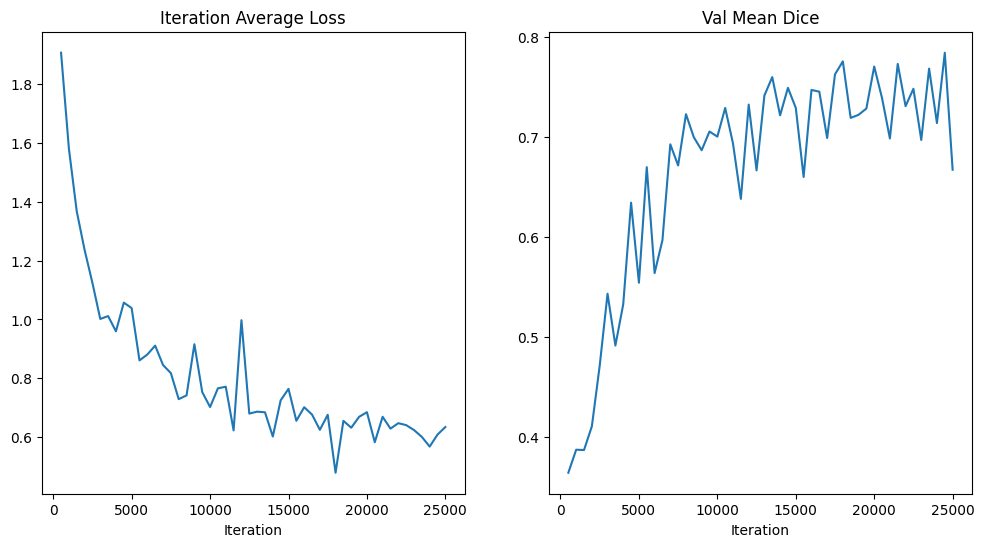

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.72296): 100%|█| 24/24 [00:13<00:00,  1.73it/
Training (47 / 25000 Steps) (loss=2.44244): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (71 / 25000 Steps) (loss=2.35468): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (95 / 25000 Steps) (loss=2.39758): 100%|█| 24/24 [00:12<00:00,  1.99it/
Training (119 / 25000 Steps) (loss=2.41449): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (143 / 25000 Steps) (loss=2.27400): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (167 / 25000 Steps) (loss=2.23756): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (191 / 25000 Steps) (loss=2.28716): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (215 / 25000 Steps) (loss=2.20874): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (239 / 25000 Steps) (loss=2.19343): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (263 / 25000 Steps) (loss=2.16948): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (287 / 25000 Steps) (loss=2.10577): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3047211170196533 Current Avg. Dice: 0.3047211170196533


Training (503 / 25000 Steps) (loss=1.96189): 100%|█| 24/24 [00:16<00:00,  1.48it
Training (527 / 25000 Steps) (loss=1.86980): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (551 / 25000 Steps) (loss=1.79810): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (575 / 25000 Steps) (loss=1.90649): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (599 / 25000 Steps) (loss=1.78469): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (623 / 25000 Steps) (loss=1.84295): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (647 / 25000 Steps) (loss=1.75920): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (671 / 25000 Steps) (loss=1.92133): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (695 / 25000 Steps) (loss=1.77830): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (719 / 25000 Steps) (loss=1.69872): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (743 / 25000 Steps) (loss=1.74721): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (767 / 25000 Steps) (loss=1.59215): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.44227275252342224 Current Avg. Dice: 0.44227275252342224


Training (1007 / 25000 Steps) (loss=1.53983): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (1031 / 25000 Steps) (loss=1.52915): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1055 / 25000 Steps) (loss=1.46109): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1079 / 25000 Steps) (loss=1.40450): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1103 / 25000 Steps) (loss=1.43019): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1127 / 25000 Steps) (loss=1.45015): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1151 / 25000 Steps) (loss=1.32674): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1175 / 25000 Steps) (loss=1.53481): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1199 / 25000 Steps) (loss=1.34507): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1223 / 25000 Steps) (loss=1.44655): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1247 / 25000 Steps) (loss=1.60276): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1271 / 25000 Steps) (loss=1.34310): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.44227275252342224 Current Avg. Dice: 0.4205601215362549


Training (1511 / 25000 Steps) (loss=1.42244): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (1535 / 25000 Steps) (loss=1.20895): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1559 / 25000 Steps) (loss=1.57066): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1583 / 25000 Steps) (loss=1.20094): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1607 / 25000 Steps) (loss=1.27777): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1631 / 25000 Steps) (loss=1.26326): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1655 / 25000 Steps) (loss=1.22598): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1679 / 25000 Steps) (loss=1.39356): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1703 / 25000 Steps) (loss=1.19195): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1727 / 25000 Steps) (loss=1.14244): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1751 / 25000 Steps) (loss=1.20624): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1775 / 25000 Steps) (loss=1.17083): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.44227275252342224 Current Avg. Dice: 0.3566482961177826


Training (2015 / 25000 Steps) (loss=1.14509): 100%|█| 24/24 [00:12<00:00,  1.85i
Training (2039 / 25000 Steps) (loss=1.08186): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2063 / 25000 Steps) (loss=1.17463): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2087 / 25000 Steps) (loss=1.15334): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2111 / 25000 Steps) (loss=1.01729): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2135 / 25000 Steps) (loss=1.19388): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2159 / 25000 Steps) (loss=1.20758): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2183 / 25000 Steps) (loss=1.07992): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2207 / 25000 Steps) (loss=1.04469): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2231 / 25000 Steps) (loss=1.33106): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2255 / 25000 Steps) (loss=1.16430): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2279 / 25000 Steps) (loss=1.19988): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4634319543838501 Current Avg. Dice: 0.4634319543838501


Training (2519 / 25000 Steps) (loss=1.15001): 100%|█| 24/24 [00:16<00:00,  1.47i
Training (2543 / 25000 Steps) (loss=1.01366): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2567 / 25000 Steps) (loss=1.27218): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2591 / 25000 Steps) (loss=1.12994): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2615 / 25000 Steps) (loss=1.15014): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2639 / 25000 Steps) (loss=1.25651): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2663 / 25000 Steps) (loss=1.08646): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2687 / 25000 Steps) (loss=1.25638): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2711 / 25000 Steps) (loss=1.08794): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2735 / 25000 Steps) (loss=1.00659): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2759 / 25000 Steps) (loss=1.03544): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2783 / 25000 Steps) (loss=1.05756): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4634319543838501 Current Avg. Dice: 0.40795645117759705


Training (3023 / 25000 Steps) (loss=0.98155): 100%|█| 24/24 [00:12<00:00,  1.85i
Training (3047 / 25000 Steps) (loss=0.98664): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3071 / 25000 Steps) (loss=0.85545): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (3095 / 25000 Steps) (loss=1.01716): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3119 / 25000 Steps) (loss=1.06730): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (3143 / 25000 Steps) (loss=0.99183): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3167 / 25000 Steps) (loss=0.89113): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (3191 / 25000 Steps) (loss=1.09874): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3215 / 25000 Steps) (loss=0.95365): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3239 / 25000 Steps) (loss=0.89689): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3263 / 25000 Steps) (loss=1.02607): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3287 / 25000 Steps) (loss=0.94581): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4634319543838501 Current Avg. Dice: 0.3901853859424591


Training (3503 / 25000 Steps) (loss=1.28703): 100%|█| 24/24 [00:12<00:00,  1.85i
Training (3527 / 25000 Steps) (loss=1.01581): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3551 / 25000 Steps) (loss=0.98556): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (3575 / 25000 Steps) (loss=0.94794): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3599 / 25000 Steps) (loss=1.07840): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3623 / 25000 Steps) (loss=0.91289): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3647 / 25000 Steps) (loss=1.06928): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3671 / 25000 Steps) (loss=0.94864): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3695 / 25000 Steps) (loss=0.96713): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3719 / 25000 Steps) (loss=0.95216): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3743 / 25000 Steps) (loss=1.05227): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (3767 / 25000 Steps) (loss=0.90826): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4774231016635895 Current Avg. Dice: 0.4774231016635895


Training (4007 / 25000 Steps) (loss=1.02577): 100%|█| 24/24 [00:16<00:00,  1.47i
Training (4031 / 25000 Steps) (loss=1.04642): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4055 / 25000 Steps) (loss=0.92714): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4079 / 25000 Steps) (loss=0.97454): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4103 / 25000 Steps) (loss=0.96508): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4127 / 25000 Steps) (loss=0.95463): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4151 / 25000 Steps) (loss=1.07966): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4175 / 25000 Steps) (loss=0.84685): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4199 / 25000 Steps) (loss=0.92942): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4223 / 25000 Steps) (loss=0.94637): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4247 / 25000 Steps) (loss=0.92259): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4271 / 25000 Steps) (loss=0.87708): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5603747963905334 Current Avg. Dice: 0.5603747963905334


Training (4511 / 25000 Steps) (loss=0.98257): 100%|█| 24/24 [00:16<00:00,  1.47i
Training (4535 / 25000 Steps) (loss=0.85205): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4559 / 25000 Steps) (loss=0.88885): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4583 / 25000 Steps) (loss=0.89636): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4607 / 25000 Steps) (loss=0.90089): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4631 / 25000 Steps) (loss=0.94904): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4655 / 25000 Steps) (loss=0.86397): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4679 / 25000 Steps) (loss=0.83697): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4703 / 25000 Steps) (loss=1.01464): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4727 / 25000 Steps) (loss=0.90636): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4751 / 25000 Steps) (loss=0.99653): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4775 / 25000 Steps) (loss=0.88949): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5603747963905334 Current Avg. Dice: 0.5371809601783752


Training (5015 / 25000 Steps) (loss=0.84706): 100%|█| 24/24 [00:13<00:00,  1.85i
Training (5039 / 25000 Steps) (loss=0.91765): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5063 / 25000 Steps) (loss=0.86744): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5087 / 25000 Steps) (loss=0.89086): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5111 / 25000 Steps) (loss=0.87398): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5135 / 25000 Steps) (loss=0.72778): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5159 / 25000 Steps) (loss=0.92140): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5183 / 25000 Steps) (loss=0.89112): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5207 / 25000 Steps) (loss=0.83422): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5231 / 25000 Steps) (loss=1.00586): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5255 / 25000 Steps) (loss=0.88639): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5279 / 25000 Steps) (loss=0.90064): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5603747963905334 Current Avg. Dice: 0.4815932512283325


Training (5519 / 25000 Steps) (loss=0.84112): 100%|█| 24/24 [00:13<00:00,  1.85i
Training (5543 / 25000 Steps) (loss=0.90492): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5567 / 25000 Steps) (loss=0.89213): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5591 / 25000 Steps) (loss=0.88190): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5615 / 25000 Steps) (loss=0.82905): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5639 / 25000 Steps) (loss=0.89473): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5663 / 25000 Steps) (loss=0.83610): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5687 / 25000 Steps) (loss=0.94815): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5711 / 25000 Steps) (loss=0.89816): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5735 / 25000 Steps) (loss=0.95006): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5759 / 25000 Steps) (loss=0.87795): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5783 / 25000 Steps) (loss=0.85546): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6275156736373901 Current Avg. Dice: 0.6275156736373901


Training (6023 / 25000 Steps) (loss=0.96396): 100%|█| 24/24 [00:16<00:00,  1.47i
Training (6047 / 25000 Steps) (loss=0.91028): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6071 / 25000 Steps) (loss=0.93701): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6095 / 25000 Steps) (loss=0.88277): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6119 / 25000 Steps) (loss=0.97168): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6143 / 25000 Steps) (loss=0.85106): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6167 / 25000 Steps) (loss=0.84492): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6191 / 25000 Steps) (loss=0.88550): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6215 / 25000 Steps) (loss=0.74312): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6239 / 25000 Steps) (loss=0.87479): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6263 / 25000 Steps) (loss=0.87235): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6287 / 25000 Steps) (loss=0.82155): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6275156736373901 Current Avg. Dice: 0.5324576497077942


Training (6503 / 25000 Steps) (loss=0.66753): 100%|█| 24/24 [00:12<00:00,  1.85i
Training (6527 / 25000 Steps) (loss=0.85061): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6551 / 25000 Steps) (loss=0.82189): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6575 / 25000 Steps) (loss=0.79566): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6599 / 25000 Steps) (loss=0.90731): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6623 / 25000 Steps) (loss=0.88320): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6647 / 25000 Steps) (loss=0.93602): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6671 / 25000 Steps) (loss=1.10751): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6695 / 25000 Steps) (loss=1.01660): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6719 / 25000 Steps) (loss=0.88502): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6743 / 25000 Steps) (loss=0.90439): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6767 / 25000 Steps) (loss=0.97153): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6275156736373901 Current Avg. Dice: 0.6049370765686035


Training (7007 / 25000 Steps) (loss=0.82010): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (7031 / 25000 Steps) (loss=0.76405): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7055 / 25000 Steps) (loss=0.75812): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7079 / 25000 Steps) (loss=0.65689): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7103 / 25000 Steps) (loss=0.79540): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7127 / 25000 Steps) (loss=0.85433): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7151 / 25000 Steps) (loss=0.68468): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7175 / 25000 Steps) (loss=0.64205): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7199 / 25000 Steps) (loss=0.82046): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7223 / 25000 Steps) (loss=0.90689): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7247 / 25000 Steps) (loss=0.78595): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7271 / 25000 Steps) (loss=0.84782): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6275156736373901 Current Avg. Dice: 0.5963131785392761


Training (7511 / 25000 Steps) (loss=0.73518): 100%|█| 24/24 [00:12<00:00,  1.85i
Training (7535 / 25000 Steps) (loss=0.91071): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7559 / 25000 Steps) (loss=0.74985): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7583 / 25000 Steps) (loss=0.88484): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7607 / 25000 Steps) (loss=0.79954): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7631 / 25000 Steps) (loss=0.65826): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7655 / 25000 Steps) (loss=0.82037): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7679 / 25000 Steps) (loss=0.79275): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7703 / 25000 Steps) (loss=0.88414): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7727 / 25000 Steps) (loss=0.87172): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (7751 / 25000 Steps) (loss=0.96423): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7775 / 25000 Steps) (loss=0.61056): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6275156736373901 Current Avg. Dice: 0.5687193870544434


Training (8015 / 25000 Steps) (loss=0.77841): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (8039 / 25000 Steps) (loss=0.78201): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8063 / 25000 Steps) (loss=0.75735): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8087 / 25000 Steps) (loss=0.68349): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8111 / 25000 Steps) (loss=0.72995): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8135 / 25000 Steps) (loss=0.74541): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8159 / 25000 Steps) (loss=0.76242): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8183 / 25000 Steps) (loss=0.75440): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8207 / 25000 Steps) (loss=0.68738): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8231 / 25000 Steps) (loss=0.83916): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8255 / 25000 Steps) (loss=0.72668): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8279 / 25000 Steps) (loss=0.63790): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6438477635383606 Current Avg. Dice: 0.6438477635383606


Training (8519 / 25000 Steps) (loss=0.87080): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (8543 / 25000 Steps) (loss=0.79381): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8567 / 25000 Steps) (loss=0.57044): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8591 / 25000 Steps) (loss=0.87160): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8615 / 25000 Steps) (loss=0.83778): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8639 / 25000 Steps) (loss=0.75393): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8663 / 25000 Steps) (loss=0.69935): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (8687 / 25000 Steps) (loss=0.72652): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8711 / 25000 Steps) (loss=0.65493): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8735 / 25000 Steps) (loss=0.84480): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8759 / 25000 Steps) (loss=0.75795): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8783 / 25000 Steps) (loss=0.63946): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6438477635383606 Current Avg. Dice: 0.6279923915863037


Training (9023 / 25000 Steps) (loss=0.77443): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (9047 / 25000 Steps) (loss=0.79579): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9071 / 25000 Steps) (loss=0.87677): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9095 / 25000 Steps) (loss=0.58762): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9119 / 25000 Steps) (loss=0.70396): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9143 / 25000 Steps) (loss=0.77396): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9167 / 25000 Steps) (loss=0.75846): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9191 / 25000 Steps) (loss=0.94994): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9215 / 25000 Steps) (loss=0.59364): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9239 / 25000 Steps) (loss=0.66387): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9263 / 25000 Steps) (loss=0.82287): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9287 / 25000 Steps) (loss=0.69180): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6438477635383606 Current Avg. Dice: 0.5781035423278809


Training (9503 / 25000 Steps) (loss=0.72248): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (9527 / 25000 Steps) (loss=0.71342): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9551 / 25000 Steps) (loss=0.71785): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9575 / 25000 Steps) (loss=0.65910): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9599 / 25000 Steps) (loss=0.75449): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9623 / 25000 Steps) (loss=0.61869): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9647 / 25000 Steps) (loss=0.83584): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9671 / 25000 Steps) (loss=0.71861): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9695 / 25000 Steps) (loss=0.75056): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9719 / 25000 Steps) (loss=0.61783): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9743 / 25000 Steps) (loss=0.73178): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9767 / 25000 Steps) (loss=0.69235): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6438477635383606 Current Avg. Dice: 0.6104604601860046


Training (10007 / 25000 Steps) (loss=0.68609): 100%|█| 24/24 [00:13<00:00,  1.81
Training (10031 / 25000 Steps) (loss=0.71430): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10055 / 25000 Steps) (loss=0.78256): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10079 / 25000 Steps) (loss=0.66804): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10103 / 25000 Steps) (loss=0.76009): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10127 / 25000 Steps) (loss=0.78272): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10151 / 25000 Steps) (loss=0.89307): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10175 / 25000 Steps) (loss=0.72836): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10199 / 25000 Steps) (loss=0.80931): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10223 / 25000 Steps) (loss=0.56259): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10247 / 25000 Steps) (loss=0.75090): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10271 / 25000 Steps) (loss=0.71190): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6438477635383606 Current Avg. Dice: 0.6246660947799683


Training (10511 / 25000 Steps) (loss=0.59465): 100%|█| 24/24 [00:13<00:00,  1.82
Training (10535 / 25000 Steps) (loss=0.75253): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10559 / 25000 Steps) (loss=0.84753): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10583 / 25000 Steps) (loss=0.66797): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10607 / 25000 Steps) (loss=0.51356): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10631 / 25000 Steps) (loss=0.67105): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10655 / 25000 Steps) (loss=0.73969): 100%|█| 24/24 [00:11<00:00,  2.09
Training (10679 / 25000 Steps) (loss=0.49892): 100%|█| 24/24 [00:11<00:00,  2.09
Training (10703 / 25000 Steps) (loss=0.58880): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10727 / 25000 Steps) (loss=0.71477): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10751 / 25000 Steps) (loss=0.64443): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10775 / 25000 Steps) (loss=0.69614): 100%|█| 24/24 [00:11<00:00,  2.09
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6748067736625671 Current Avg. Dice: 0.6748067736625671


Training (11015 / 25000 Steps) (loss=0.64084): 100%|█| 24/24 [00:16<00:00,  1.46
Training (11039 / 25000 Steps) (loss=0.60743): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11063 / 25000 Steps) (loss=0.48666): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11087 / 25000 Steps) (loss=0.63546): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11111 / 25000 Steps) (loss=0.76209): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11135 / 25000 Steps) (loss=0.85252): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11159 / 25000 Steps) (loss=0.86407): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11183 / 25000 Steps) (loss=0.71087): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11207 / 25000 Steps) (loss=0.67131): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11231 / 25000 Steps) (loss=0.75728): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11255 / 25000 Steps) (loss=0.72957): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11279 / 25000 Steps) (loss=0.58153): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6839838027954102 Current Avg. Dice: 0.6839838027954102


Training (11519 / 25000 Steps) (loss=0.49928): 100%|█| 24/24 [00:16<00:00,  1.45
Training (11543 / 25000 Steps) (loss=0.55629): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11567 / 25000 Steps) (loss=0.74726): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11591 / 25000 Steps) (loss=0.74563): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11615 / 25000 Steps) (loss=0.48667): 100%|█| 24/24 [00:11<00:00,  2.10
Training (11639 / 25000 Steps) (loss=0.68166): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11663 / 25000 Steps) (loss=0.75081): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11687 / 25000 Steps) (loss=0.74916): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11711 / 25000 Steps) (loss=0.82729): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11735 / 25000 Steps) (loss=0.66468): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11759 / 25000 Steps) (loss=0.61843): 100%|█| 24/24 [00:11<00:00,  2.09
Training (11783 / 25000 Steps) (loss=0.75276): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6839838027954102 Current Avg. Dice: 0.6650616526603699


Training (12023 / 25000 Steps) (loss=0.70400): 100%|█| 24/24 [00:12<00:00,  1.85
Training (12047 / 25000 Steps) (loss=0.71881): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12071 / 25000 Steps) (loss=0.63423): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12095 / 25000 Steps) (loss=0.65072): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12119 / 25000 Steps) (loss=0.64772): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12143 / 25000 Steps) (loss=0.70910): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12167 / 25000 Steps) (loss=0.81404): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12191 / 25000 Steps) (loss=0.61806): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12215 / 25000 Steps) (loss=0.66752): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12239 / 25000 Steps) (loss=0.70212): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12263 / 25000 Steps) (loss=0.62159): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12287 / 25000 Steps) (loss=0.74752): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6839838027954102 Current Avg. Dice: 0.6737947463989258


Training (12503 / 25000 Steps) (loss=0.58170): 100%|█| 24/24 [00:12<00:00,  1.85
Training (12527 / 25000 Steps) (loss=0.71718): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12551 / 25000 Steps) (loss=0.91065): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12575 / 25000 Steps) (loss=0.79672): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12599 / 25000 Steps) (loss=0.61435): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12623 / 25000 Steps) (loss=0.85873): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12647 / 25000 Steps) (loss=0.56997): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12671 / 25000 Steps) (loss=0.61904): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12695 / 25000 Steps) (loss=0.60762): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12719 / 25000 Steps) (loss=0.76284): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12743 / 25000 Steps) (loss=0.61265): 100%|█| 24/24 [00:11<00:00,  2.08
Training (12767 / 25000 Steps) (loss=0.70091): 100%|█| 24/24 [00:11<00:00,  2.09
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6839838027954102 Current Avg. Dice: 0.6555989384651184


Training (13007 / 25000 Steps) (loss=0.73563): 100%|█| 24/24 [00:13<00:00,  1.85
Training (13031 / 25000 Steps) (loss=0.50923): 100%|█| 24/24 [00:11<00:00,  2.09
Training (13055 / 25000 Steps) (loss=0.47436): 100%|█| 24/24 [00:11<00:00,  2.09
Training (13079 / 25000 Steps) (loss=0.56764): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13103 / 25000 Steps) (loss=0.71584): 100%|█| 24/24 [00:11<00:00,  2.09
Training (13127 / 25000 Steps) (loss=0.60954): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13151 / 25000 Steps) (loss=0.75001): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13175 / 25000 Steps) (loss=0.70291): 100%|█| 24/24 [00:11<00:00,  2.09
Training (13199 / 25000 Steps) (loss=0.70623): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13223 / 25000 Steps) (loss=0.67491): 100%|█| 24/24 [00:11<00:00,  2.09
Training (13247 / 25000 Steps) (loss=0.69216): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13271 / 25000 Steps) (loss=0.65614): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6839838027954102 Current Avg. Dice: 0.672365665435791


Training (13511 / 25000 Steps) (loss=0.69426): 100%|█| 24/24 [00:13<00:00,  1.83
Training (13535 / 25000 Steps) (loss=0.59751): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13559 / 25000 Steps) (loss=0.56651): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13583 / 25000 Steps) (loss=0.76109): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13607 / 25000 Steps) (loss=0.69771): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13631 / 25000 Steps) (loss=0.62998): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13655 / 25000 Steps) (loss=0.79345): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13679 / 25000 Steps) (loss=0.78879): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13703 / 25000 Steps) (loss=0.67002): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13727 / 25000 Steps) (loss=0.80373): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13751 / 25000 Steps) (loss=0.61767): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13775 / 25000 Steps) (loss=0.64163): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6839838027954102 Current Avg. Dice: 0.6281318664550781


Training (14015 / 25000 Steps) (loss=0.82145): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14039 / 25000 Steps) (loss=0.59592): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14063 / 25000 Steps) (loss=0.63482): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14087 / 25000 Steps) (loss=0.72456): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14111 / 25000 Steps) (loss=0.74067): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14135 / 25000 Steps) (loss=0.74797): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14159 / 25000 Steps) (loss=0.75856): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14183 / 25000 Steps) (loss=0.73537): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14207 / 25000 Steps) (loss=0.45177): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14231 / 25000 Steps) (loss=0.68928): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14255 / 25000 Steps) (loss=0.78641): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14279 / 25000 Steps) (loss=0.73118): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7003635764122009 Current Avg. Dice: 0.7003635764122009


Training (14519 / 25000 Steps) (loss=0.60482): 100%|█| 24/24 [00:16<00:00,  1.44
Training (14543 / 25000 Steps) (loss=0.62088): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14567 / 25000 Steps) (loss=0.67121): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14591 / 25000 Steps) (loss=0.63716): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14615 / 25000 Steps) (loss=0.60539): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14639 / 25000 Steps) (loss=0.54501): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14663 / 25000 Steps) (loss=0.69640): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14687 / 25000 Steps) (loss=0.89455): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14711 / 25000 Steps) (loss=0.72918): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14735 / 25000 Steps) (loss=0.70371): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14759 / 25000 Steps) (loss=0.59232): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14783 / 25000 Steps) (loss=0.76248): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7003635764122009 Current Avg. Dice: 0.6562859416007996


Training (15023 / 25000 Steps) (loss=0.43052): 100%|█| 24/24 [00:13<00:00,  1.82
Training (15047 / 25000 Steps) (loss=0.78664): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15071 / 25000 Steps) (loss=0.68587): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15095 / 25000 Steps) (loss=0.79405): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15119 / 25000 Steps) (loss=0.69494): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15143 / 25000 Steps) (loss=0.68905): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15167 / 25000 Steps) (loss=0.66153): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15191 / 25000 Steps) (loss=0.75632): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15215 / 25000 Steps) (loss=0.66753): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15239 / 25000 Steps) (loss=0.85340): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15263 / 25000 Steps) (loss=0.72725): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15287 / 25000 Steps) (loss=0.60831): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7003635764122009 Current Avg. Dice: 0.6285595297813416


Training (15503 / 25000 Steps) (loss=0.64392): 100%|█| 24/24 [00:12<00:00,  1.85
Training (15527 / 25000 Steps) (loss=0.74320): 100%|█| 24/24 [00:11<00:00,  2.09
Training (15551 / 25000 Steps) (loss=0.69172): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15575 / 25000 Steps) (loss=0.60216): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15599 / 25000 Steps) (loss=0.61861): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15623 / 25000 Steps) (loss=0.55957): 100%|█| 24/24 [00:11<00:00,  2.09
Training (15647 / 25000 Steps) (loss=0.59928): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15671 / 25000 Steps) (loss=0.71393): 100%|█| 24/24 [00:11<00:00,  2.09
Training (15695 / 25000 Steps) (loss=0.85320): 100%|█| 24/24 [00:11<00:00,  2.09
Training (15719 / 25000 Steps) (loss=0.64290): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15743 / 25000 Steps) (loss=0.71389): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15767 / 25000 Steps) (loss=0.56406): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.7422280311584473


Training (16007 / 25000 Steps) (loss=0.75890): 100%|█| 24/24 [00:16<00:00,  1.46
Training (16031 / 25000 Steps) (loss=0.63935): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16055 / 25000 Steps) (loss=0.71158): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16079 / 25000 Steps) (loss=0.67990): 100%|█| 24/24 [00:11<00:00,  2.09
Training (16103 / 25000 Steps) (loss=0.61077): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16127 / 25000 Steps) (loss=0.55904): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16151 / 25000 Steps) (loss=0.65342): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16175 / 25000 Steps) (loss=0.69479): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16199 / 25000 Steps) (loss=0.66382): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16223 / 25000 Steps) (loss=0.50402): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16247 / 25000 Steps) (loss=0.72278): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16271 / 25000 Steps) (loss=0.81895): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6613478660583496


Training (16511 / 25000 Steps) (loss=0.64206): 100%|█| 24/24 [00:13<00:00,  1.82
Training (16535 / 25000 Steps) (loss=0.50144): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16559 / 25000 Steps) (loss=0.61166): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16583 / 25000 Steps) (loss=0.64155): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16607 / 25000 Steps) (loss=0.65798): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16631 / 25000 Steps) (loss=0.49966): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16655 / 25000 Steps) (loss=0.73414): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16679 / 25000 Steps) (loss=0.69314): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16703 / 25000 Steps) (loss=0.57704): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16727 / 25000 Steps) (loss=0.63439): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16751 / 25000 Steps) (loss=0.85045): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16775 / 25000 Steps) (loss=0.55031): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6684382557868958


Training (17015 / 25000 Steps) (loss=0.62904): 100%|█| 24/24 [00:13<00:00,  1.82
Training (17039 / 25000 Steps) (loss=0.73680): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17063 / 25000 Steps) (loss=0.68517): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17087 / 25000 Steps) (loss=0.64236): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17111 / 25000 Steps) (loss=0.68850): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17135 / 25000 Steps) (loss=0.81454): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17159 / 25000 Steps) (loss=0.66427): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17183 / 25000 Steps) (loss=0.56880): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17207 / 25000 Steps) (loss=0.70835): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17231 / 25000 Steps) (loss=0.59913): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17255 / 25000 Steps) (loss=0.59774): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17279 / 25000 Steps) (loss=0.68301): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6749954223632812


Training (17519 / 25000 Steps) (loss=0.53608): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17543 / 25000 Steps) (loss=0.66213): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17567 / 25000 Steps) (loss=0.47229): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17591 / 25000 Steps) (loss=0.83992): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17615 / 25000 Steps) (loss=0.67905): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17639 / 25000 Steps) (loss=0.59890): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17663 / 25000 Steps) (loss=0.51741): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17687 / 25000 Steps) (loss=0.52826): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17711 / 25000 Steps) (loss=0.63985): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17735 / 25000 Steps) (loss=0.70705): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17759 / 25000 Steps) (loss=0.53697): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17783 / 25000 Steps) (loss=0.78885): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6216011643409729


Training (18023 / 25000 Steps) (loss=0.75225): 100%|█| 24/24 [00:13<00:00,  1.83
Training (18047 / 25000 Steps) (loss=0.74302): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18071 / 25000 Steps) (loss=0.61107): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18095 / 25000 Steps) (loss=0.60772): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18119 / 25000 Steps) (loss=0.58303): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18143 / 25000 Steps) (loss=0.54212): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18167 / 25000 Steps) (loss=0.73632): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18191 / 25000 Steps) (loss=0.52368): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18215 / 25000 Steps) (loss=0.64191): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18239 / 25000 Steps) (loss=0.75325): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18263 / 25000 Steps) (loss=0.67492): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18287 / 25000 Steps) (loss=0.76282): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.671881377696991


Training (18503 / 25000 Steps) (loss=0.59919): 100%|█| 24/24 [00:13<00:00,  1.85
Training (18527 / 25000 Steps) (loss=0.67036): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18551 / 25000 Steps) (loss=0.58865): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18575 / 25000 Steps) (loss=0.67436): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18599 / 25000 Steps) (loss=0.48640): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18623 / 25000 Steps) (loss=0.58566): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18647 / 25000 Steps) (loss=0.74822): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18671 / 25000 Steps) (loss=0.57798): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18695 / 25000 Steps) (loss=0.86076): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18719 / 25000 Steps) (loss=0.45600): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18743 / 25000 Steps) (loss=0.72294): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18767 / 25000 Steps) (loss=0.68728): 100%|█| 24/24 [00:11<00:00,  2.09
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6661015152931213


Training (19007 / 25000 Steps) (loss=0.66542): 100%|█| 24/24 [00:13<00:00,  1.85
Training (19031 / 25000 Steps) (loss=0.69361): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19055 / 25000 Steps) (loss=0.50669): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19079 / 25000 Steps) (loss=0.65740): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19103 / 25000 Steps) (loss=0.60676): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19127 / 25000 Steps) (loss=0.51438): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19151 / 25000 Steps) (loss=0.59892): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19175 / 25000 Steps) (loss=0.61824): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19199 / 25000 Steps) (loss=0.50881): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19223 / 25000 Steps) (loss=0.64537): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19247 / 25000 Steps) (loss=0.54491): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19271 / 25000 Steps) (loss=0.64956): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6822356581687927


Training (19511 / 25000 Steps) (loss=0.58019): 100%|█| 24/24 [00:12<00:00,  1.85
Training (19535 / 25000 Steps) (loss=0.73634): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19559 / 25000 Steps) (loss=0.55779): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19583 / 25000 Steps) (loss=0.66430): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19607 / 25000 Steps) (loss=0.70407): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19631 / 25000 Steps) (loss=0.58586): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19655 / 25000 Steps) (loss=0.71381): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19679 / 25000 Steps) (loss=0.56018): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19703 / 25000 Steps) (loss=0.68415): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19727 / 25000 Steps) (loss=0.73341): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19751 / 25000 Steps) (loss=0.45693): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19775 / 25000 Steps) (loss=0.77616): 100%|█| 24/24 [00:11<00:00,  2.09
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6588125824928284


Training (20015 / 25000 Steps) (loss=0.47472): 100%|█| 24/24 [00:12<00:00,  1.85
Training (20039 / 25000 Steps) (loss=0.49011): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20063 / 25000 Steps) (loss=0.46989): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20087 / 25000 Steps) (loss=0.49861): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20111 / 25000 Steps) (loss=0.66335): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20135 / 25000 Steps) (loss=0.51289): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20159 / 25000 Steps) (loss=0.50285): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20183 / 25000 Steps) (loss=0.69265): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20207 / 25000 Steps) (loss=0.62879): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20231 / 25000 Steps) (loss=0.66081): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20255 / 25000 Steps) (loss=0.42774): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20279 / 25000 Steps) (loss=0.70460): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6273980736732483


Training (20519 / 25000 Steps) (loss=0.37208): 100%|█| 24/24 [00:13<00:00,  1.84
Training (20543 / 25000 Steps) (loss=0.61858): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20567 / 25000 Steps) (loss=0.53296): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20591 / 25000 Steps) (loss=0.54302): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20615 / 25000 Steps) (loss=0.64048): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20639 / 25000 Steps) (loss=0.60571): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20663 / 25000 Steps) (loss=0.38070): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20687 / 25000 Steps) (loss=0.79654): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20711 / 25000 Steps) (loss=0.63384): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20735 / 25000 Steps) (loss=0.67215): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20759 / 25000 Steps) (loss=0.77071): 100%|█| 24/24 [00:11<00:00,  2.09
Training (20783 / 25000 Steps) (loss=0.59795): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6642997860908508


Training (21023 / 25000 Steps) (loss=0.67999): 100%|█| 24/24 [00:13<00:00,  1.84
Training (21047 / 25000 Steps) (loss=0.71435): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21071 / 25000 Steps) (loss=0.77807): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21095 / 25000 Steps) (loss=0.71332): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21119 / 25000 Steps) (loss=0.58259): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21143 / 25000 Steps) (loss=0.77888): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21167 / 25000 Steps) (loss=0.70548): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21191 / 25000 Steps) (loss=0.76809): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21215 / 25000 Steps) (loss=0.54363): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21239 / 25000 Steps) (loss=0.77047): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21263 / 25000 Steps) (loss=0.75234): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21287 / 25000 Steps) (loss=0.64924): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6548749804496765


Training (21503 / 25000 Steps) (loss=0.44808): 100%|█| 24/24 [00:13<00:00,  1.84
Training (21527 / 25000 Steps) (loss=0.49871): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21551 / 25000 Steps) (loss=0.62879): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21575 / 25000 Steps) (loss=0.55154): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21599 / 25000 Steps) (loss=0.80437): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21623 / 25000 Steps) (loss=0.61708): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21647 / 25000 Steps) (loss=0.63423): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21671 / 25000 Steps) (loss=0.70613): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21695 / 25000 Steps) (loss=0.64239): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21719 / 25000 Steps) (loss=0.44935): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21743 / 25000 Steps) (loss=0.53992): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21767 / 25000 Steps) (loss=0.68728): 100%|█| 24/24 [00:11<00:00,  2.09
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.7202892899513245


Training (22007 / 25000 Steps) (loss=0.55841): 100%|█| 24/24 [00:12<00:00,  1.85
Training (22031 / 25000 Steps) (loss=0.54744): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22055 / 25000 Steps) (loss=0.58280): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22079 / 25000 Steps) (loss=0.67645): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22103 / 25000 Steps) (loss=0.65549): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22127 / 25000 Steps) (loss=0.80598): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22151 / 25000 Steps) (loss=0.71741): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22175 / 25000 Steps) (loss=0.56473): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22199 / 25000 Steps) (loss=0.54372): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22223 / 25000 Steps) (loss=0.59573): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22247 / 25000 Steps) (loss=0.62554): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22271 / 25000 Steps) (loss=0.59037): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6685225367546082


Training (22511 / 25000 Steps) (loss=0.69991): 100%|█| 24/24 [00:13<00:00,  1.84
Training (22535 / 25000 Steps) (loss=0.59164): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22559 / 25000 Steps) (loss=0.43078): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22583 / 25000 Steps) (loss=0.64936): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22607 / 25000 Steps) (loss=0.43761): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22631 / 25000 Steps) (loss=0.68319): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22655 / 25000 Steps) (loss=0.51945): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22679 / 25000 Steps) (loss=0.69103): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22703 / 25000 Steps) (loss=0.66487): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22727 / 25000 Steps) (loss=0.57516): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22751 / 25000 Steps) (loss=0.62639): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22775 / 25000 Steps) (loss=0.52009): 100%|█| 24/24 [00:11<00:00,  2.09
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7422280311584473 Current Avg. Dice: 0.6544462442398071


Training (23015 / 25000 Steps) (loss=0.45730): 100%|█| 24/24 [00:12<00:00,  1.85
Training (23039 / 25000 Steps) (loss=0.68753): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23063 / 25000 Steps) (loss=0.52586): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23087 / 25000 Steps) (loss=0.36509): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23111 / 25000 Steps) (loss=0.83080): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23135 / 25000 Steps) (loss=0.75611): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23159 / 25000 Steps) (loss=0.65261): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23183 / 25000 Steps) (loss=0.60522): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23207 / 25000 Steps) (loss=0.53729): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23231 / 25000 Steps) (loss=0.38931): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23255 / 25000 Steps) (loss=0.64155): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23279 / 25000 Steps) (loss=0.59372): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7676035761833191 Current Avg. Dice: 0.7676035761833191


Training (23519 / 25000 Steps) (loss=0.75804): 100%|█| 24/24 [00:16<00:00,  1.47
Training (23543 / 25000 Steps) (loss=0.67864): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23567 / 25000 Steps) (loss=0.72968): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23591 / 25000 Steps) (loss=0.60050): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23615 / 25000 Steps) (loss=0.67494): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23639 / 25000 Steps) (loss=0.62202): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23663 / 25000 Steps) (loss=0.52339): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23687 / 25000 Steps) (loss=0.67507): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23711 / 25000 Steps) (loss=0.58419): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23735 / 25000 Steps) (loss=0.37786): 100%|█| 24/24 [00:11<00:00,  2.08
Training (23759 / 25000 Steps) (loss=0.63038): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23783 / 25000 Steps) (loss=0.48399): 100%|█| 24/24 [00:11<00:00,  2.09
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7676035761833191 Current Avg. Dice: 0.6464323997497559


Training (24023 / 25000 Steps) (loss=0.58970): 100%|█| 24/24 [00:13<00:00,  1.84
Training (24047 / 25000 Steps) (loss=0.59183): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24071 / 25000 Steps) (loss=0.62431): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24095 / 25000 Steps) (loss=0.53549): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24119 / 25000 Steps) (loss=0.41739): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24143 / 25000 Steps) (loss=0.52405): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24167 / 25000 Steps) (loss=0.52464): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24191 / 25000 Steps) (loss=0.67893): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24215 / 25000 Steps) (loss=0.61873): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24239 / 25000 Steps) (loss=0.43318): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24263 / 25000 Steps) (loss=0.67040): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24287 / 25000 Steps) (loss=0.65270): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7676035761833191 Current Avg. Dice: 0.6636543869972229


Training (24503 / 25000 Steps) (loss=0.56599): 100%|█| 24/24 [00:12<00:00,  1.85
Training (24527 / 25000 Steps) (loss=0.66462): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24551 / 25000 Steps) (loss=0.51834): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24575 / 25000 Steps) (loss=0.52630): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24599 / 25000 Steps) (loss=0.54765): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24623 / 25000 Steps) (loss=0.63991): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24647 / 25000 Steps) (loss=0.63729): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24671 / 25000 Steps) (loss=0.59786): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24695 / 25000 Steps) (loss=0.43652): 100%|█| 24/24 [00:11<00:00,  2.08
Training (24719 / 25000 Steps) (loss=0.42123): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24743 / 25000 Steps) (loss=0.53739): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24767 / 25000 Steps) (loss=0.64949): 100%|█| 24/24 [00:11<00:00,  2.09
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7676035761833191 Current Avg. Dice: 0.6860982775688171


Training (25007 / 25000 Steps) (loss=0.72410): 100%|█| 24/24 [00:12<00:00,  1.85


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7676 at iteration: 23500


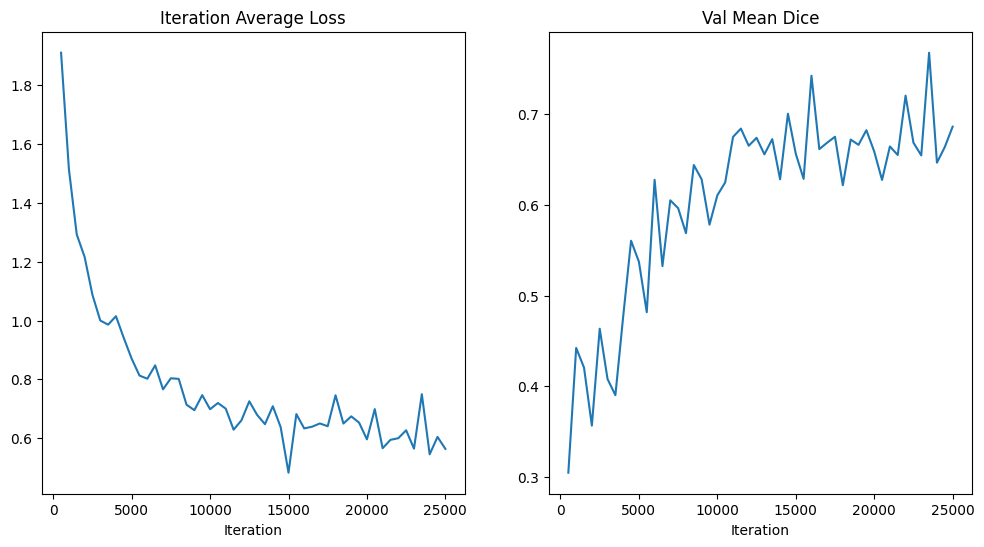

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
#         print(x.shape,y.shape)
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.48585): 100%|█| 24/24 [00:13<00:00,  1.75it/
Training (47 / 25000 Steps) (loss=2.21740): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (71 / 25000 Steps) (loss=2.33124): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (95 / 25000 Steps) (loss=2.25729): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (119 / 25000 Steps) (loss=2.15701): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (143 / 25000 Steps) (loss=2.07018): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (167 / 25000 Steps) (loss=2.04183): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (191 / 25000 Steps) (loss=2.03264): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (215 / 25000 Steps) (loss=2.15864): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (239 / 25000 Steps) (loss=2.08078): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (263 / 25000 Steps) (loss=1.98857): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (287 / 25000 Steps) (loss=1.89706): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.35879626870155334 Current Avg. Dice: 0.35879626870155334


Training (503 / 25000 Steps) (loss=1.90164): 100%|█| 24/24 [00:16<00:00,  1.46it
Training (527 / 25000 Steps) (loss=1.76827): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (551 / 25000 Steps) (loss=1.67183): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (575 / 25000 Steps) (loss=1.82487): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (599 / 25000 Steps) (loss=1.67229): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (623 / 25000 Steps) (loss=1.50669): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (647 / 25000 Steps) (loss=1.53873): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (671 / 25000 Steps) (loss=1.55521): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (695 / 25000 Steps) (loss=1.49329): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (719 / 25000 Steps) (loss=1.54866): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (743 / 25000 Steps) (loss=1.57598): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (767 / 25000 Steps) (loss=1.41878): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5055484771728516 Current Avg. Dice: 0.5055484771728516


Training (1007 / 25000 Steps) (loss=1.38449): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (1031 / 25000 Steps) (loss=1.26603): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1055 / 25000 Steps) (loss=1.35213): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1079 / 25000 Steps) (loss=1.28806): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1103 / 25000 Steps) (loss=1.31493): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1127 / 25000 Steps) (loss=1.29463): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1151 / 25000 Steps) (loss=1.32340): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1175 / 25000 Steps) (loss=1.53134): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1199 / 25000 Steps) (loss=1.35498): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1223 / 25000 Steps) (loss=1.28398): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1247 / 25000 Steps) (loss=1.60120): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1271 / 25000 Steps) (loss=1.34159): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5055484771728516 Current Avg. Dice: 0.4293247163295746


Training (1511 / 25000 Steps) (loss=1.16297): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (1535 / 25000 Steps) (loss=1.31857): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1559 / 25000 Steps) (loss=1.17064): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (1583 / 25000 Steps) (loss=1.29131): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1607 / 25000 Steps) (loss=1.23388): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1631 / 25000 Steps) (loss=1.27618): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1655 / 25000 Steps) (loss=1.26154): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1679 / 25000 Steps) (loss=1.20878): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1703 / 25000 Steps) (loss=1.27686): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1727 / 25000 Steps) (loss=1.33609): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1751 / 25000 Steps) (loss=1.24988): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (1775 / 25000 Steps) (loss=1.24716): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5055484771728516 Current Avg. Dice: 0.3704884350299835


Training (2015 / 25000 Steps) (loss=1.19809): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2039 / 25000 Steps) (loss=1.23127): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2063 / 25000 Steps) (loss=1.10176): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2087 / 25000 Steps) (loss=1.06372): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2111 / 25000 Steps) (loss=1.14806): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2135 / 25000 Steps) (loss=1.23710): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2159 / 25000 Steps) (loss=1.12194): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2183 / 25000 Steps) (loss=1.20813): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2207 / 25000 Steps) (loss=1.09631): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2231 / 25000 Steps) (loss=1.33852): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2255 / 25000 Steps) (loss=1.07697): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2279 / 25000 Steps) (loss=1.11896): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5055484771728516 Current Avg. Dice: 0.48235511779785156


Training (2519 / 25000 Steps) (loss=1.03485): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (2543 / 25000 Steps) (loss=1.04506): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2567 / 25000 Steps) (loss=1.20947): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2591 / 25000 Steps) (loss=1.43111): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2615 / 25000 Steps) (loss=1.00304): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (2639 / 25000 Steps) (loss=1.02545): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2663 / 25000 Steps) (loss=1.02341): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2687 / 25000 Steps) (loss=1.12935): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2711 / 25000 Steps) (loss=1.16895): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2735 / 25000 Steps) (loss=1.01074): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2759 / 25000 Steps) (loss=1.05181): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2783 / 25000 Steps) (loss=1.11586): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5219658613204956 Current Avg. Dice: 0.5219658613204956


Training (3023 / 25000 Steps) (loss=1.19333): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (3047 / 25000 Steps) (loss=1.08503): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3071 / 25000 Steps) (loss=0.94144): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3095 / 25000 Steps) (loss=1.10076): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3119 / 25000 Steps) (loss=0.92040): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3143 / 25000 Steps) (loss=1.10649): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3167 / 25000 Steps) (loss=0.91658): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3191 / 25000 Steps) (loss=1.00087): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3215 / 25000 Steps) (loss=1.01422): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3239 / 25000 Steps) (loss=1.02530): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3263 / 25000 Steps) (loss=0.99128): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3287 / 25000 Steps) (loss=0.98898): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5595769286155701 Current Avg. Dice: 0.5595769286155701


Training (3503 / 25000 Steps) (loss=1.00269): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (3527 / 25000 Steps) (loss=0.93080): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3551 / 25000 Steps) (loss=0.94136): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3575 / 25000 Steps) (loss=0.92840): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3599 / 25000 Steps) (loss=0.98101): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=0.98352): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3647 / 25000 Steps) (loss=0.95737): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3671 / 25000 Steps) (loss=0.96606): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3695 / 25000 Steps) (loss=1.00357): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3719 / 25000 Steps) (loss=1.01529): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3743 / 25000 Steps) (loss=0.94518): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3767 / 25000 Steps) (loss=1.07145): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5811782479286194 Current Avg. Dice: 0.5811782479286194


Training (4007 / 25000 Steps) (loss=0.93660): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (4031 / 25000 Steps) (loss=0.98958): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4055 / 25000 Steps) (loss=0.90055): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4079 / 25000 Steps) (loss=0.86469): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4103 / 25000 Steps) (loss=0.84030): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4127 / 25000 Steps) (loss=0.71686): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4151 / 25000 Steps) (loss=1.16675): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4175 / 25000 Steps) (loss=1.02506): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4199 / 25000 Steps) (loss=0.88297): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4223 / 25000 Steps) (loss=0.86388): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4247 / 25000 Steps) (loss=1.06006): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4271 / 25000 Steps) (loss=0.84668): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5811782479286194 Current Avg. Dice: 0.5663726329803467


Training (4511 / 25000 Steps) (loss=0.97751): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (4535 / 25000 Steps) (loss=1.00249): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4559 / 25000 Steps) (loss=0.87772): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4583 / 25000 Steps) (loss=0.95159): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4607 / 25000 Steps) (loss=0.91236): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4631 / 25000 Steps) (loss=0.90892): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4655 / 25000 Steps) (loss=1.70764): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4679 / 25000 Steps) (loss=1.01241): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4703 / 25000 Steps) (loss=0.74097): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4727 / 25000 Steps) (loss=0.88514): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4751 / 25000 Steps) (loss=0.75888): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4775 / 25000 Steps) (loss=0.88693): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6359038949012756 Current Avg. Dice: 0.6359038949012756


Training (5015 / 25000 Steps) (loss=1.00507): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (5039 / 25000 Steps) (loss=0.83128): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5063 / 25000 Steps) (loss=0.80206): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5087 / 25000 Steps) (loss=0.93173): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5111 / 25000 Steps) (loss=0.86828): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5135 / 25000 Steps) (loss=0.88079): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5159 / 25000 Steps) (loss=0.73899): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5183 / 25000 Steps) (loss=0.77352): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5207 / 25000 Steps) (loss=0.90054): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5231 / 25000 Steps) (loss=0.79730): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5255 / 25000 Steps) (loss=0.76560): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5279 / 25000 Steps) (loss=0.70781): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6359038949012756 Current Avg. Dice: 0.5996513962745667


Training (5519 / 25000 Steps) (loss=0.97689): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (5543 / 25000 Steps) (loss=0.80822): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5567 / 25000 Steps) (loss=0.82904): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5591 / 25000 Steps) (loss=0.71929): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5615 / 25000 Steps) (loss=0.74922): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (5639 / 25000 Steps) (loss=0.73546): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5663 / 25000 Steps) (loss=1.02624): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5687 / 25000 Steps) (loss=0.85290): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5711 / 25000 Steps) (loss=0.82258): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5735 / 25000 Steps) (loss=0.71766): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5759 / 25000 Steps) (loss=1.17502): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5783 / 25000 Steps) (loss=0.84589): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6628851294517517 Current Avg. Dice: 0.6628851294517517


Training (6023 / 25000 Steps) (loss=0.75125): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (6047 / 25000 Steps) (loss=0.84677): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6071 / 25000 Steps) (loss=0.78520): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6095 / 25000 Steps) (loss=0.74957): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6119 / 25000 Steps) (loss=0.71282): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6143 / 25000 Steps) (loss=0.89535): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6167 / 25000 Steps) (loss=0.84123): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6191 / 25000 Steps) (loss=0.83538): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6215 / 25000 Steps) (loss=0.75543): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6239 / 25000 Steps) (loss=0.82846): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6263 / 25000 Steps) (loss=0.79671): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6287 / 25000 Steps) (loss=1.23194): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6677548885345459 Current Avg. Dice: 0.6677548885345459


Training (6503 / 25000 Steps) (loss=0.91023): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (6527 / 25000 Steps) (loss=2.02660): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6551 / 25000 Steps) (loss=0.77281): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (6575 / 25000 Steps) (loss=0.81160): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6599 / 25000 Steps) (loss=0.87525): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6623 / 25000 Steps) (loss=0.67433): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6647 / 25000 Steps) (loss=0.84412): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6671 / 25000 Steps) (loss=0.74601): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6695 / 25000 Steps) (loss=0.82679): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6719 / 25000 Steps) (loss=0.81819): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6743 / 25000 Steps) (loss=0.70760): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6767 / 25000 Steps) (loss=0.83437): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.7243961691856384


Training (7007 / 25000 Steps) (loss=0.78816): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (7031 / 25000 Steps) (loss=0.75379): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7055 / 25000 Steps) (loss=0.71705): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7079 / 25000 Steps) (loss=1.03469): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7103 / 25000 Steps) (loss=0.68418): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7127 / 25000 Steps) (loss=0.73757): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7151 / 25000 Steps) (loss=0.88398): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7175 / 25000 Steps) (loss=0.77881): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7199 / 25000 Steps) (loss=0.82702): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7223 / 25000 Steps) (loss=0.59058): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7247 / 25000 Steps) (loss=0.80441): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7271 / 25000 Steps) (loss=0.86694): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.6756396293640137


Training (7511 / 25000 Steps) (loss=0.81895): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (7535 / 25000 Steps) (loss=0.76389): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7559 / 25000 Steps) (loss=0.92061): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7583 / 25000 Steps) (loss=0.74234): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (7607 / 25000 Steps) (loss=0.81480): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7631 / 25000 Steps) (loss=0.83244): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7655 / 25000 Steps) (loss=0.77188): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7679 / 25000 Steps) (loss=0.88138): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7703 / 25000 Steps) (loss=0.64855): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (7727 / 25000 Steps) (loss=0.70455): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7751 / 25000 Steps) (loss=0.76481): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7775 / 25000 Steps) (loss=0.77539): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.6861855387687683


Training (8015 / 25000 Steps) (loss=0.54360): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8039 / 25000 Steps) (loss=0.65013): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8063 / 25000 Steps) (loss=0.68522): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8087 / 25000 Steps) (loss=0.62937): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8111 / 25000 Steps) (loss=0.92685): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8135 / 25000 Steps) (loss=0.72951): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8159 / 25000 Steps) (loss=0.80318): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8183 / 25000 Steps) (loss=1.47974): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8207 / 25000 Steps) (loss=0.79243): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8231 / 25000 Steps) (loss=0.58599): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8255 / 25000 Steps) (loss=0.68851): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8279 / 25000 Steps) (loss=0.66598): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.6900465488433838


Training (8519 / 25000 Steps) (loss=0.82359): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (8543 / 25000 Steps) (loss=0.77317): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8567 / 25000 Steps) (loss=0.79952): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8591 / 25000 Steps) (loss=0.77937): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8615 / 25000 Steps) (loss=0.92407): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8639 / 25000 Steps) (loss=0.66442): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8663 / 25000 Steps) (loss=0.80182): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8687 / 25000 Steps) (loss=0.62262): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8711 / 25000 Steps) (loss=1.24399): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8735 / 25000 Steps) (loss=0.53472): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8759 / 25000 Steps) (loss=0.76915): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8783 / 25000 Steps) (loss=0.74921): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.6845315098762512


Training (9023 / 25000 Steps) (loss=0.67060): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9047 / 25000 Steps) (loss=0.57455): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9071 / 25000 Steps) (loss=0.86267): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9095 / 25000 Steps) (loss=1.49721): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9119 / 25000 Steps) (loss=0.86667): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9143 / 25000 Steps) (loss=0.62395): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9167 / 25000 Steps) (loss=0.81562): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9191 / 25000 Steps) (loss=0.53464): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9215 / 25000 Steps) (loss=0.85154): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9239 / 25000 Steps) (loss=0.61111): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9263 / 25000 Steps) (loss=0.73183): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9287 / 25000 Steps) (loss=0.75003): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.6275423169136047


Training (9503 / 25000 Steps) (loss=0.66951): 100%|█| 24/24 [00:13<00:00,  1.82i
Training (9527 / 25000 Steps) (loss=0.71468): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9551 / 25000 Steps) (loss=0.88298): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9575 / 25000 Steps) (loss=0.53733): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9599 / 25000 Steps) (loss=0.84738): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9623 / 25000 Steps) (loss=0.76144): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9647 / 25000 Steps) (loss=0.71077): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9671 / 25000 Steps) (loss=0.76849): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9695 / 25000 Steps) (loss=0.72322): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9719 / 25000 Steps) (loss=0.62701): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9743 / 25000 Steps) (loss=0.60314): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (9767 / 25000 Steps) (loss=0.84513): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.6446698307991028


Training (10007 / 25000 Steps) (loss=1.23561): 100%|█| 24/24 [00:13<00:00,  1.83
Training (10031 / 25000 Steps) (loss=0.70349): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10055 / 25000 Steps) (loss=0.85278): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10079 / 25000 Steps) (loss=0.80855): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10103 / 25000 Steps) (loss=0.50464): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10127 / 25000 Steps) (loss=0.57854): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10151 / 25000 Steps) (loss=0.65136): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10175 / 25000 Steps) (loss=0.74016): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10199 / 25000 Steps) (loss=0.79831): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10223 / 25000 Steps) (loss=0.70438): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10247 / 25000 Steps) (loss=0.71514): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10271 / 25000 Steps) (loss=1.32540): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7243961691856384 Current Avg. Dice: 0.653071939945221


Training (10511 / 25000 Steps) (loss=0.74472): 100%|█| 24/24 [00:13<00:00,  1.83
Training (10535 / 25000 Steps) (loss=0.82231): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10559 / 25000 Steps) (loss=0.74890): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10583 / 25000 Steps) (loss=0.81810): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10607 / 25000 Steps) (loss=0.77314): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10631 / 25000 Steps) (loss=0.71738): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10655 / 25000 Steps) (loss=0.64537): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10679 / 25000 Steps) (loss=0.66277): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10703 / 25000 Steps) (loss=0.93168): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10727 / 25000 Steps) (loss=0.64444): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10751 / 25000 Steps) (loss=0.64599): 100%|█| 24/24 [00:11<00:00,  2.05
Training (10775 / 25000 Steps) (loss=0.51687): 100%|█| 24/24 [00:11<00:00,  2.06
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7313764095306396 Current Avg. Dice: 0.7313764095306396


Training (11015 / 25000 Steps) (loss=0.57381): 100%|█| 24/24 [00:16<00:00,  1.45
Training (11039 / 25000 Steps) (loss=0.55072): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11063 / 25000 Steps) (loss=0.68450): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11087 / 25000 Steps) (loss=0.77620): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11111 / 25000 Steps) (loss=0.74079): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11135 / 25000 Steps) (loss=0.64534): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11159 / 25000 Steps) (loss=0.77593): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11183 / 25000 Steps) (loss=0.58183): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11207 / 25000 Steps) (loss=0.83524): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11231 / 25000 Steps) (loss=0.75887): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11255 / 25000 Steps) (loss=0.85418): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11279 / 25000 Steps) (loss=0.54646): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.7450777888298035


Training (11519 / 25000 Steps) (loss=0.57059): 100%|█| 24/24 [00:16<00:00,  1.45
Training (11543 / 25000 Steps) (loss=0.80000): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11567 / 25000 Steps) (loss=0.70194): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11591 / 25000 Steps) (loss=0.63613): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11615 / 25000 Steps) (loss=0.72955): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11639 / 25000 Steps) (loss=0.67319): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11663 / 25000 Steps) (loss=0.64159): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11687 / 25000 Steps) (loss=0.83190): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11711 / 25000 Steps) (loss=0.64806): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11735 / 25000 Steps) (loss=0.66150): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11759 / 25000 Steps) (loss=0.73158): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11783 / 25000 Steps) (loss=0.79974): 100%|█| 24/24 [00:11<00:00,  2.06
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.7089571952819824


Training (12023 / 25000 Steps) (loss=0.44078): 100%|█| 24/24 [00:13<00:00,  1.83
Training (12047 / 25000 Steps) (loss=0.85249): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12071 / 25000 Steps) (loss=0.72806): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12095 / 25000 Steps) (loss=0.43404): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12119 / 25000 Steps) (loss=0.78293): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12143 / 25000 Steps) (loss=0.63876): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12167 / 25000 Steps) (loss=0.71063): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12191 / 25000 Steps) (loss=0.92329): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12215 / 25000 Steps) (loss=0.63329): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12239 / 25000 Steps) (loss=0.45070): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12263 / 25000 Steps) (loss=0.89788): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12287 / 25000 Steps) (loss=0.79973): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.7133437991142273


Training (12503 / 25000 Steps) (loss=0.73527): 100%|█| 24/24 [00:13<00:00,  1.83
Training (12527 / 25000 Steps) (loss=0.65990): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12551 / 25000 Steps) (loss=0.69301): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12575 / 25000 Steps) (loss=0.81333): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12599 / 25000 Steps) (loss=0.90757): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12623 / 25000 Steps) (loss=0.63507): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12647 / 25000 Steps) (loss=0.81456): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12671 / 25000 Steps) (loss=0.68313): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12695 / 25000 Steps) (loss=0.68672): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12719 / 25000 Steps) (loss=0.61994): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12743 / 25000 Steps) (loss=0.62224): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12767 / 25000 Steps) (loss=0.81417): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.6977513432502747


Training (13007 / 25000 Steps) (loss=0.71714): 100%|█| 24/24 [00:13<00:00,  1.82
Training (13031 / 25000 Steps) (loss=0.64171): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13055 / 25000 Steps) (loss=0.78795): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13079 / 25000 Steps) (loss=0.71707): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13103 / 25000 Steps) (loss=0.72365): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13127 / 25000 Steps) (loss=0.70428): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13151 / 25000 Steps) (loss=0.69805): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13175 / 25000 Steps) (loss=0.77241): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13199 / 25000 Steps) (loss=0.85790): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13223 / 25000 Steps) (loss=0.70032): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13247 / 25000 Steps) (loss=0.76321): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13271 / 25000 Steps) (loss=0.68290): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.7202273011207581


Training (13511 / 25000 Steps) (loss=0.59375): 100%|█| 24/24 [00:13<00:00,  1.83
Training (13535 / 25000 Steps) (loss=0.80096): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13559 / 25000 Steps) (loss=0.68242): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13583 / 25000 Steps) (loss=0.55517): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13607 / 25000 Steps) (loss=0.51037): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13631 / 25000 Steps) (loss=0.67962): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13655 / 25000 Steps) (loss=0.89468): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13679 / 25000 Steps) (loss=0.72177): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13703 / 25000 Steps) (loss=0.85340): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13727 / 25000 Steps) (loss=0.63769): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13751 / 25000 Steps) (loss=0.60355): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13775 / 25000 Steps) (loss=0.81547): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.6095225214958191


Training (14015 / 25000 Steps) (loss=0.55775): 100%|█| 24/24 [00:13<00:00,  1.83
Training (14039 / 25000 Steps) (loss=0.76622): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14063 / 25000 Steps) (loss=0.81273): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14087 / 25000 Steps) (loss=0.72962): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14111 / 25000 Steps) (loss=0.79000): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14135 / 25000 Steps) (loss=0.71869): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14159 / 25000 Steps) (loss=0.73976): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14183 / 25000 Steps) (loss=0.80887): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14207 / 25000 Steps) (loss=0.59082): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14231 / 25000 Steps) (loss=0.55216): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14255 / 25000 Steps) (loss=0.56269): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14279 / 25000 Steps) (loss=0.76339): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.6846203207969666


Training (14519 / 25000 Steps) (loss=0.54262): 100%|█| 24/24 [00:13<00:00,  1.82
Training (14543 / 25000 Steps) (loss=0.73395): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14567 / 25000 Steps) (loss=0.77579): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14591 / 25000 Steps) (loss=0.73487): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14615 / 25000 Steps) (loss=0.59766): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14639 / 25000 Steps) (loss=0.50871): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14663 / 25000 Steps) (loss=0.54242): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14687 / 25000 Steps) (loss=0.52712): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14711 / 25000 Steps) (loss=0.77911): 100%|█| 24/24 [00:11<00:00,  2.04
Training (14735 / 25000 Steps) (loss=0.62728): 100%|█| 24/24 [00:11<00:00,  2.05
Training (14759 / 25000 Steps) (loss=0.57894): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14783 / 25000 Steps) (loss=0.59676): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.6867902874946594


Training (15023 / 25000 Steps) (loss=0.70229): 100%|█| 24/24 [00:13<00:00,  1.82
Training (15047 / 25000 Steps) (loss=0.86851): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15071 / 25000 Steps) (loss=0.54230): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15095 / 25000 Steps) (loss=0.52282): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15119 / 25000 Steps) (loss=0.47471): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15143 / 25000 Steps) (loss=0.74629): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15167 / 25000 Steps) (loss=0.50676): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15191 / 25000 Steps) (loss=0.45579): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15215 / 25000 Steps) (loss=0.44817): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15239 / 25000 Steps) (loss=0.63345): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15263 / 25000 Steps) (loss=0.64344): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15287 / 25000 Steps) (loss=0.90406): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7450777888298035 Current Avg. Dice: 0.6912434697151184


Training (15503 / 25000 Steps) (loss=0.59670): 100%|█| 24/24 [00:13<00:00,  1.82
Training (15527 / 25000 Steps) (loss=0.79086): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15551 / 25000 Steps) (loss=0.77928): 100%|█| 24/24 [00:11<00:00,  2.05
Training (15575 / 25000 Steps) (loss=0.59412): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15599 / 25000 Steps) (loss=0.48957): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15623 / 25000 Steps) (loss=0.83283): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15647 / 25000 Steps) (loss=0.75405): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15671 / 25000 Steps) (loss=0.45403): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15695 / 25000 Steps) (loss=0.76374): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15719 / 25000 Steps) (loss=0.52064): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15743 / 25000 Steps) (loss=0.63854): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15767 / 25000 Steps) (loss=0.60471): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7839875221252441 Current Avg. Dice: 0.7839875221252441


Training (16007 / 25000 Steps) (loss=0.95269): 100%|█| 24/24 [00:16<00:00,  1.44
Training (16031 / 25000 Steps) (loss=0.71247): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16055 / 25000 Steps) (loss=0.87071): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16079 / 25000 Steps) (loss=0.53582): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16103 / 25000 Steps) (loss=0.56074): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16127 / 25000 Steps) (loss=0.64986): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16151 / 25000 Steps) (loss=0.46459): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16175 / 25000 Steps) (loss=0.76908): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16199 / 25000 Steps) (loss=0.71378): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16223 / 25000 Steps) (loss=0.55360): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16247 / 25000 Steps) (loss=0.64992): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16271 / 25000 Steps) (loss=0.51738): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7839875221252441 Current Avg. Dice: 0.648371160030365


Training (16511 / 25000 Steps) (loss=0.74121): 100%|█| 24/24 [00:13<00:00,  1.82
Training (16535 / 25000 Steps) (loss=0.77389): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16559 / 25000 Steps) (loss=0.59473): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16583 / 25000 Steps) (loss=0.52377): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16607 / 25000 Steps) (loss=0.58689): 100%|█| 24/24 [00:11<00:00,  2.05
Training (16631 / 25000 Steps) (loss=0.53807): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16655 / 25000 Steps) (loss=0.60472): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16679 / 25000 Steps) (loss=0.51996): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16703 / 25000 Steps) (loss=0.73235): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16727 / 25000 Steps) (loss=0.68502): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16751 / 25000 Steps) (loss=0.61396): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16775 / 25000 Steps) (loss=0.77218): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7839875221252441 Current Avg. Dice: 0.7772861123085022


Training (17015 / 25000 Steps) (loss=0.77718): 100%|█| 24/24 [00:13<00:00,  1.82
Training (17039 / 25000 Steps) (loss=0.74337): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17063 / 25000 Steps) (loss=0.76899): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17087 / 25000 Steps) (loss=0.80161): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17111 / 25000 Steps) (loss=0.65710): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17135 / 25000 Steps) (loss=0.74801): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17159 / 25000 Steps) (loss=0.71143): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17183 / 25000 Steps) (loss=0.70935): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17207 / 25000 Steps) (loss=0.52974): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17231 / 25000 Steps) (loss=0.68901): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17255 / 25000 Steps) (loss=0.46649): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17279 / 25000 Steps) (loss=0.73933): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.7936772704124451


Training (17519 / 25000 Steps) (loss=0.69931): 100%|█| 24/24 [00:16<00:00,  1.44
Training (17543 / 25000 Steps) (loss=0.50497): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17567 / 25000 Steps) (loss=0.54832): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17591 / 25000 Steps) (loss=0.56336): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17615 / 25000 Steps) (loss=0.67560): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17639 / 25000 Steps) (loss=0.64511): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17663 / 25000 Steps) (loss=0.75467): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17687 / 25000 Steps) (loss=0.84043): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17711 / 25000 Steps) (loss=0.68477): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17735 / 25000 Steps) (loss=0.66621): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17759 / 25000 Steps) (loss=0.48605): 100%|█| 24/24 [00:11<00:00,  2.05
Training (17783 / 25000 Steps) (loss=0.52043): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.7191875576972961


Training (18023 / 25000 Steps) (loss=0.43182): 100%|█| 24/24 [00:13<00:00,  1.82
Training (18047 / 25000 Steps) (loss=0.62514): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18071 / 25000 Steps) (loss=0.71480): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18095 / 25000 Steps) (loss=0.77820): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18119 / 25000 Steps) (loss=0.68597): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18143 / 25000 Steps) (loss=0.68814): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18167 / 25000 Steps) (loss=0.80712): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18191 / 25000 Steps) (loss=0.70205): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18215 / 25000 Steps) (loss=0.50366): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18239 / 25000 Steps) (loss=0.67264): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18263 / 25000 Steps) (loss=0.72289): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18287 / 25000 Steps) (loss=0.64159): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6815360188484192


Training (18503 / 25000 Steps) (loss=0.69646): 100%|█| 24/24 [00:13<00:00,  1.82
Training (18527 / 25000 Steps) (loss=0.51794): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18551 / 25000 Steps) (loss=0.70965): 100%|█| 24/24 [00:11<00:00,  2.05
Training (18575 / 25000 Steps) (loss=0.60457): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18599 / 25000 Steps) (loss=0.74447): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18623 / 25000 Steps) (loss=0.67780): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18647 / 25000 Steps) (loss=0.65549): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18671 / 25000 Steps) (loss=0.63650): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18695 / 25000 Steps) (loss=0.62118): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18719 / 25000 Steps) (loss=0.51488): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18743 / 25000 Steps) (loss=0.63092): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18767 / 25000 Steps) (loss=0.76524): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.7471480965614319


Training (19007 / 25000 Steps) (loss=0.38108): 100%|█| 24/24 [00:13<00:00,  1.83
Training (19031 / 25000 Steps) (loss=0.74263): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19055 / 25000 Steps) (loss=0.70670): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19079 / 25000 Steps) (loss=0.69320): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19103 / 25000 Steps) (loss=0.58104): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19127 / 25000 Steps) (loss=0.70291): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19151 / 25000 Steps) (loss=0.73446): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19175 / 25000 Steps) (loss=0.48620): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19199 / 25000 Steps) (loss=0.78546): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19223 / 25000 Steps) (loss=0.59937): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19247 / 25000 Steps) (loss=0.64297): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19271 / 25000 Steps) (loss=0.81347): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6445291042327881


Training (19511 / 25000 Steps) (loss=0.47964): 100%|█| 24/24 [00:13<00:00,  1.82
Training (19535 / 25000 Steps) (loss=0.58780): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19559 / 25000 Steps) (loss=0.44766): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19583 / 25000 Steps) (loss=0.57612): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19607 / 25000 Steps) (loss=0.71307): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19631 / 25000 Steps) (loss=0.54499): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19655 / 25000 Steps) (loss=0.54516): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19679 / 25000 Steps) (loss=0.69567): 100%|█| 24/24 [00:11<00:00,  2.05
Training (19703 / 25000 Steps) (loss=0.55556): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19727 / 25000 Steps) (loss=0.64172): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19751 / 25000 Steps) (loss=0.52109): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19775 / 25000 Steps) (loss=0.57245): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6793575286865234


Training (20015 / 25000 Steps) (loss=0.50090): 100%|█| 24/24 [00:13<00:00,  1.78
Training (20039 / 25000 Steps) (loss=0.49381): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20063 / 25000 Steps) (loss=0.82388): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20087 / 25000 Steps) (loss=0.66692): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20111 / 25000 Steps) (loss=0.57413): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20135 / 25000 Steps) (loss=0.64917): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20159 / 25000 Steps) (loss=0.75478): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=0.66384): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20207 / 25000 Steps) (loss=0.80682): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20231 / 25000 Steps) (loss=0.63236): 100%|█| 24/24 [00:11<00:00,  2.05
Training (20255 / 25000 Steps) (loss=0.54747): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20279 / 25000 Steps) (loss=0.55869): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6861112713813782


Training (20519 / 25000 Steps) (loss=0.69135): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20543 / 25000 Steps) (loss=0.63860): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20567 / 25000 Steps) (loss=0.36514): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20591 / 25000 Steps) (loss=0.52702): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20615 / 25000 Steps) (loss=0.68788): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20639 / 25000 Steps) (loss=0.47010): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20663 / 25000 Steps) (loss=0.53670): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20687 / 25000 Steps) (loss=0.44590): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20711 / 25000 Steps) (loss=0.71077): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20735 / 25000 Steps) (loss=0.75978): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20759 / 25000 Steps) (loss=0.62007): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20783 / 25000 Steps) (loss=0.97046): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6945693492889404


Training (21023 / 25000 Steps) (loss=0.62179): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21047 / 25000 Steps) (loss=0.67241): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21071 / 25000 Steps) (loss=0.66306): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21095 / 25000 Steps) (loss=0.60078): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21119 / 25000 Steps) (loss=0.65657): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21143 / 25000 Steps) (loss=0.68829): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21167 / 25000 Steps) (loss=0.71643): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21191 / 25000 Steps) (loss=0.66028): 100%|█| 24/24 [00:11<00:00,  2.05
Training (21215 / 25000 Steps) (loss=0.56963): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21239 / 25000 Steps) (loss=0.88418): 100%|█| 24/24 [00:11<00:00,  2.05
Training (21263 / 25000 Steps) (loss=0.58930): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21287 / 25000 Steps) (loss=0.62420): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.710841953754425


Training (21503 / 25000 Steps) (loss=0.63316): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21527 / 25000 Steps) (loss=0.71658): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21551 / 25000 Steps) (loss=0.63237): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21575 / 25000 Steps) (loss=0.52620): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21599 / 25000 Steps) (loss=0.52231): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21623 / 25000 Steps) (loss=0.74047): 100%|█| 24/24 [00:11<00:00,  2.05
Training (21647 / 25000 Steps) (loss=0.49951): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21671 / 25000 Steps) (loss=0.71320): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21695 / 25000 Steps) (loss=1.11965): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21719 / 25000 Steps) (loss=0.64187): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21743 / 25000 Steps) (loss=1.17528): 100%|█| 24/24 [00:11<00:00,  2.05
Training (21767 / 25000 Steps) (loss=0.65455): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6397103667259216


Training (22007 / 25000 Steps) (loss=0.76647): 100%|█| 24/24 [00:13<00:00,  1.83
Training (22031 / 25000 Steps) (loss=0.59167): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22055 / 25000 Steps) (loss=0.56749): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22079 / 25000 Steps) (loss=0.56567): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22103 / 25000 Steps) (loss=0.66190): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22127 / 25000 Steps) (loss=0.39825): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22151 / 25000 Steps) (loss=0.64728): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22175 / 25000 Steps) (loss=0.80412): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22199 / 25000 Steps) (loss=0.72747): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22223 / 25000 Steps) (loss=0.57117): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22247 / 25000 Steps) (loss=0.69332): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22271 / 25000 Steps) (loss=0.60563): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.7095454335212708


Training (22511 / 25000 Steps) (loss=0.67798): 100%|█| 24/24 [00:13<00:00,  1.83
Training (22535 / 25000 Steps) (loss=0.68427): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22559 / 25000 Steps) (loss=0.62368): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22583 / 25000 Steps) (loss=0.50460): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22607 / 25000 Steps) (loss=0.48706): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22631 / 25000 Steps) (loss=0.78078): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22655 / 25000 Steps) (loss=0.37518): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22679 / 25000 Steps) (loss=0.71907): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22703 / 25000 Steps) (loss=0.69825): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22727 / 25000 Steps) (loss=0.40424): 100%|█| 24/24 [00:11<00:00,  2.05
Training (22751 / 25000 Steps) (loss=0.79320): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22775 / 25000 Steps) (loss=0.59217): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6859729886054993


Training (23015 / 25000 Steps) (loss=0.59942): 100%|█| 24/24 [00:13<00:00,  1.83
Training (23039 / 25000 Steps) (loss=0.73213): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23063 / 25000 Steps) (loss=0.89943): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23087 / 25000 Steps) (loss=0.61145): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23111 / 25000 Steps) (loss=0.79832): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23135 / 25000 Steps) (loss=0.52125): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23159 / 25000 Steps) (loss=1.00673): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23183 / 25000 Steps) (loss=0.60782): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23207 / 25000 Steps) (loss=0.76601): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23231 / 25000 Steps) (loss=0.47178): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23255 / 25000 Steps) (loss=0.51532): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23279 / 25000 Steps) (loss=0.77690): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6959433555603027


Training (23519 / 25000 Steps) (loss=0.51102): 100%|█| 24/24 [00:13<00:00,  1.82
Training (23543 / 25000 Steps) (loss=0.62547): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23567 / 25000 Steps) (loss=0.46387): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23591 / 25000 Steps) (loss=0.41021): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23615 / 25000 Steps) (loss=0.51164): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23639 / 25000 Steps) (loss=0.53244): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23663 / 25000 Steps) (loss=0.71218): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23687 / 25000 Steps) (loss=0.71336): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23711 / 25000 Steps) (loss=0.45579): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23735 / 25000 Steps) (loss=0.62149): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23759 / 25000 Steps) (loss=0.57029): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23783 / 25000 Steps) (loss=0.56905): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.7583214640617371


Training (24023 / 25000 Steps) (loss=0.44204): 100%|█| 24/24 [00:13<00:00,  1.83
Training (24047 / 25000 Steps) (loss=0.46350): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24071 / 25000 Steps) (loss=0.73906): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24095 / 25000 Steps) (loss=0.71733): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24119 / 25000 Steps) (loss=0.66182): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24143 / 25000 Steps) (loss=0.70482): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24167 / 25000 Steps) (loss=0.64304): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24191 / 25000 Steps) (loss=0.69659): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24215 / 25000 Steps) (loss=0.54362): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24239 / 25000 Steps) (loss=0.65499): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24263 / 25000 Steps) (loss=0.49415): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24287 / 25000 Steps) (loss=0.48729): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.6891090273857117


Training (24503 / 25000 Steps) (loss=0.48241): 100%|█| 24/24 [00:13<00:00,  1.83
Training (24527 / 25000 Steps) (loss=0.55161): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24551 / 25000 Steps) (loss=0.68735): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24575 / 25000 Steps) (loss=0.59321): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24599 / 25000 Steps) (loss=0.67040): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24623 / 25000 Steps) (loss=0.56667): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24647 / 25000 Steps) (loss=0.44941): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24671 / 25000 Steps) (loss=0.60699): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24695 / 25000 Steps) (loss=0.69081): 100%|█| 24/24 [00:11<00:00,  2.07
Training (24719 / 25000 Steps) (loss=0.41895): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24743 / 25000 Steps) (loss=0.42506): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24767 / 25000 Steps) (loss=0.67170): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7936772704124451 Current Avg. Dice: 0.7375946640968323


Training (25007 / 25000 Steps) (loss=0.54253): 100%|█| 24/24 [00:13<00:00,  1.83


RuntimeError: Error(s) in loading state_dict for UNETR:
	Missing key(s) in state_dict: "vit.patch_embedding.position_embeddings", "vit.patch_embedding.patch_embeddings.1.weight", "vit.patch_embedding.patch_embeddings.1.bias", "vit.blocks.0.mlp.linear1.weight", "vit.blocks.0.mlp.linear1.bias", "vit.blocks.0.mlp.linear2.weight", "vit.blocks.0.mlp.linear2.bias", "vit.blocks.0.norm1.weight", "vit.blocks.0.norm1.bias", "vit.blocks.0.attn.out_proj.weight", "vit.blocks.0.attn.out_proj.bias", "vit.blocks.0.attn.qkv.weight", "vit.blocks.0.attn.filter.0.weight", "vit.blocks.0.attn.filter.0.bias", "vit.blocks.0.attn.filter.1.weight", "vit.blocks.0.attn.filter.1.bias", "vit.blocks.0.attn.filter.1.running_mean", "vit.blocks.0.attn.filter.1.running_var", "vit.blocks.0.attn.kv.0.weight", "vit.blocks.0.attn.kv.0.bias", "vit.blocks.0.attn.kv.1.weight", "vit.blocks.0.attn.kv.1.bias", "vit.blocks.0.attn.proj.weight", "vit.blocks.0.attn.proj.bias", "vit.blocks.0.norm2.weight", "vit.blocks.0.norm2.bias", "vit.blocks.1.mlp.linear1.weight", "vit.blocks.1.mlp.linear1.bias", "vit.blocks.1.mlp.linear2.weight", "vit.blocks.1.mlp.linear2.bias", "vit.blocks.1.norm1.weight", "vit.blocks.1.norm1.bias", "vit.blocks.1.attn.out_proj.weight", "vit.blocks.1.attn.out_proj.bias", "vit.blocks.1.attn.qkv.weight", "vit.blocks.1.attn.filter.0.weight", "vit.blocks.1.attn.filter.0.bias", "vit.blocks.1.attn.filter.1.weight", "vit.blocks.1.attn.filter.1.bias", "vit.blocks.1.attn.filter.1.running_mean", "vit.blocks.1.attn.filter.1.running_var", "vit.blocks.1.attn.kv.0.weight", "vit.blocks.1.attn.kv.0.bias", "vit.blocks.1.attn.kv.1.weight", "vit.blocks.1.attn.kv.1.bias", "vit.blocks.1.attn.proj.weight", "vit.blocks.1.attn.proj.bias", "vit.blocks.1.norm2.weight", "vit.blocks.1.norm2.bias", "vit.blocks.2.mlp.linear1.weight", "vit.blocks.2.mlp.linear1.bias", "vit.blocks.2.mlp.linear2.weight", "vit.blocks.2.mlp.linear2.bias", "vit.blocks.2.norm1.weight", "vit.blocks.2.norm1.bias", "vit.blocks.2.attn.out_proj.weight", "vit.blocks.2.attn.out_proj.bias", "vit.blocks.2.attn.qkv.weight", "vit.blocks.2.attn.filter.0.weight", "vit.blocks.2.attn.filter.0.bias", "vit.blocks.2.attn.filter.1.weight", "vit.blocks.2.attn.filter.1.bias", "vit.blocks.2.attn.filter.1.running_mean", "vit.blocks.2.attn.filter.1.running_var", "vit.blocks.2.attn.kv.0.weight", "vit.blocks.2.attn.kv.0.bias", "vit.blocks.2.attn.kv.1.weight", "vit.blocks.2.attn.kv.1.bias", "vit.blocks.2.attn.proj.weight", "vit.blocks.2.attn.proj.bias", "vit.blocks.2.norm2.weight", "vit.blocks.2.norm2.bias", "vit.blocks.3.mlp.linear1.weight", "vit.blocks.3.mlp.linear1.bias", "vit.blocks.3.mlp.linear2.weight", "vit.blocks.3.mlp.linear2.bias", "vit.blocks.3.norm1.weight", "vit.blocks.3.norm1.bias", "vit.blocks.3.attn.out_proj.weight", "vit.blocks.3.attn.out_proj.bias", "vit.blocks.3.attn.qkv.weight", "vit.blocks.3.attn.filter.0.weight", "vit.blocks.3.attn.filter.0.bias", "vit.blocks.3.attn.filter.1.weight", "vit.blocks.3.attn.filter.1.bias", "vit.blocks.3.attn.filter.1.running_mean", "vit.blocks.3.attn.filter.1.running_var", "vit.blocks.3.attn.kv.0.weight", "vit.blocks.3.attn.kv.0.bias", "vit.blocks.3.attn.kv.1.weight", "vit.blocks.3.attn.kv.1.bias", "vit.blocks.3.attn.proj.weight", "vit.blocks.3.attn.proj.bias", "vit.blocks.3.norm2.weight", "vit.blocks.3.norm2.bias", "vit.blocks.4.mlp.linear1.weight", "vit.blocks.4.mlp.linear1.bias", "vit.blocks.4.mlp.linear2.weight", "vit.blocks.4.mlp.linear2.bias", "vit.blocks.4.norm1.weight", "vit.blocks.4.norm1.bias", "vit.blocks.4.attn.out_proj.weight", "vit.blocks.4.attn.out_proj.bias", "vit.blocks.4.attn.qkv.weight", "vit.blocks.4.attn.filter.0.weight", "vit.blocks.4.attn.filter.0.bias", "vit.blocks.4.attn.filter.1.weight", "vit.blocks.4.attn.filter.1.bias", "vit.blocks.4.attn.filter.1.running_mean", "vit.blocks.4.attn.filter.1.running_var", "vit.blocks.4.attn.kv.0.weight", "vit.blocks.4.attn.kv.0.bias", "vit.blocks.4.attn.kv.1.weight", "vit.blocks.4.attn.kv.1.bias", "vit.blocks.4.attn.proj.weight", "vit.blocks.4.attn.proj.bias", "vit.blocks.4.norm2.weight", "vit.blocks.4.norm2.bias", "vit.blocks.5.mlp.linear1.weight", "vit.blocks.5.mlp.linear1.bias", "vit.blocks.5.mlp.linear2.weight", "vit.blocks.5.mlp.linear2.bias", "vit.blocks.5.norm1.weight", "vit.blocks.5.norm1.bias", "vit.blocks.5.attn.out_proj.weight", "vit.blocks.5.attn.out_proj.bias", "vit.blocks.5.attn.qkv.weight", "vit.blocks.5.attn.filter.0.weight", "vit.blocks.5.attn.filter.0.bias", "vit.blocks.5.attn.filter.1.weight", "vit.blocks.5.attn.filter.1.bias", "vit.blocks.5.attn.filter.1.running_mean", "vit.blocks.5.attn.filter.1.running_var", "vit.blocks.5.attn.kv.0.weight", "vit.blocks.5.attn.kv.0.bias", "vit.blocks.5.attn.kv.1.weight", "vit.blocks.5.attn.kv.1.bias", "vit.blocks.5.attn.proj.weight", "vit.blocks.5.attn.proj.bias", "vit.blocks.5.norm2.weight", "vit.blocks.5.norm2.bias", "vit.blocks.6.mlp.linear1.weight", "vit.blocks.6.mlp.linear1.bias", "vit.blocks.6.mlp.linear2.weight", "vit.blocks.6.mlp.linear2.bias", "vit.blocks.6.norm1.weight", "vit.blocks.6.norm1.bias", "vit.blocks.6.attn.out_proj.weight", "vit.blocks.6.attn.out_proj.bias", "vit.blocks.6.attn.qkv.weight", "vit.blocks.6.attn.filter.0.weight", "vit.blocks.6.attn.filter.0.bias", "vit.blocks.6.attn.filter.1.weight", "vit.blocks.6.attn.filter.1.bias", "vit.blocks.6.attn.filter.1.running_mean", "vit.blocks.6.attn.filter.1.running_var", "vit.blocks.6.attn.kv.0.weight", "vit.blocks.6.attn.kv.0.bias", "vit.blocks.6.attn.kv.1.weight", "vit.blocks.6.attn.kv.1.bias", "vit.blocks.6.attn.proj.weight", "vit.blocks.6.attn.proj.bias", "vit.blocks.6.norm2.weight", "vit.blocks.6.norm2.bias", "vit.blocks.7.mlp.linear1.weight", "vit.blocks.7.mlp.linear1.bias", "vit.blocks.7.mlp.linear2.weight", "vit.blocks.7.mlp.linear2.bias", "vit.blocks.7.norm1.weight", "vit.blocks.7.norm1.bias", "vit.blocks.7.attn.out_proj.weight", "vit.blocks.7.attn.out_proj.bias", "vit.blocks.7.attn.qkv.weight", "vit.blocks.7.attn.filter.0.weight", "vit.blocks.7.attn.filter.0.bias", "vit.blocks.7.attn.filter.1.weight", "vit.blocks.7.attn.filter.1.bias", "vit.blocks.7.attn.filter.1.running_mean", "vit.blocks.7.attn.filter.1.running_var", "vit.blocks.7.attn.kv.0.weight", "vit.blocks.7.attn.kv.0.bias", "vit.blocks.7.attn.kv.1.weight", "vit.blocks.7.attn.kv.1.bias", "vit.blocks.7.attn.proj.weight", "vit.blocks.7.attn.proj.bias", "vit.blocks.7.norm2.weight", "vit.blocks.7.norm2.bias", "vit.blocks.8.mlp.linear1.weight", "vit.blocks.8.mlp.linear1.bias", "vit.blocks.8.mlp.linear2.weight", "vit.blocks.8.mlp.linear2.bias", "vit.blocks.8.norm1.weight", "vit.blocks.8.norm1.bias", "vit.blocks.8.attn.out_proj.weight", "vit.blocks.8.attn.out_proj.bias", "vit.blocks.8.attn.qkv.weight", "vit.blocks.8.attn.filter.0.weight", "vit.blocks.8.attn.filter.0.bias", "vit.blocks.8.attn.filter.1.weight", "vit.blocks.8.attn.filter.1.bias", "vit.blocks.8.attn.filter.1.running_mean", "vit.blocks.8.attn.filter.1.running_var", "vit.blocks.8.attn.kv.0.weight", "vit.blocks.8.attn.kv.0.bias", "vit.blocks.8.attn.kv.1.weight", "vit.blocks.8.attn.kv.1.bias", "vit.blocks.8.attn.proj.weight", "vit.blocks.8.attn.proj.bias", "vit.blocks.8.norm2.weight", "vit.blocks.8.norm2.bias", "vit.blocks.9.mlp.linear1.weight", "vit.blocks.9.mlp.linear1.bias", "vit.blocks.9.mlp.linear2.weight", "vit.blocks.9.mlp.linear2.bias", "vit.blocks.9.norm1.weight", "vit.blocks.9.norm1.bias", "vit.blocks.9.attn.out_proj.weight", "vit.blocks.9.attn.out_proj.bias", "vit.blocks.9.attn.qkv.weight", "vit.blocks.9.attn.filter.0.weight", "vit.blocks.9.attn.filter.0.bias", "vit.blocks.9.attn.filter.1.weight", "vit.blocks.9.attn.filter.1.bias", "vit.blocks.9.attn.filter.1.running_mean", "vit.blocks.9.attn.filter.1.running_var", "vit.blocks.9.attn.kv.0.weight", "vit.blocks.9.attn.kv.0.bias", "vit.blocks.9.attn.kv.1.weight", "vit.blocks.9.attn.kv.1.bias", "vit.blocks.9.attn.proj.weight", "vit.blocks.9.attn.proj.bias", "vit.blocks.9.norm2.weight", "vit.blocks.9.norm2.bias", "vit.blocks.10.mlp.linear1.weight", "vit.blocks.10.mlp.linear1.bias", "vit.blocks.10.mlp.linear2.weight", "vit.blocks.10.mlp.linear2.bias", "vit.blocks.10.norm1.weight", "vit.blocks.10.norm1.bias", "vit.blocks.10.attn.out_proj.weight", "vit.blocks.10.attn.out_proj.bias", "vit.blocks.10.attn.qkv.weight", "vit.blocks.10.attn.filter.0.weight", "vit.blocks.10.attn.filter.0.bias", "vit.blocks.10.attn.filter.1.weight", "vit.blocks.10.attn.filter.1.bias", "vit.blocks.10.attn.filter.1.running_mean", "vit.blocks.10.attn.filter.1.running_var", "vit.blocks.10.attn.kv.0.weight", "vit.blocks.10.attn.kv.0.bias", "vit.blocks.10.attn.kv.1.weight", "vit.blocks.10.attn.kv.1.bias", "vit.blocks.10.attn.proj.weight", "vit.blocks.10.attn.proj.bias", "vit.blocks.10.norm2.weight", "vit.blocks.10.norm2.bias", "vit.blocks.11.mlp.linear1.weight", "vit.blocks.11.mlp.linear1.bias", "vit.blocks.11.mlp.linear2.weight", "vit.blocks.11.mlp.linear2.bias", "vit.blocks.11.norm1.weight", "vit.blocks.11.norm1.bias", "vit.blocks.11.attn.out_proj.weight", "vit.blocks.11.attn.out_proj.bias", "vit.blocks.11.attn.qkv.weight", "vit.blocks.11.attn.filter.0.weight", "vit.blocks.11.attn.filter.0.bias", "vit.blocks.11.attn.filter.1.weight", "vit.blocks.11.attn.filter.1.bias", "vit.blocks.11.attn.filter.1.running_mean", "vit.blocks.11.attn.filter.1.running_var", "vit.blocks.11.attn.kv.0.weight", "vit.blocks.11.attn.kv.0.bias", "vit.blocks.11.attn.kv.1.weight", "vit.blocks.11.attn.kv.1.bias", "vit.blocks.11.attn.proj.weight", "vit.blocks.11.attn.proj.bias", "vit.blocks.11.norm2.weight", "vit.blocks.11.norm2.bias", "vit.norm.weight", "vit.norm.bias", "encoder2.transp_conv_init.conv.weight", "encoder2.blocks.0.0.conv.weight", "encoder2.blocks.0.1.conv1.conv.weight", "encoder2.blocks.0.1.conv2.conv.weight", "encoder2.blocks.1.0.conv.weight", "encoder2.blocks.1.1.conv1.conv.weight", "encoder2.blocks.1.1.conv2.conv.weight", "encoder3.transp_conv_init.conv.weight", "encoder3.blocks.0.0.conv.weight", "encoder3.blocks.0.1.conv1.conv.weight", "encoder3.blocks.0.1.conv2.conv.weight", "encoder4.transp_conv_init.conv.weight". 
	Unexpected key(s) in state_dict: "patch_embed.proj.weight", "patch_embed.proj.bias", "patch_embed.norm.weight", "patch_embed.norm.bias", "Patch_merge0.reduction.weight", "Patch_merge0.norm.weight", "Patch_merge0.norm.bias", "vit1.patch_embedding.position_embeddings", "vit1.patch_embedding.patch_embeddings.0.weight", "vit1.patch_embedding.patch_embeddings.0.bias", "vit1.blocks.0.mlp.linear1.weight", "vit1.blocks.0.mlp.linear1.bias", "vit1.blocks.0.mlp.linear2.weight", "vit1.blocks.0.mlp.linear2.bias", "vit1.blocks.0.norm1.weight", "vit1.blocks.0.norm1.bias", "vit1.blocks.0.attn.out_proj.weight", "vit1.blocks.0.attn.out_proj.bias", "vit1.blocks.0.attn.qkv.weight", "vit1.blocks.0.norm2.weight", "vit1.blocks.0.norm2.bias", "vit1.blocks.1.mlp.linear1.weight", "vit1.blocks.1.mlp.linear1.bias", "vit1.blocks.1.mlp.linear2.weight", "vit1.blocks.1.mlp.linear2.bias", "vit1.blocks.1.norm1.weight", "vit1.blocks.1.norm1.bias", "vit1.blocks.1.attn.out_proj.weight", "vit1.blocks.1.attn.out_proj.bias", "vit1.blocks.1.attn.qkv.weight", "vit1.blocks.1.norm2.weight", "vit1.blocks.1.norm2.bias", "vit1.blocks.2.mlp.linear1.weight", "vit1.blocks.2.mlp.linear1.bias", "vit1.blocks.2.mlp.linear2.weight", "vit1.blocks.2.mlp.linear2.bias", "vit1.blocks.2.norm1.weight", "vit1.blocks.2.norm1.bias", "vit1.blocks.2.attn.out_proj.weight", "vit1.blocks.2.attn.out_proj.bias", "vit1.blocks.2.attn.qkv.weight", "vit1.blocks.2.norm2.weight", "vit1.blocks.2.norm2.bias", "vit1.blocks.3.mlp.linear1.weight", "vit1.blocks.3.mlp.linear1.bias", "vit1.blocks.3.mlp.linear2.weight", "vit1.blocks.3.mlp.linear2.bias", "vit1.blocks.3.norm1.weight", "vit1.blocks.3.norm1.bias", "vit1.blocks.3.attn.out_proj.weight", "vit1.blocks.3.attn.out_proj.bias", "vit1.blocks.3.attn.qkv.weight", "vit1.blocks.3.norm2.weight", "vit1.blocks.3.norm2.bias", "vit1.blocks.4.mlp.linear1.weight", "vit1.blocks.4.mlp.linear1.bias", "vit1.blocks.4.mlp.linear2.weight", "vit1.blocks.4.mlp.linear2.bias", "vit1.blocks.4.norm1.weight", "vit1.blocks.4.norm1.bias", "vit1.blocks.4.attn.out_proj.weight", "vit1.blocks.4.attn.out_proj.bias", "vit1.blocks.4.attn.qkv.weight", "vit1.blocks.4.norm2.weight", "vit1.blocks.4.norm2.bias", "vit1.blocks.5.mlp.linear1.weight", "vit1.blocks.5.mlp.linear1.bias", "vit1.blocks.5.mlp.linear2.weight", "vit1.blocks.5.mlp.linear2.bias", "vit1.blocks.5.norm1.weight", "vit1.blocks.5.norm1.bias", "vit1.blocks.5.attn.out_proj.weight", "vit1.blocks.5.attn.out_proj.bias", "vit1.blocks.5.attn.qkv.weight", "vit1.blocks.5.norm2.weight", "vit1.blocks.5.norm2.bias", "vit1.norm.weight", "vit1.norm.bias", "Patch_merge1.reduction.weight", "Patch_merge1.norm.weight", "Patch_merge1.norm.bias", "vit2.patch_embedding.position_embeddings", "vit2.patch_embedding.patch_embeddings.0.weight", "vit2.patch_embedding.patch_embeddings.0.bias", "vit2.blocks.0.mlp.linear1.weight", "vit2.blocks.0.mlp.linear1.bias", "vit2.blocks.0.mlp.linear2.weight", "vit2.blocks.0.mlp.linear2.bias", "vit2.blocks.0.norm1.weight", "vit2.blocks.0.norm1.bias", "vit2.blocks.0.attn.out_proj.weight", "vit2.blocks.0.attn.out_proj.bias", "vit2.blocks.0.attn.qkv.weight", "vit2.blocks.0.norm2.weight", "vit2.blocks.0.norm2.bias", "vit2.blocks.1.mlp.linear1.weight", "vit2.blocks.1.mlp.linear1.bias", "vit2.blocks.1.mlp.linear2.weight", "vit2.blocks.1.mlp.linear2.bias", "vit2.blocks.1.norm1.weight", "vit2.blocks.1.norm1.bias", "vit2.blocks.1.attn.out_proj.weight", "vit2.blocks.1.attn.out_proj.bias", "vit2.blocks.1.attn.qkv.weight", "vit2.blocks.1.norm2.weight", "vit2.blocks.1.norm2.bias", "vit2.blocks.2.mlp.linear1.weight", "vit2.blocks.2.mlp.linear1.bias", "vit2.blocks.2.mlp.linear2.weight", "vit2.blocks.2.mlp.linear2.bias", "vit2.blocks.2.norm1.weight", "vit2.blocks.2.norm1.bias", "vit2.blocks.2.attn.out_proj.weight", "vit2.blocks.2.attn.out_proj.bias", "vit2.blocks.2.attn.qkv.weight", "vit2.blocks.2.norm2.weight", "vit2.blocks.2.norm2.bias", "vit2.blocks.3.mlp.linear1.weight", "vit2.blocks.3.mlp.linear1.bias", "vit2.blocks.3.mlp.linear2.weight", "vit2.blocks.3.mlp.linear2.bias", "vit2.blocks.3.norm1.weight", "vit2.blocks.3.norm1.bias", "vit2.blocks.3.attn.out_proj.weight", "vit2.blocks.3.attn.out_proj.bias", "vit2.blocks.3.attn.qkv.weight", "vit2.blocks.3.norm2.weight", "vit2.blocks.3.norm2.bias", "vit2.blocks.4.mlp.linear1.weight", "vit2.blocks.4.mlp.linear1.bias", "vit2.blocks.4.mlp.linear2.weight", "vit2.blocks.4.mlp.linear2.bias", "vit2.blocks.4.norm1.weight", "vit2.blocks.4.norm1.bias", "vit2.blocks.4.attn.out_proj.weight", "vit2.blocks.4.attn.out_proj.bias", "vit2.blocks.4.attn.qkv.weight", "vit2.blocks.4.norm2.weight", "vit2.blocks.4.norm2.bias", "vit2.blocks.5.mlp.linear1.weight", "vit2.blocks.5.mlp.linear1.bias", "vit2.blocks.5.mlp.linear2.weight", "vit2.blocks.5.mlp.linear2.bias", "vit2.blocks.5.norm1.weight", "vit2.blocks.5.norm1.bias", "vit2.blocks.5.attn.out_proj.weight", "vit2.blocks.5.attn.out_proj.bias", "vit2.blocks.5.attn.qkv.weight", "vit2.blocks.5.norm2.weight", "vit2.blocks.5.norm2.bias", "vit2.norm.weight", "vit2.norm.bias", "Patch_merge2.reduction.weight", "Patch_merge2.norm.weight", "Patch_merge2.norm.bias", "vit3.patch_embedding.position_embeddings", "vit3.patch_embedding.patch_embeddings.0.weight", "vit3.patch_embedding.patch_embeddings.0.bias", "vit3.blocks.0.mlp.linear1.weight", "vit3.blocks.0.mlp.linear1.bias", "vit3.blocks.0.mlp.linear2.weight", "vit3.blocks.0.mlp.linear2.bias", "vit3.blocks.0.norm1.weight", "vit3.blocks.0.norm1.bias", "vit3.blocks.0.attn.out_proj.weight", "vit3.blocks.0.attn.out_proj.bias", "vit3.blocks.0.attn.qkv.weight", "vit3.blocks.0.norm2.weight", "vit3.blocks.0.norm2.bias", "vit3.blocks.1.mlp.linear1.weight", "vit3.blocks.1.mlp.linear1.bias", "vit3.blocks.1.mlp.linear2.weight", "vit3.blocks.1.mlp.linear2.bias", "vit3.blocks.1.norm1.weight", "vit3.blocks.1.norm1.bias", "vit3.blocks.1.attn.out_proj.weight", "vit3.blocks.1.attn.out_proj.bias", "vit3.blocks.1.attn.qkv.weight", "vit3.blocks.1.norm2.weight", "vit3.blocks.1.norm2.bias", "vit3.blocks.2.mlp.linear1.weight", "vit3.blocks.2.mlp.linear1.bias", "vit3.blocks.2.mlp.linear2.weight", "vit3.blocks.2.mlp.linear2.bias", "vit3.blocks.2.norm1.weight", "vit3.blocks.2.norm1.bias", "vit3.blocks.2.attn.out_proj.weight", "vit3.blocks.2.attn.out_proj.bias", "vit3.blocks.2.attn.qkv.weight", "vit3.blocks.2.norm2.weight", "vit3.blocks.2.norm2.bias", "vit3.blocks.3.mlp.linear1.weight", "vit3.blocks.3.mlp.linear1.bias", "vit3.blocks.3.mlp.linear2.weight", "vit3.blocks.3.mlp.linear2.bias", "vit3.blocks.3.norm1.weight", "vit3.blocks.3.norm1.bias", "vit3.blocks.3.attn.out_proj.weight", "vit3.blocks.3.attn.out_proj.bias", "vit3.blocks.3.attn.qkv.weight", "vit3.blocks.3.norm2.weight", "vit3.blocks.3.norm2.bias", "vit3.blocks.4.mlp.linear1.weight", "vit3.blocks.4.mlp.linear1.bias", "vit3.blocks.4.mlp.linear2.weight", "vit3.blocks.4.mlp.linear2.bias", "vit3.blocks.4.norm1.weight", "vit3.blocks.4.norm1.bias", "vit3.blocks.4.attn.out_proj.weight", "vit3.blocks.4.attn.out_proj.bias", "vit3.blocks.4.attn.qkv.weight", "vit3.blocks.4.norm2.weight", "vit3.blocks.4.norm2.bias", "vit3.blocks.5.mlp.linear1.weight", "vit3.blocks.5.mlp.linear1.bias", "vit3.blocks.5.mlp.linear2.weight", "vit3.blocks.5.mlp.linear2.bias", "vit3.blocks.5.norm1.weight", "vit3.blocks.5.norm1.bias", "vit3.blocks.5.attn.out_proj.weight", "vit3.blocks.5.attn.out_proj.bias", "vit3.blocks.5.attn.qkv.weight", "vit3.blocks.5.norm2.weight", "vit3.blocks.5.norm2.bias", "vit3.norm.weight", "vit3.norm.bias", "Patch_merge3.reduction.weight", "Patch_merge3.norm.weight", "Patch_merge3.norm.bias", "encoder10.layer.conv1.conv.weight", "encoder10.layer.conv2.conv.weight", "decoder1.transp_conv.conv.weight", "decoder1.conv_block.conv1.conv.weight", "decoder1.conv_block.conv2.conv.weight", "decoder1.conv_block.conv3.conv.weight", "encoder2.layer.conv1.conv.weight", "encoder2.layer.conv2.conv.weight", "encoder3.layer.conv1.conv.weight", "encoder3.layer.conv2.conv.weight", "encoder4.layer.conv1.conv.weight", "encoder4.layer.conv2.conv.weight". 
	size mismatch for encoder1.layer.conv1.conv.weight: copying a param with shape torch.Size([48, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3, 3]).
	size mismatch for encoder1.layer.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3, 3]).
	size mismatch for encoder1.layer.conv3.conv.weight: copying a param with shape torch.Size([48, 1, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1, 1, 1]).
	size mismatch for decoder5.transp_conv.conv.weight: copying a param with shape torch.Size([768, 384, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([384, 128, 2, 2, 2]).
	size mismatch for decoder5.conv_block.conv1.conv.weight: copying a param with shape torch.Size([384, 768, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3, 3]).
	size mismatch for decoder5.conv_block.conv2.conv.weight: copying a param with shape torch.Size([384, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for decoder5.conv_block.conv3.conv.weight: copying a param with shape torch.Size([384, 768, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1, 1]).
	size mismatch for decoder4.transp_conv.conv.weight: copying a param with shape torch.Size([384, 192, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 2, 2, 2]).
	size mismatch for decoder4.conv_block.conv1.conv.weight: copying a param with shape torch.Size([192, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3, 3]).
	size mismatch for decoder4.conv_block.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3, 3]).
	size mismatch for decoder4.conv_block.conv3.conv.weight: copying a param with shape torch.Size([192, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 128, 1, 1, 1]).
	size mismatch for decoder3.transp_conv.conv.weight: copying a param with shape torch.Size([192, 96, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([64, 32, 2, 2, 2]).
	size mismatch for decoder3.conv_block.conv1.conv.weight: copying a param with shape torch.Size([96, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 64, 3, 3, 3]).
	size mismatch for decoder3.conv_block.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for decoder3.conv_block.conv3.conv.weight: copying a param with shape torch.Size([96, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 64, 1, 1, 1]).
	size mismatch for decoder2.transp_conv.conv.weight: copying a param with shape torch.Size([96, 48, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([32, 16, 2, 2, 2]).
	size mismatch for decoder2.conv_block.conv1.conv.weight: copying a param with shape torch.Size([48, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 32, 3, 3, 3]).
	size mismatch for decoder2.conv_block.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3, 3]).
	size mismatch for decoder2.conv_block.conv3.conv.weight: copying a param with shape torch.Size([48, 96, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 32, 1, 1, 1]).
	size mismatch for out.conv.conv.weight: copying a param with shape torch.Size([8, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 16, 1, 1, 1]).

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7937 at iteration: 17500


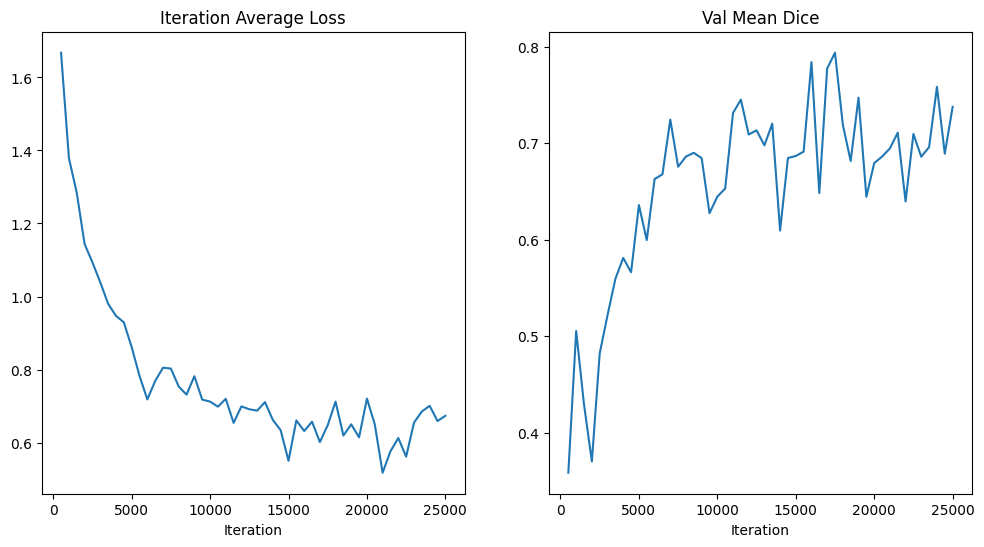

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [7]:
#test
test = torch.randn(4, 1, 96, 96, 96).cuda()
output = model(test)

x_in vit torch.Size([4, 1, 96, 96, 96])
x_in affter embed torch.Size([4, 216, 384])
torch.Size([4, 216, 384])


In [ ]:
#Frequncy UNETR

In [5]:
#wavelet ViT+Concat ViT
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.73908): 100%|█| 24/24 [00:14<00:00,  1.69it/
Training (47 / 25000 Steps) (loss=2.59532): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (71 / 25000 Steps) (loss=2.64503): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (95 / 25000 Steps) (loss=2.54463): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (119 / 25000 Steps) (loss=2.51411): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (143 / 25000 Steps) (loss=2.34984): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (167 / 25000 Steps) (loss=2.29987): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (191 / 25000 Steps) (loss=2.26373): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (215 / 25000 Steps) (loss=2.34062): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (239 / 25000 Steps) (loss=2.21631): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (263 / 25000 Steps) (loss=2.15042): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (287 / 25000 Steps) (loss=2.18460): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.47985386848449707 Current Avg. Dice: 0.47985386848449707


Training (503 / 25000 Steps) (loss=2.03632): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (527 / 25000 Steps) (loss=1.98798): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (551 / 25000 Steps) (loss=1.91632): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (575 / 25000 Steps) (loss=2.07393): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (599 / 25000 Steps) (loss=1.88139): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (623 / 25000 Steps) (loss=1.88433): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (647 / 25000 Steps) (loss=2.02491): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (671 / 25000 Steps) (loss=1.67857): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (695 / 25000 Steps) (loss=1.98139): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (719 / 25000 Steps) (loss=1.86870): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (743 / 25000 Steps) (loss=1.71191): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (767 / 25000 Steps) (loss=1.75214): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.47985386848449707 Current Avg. Dice: 0.4780355393886566


Training (1007 / 25000 Steps) (loss=1.62198): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (1031 / 25000 Steps) (loss=1.59837): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1055 / 25000 Steps) (loss=1.49862): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1079 / 25000 Steps) (loss=1.47369): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1103 / 25000 Steps) (loss=1.51577): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1127 / 25000 Steps) (loss=1.49675): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1151 / 25000 Steps) (loss=1.51138): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1175 / 25000 Steps) (loss=1.56177): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=1.48780): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1223 / 25000 Steps) (loss=1.49276): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1247 / 25000 Steps) (loss=1.40848): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1271 / 25000 Steps) (loss=1.53817): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.47985386848449707 Current Avg. Dice: 0.4291788637638092


Training (1511 / 25000 Steps) (loss=1.37824): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (1535 / 25000 Steps) (loss=1.69007): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1559 / 25000 Steps) (loss=1.23465): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1583 / 25000 Steps) (loss=1.22365): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1607 / 25000 Steps) (loss=1.19771): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1631 / 25000 Steps) (loss=1.22700): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=1.26806): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1679 / 25000 Steps) (loss=1.20196): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1703 / 25000 Steps) (loss=1.20001): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1727 / 25000 Steps) (loss=1.18173): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1751 / 25000 Steps) (loss=1.22330): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1775 / 25000 Steps) (loss=1.20735): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.47985386848449707 Current Avg. Dice: 0.45512983202934265


Training (2015 / 25000 Steps) (loss=1.19944): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (2039 / 25000 Steps) (loss=1.33742): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2063 / 25000 Steps) (loss=1.10656): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2087 / 25000 Steps) (loss=1.14296): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2111 / 25000 Steps) (loss=1.10477): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2135 / 25000 Steps) (loss=1.08408): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2159 / 25000 Steps) (loss=1.18027): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2183 / 25000 Steps) (loss=1.21374): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2207 / 25000 Steps) (loss=1.17769): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2231 / 25000 Steps) (loss=1.17787): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2255 / 25000 Steps) (loss=1.09811): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2279 / 25000 Steps) (loss=1.28375): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4986917972564697 Current Avg. Dice: 0.4986917972564697


Training (2519 / 25000 Steps) (loss=1.25918): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (2543 / 25000 Steps) (loss=1.04771): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2567 / 25000 Steps) (loss=1.04573): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2591 / 25000 Steps) (loss=0.97912): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2615 / 25000 Steps) (loss=1.15002): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2639 / 25000 Steps) (loss=1.22248): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2663 / 25000 Steps) (loss=1.11309): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2687 / 25000 Steps) (loss=1.06974): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2711 / 25000 Steps) (loss=1.10115): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2735 / 25000 Steps) (loss=1.16124): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2759 / 25000 Steps) (loss=0.94197): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2783 / 25000 Steps) (loss=1.00519): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5960672497749329 Current Avg. Dice: 0.5960672497749329


Training (3023 / 25000 Steps) (loss=0.99928): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (3047 / 25000 Steps) (loss=1.07624): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3071 / 25000 Steps) (loss=0.95146): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3095 / 25000 Steps) (loss=1.01814): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3119 / 25000 Steps) (loss=1.10799): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3143 / 25000 Steps) (loss=0.91869): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3167 / 25000 Steps) (loss=1.04368): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3191 / 25000 Steps) (loss=1.01190): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3215 / 25000 Steps) (loss=0.99304): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3239 / 25000 Steps) (loss=0.95975): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3263 / 25000 Steps) (loss=1.00178): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3287 / 25000 Steps) (loss=1.02821): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6267338395118713 Current Avg. Dice: 0.6267338395118713


Training (3503 / 25000 Steps) (loss=0.99425): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (3527 / 25000 Steps) (loss=0.98214): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3551 / 25000 Steps) (loss=0.98374): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3575 / 25000 Steps) (loss=1.01816): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3599 / 25000 Steps) (loss=1.10442): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=1.02063): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3647 / 25000 Steps) (loss=0.92858): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3671 / 25000 Steps) (loss=0.97441): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3695 / 25000 Steps) (loss=1.03773): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3719 / 25000 Steps) (loss=0.87058): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3743 / 25000 Steps) (loss=0.99191): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3767 / 25000 Steps) (loss=0.94505): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6267338395118713 Current Avg. Dice: 0.6141595840454102


Training (4007 / 25000 Steps) (loss=0.92280): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (4031 / 25000 Steps) (loss=1.49759): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4055 / 25000 Steps) (loss=0.95078): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4079 / 25000 Steps) (loss=1.37323): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4103 / 25000 Steps) (loss=1.08316): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4127 / 25000 Steps) (loss=1.04448): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4151 / 25000 Steps) (loss=0.97362): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4175 / 25000 Steps) (loss=0.99758): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4199 / 25000 Steps) (loss=0.99559): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4223 / 25000 Steps) (loss=1.01045): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4247 / 25000 Steps) (loss=0.90372): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4271 / 25000 Steps) (loss=1.02447): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6848090291023254 Current Avg. Dice: 0.6848090291023254


Training (4511 / 25000 Steps) (loss=0.86082): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (4535 / 25000 Steps) (loss=0.89002): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4559 / 25000 Steps) (loss=0.93794): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4583 / 25000 Steps) (loss=1.03947): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4607 / 25000 Steps) (loss=0.88460): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4631 / 25000 Steps) (loss=0.84432): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4655 / 25000 Steps) (loss=1.01243): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4679 / 25000 Steps) (loss=0.98421): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4703 / 25000 Steps) (loss=1.02521): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4727 / 25000 Steps) (loss=0.92806): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4751 / 25000 Steps) (loss=0.88369): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4775 / 25000 Steps) (loss=0.91638): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6918427348136902 Current Avg. Dice: 0.6918427348136902


Training (5015 / 25000 Steps) (loss=0.87441): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (5039 / 25000 Steps) (loss=0.91193): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5063 / 25000 Steps) (loss=0.95608): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5087 / 25000 Steps) (loss=1.02356): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5111 / 25000 Steps) (loss=0.90056): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5135 / 25000 Steps) (loss=1.11968): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5159 / 25000 Steps) (loss=0.90012): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5183 / 25000 Steps) (loss=0.90916): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5207 / 25000 Steps) (loss=0.91923): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5231 / 25000 Steps) (loss=0.77252): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5255 / 25000 Steps) (loss=0.87751): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5279 / 25000 Steps) (loss=0.97362): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6918427348136902 Current Avg. Dice: 0.6783245205879211


Training (5519 / 25000 Steps) (loss=0.85161): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (5543 / 25000 Steps) (loss=0.95681): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5567 / 25000 Steps) (loss=0.91986): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5591 / 25000 Steps) (loss=0.96383): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5615 / 25000 Steps) (loss=0.97316): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5639 / 25000 Steps) (loss=1.02524): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5663 / 25000 Steps) (loss=0.97124): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5687 / 25000 Steps) (loss=1.02283): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5711 / 25000 Steps) (loss=0.85755): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5735 / 25000 Steps) (loss=0.73929): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5759 / 25000 Steps) (loss=0.85929): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5783 / 25000 Steps) (loss=0.93325): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6918427348136902 Current Avg. Dice: 0.6608629822731018


Training (6023 / 25000 Steps) (loss=0.90642): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (6047 / 25000 Steps) (loss=0.77014): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6071 / 25000 Steps) (loss=1.15849): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6095 / 25000 Steps) (loss=0.80839): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6119 / 25000 Steps) (loss=0.80532): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6143 / 25000 Steps) (loss=0.87404): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6167 / 25000 Steps) (loss=0.87393): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6191 / 25000 Steps) (loss=0.88705): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6215 / 25000 Steps) (loss=0.89449): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6239 / 25000 Steps) (loss=0.91636): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6263 / 25000 Steps) (loss=1.01290): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6287 / 25000 Steps) (loss=0.82297): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6918427348136902 Current Avg. Dice: 0.6219101548194885


Training (6503 / 25000 Steps) (loss=0.83402): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6527 / 25000 Steps) (loss=1.21444): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6551 / 25000 Steps) (loss=0.74809): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6575 / 25000 Steps) (loss=0.85794): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6599 / 25000 Steps) (loss=0.80286): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6623 / 25000 Steps) (loss=0.76421): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6647 / 25000 Steps) (loss=0.67433): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6671 / 25000 Steps) (loss=0.95663): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6695 / 25000 Steps) (loss=0.77053): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6719 / 25000 Steps) (loss=0.85873): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6743 / 25000 Steps) (loss=0.74234): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6767 / 25000 Steps) (loss=0.92304): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6918427348136902 Current Avg. Dice: 0.675419807434082


Training (7007 / 25000 Steps) (loss=0.67539): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7031 / 25000 Steps) (loss=0.75598): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7055 / 25000 Steps) (loss=0.83394): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7079 / 25000 Steps) (loss=0.89687): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7103 / 25000 Steps) (loss=0.84815): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7127 / 25000 Steps) (loss=0.84046): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7151 / 25000 Steps) (loss=0.84465): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7175 / 25000 Steps) (loss=0.82435): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7199 / 25000 Steps) (loss=0.71915): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7223 / 25000 Steps) (loss=0.81155): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7247 / 25000 Steps) (loss=0.78543): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7271 / 25000 Steps) (loss=0.92259): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6918427348136902 Current Avg. Dice: 0.6349913477897644


Training (7511 / 25000 Steps) (loss=0.77063): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7535 / 25000 Steps) (loss=0.76774): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7559 / 25000 Steps) (loss=0.79839): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7583 / 25000 Steps) (loss=0.75725): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7607 / 25000 Steps) (loss=0.79259): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7631 / 25000 Steps) (loss=0.74351): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7655 / 25000 Steps) (loss=0.75943): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7679 / 25000 Steps) (loss=0.87921): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7703 / 25000 Steps) (loss=0.71466): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7727 / 25000 Steps) (loss=0.76916): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7751 / 25000 Steps) (loss=0.80348): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7775 / 25000 Steps) (loss=0.77598): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6982730031013489 Current Avg. Dice: 0.6982730031013489


Training (8015 / 25000 Steps) (loss=0.83300): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (8039 / 25000 Steps) (loss=0.78825): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8063 / 25000 Steps) (loss=0.59483): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8087 / 25000 Steps) (loss=1.08033): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8111 / 25000 Steps) (loss=0.94536): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8135 / 25000 Steps) (loss=0.78744): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8159 / 25000 Steps) (loss=1.30844): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8183 / 25000 Steps) (loss=0.74281): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8207 / 25000 Steps) (loss=0.85001): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8231 / 25000 Steps) (loss=0.71285): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8255 / 25000 Steps) (loss=0.73983): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8279 / 25000 Steps) (loss=0.67618): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7810254693031311 Current Avg. Dice: 0.7810254693031311


Training (8519 / 25000 Steps) (loss=0.78863): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (8543 / 25000 Steps) (loss=0.70858): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8567 / 25000 Steps) (loss=0.78451): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8591 / 25000 Steps) (loss=0.61738): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8615 / 25000 Steps) (loss=0.85551): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (8639 / 25000 Steps) (loss=0.82128): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8663 / 25000 Steps) (loss=0.72538): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8687 / 25000 Steps) (loss=0.72527): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8711 / 25000 Steps) (loss=0.90447): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8735 / 25000 Steps) (loss=0.62113): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8759 / 25000 Steps) (loss=0.78117): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8783 / 25000 Steps) (loss=0.71034): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7886631488800049 Current Avg. Dice: 0.7886631488800049


Training (9023 / 25000 Steps) (loss=0.69791): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (9047 / 25000 Steps) (loss=0.79521): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9071 / 25000 Steps) (loss=0.69581): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9095 / 25000 Steps) (loss=0.85586): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9119 / 25000 Steps) (loss=0.72221): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9143 / 25000 Steps) (loss=0.91540): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9167 / 25000 Steps) (loss=0.66517): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9191 / 25000 Steps) (loss=0.66041): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9215 / 25000 Steps) (loss=0.69341): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9239 / 25000 Steps) (loss=0.68497): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9263 / 25000 Steps) (loss=0.76021): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9287 / 25000 Steps) (loss=0.59661): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7886631488800049 Current Avg. Dice: 0.7336940765380859


Training (9503 / 25000 Steps) (loss=0.76935): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9527 / 25000 Steps) (loss=0.60471): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9551 / 25000 Steps) (loss=0.77970): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9575 / 25000 Steps) (loss=0.62082): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9599 / 25000 Steps) (loss=0.66976): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9623 / 25000 Steps) (loss=0.66334): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9647 / 25000 Steps) (loss=0.64080): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (9671 / 25000 Steps) (loss=0.75803): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9695 / 25000 Steps) (loss=0.65136): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9719 / 25000 Steps) (loss=0.72726): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9743 / 25000 Steps) (loss=0.80774): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9767 / 25000 Steps) (loss=0.71808): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8252553343772888 Current Avg. Dice: 0.8252553343772888


Training (10007 / 25000 Steps) (loss=0.63075): 100%|█| 24/24 [00:16<00:00,  1.43
Training (10031 / 25000 Steps) (loss=0.73181): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10055 / 25000 Steps) (loss=0.63919): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10079 / 25000 Steps) (loss=0.65583): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=0.74231): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10127 / 25000 Steps) (loss=0.73186): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10151 / 25000 Steps) (loss=0.80276): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10175 / 25000 Steps) (loss=0.83372): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10199 / 25000 Steps) (loss=0.77440): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10223 / 25000 Steps) (loss=0.89390): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10247 / 25000 Steps) (loss=0.69792): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.80428): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8252553343772888 Current Avg. Dice: 0.7827040553092957


Training (10511 / 25000 Steps) (loss=0.71974): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10535 / 25000 Steps) (loss=0.60263): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10559 / 25000 Steps) (loss=1.36449): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10583 / 25000 Steps) (loss=0.80307): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10607 / 25000 Steps) (loss=0.87228): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10631 / 25000 Steps) (loss=0.73219): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10655 / 25000 Steps) (loss=0.64026): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10679 / 25000 Steps) (loss=0.72644): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10703 / 25000 Steps) (loss=0.59698): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10727 / 25000 Steps) (loss=0.64213): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10751 / 25000 Steps) (loss=0.88576): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10775 / 25000 Steps) (loss=0.68144): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8252553343772888 Current Avg. Dice: 0.7733541131019592


Training (11015 / 25000 Steps) (loss=0.63737): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11039 / 25000 Steps) (loss=0.61103): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11063 / 25000 Steps) (loss=0.80428): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11087 / 25000 Steps) (loss=0.62830): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11111 / 25000 Steps) (loss=0.97732): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11135 / 25000 Steps) (loss=0.66056): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11159 / 25000 Steps) (loss=0.72668): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.55321): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11207 / 25000 Steps) (loss=0.55572): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11231 / 25000 Steps) (loss=0.70048): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11255 / 25000 Steps) (loss=0.71995): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11279 / 25000 Steps) (loss=0.67181): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8252553343772888 Current Avg. Dice: 0.7902622222900391


Training (11519 / 25000 Steps) (loss=0.69411): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11543 / 25000 Steps) (loss=0.53671): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11567 / 25000 Steps) (loss=0.64283): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11591 / 25000 Steps) (loss=0.70377): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11615 / 25000 Steps) (loss=0.75450): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11639 / 25000 Steps) (loss=0.66382): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11663 / 25000 Steps) (loss=0.84587): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11687 / 25000 Steps) (loss=0.60749): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11711 / 25000 Steps) (loss=0.66735): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11735 / 25000 Steps) (loss=0.70825): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11759 / 25000 Steps) (loss=0.47159): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11783 / 25000 Steps) (loss=0.76246): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8252553343772888 Current Avg. Dice: 0.8106406331062317


Training (12023 / 25000 Steps) (loss=0.44063): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12047 / 25000 Steps) (loss=0.46226): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12071 / 25000 Steps) (loss=0.95661): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12095 / 25000 Steps) (loss=0.61278): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12119 / 25000 Steps) (loss=0.81120): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12143 / 25000 Steps) (loss=0.61372): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12167 / 25000 Steps) (loss=0.70163): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12191 / 25000 Steps) (loss=0.75343): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12215 / 25000 Steps) (loss=0.70915): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12239 / 25000 Steps) (loss=0.71913): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12263 / 25000 Steps) (loss=0.77562): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12287 / 25000 Steps) (loss=0.64125): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8380026817321777 Current Avg. Dice: 0.8380026817321777


Training (12503 / 25000 Steps) (loss=0.48977): 100%|█| 24/24 [00:16<00:00,  1.42
Training (12527 / 25000 Steps) (loss=0.65898): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12551 / 25000 Steps) (loss=0.60648): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12575 / 25000 Steps) (loss=0.78696): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12599 / 25000 Steps) (loss=0.70826): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12623 / 25000 Steps) (loss=0.77564): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12647 / 25000 Steps) (loss=0.59655): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12671 / 25000 Steps) (loss=0.65775): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12695 / 25000 Steps) (loss=0.68626): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12719 / 25000 Steps) (loss=0.65332): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12743 / 25000 Steps) (loss=0.64292): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12767 / 25000 Steps) (loss=0.67730): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8405930995941162 Current Avg. Dice: 0.8405930995941162


Training (13007 / 25000 Steps) (loss=0.54788): 100%|█| 24/24 [00:16<00:00,  1.41
Training (13031 / 25000 Steps) (loss=0.84849): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13055 / 25000 Steps) (loss=0.64169): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13079 / 25000 Steps) (loss=0.79831): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13103 / 25000 Steps) (loss=0.62555): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13127 / 25000 Steps) (loss=0.66725): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13151 / 25000 Steps) (loss=0.69120): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13175 / 25000 Steps) (loss=0.78781): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13199 / 25000 Steps) (loss=0.54333): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13223 / 25000 Steps) (loss=0.55846): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13247 / 25000 Steps) (loss=0.64910): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13271 / 25000 Steps) (loss=0.98399): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8405930995941162 Current Avg. Dice: 0.8097733855247498


Training (13511 / 25000 Steps) (loss=0.63854): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13535 / 25000 Steps) (loss=0.68479): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13559 / 25000 Steps) (loss=0.68831): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13583 / 25000 Steps) (loss=0.84164): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13607 / 25000 Steps) (loss=0.59720): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13631 / 25000 Steps) (loss=0.64641): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13655 / 25000 Steps) (loss=0.88041): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13679 / 25000 Steps) (loss=0.55928): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13703 / 25000 Steps) (loss=0.78574): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13727 / 25000 Steps) (loss=0.78958): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13751 / 25000 Steps) (loss=0.61013): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13775 / 25000 Steps) (loss=0.75045): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8405930995941162 Current Avg. Dice: 0.8402948975563049


Training (14015 / 25000 Steps) (loss=0.67493): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14039 / 25000 Steps) (loss=0.72503): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14063 / 25000 Steps) (loss=0.67981): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14087 / 25000 Steps) (loss=0.67696): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14111 / 25000 Steps) (loss=0.72854): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14135 / 25000 Steps) (loss=0.91337): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14159 / 25000 Steps) (loss=0.67692): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14183 / 25000 Steps) (loss=0.50427): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14207 / 25000 Steps) (loss=0.70366): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14231 / 25000 Steps) (loss=0.73865): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14255 / 25000 Steps) (loss=0.57300): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14279 / 25000 Steps) (loss=0.66018): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8405930995941162 Current Avg. Dice: 0.810933530330658


Training (14519 / 25000 Steps) (loss=0.65023): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14543 / 25000 Steps) (loss=1.19502): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14567 / 25000 Steps) (loss=0.53019): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14591 / 25000 Steps) (loss=0.58651): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14615 / 25000 Steps) (loss=0.77499): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14639 / 25000 Steps) (loss=0.68966): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14663 / 25000 Steps) (loss=0.69266): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14687 / 25000 Steps) (loss=0.65486): 100%|█| 24/24 [00:11<00:00,  2.04
Training (14711 / 25000 Steps) (loss=0.70577): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14735 / 25000 Steps) (loss=0.75465): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14759 / 25000 Steps) (loss=0.64169): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14783 / 25000 Steps) (loss=0.68293): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8405930995941162 Current Avg. Dice: 0.7885751724243164


Training (15023 / 25000 Steps) (loss=0.61768): 100%|█| 24/24 [00:13<00:00,  1.79
Training (15047 / 25000 Steps) (loss=0.62133): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15071 / 25000 Steps) (loss=0.55056): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15095 / 25000 Steps) (loss=0.51775): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15119 / 25000 Steps) (loss=0.66031): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15143 / 25000 Steps) (loss=0.73850): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15167 / 25000 Steps) (loss=0.53450): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15191 / 25000 Steps) (loss=0.66301): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15215 / 25000 Steps) (loss=0.82077): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15239 / 25000 Steps) (loss=0.58703): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15263 / 25000 Steps) (loss=0.73972): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15287 / 25000 Steps) (loss=0.63370): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.8690745830535889


Training (15503 / 25000 Steps) (loss=0.98701): 100%|█| 24/24 [00:16<00:00,  1.41
Training (15527 / 25000 Steps) (loss=0.60832): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15551 / 25000 Steps) (loss=0.69829): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15575 / 25000 Steps) (loss=0.66316): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15599 / 25000 Steps) (loss=0.82255): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15623 / 25000 Steps) (loss=0.76768): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15647 / 25000 Steps) (loss=0.80824): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15671 / 25000 Steps) (loss=0.54251): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15695 / 25000 Steps) (loss=0.44756): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15719 / 25000 Steps) (loss=0.74186): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15743 / 25000 Steps) (loss=0.75566): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15767 / 25000 Steps) (loss=0.69804): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.7913284301757812


Training (16007 / 25000 Steps) (loss=0.59074): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16031 / 25000 Steps) (loss=0.67849): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16055 / 25000 Steps) (loss=0.64804): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16079 / 25000 Steps) (loss=0.57367): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16103 / 25000 Steps) (loss=0.70681): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16127 / 25000 Steps) (loss=0.41291): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16151 / 25000 Steps) (loss=0.60583): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16175 / 25000 Steps) (loss=0.57901): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16199 / 25000 Steps) (loss=0.42302): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16223 / 25000 Steps) (loss=0.66006): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16247 / 25000 Steps) (loss=0.72278): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16271 / 25000 Steps) (loss=0.57237): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.8227951526641846


Training (16511 / 25000 Steps) (loss=0.55484): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.57084): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16559 / 25000 Steps) (loss=0.68866): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16583 / 25000 Steps) (loss=0.67804): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16607 / 25000 Steps) (loss=0.87226): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16631 / 25000 Steps) (loss=0.58132): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16655 / 25000 Steps) (loss=0.59850): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16679 / 25000 Steps) (loss=0.77247): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16703 / 25000 Steps) (loss=0.61002): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16727 / 25000 Steps) (loss=0.65372): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16751 / 25000 Steps) (loss=0.57872): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16775 / 25000 Steps) (loss=0.64960): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.8268249034881592


Training (17015 / 25000 Steps) (loss=0.67532): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17039 / 25000 Steps) (loss=0.54582): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17063 / 25000 Steps) (loss=0.66584): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17087 / 25000 Steps) (loss=0.72686): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17111 / 25000 Steps) (loss=0.74353): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17135 / 25000 Steps) (loss=0.52283): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17159 / 25000 Steps) (loss=0.78280): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17183 / 25000 Steps) (loss=0.54610): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17207 / 25000 Steps) (loss=0.66939): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17231 / 25000 Steps) (loss=0.52880): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17255 / 25000 Steps) (loss=0.63413): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17279 / 25000 Steps) (loss=0.77982): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.802206814289093


Training (17519 / 25000 Steps) (loss=0.49339): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17543 / 25000 Steps) (loss=0.49722): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17567 / 25000 Steps) (loss=0.68860): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17591 / 25000 Steps) (loss=0.52100): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17615 / 25000 Steps) (loss=0.53797): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17639 / 25000 Steps) (loss=0.52586): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17663 / 25000 Steps) (loss=0.68465): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17687 / 25000 Steps) (loss=0.44649): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17711 / 25000 Steps) (loss=0.79010): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17735 / 25000 Steps) (loss=0.56687): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17759 / 25000 Steps) (loss=0.67214): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17783 / 25000 Steps) (loss=0.43676): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.8169315457344055


Training (18023 / 25000 Steps) (loss=0.61809): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18047 / 25000 Steps) (loss=0.64559): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18071 / 25000 Steps) (loss=0.64507): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18095 / 25000 Steps) (loss=0.51429): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18119 / 25000 Steps) (loss=0.80685): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18143 / 25000 Steps) (loss=0.64847): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18167 / 25000 Steps) (loss=0.68321): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18191 / 25000 Steps) (loss=0.59400): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18215 / 25000 Steps) (loss=0.68337): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18239 / 25000 Steps) (loss=0.63207): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18263 / 25000 Steps) (loss=0.63725): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18287 / 25000 Steps) (loss=0.77490): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8690745830535889 Current Avg. Dice: 0.8138276934623718


Training (18503 / 25000 Steps) (loss=0.72873): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18527 / 25000 Steps) (loss=0.50607): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18551 / 25000 Steps) (loss=0.79481): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18575 / 25000 Steps) (loss=0.55399): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18599 / 25000 Steps) (loss=0.78964): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18623 / 25000 Steps) (loss=0.51418): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18647 / 25000 Steps) (loss=0.64514): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18671 / 25000 Steps) (loss=0.66926): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18695 / 25000 Steps) (loss=0.71637): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18719 / 25000 Steps) (loss=0.47581): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18743 / 25000 Steps) (loss=0.82020): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18767 / 25000 Steps) (loss=0.71880): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8765724301338196


Training (19007 / 25000 Steps) (loss=0.78036): 100%|█| 24/24 [00:16<00:00,  1.41
Training (19031 / 25000 Steps) (loss=0.65424): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19055 / 25000 Steps) (loss=0.68193): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19079 / 25000 Steps) (loss=0.58596): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19103 / 25000 Steps) (loss=0.63151): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19127 / 25000 Steps) (loss=0.67236): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.71934): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19175 / 25000 Steps) (loss=0.69641): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19199 / 25000 Steps) (loss=0.61530): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19223 / 25000 Steps) (loss=0.55707): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19247 / 25000 Steps) (loss=0.82115): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19271 / 25000 Steps) (loss=0.63665): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8028598427772522


Training (19511 / 25000 Steps) (loss=0.55839): 100%|█| 24/24 [00:13<00:00,  1.80
Training (19535 / 25000 Steps) (loss=0.70042): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19559 / 25000 Steps) (loss=0.64556): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19583 / 25000 Steps) (loss=0.68226): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19607 / 25000 Steps) (loss=0.56915): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19631 / 25000 Steps) (loss=0.66784): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19655 / 25000 Steps) (loss=0.66549): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19679 / 25000 Steps) (loss=0.49831): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19703 / 25000 Steps) (loss=0.75582): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19727 / 25000 Steps) (loss=0.57658): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19751 / 25000 Steps) (loss=0.48592): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19775 / 25000 Steps) (loss=0.81770): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8233111500740051


Training (20015 / 25000 Steps) (loss=0.65289): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20039 / 25000 Steps) (loss=0.77395): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20063 / 25000 Steps) (loss=0.65939): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20087 / 25000 Steps) (loss=0.38889): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20111 / 25000 Steps) (loss=0.68896): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20135 / 25000 Steps) (loss=0.50639): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20159 / 25000 Steps) (loss=0.60416): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=0.46336): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20207 / 25000 Steps) (loss=0.37514): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20231 / 25000 Steps) (loss=0.73622): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.55702): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20279 / 25000 Steps) (loss=0.74871): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8707818984985352


Training (20519 / 25000 Steps) (loss=0.59218): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20543 / 25000 Steps) (loss=0.87611): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20567 / 25000 Steps) (loss=0.66556): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20591 / 25000 Steps) (loss=0.61998): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20615 / 25000 Steps) (loss=0.65291): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20639 / 25000 Steps) (loss=0.61152): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.61559): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20687 / 25000 Steps) (loss=0.75535): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20711 / 25000 Steps) (loss=0.65132): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20735 / 25000 Steps) (loss=0.54234): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20759 / 25000 Steps) (loss=0.48627): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20783 / 25000 Steps) (loss=0.87790): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8716256022453308


Training (21023 / 25000 Steps) (loss=0.82268): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21047 / 25000 Steps) (loss=0.55194): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21071 / 25000 Steps) (loss=0.61758): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21095 / 25000 Steps) (loss=0.77132): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21119 / 25000 Steps) (loss=0.65334): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21143 / 25000 Steps) (loss=0.54105): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21167 / 25000 Steps) (loss=0.57674): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21191 / 25000 Steps) (loss=0.56720): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21215 / 25000 Steps) (loss=0.56843): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21239 / 25000 Steps) (loss=0.58746): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21263 / 25000 Steps) (loss=0.66134): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21287 / 25000 Steps) (loss=0.59357): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8616433143615723


Training (21503 / 25000 Steps) (loss=0.54808): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21527 / 25000 Steps) (loss=0.69699): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21551 / 25000 Steps) (loss=0.51432): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21575 / 25000 Steps) (loss=0.60747): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21599 / 25000 Steps) (loss=0.63045): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21623 / 25000 Steps) (loss=0.69956): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21647 / 25000 Steps) (loss=0.64339): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21671 / 25000 Steps) (loss=0.61799): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.58752): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21719 / 25000 Steps) (loss=0.47744): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21743 / 25000 Steps) (loss=0.52504): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21767 / 25000 Steps) (loss=0.45789): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8599131107330322


Training (22007 / 25000 Steps) (loss=0.69995): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22031 / 25000 Steps) (loss=0.68526): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22055 / 25000 Steps) (loss=0.61227): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22079 / 25000 Steps) (loss=0.81947): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22103 / 25000 Steps) (loss=0.88512): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22127 / 25000 Steps) (loss=0.53767): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22151 / 25000 Steps) (loss=0.79294): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22175 / 25000 Steps) (loss=0.71566): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.67213): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22223 / 25000 Steps) (loss=0.59065): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22247 / 25000 Steps) (loss=0.70381): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22271 / 25000 Steps) (loss=0.53264): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.7414026260375977


Training (22511 / 25000 Steps) (loss=0.43231): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22535 / 25000 Steps) (loss=0.61668): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22559 / 25000 Steps) (loss=0.50858): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22583 / 25000 Steps) (loss=0.46647): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22607 / 25000 Steps) (loss=0.59195): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22631 / 25000 Steps) (loss=0.67018): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22655 / 25000 Steps) (loss=0.52964): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22679 / 25000 Steps) (loss=0.43878): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22703 / 25000 Steps) (loss=0.75432): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22727 / 25000 Steps) (loss=0.73197): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22751 / 25000 Steps) (loss=0.46860): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22775 / 25000 Steps) (loss=0.51489): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8296794891357422


Training (23015 / 25000 Steps) (loss=0.55426): 100%|█| 24/24 [00:13<00:00,  1.80
Training (23039 / 25000 Steps) (loss=0.48990): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23063 / 25000 Steps) (loss=0.69730): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23087 / 25000 Steps) (loss=0.58849): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23111 / 25000 Steps) (loss=0.70102): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23135 / 25000 Steps) (loss=0.72442): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23159 / 25000 Steps) (loss=0.65054): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23183 / 25000 Steps) (loss=0.56515): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23207 / 25000 Steps) (loss=0.49424): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23231 / 25000 Steps) (loss=0.83574): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23255 / 25000 Steps) (loss=0.43829): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23279 / 25000 Steps) (loss=0.58119): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.810945451259613


Training (23519 / 25000 Steps) (loss=0.62187): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23543 / 25000 Steps) (loss=0.68133): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23567 / 25000 Steps) (loss=0.59325): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23591 / 25000 Steps) (loss=0.86036): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23615 / 25000 Steps) (loss=0.55530): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23639 / 25000 Steps) (loss=0.42810): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23663 / 25000 Steps) (loss=0.42980): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23687 / 25000 Steps) (loss=0.62703): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23711 / 25000 Steps) (loss=0.45869): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23735 / 25000 Steps) (loss=0.72470): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23759 / 25000 Steps) (loss=0.64047): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23783 / 25000 Steps) (loss=0.59414): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.836582362651825


Training (24023 / 25000 Steps) (loss=0.67336): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24047 / 25000 Steps) (loss=0.69477): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24071 / 25000 Steps) (loss=0.53600): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24095 / 25000 Steps) (loss=0.57000): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24119 / 25000 Steps) (loss=0.52935): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24143 / 25000 Steps) (loss=0.42336): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24167 / 25000 Steps) (loss=0.56107): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24191 / 25000 Steps) (loss=0.41296): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24215 / 25000 Steps) (loss=0.37469): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24239 / 25000 Steps) (loss=0.60108): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24263 / 25000 Steps) (loss=0.55078): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24287 / 25000 Steps) (loss=0.64326): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.7967284321784973


Training (24503 / 25000 Steps) (loss=0.53706): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24527 / 25000 Steps) (loss=0.55948): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24551 / 25000 Steps) (loss=0.58824): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24575 / 25000 Steps) (loss=0.66685): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24599 / 25000 Steps) (loss=0.58968): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.66418): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24647 / 25000 Steps) (loss=0.56932): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24671 / 25000 Steps) (loss=0.48964): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24695 / 25000 Steps) (loss=0.50554): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24719 / 25000 Steps) (loss=0.69849): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24743 / 25000 Steps) (loss=0.78315): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24767 / 25000 Steps) (loss=0.76661): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8765724301338196 Current Avg. Dice: 0.8059235215187073


Training (25007 / 25000 Steps) (loss=0.53785): 100%|█| 24/24 [00:13<00:00,  1.79


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8766 at iteration: 19000


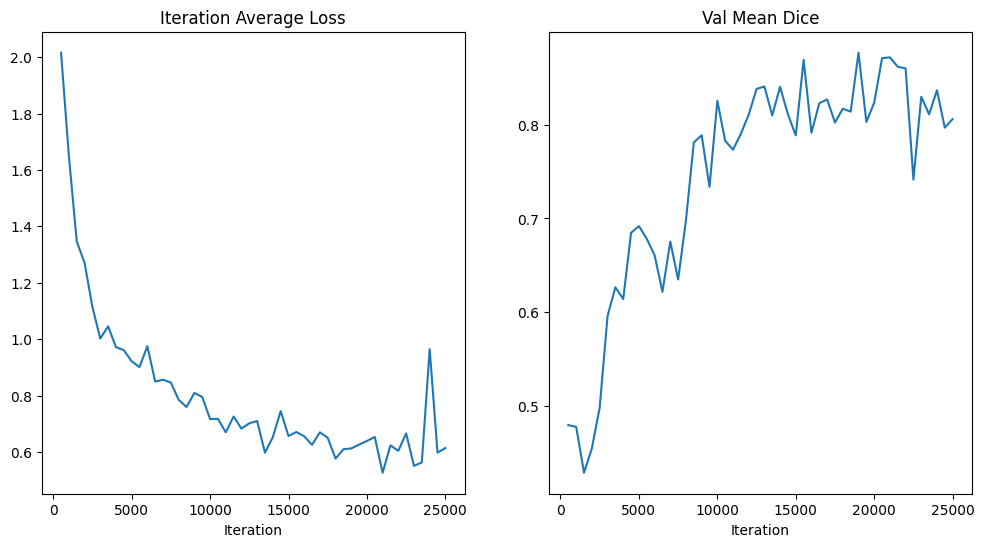

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.60784): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.60558): 100%|█| 24/24 [00:12<00:00,  1.96it/
Training (71 / 25000 Steps) (loss=2.52903): 100%|█| 24/24 [00:12<00:00,  2.00it/
Training (95 / 25000 Steps) (loss=2.36689): 100%|█| 24/24 [00:12<00:00,  2.00it/
Training (119 / 25000 Steps) (loss=2.28275): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (143 / 25000 Steps) (loss=2.20229): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (167 / 25000 Steps) (loss=2.29074): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (191 / 25000 Steps) (loss=2.15266): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (215 / 25000 Steps) (loss=2.22878): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (239 / 25000 Steps) (loss=2.10377): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (263 / 25000 Steps) (loss=2.04146): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (287 / 25000 Steps) (loss=2.14216): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.40172386169433594 Current Avg. Dice: 0.40172386169433594


Training (503 / 25000 Steps) (loss=1.90997): 100%|█| 24/24 [00:16<00:00,  1.46it
Training (527 / 25000 Steps) (loss=1.78113): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (551 / 25000 Steps) (loss=2.10633): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (575 / 25000 Steps) (loss=1.77492): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (599 / 25000 Steps) (loss=1.72397): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (623 / 25000 Steps) (loss=1.70096): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (647 / 25000 Steps) (loss=1.71463): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (671 / 25000 Steps) (loss=1.70384): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (695 / 25000 Steps) (loss=1.68389): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (719 / 25000 Steps) (loss=1.41543): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (743 / 25000 Steps) (loss=1.84693): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (767 / 25000 Steps) (loss=1.59437): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.40172386169433594 Current Avg. Dice: 0.3798346519470215


Training (1007 / 25000 Steps) (loss=1.47837): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (1031 / 25000 Steps) (loss=1.67380): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.45870): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1079 / 25000 Steps) (loss=1.35823): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1103 / 25000 Steps) (loss=1.46288): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1127 / 25000 Steps) (loss=1.50931): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1151 / 25000 Steps) (loss=1.33869): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.43104): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=1.41230): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1223 / 25000 Steps) (loss=1.47430): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1247 / 25000 Steps) (loss=1.46603): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1271 / 25000 Steps) (loss=1.31423): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.40172386169433594 Current Avg. Dice: 0.3694114685058594


Training (1511 / 25000 Steps) (loss=1.22729): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (1535 / 25000 Steps) (loss=1.21655): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1559 / 25000 Steps) (loss=1.24409): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1583 / 25000 Steps) (loss=1.37695): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1607 / 25000 Steps) (loss=1.42767): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1631 / 25000 Steps) (loss=1.37448): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1655 / 25000 Steps) (loss=1.19771): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1679 / 25000 Steps) (loss=1.26307): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1703 / 25000 Steps) (loss=1.24486): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1727 / 25000 Steps) (loss=1.15400): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1751 / 25000 Steps) (loss=1.15024): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1775 / 25000 Steps) (loss=1.23537): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.40172386169433594 Current Avg. Dice: 0.3439309895038605


Training (2015 / 25000 Steps) (loss=1.12602): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2039 / 25000 Steps) (loss=1.11143): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2063 / 25000 Steps) (loss=1.23314): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2087 / 25000 Steps) (loss=1.13508): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2111 / 25000 Steps) (loss=1.17099): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2135 / 25000 Steps) (loss=1.15602): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2159 / 25000 Steps) (loss=1.19346): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2183 / 25000 Steps) (loss=1.07502): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2207 / 25000 Steps) (loss=1.18821): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2231 / 25000 Steps) (loss=1.15271): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2255 / 25000 Steps) (loss=1.16508): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2279 / 25000 Steps) (loss=1.11054): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.40172386169433594 Current Avg. Dice: 0.3886929452419281


Training (2519 / 25000 Steps) (loss=1.08517): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (2543 / 25000 Steps) (loss=1.05376): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2567 / 25000 Steps) (loss=1.28001): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2591 / 25000 Steps) (loss=1.26398): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2615 / 25000 Steps) (loss=1.09061): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2639 / 25000 Steps) (loss=1.15979): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2663 / 25000 Steps) (loss=1.02766): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2687 / 25000 Steps) (loss=1.35356): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2711 / 25000 Steps) (loss=1.30044): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2735 / 25000 Steps) (loss=1.58027): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2759 / 25000 Steps) (loss=1.11536): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2783 / 25000 Steps) (loss=1.28964): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.40172386169433594 Current Avg. Dice: 0.3792063295841217


Training (3023 / 25000 Steps) (loss=1.07157): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3047 / 25000 Steps) (loss=1.28871): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3071 / 25000 Steps) (loss=1.02714): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3095 / 25000 Steps) (loss=1.09905): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3119 / 25000 Steps) (loss=0.99564): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3143 / 25000 Steps) (loss=1.05821): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3167 / 25000 Steps) (loss=1.01976): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3191 / 25000 Steps) (loss=1.26499): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3215 / 25000 Steps) (loss=1.11871): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3239 / 25000 Steps) (loss=1.02129): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3263 / 25000 Steps) (loss=1.06804): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3287 / 25000 Steps) (loss=1.05866): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.46549853682518005 Current Avg. Dice: 0.46549853682518005


Training (3503 / 25000 Steps) (loss=1.61675): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (3527 / 25000 Steps) (loss=1.17746): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3551 / 25000 Steps) (loss=1.02062): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3575 / 25000 Steps) (loss=1.07071): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3599 / 25000 Steps) (loss=1.16163): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=1.01447): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3647 / 25000 Steps) (loss=0.95702): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3671 / 25000 Steps) (loss=1.06103): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3695 / 25000 Steps) (loss=1.09071): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3719 / 25000 Steps) (loss=0.90720): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3743 / 25000 Steps) (loss=1.12076): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3767 / 25000 Steps) (loss=1.12785): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5253103375434875 Current Avg. Dice: 0.5253103375434875


Training (4007 / 25000 Steps) (loss=1.07123): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (4031 / 25000 Steps) (loss=1.00901): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4055 / 25000 Steps) (loss=1.00804): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4079 / 25000 Steps) (loss=1.18359): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4103 / 25000 Steps) (loss=1.03292): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4127 / 25000 Steps) (loss=1.08139): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4151 / 25000 Steps) (loss=0.99779): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4175 / 25000 Steps) (loss=0.99020): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4199 / 25000 Steps) (loss=0.95854): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4223 / 25000 Steps) (loss=1.07032): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4247 / 25000 Steps) (loss=1.03462): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4271 / 25000 Steps) (loss=1.13900): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5253103375434875 Current Avg. Dice: 0.4504142105579376


Training (4511 / 25000 Steps) (loss=1.02484): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (4535 / 25000 Steps) (loss=0.92931): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4559 / 25000 Steps) (loss=1.12288): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4583 / 25000 Steps) (loss=0.89917): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4607 / 25000 Steps) (loss=0.94573): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4631 / 25000 Steps) (loss=1.01956): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4655 / 25000 Steps) (loss=1.02081): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4679 / 25000 Steps) (loss=1.00149): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4703 / 25000 Steps) (loss=0.93616): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4727 / 25000 Steps) (loss=1.00296): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4751 / 25000 Steps) (loss=0.90937): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4775 / 25000 Steps) (loss=1.02478): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5253103375434875 Current Avg. Dice: 0.4579854905605316


Training (5015 / 25000 Steps) (loss=1.04332): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (5039 / 25000 Steps) (loss=0.98531): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5063 / 25000 Steps) (loss=0.96334): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5087 / 25000 Steps) (loss=0.95846): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5111 / 25000 Steps) (loss=0.96241): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5135 / 25000 Steps) (loss=0.88799): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.87707): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5183 / 25000 Steps) (loss=0.86902): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5207 / 25000 Steps) (loss=0.98293): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5231 / 25000 Steps) (loss=0.86383): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5255 / 25000 Steps) (loss=0.96884): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5279 / 25000 Steps) (loss=1.00920): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6725234389305115 Current Avg. Dice: 0.6725234389305115


Training (5519 / 25000 Steps) (loss=0.89099): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (5543 / 25000 Steps) (loss=0.97316): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5567 / 25000 Steps) (loss=0.96988): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5591 / 25000 Steps) (loss=0.79250): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5615 / 25000 Steps) (loss=0.87235): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5639 / 25000 Steps) (loss=0.96572): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5663 / 25000 Steps) (loss=0.92328): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5687 / 25000 Steps) (loss=1.06020): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5711 / 25000 Steps) (loss=0.85951): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5735 / 25000 Steps) (loss=0.81547): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5759 / 25000 Steps) (loss=0.99516): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5783 / 25000 Steps) (loss=1.03339): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6725234389305115 Current Avg. Dice: 0.5491412281990051


Training (6023 / 25000 Steps) (loss=1.46438): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6047 / 25000 Steps) (loss=0.80865): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6071 / 25000 Steps) (loss=0.80411): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6095 / 25000 Steps) (loss=0.86258): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6119 / 25000 Steps) (loss=0.94489): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6143 / 25000 Steps) (loss=0.90994): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6167 / 25000 Steps) (loss=1.72852): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6191 / 25000 Steps) (loss=0.92379): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6215 / 25000 Steps) (loss=0.96860): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6239 / 25000 Steps) (loss=1.52699): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (6263 / 25000 Steps) (loss=1.03617): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6287 / 25000 Steps) (loss=0.82302): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6725234389305115 Current Avg. Dice: 0.6356685757637024


Training (6503 / 25000 Steps) (loss=0.89325): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6527 / 25000 Steps) (loss=0.79494): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6551 / 25000 Steps) (loss=0.89463): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6575 / 25000 Steps) (loss=0.89321): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6599 / 25000 Steps) (loss=1.68225): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6623 / 25000 Steps) (loss=1.13456): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6647 / 25000 Steps) (loss=0.83845): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6671 / 25000 Steps) (loss=0.90087): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6695 / 25000 Steps) (loss=1.00061): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6719 / 25000 Steps) (loss=0.85938): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6743 / 25000 Steps) (loss=0.87963): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6767 / 25000 Steps) (loss=0.86189): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6725234389305115 Current Avg. Dice: 0.6453796625137329


Training (7007 / 25000 Steps) (loss=0.86550): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (7031 / 25000 Steps) (loss=0.85552): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7055 / 25000 Steps) (loss=0.84663): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7079 / 25000 Steps) (loss=0.93207): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7103 / 25000 Steps) (loss=0.86525): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7127 / 25000 Steps) (loss=0.86076): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7151 / 25000 Steps) (loss=0.87726): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7175 / 25000 Steps) (loss=0.82962): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7199 / 25000 Steps) (loss=0.88559): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7223 / 25000 Steps) (loss=0.75598): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7247 / 25000 Steps) (loss=0.81716): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7271 / 25000 Steps) (loss=1.13461): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6725234389305115 Current Avg. Dice: 0.5828127264976501


Training (7511 / 25000 Steps) (loss=0.80148): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (7535 / 25000 Steps) (loss=0.90780): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7559 / 25000 Steps) (loss=0.84108): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7583 / 25000 Steps) (loss=0.89302): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7607 / 25000 Steps) (loss=0.81916): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7631 / 25000 Steps) (loss=0.91702): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7655 / 25000 Steps) (loss=0.87234): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7679 / 25000 Steps) (loss=0.84162): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7703 / 25000 Steps) (loss=0.82949): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7727 / 25000 Steps) (loss=0.81870): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7751 / 25000 Steps) (loss=0.76330): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7775 / 25000 Steps) (loss=0.82711): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7552195191383362 Current Avg. Dice: 0.7552195191383362


Training (8015 / 25000 Steps) (loss=0.92453): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (8039 / 25000 Steps) (loss=0.94293): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8063 / 25000 Steps) (loss=0.84370): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8087 / 25000 Steps) (loss=0.80916): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8111 / 25000 Steps) (loss=0.72771): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8135 / 25000 Steps) (loss=0.88119): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8159 / 25000 Steps) (loss=0.79619): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8183 / 25000 Steps) (loss=0.79660): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8207 / 25000 Steps) (loss=0.87800): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=0.74662): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8255 / 25000 Steps) (loss=1.05478): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8279 / 25000 Steps) (loss=0.73807): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7552195191383362 Current Avg. Dice: 0.7345530986785889


Training (8519 / 25000 Steps) (loss=0.95422): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8543 / 25000 Steps) (loss=1.26879): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8567 / 25000 Steps) (loss=0.82940): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8591 / 25000 Steps) (loss=0.70804): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8615 / 25000 Steps) (loss=0.84960): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8639 / 25000 Steps) (loss=0.83764): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8663 / 25000 Steps) (loss=0.72781): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8687 / 25000 Steps) (loss=0.83408): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8711 / 25000 Steps) (loss=0.95446): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8735 / 25000 Steps) (loss=0.70665): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8759 / 25000 Steps) (loss=0.76931): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8783 / 25000 Steps) (loss=0.73883): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7552195191383362 Current Avg. Dice: 0.7131403088569641


Training (9023 / 25000 Steps) (loss=0.83272): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (9047 / 25000 Steps) (loss=0.85765): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9071 / 25000 Steps) (loss=0.63928): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9095 / 25000 Steps) (loss=0.93150): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9119 / 25000 Steps) (loss=0.74844): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.88664): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9167 / 25000 Steps) (loss=0.79149): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9191 / 25000 Steps) (loss=0.68972): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9215 / 25000 Steps) (loss=0.84358): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9239 / 25000 Steps) (loss=0.72084): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9263 / 25000 Steps) (loss=0.66484): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9287 / 25000 Steps) (loss=0.76550): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7552195191383362 Current Avg. Dice: 0.7489941120147705


Training (9503 / 25000 Steps) (loss=0.82233): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (9527 / 25000 Steps) (loss=0.82888): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9551 / 25000 Steps) (loss=0.69382): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9575 / 25000 Steps) (loss=0.71915): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9599 / 25000 Steps) (loss=0.85232): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9623 / 25000 Steps) (loss=0.79751): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9647 / 25000 Steps) (loss=0.76266): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9671 / 25000 Steps) (loss=0.73380): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9695 / 25000 Steps) (loss=1.46246): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9719 / 25000 Steps) (loss=0.71777): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9743 / 25000 Steps) (loss=0.83516): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9767 / 25000 Steps) (loss=0.74756): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7552195191383362 Current Avg. Dice: 0.741894543170929


Training (10007 / 25000 Steps) (loss=1.01708): 100%|█| 24/24 [00:13<00:00,  1.81
Training (10031 / 25000 Steps) (loss=0.56513): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10055 / 25000 Steps) (loss=0.66494): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10079 / 25000 Steps) (loss=0.68543): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10103 / 25000 Steps) (loss=0.82122): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10127 / 25000 Steps) (loss=0.70945): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10151 / 25000 Steps) (loss=0.77904): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10175 / 25000 Steps) (loss=0.91479): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10199 / 25000 Steps) (loss=0.85160): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10223 / 25000 Steps) (loss=1.15609): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10247 / 25000 Steps) (loss=0.94743): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.90672): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7552195191383362 Current Avg. Dice: 0.740632951259613


Training (10511 / 25000 Steps) (loss=0.81230): 100%|█| 24/24 [00:13<00:00,  1.81
Training (10535 / 25000 Steps) (loss=0.84914): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.66959): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10583 / 25000 Steps) (loss=0.76004): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10607 / 25000 Steps) (loss=0.86513): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10631 / 25000 Steps) (loss=0.78751): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10655 / 25000 Steps) (loss=0.70565): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10679 / 25000 Steps) (loss=0.76077): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.84285): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10727 / 25000 Steps) (loss=0.69323): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10751 / 25000 Steps) (loss=0.68885): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10775 / 25000 Steps) (loss=0.67895): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.7791984677314758


Training (11015 / 25000 Steps) (loss=0.65386): 100%|█| 24/24 [00:17<00:00,  1.38
Training (11039 / 25000 Steps) (loss=0.76491): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11063 / 25000 Steps) (loss=0.55900): 100%|█| 24/24 [00:11<00:00,  2.04
Training (11087 / 25000 Steps) (loss=0.80239): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11111 / 25000 Steps) (loss=0.65044): 100%|█| 24/24 [00:11<00:00,  2.04
Training (11135 / 25000 Steps) (loss=0.79193): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11159 / 25000 Steps) (loss=0.70440): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11183 / 25000 Steps) (loss=0.82312): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11207 / 25000 Steps) (loss=0.73430): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11231 / 25000 Steps) (loss=0.84816): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11255 / 25000 Steps) (loss=0.63235): 100%|█| 24/24 [00:11<00:00,  2.04
Training (11279 / 25000 Steps) (loss=0.79062): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.759327232837677


Training (11519 / 25000 Steps) (loss=0.76511): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11543 / 25000 Steps) (loss=0.67026): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11567 / 25000 Steps) (loss=0.72671): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11591 / 25000 Steps) (loss=0.88233): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11615 / 25000 Steps) (loss=0.65690): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11639 / 25000 Steps) (loss=0.82931): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11663 / 25000 Steps) (loss=0.78767): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11687 / 25000 Steps) (loss=0.80367): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11711 / 25000 Steps) (loss=0.84701): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11735 / 25000 Steps) (loss=0.62369): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11759 / 25000 Steps) (loss=0.91205): 100%|█| 24/24 [00:11<00:00,  2.04
Training (11783 / 25000 Steps) (loss=0.79434): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.7437358498573303


Training (12023 / 25000 Steps) (loss=0.56142): 100%|█| 24/24 [00:13<00:00,  1.81
Training (12047 / 25000 Steps) (loss=0.64205): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12071 / 25000 Steps) (loss=0.80774): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12095 / 25000 Steps) (loss=0.76080): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12119 / 25000 Steps) (loss=0.87513): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12143 / 25000 Steps) (loss=0.66671): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12167 / 25000 Steps) (loss=0.73456): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12191 / 25000 Steps) (loss=0.81339): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12215 / 25000 Steps) (loss=0.77055): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12239 / 25000 Steps) (loss=0.71708): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12263 / 25000 Steps) (loss=0.63405): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12287 / 25000 Steps) (loss=0.51667): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.7404454350471497


Training (12503 / 25000 Steps) (loss=0.85202): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12527 / 25000 Steps) (loss=0.70773): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12551 / 25000 Steps) (loss=0.73821): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12575 / 25000 Steps) (loss=0.76772): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12599 / 25000 Steps) (loss=0.70637): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12623 / 25000 Steps) (loss=0.65814): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12647 / 25000 Steps) (loss=0.79181): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12671 / 25000 Steps) (loss=0.65882): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12695 / 25000 Steps) (loss=0.63515): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12719 / 25000 Steps) (loss=0.65009): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12743 / 25000 Steps) (loss=0.56735): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12767 / 25000 Steps) (loss=0.82499): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.7549635767936707


Training (13007 / 25000 Steps) (loss=0.60934): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13031 / 25000 Steps) (loss=0.56802): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13055 / 25000 Steps) (loss=0.50010): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13079 / 25000 Steps) (loss=0.58473): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13103 / 25000 Steps) (loss=0.65779): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13127 / 25000 Steps) (loss=0.72223): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13151 / 25000 Steps) (loss=0.48941): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13175 / 25000 Steps) (loss=0.80872): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13199 / 25000 Steps) (loss=0.47031): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13223 / 25000 Steps) (loss=0.73669): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13247 / 25000 Steps) (loss=0.70514): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13271 / 25000 Steps) (loss=0.67696): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.7095381617546082


Training (13511 / 25000 Steps) (loss=0.74529): 100%|█| 24/24 [00:13<00:00,  1.81
Training (13535 / 25000 Steps) (loss=1.26705): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13559 / 25000 Steps) (loss=0.65466): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13583 / 25000 Steps) (loss=0.96085): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13607 / 25000 Steps) (loss=0.76608): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13631 / 25000 Steps) (loss=0.53589): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13655 / 25000 Steps) (loss=0.69902): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13679 / 25000 Steps) (loss=0.85121): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13703 / 25000 Steps) (loss=0.71336): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13727 / 25000 Steps) (loss=0.85931): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13751 / 25000 Steps) (loss=0.67840): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13775 / 25000 Steps) (loss=0.78899): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7791984677314758 Current Avg. Dice: 0.7696630954742432


Training (14015 / 25000 Steps) (loss=0.50379): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14039 / 25000 Steps) (loss=0.72273): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14063 / 25000 Steps) (loss=0.58527): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14087 / 25000 Steps) (loss=0.57597): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14111 / 25000 Steps) (loss=0.76759): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14135 / 25000 Steps) (loss=0.66161): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14159 / 25000 Steps) (loss=0.62629): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14183 / 25000 Steps) (loss=0.79213): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14207 / 25000 Steps) (loss=0.71494): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14231 / 25000 Steps) (loss=0.86134): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14255 / 25000 Steps) (loss=0.61232): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14279 / 25000 Steps) (loss=0.76939): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7999367713928223 Current Avg. Dice: 0.7999367713928223


Training (14519 / 25000 Steps) (loss=0.80818): 100%|█| 24/24 [00:17<00:00,  1.39
Training (14543 / 25000 Steps) (loss=0.67007): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14567 / 25000 Steps) (loss=0.78387): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14591 / 25000 Steps) (loss=0.73654): 100%|█| 24/24 [00:11<00:00,  2.04
Training (14615 / 25000 Steps) (loss=0.71909): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14639 / 25000 Steps) (loss=0.81249): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14663 / 25000 Steps) (loss=0.61996): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14687 / 25000 Steps) (loss=0.58364): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14711 / 25000 Steps) (loss=0.76978): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14735 / 25000 Steps) (loss=0.79753): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14759 / 25000 Steps) (loss=0.87176): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14783 / 25000 Steps) (loss=0.58165): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7999367713928223 Current Avg. Dice: 0.7997777462005615


Training (15023 / 25000 Steps) (loss=0.76038): 100%|█| 24/24 [00:13<00:00,  1.81
Training (15047 / 25000 Steps) (loss=0.79427): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15071 / 25000 Steps) (loss=0.72889): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15095 / 25000 Steps) (loss=0.75766): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15119 / 25000 Steps) (loss=0.67219): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15143 / 25000 Steps) (loss=0.72496): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15167 / 25000 Steps) (loss=0.66360): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15191 / 25000 Steps) (loss=0.71029): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15215 / 25000 Steps) (loss=0.82550): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15239 / 25000 Steps) (loss=0.68523): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15263 / 25000 Steps) (loss=0.61523): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15287 / 25000 Steps) (loss=0.63127): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8072072863578796 Current Avg. Dice: 0.8072072863578796


Training (15503 / 25000 Steps) (loss=0.80091): 100%|█| 24/24 [00:17<00:00,  1.39
Training (15527 / 25000 Steps) (loss=0.64210): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15551 / 25000 Steps) (loss=0.58746): 100%|█| 24/24 [00:11<00:00,  2.04
Training (15575 / 25000 Steps) (loss=0.62362): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15599 / 25000 Steps) (loss=0.77326): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15623 / 25000 Steps) (loss=0.56135): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15647 / 25000 Steps) (loss=0.54498): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15671 / 25000 Steps) (loss=0.42916): 100%|█| 24/24 [00:11<00:00,  2.04
Training (15695 / 25000 Steps) (loss=0.56499): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15719 / 25000 Steps) (loss=0.60865): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15743 / 25000 Steps) (loss=0.73655): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15767 / 25000 Steps) (loss=0.83382): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8072072863578796 Current Avg. Dice: 0.7872740626335144


Training (16007 / 25000 Steps) (loss=0.81966): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16031 / 25000 Steps) (loss=0.58437): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16055 / 25000 Steps) (loss=0.45734): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16079 / 25000 Steps) (loss=0.51840): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16103 / 25000 Steps) (loss=0.78786): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16127 / 25000 Steps) (loss=0.54745): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16151 / 25000 Steps) (loss=0.58494): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16175 / 25000 Steps) (loss=0.59528): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16199 / 25000 Steps) (loss=0.58356): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16223 / 25000 Steps) (loss=0.72653): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16247 / 25000 Steps) (loss=0.64777): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16271 / 25000 Steps) (loss=0.65004): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8072072863578796 Current Avg. Dice: 0.7483258247375488


Training (16511 / 25000 Steps) (loss=0.73946): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16535 / 25000 Steps) (loss=0.84201): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16559 / 25000 Steps) (loss=0.56148): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16583 / 25000 Steps) (loss=0.75807): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.65308): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16631 / 25000 Steps) (loss=0.61981): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16655 / 25000 Steps) (loss=0.49727): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16679 / 25000 Steps) (loss=0.70310): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16703 / 25000 Steps) (loss=0.63499): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16727 / 25000 Steps) (loss=0.60824): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16751 / 25000 Steps) (loss=0.70061): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16775 / 25000 Steps) (loss=0.75756): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8072072863578796 Current Avg. Dice: 0.7509716153144836


Training (17015 / 25000 Steps) (loss=0.77303): 100%|█| 24/24 [00:13<00:00,  1.79
Training (17039 / 25000 Steps) (loss=0.68995): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17063 / 25000 Steps) (loss=0.75736): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17087 / 25000 Steps) (loss=0.52294): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17111 / 25000 Steps) (loss=0.55428): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17135 / 25000 Steps) (loss=0.69950): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17159 / 25000 Steps) (loss=0.81276): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17183 / 25000 Steps) (loss=0.56768): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17207 / 25000 Steps) (loss=0.56370): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17231 / 25000 Steps) (loss=0.60200): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17255 / 25000 Steps) (loss=0.75845): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17279 / 25000 Steps) (loss=0.69569): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8513686060905457


Training (17519 / 25000 Steps) (loss=0.70825): 100%|█| 24/24 [00:17<00:00,  1.40
Training (17543 / 25000 Steps) (loss=0.56848): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17567 / 25000 Steps) (loss=0.64939): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17591 / 25000 Steps) (loss=0.88041): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17615 / 25000 Steps) (loss=0.43535): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17639 / 25000 Steps) (loss=0.70398): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17663 / 25000 Steps) (loss=0.45550): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17687 / 25000 Steps) (loss=0.71813): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17711 / 25000 Steps) (loss=0.58688): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17735 / 25000 Steps) (loss=0.48322): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17759 / 25000 Steps) (loss=0.58729): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17783 / 25000 Steps) (loss=0.56988): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7489571571350098


Training (18023 / 25000 Steps) (loss=0.67886): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18047 / 25000 Steps) (loss=0.72544): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18071 / 25000 Steps) (loss=0.83601): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18095 / 25000 Steps) (loss=0.60210): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18119 / 25000 Steps) (loss=0.79762): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18143 / 25000 Steps) (loss=0.65032): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18167 / 25000 Steps) (loss=0.68641): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18191 / 25000 Steps) (loss=0.70801): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18215 / 25000 Steps) (loss=0.73594): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18239 / 25000 Steps) (loss=0.57203): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18263 / 25000 Steps) (loss=0.79060): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18287 / 25000 Steps) (loss=0.77625): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8062624931335449


Training (18503 / 25000 Steps) (loss=0.58136): 100%|█| 24/24 [00:13<00:00,  1.81
Training (18527 / 25000 Steps) (loss=0.77253): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18551 / 25000 Steps) (loss=0.88571): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18575 / 25000 Steps) (loss=0.64759): 100%|█| 24/24 [00:11<00:00,  2.04
Training (18599 / 25000 Steps) (loss=0.77278): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18623 / 25000 Steps) (loss=0.80646): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18647 / 25000 Steps) (loss=0.54650): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18671 / 25000 Steps) (loss=0.66659): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18695 / 25000 Steps) (loss=0.72219): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18719 / 25000 Steps) (loss=0.55432): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18743 / 25000 Steps) (loss=0.66913): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18767 / 25000 Steps) (loss=0.46155): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8114223480224609


Training (19007 / 25000 Steps) (loss=0.77205): 100%|█| 24/24 [00:13<00:00,  1.81
Training (19031 / 25000 Steps) (loss=0.74104): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19055 / 25000 Steps) (loss=0.68862): 100%|█| 24/24 [00:11<00:00,  2.04
Training (19079 / 25000 Steps) (loss=0.64493): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19103 / 25000 Steps) (loss=0.62908): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19127 / 25000 Steps) (loss=0.69565): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19151 / 25000 Steps) (loss=0.58498): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19175 / 25000 Steps) (loss=0.54477): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19199 / 25000 Steps) (loss=0.79103): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19223 / 25000 Steps) (loss=0.66171): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19247 / 25000 Steps) (loss=0.63872): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19271 / 25000 Steps) (loss=0.53799): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.760689914226532


Training (19511 / 25000 Steps) (loss=0.63837): 100%|█| 24/24 [00:13<00:00,  1.81
Training (19535 / 25000 Steps) (loss=0.67950): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19559 / 25000 Steps) (loss=0.78850): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19583 / 25000 Steps) (loss=0.50170): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19607 / 25000 Steps) (loss=0.68395): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19631 / 25000 Steps) (loss=0.66696): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19655 / 25000 Steps) (loss=0.49772): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19679 / 25000 Steps) (loss=0.66765): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19703 / 25000 Steps) (loss=0.59505): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19727 / 25000 Steps) (loss=0.77466): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19751 / 25000 Steps) (loss=0.79118): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19775 / 25000 Steps) (loss=0.60141): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7414872050285339


Training (20015 / 25000 Steps) (loss=0.65994): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20039 / 25000 Steps) (loss=0.54361): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20063 / 25000 Steps) (loss=0.56590): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20087 / 25000 Steps) (loss=0.80070): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20111 / 25000 Steps) (loss=0.79564): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20135 / 25000 Steps) (loss=0.79547): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20159 / 25000 Steps) (loss=0.61871): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=0.70628): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20207 / 25000 Steps) (loss=0.81961): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20231 / 25000 Steps) (loss=0.48440): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.56651): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20279 / 25000 Steps) (loss=0.65463): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7728188633918762


Training (20519 / 25000 Steps) (loss=0.71040): 100%|█| 24/24 [00:13<00:00,  1.81
Training (20543 / 25000 Steps) (loss=0.54810): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20567 / 25000 Steps) (loss=0.66697): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20591 / 25000 Steps) (loss=0.65121): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20615 / 25000 Steps) (loss=0.61753): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20639 / 25000 Steps) (loss=0.69642): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.57022): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20687 / 25000 Steps) (loss=0.71658): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20711 / 25000 Steps) (loss=0.60161): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20735 / 25000 Steps) (loss=0.67385): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20759 / 25000 Steps) (loss=0.41849): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20783 / 25000 Steps) (loss=0.46951): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7703113555908203


Training (21023 / 25000 Steps) (loss=0.66789): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21047 / 25000 Steps) (loss=0.63776): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21071 / 25000 Steps) (loss=0.56093): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21095 / 25000 Steps) (loss=0.64380): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21119 / 25000 Steps) (loss=0.65632): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21143 / 25000 Steps) (loss=0.55161): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21167 / 25000 Steps) (loss=0.80014): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21191 / 25000 Steps) (loss=0.55740): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21215 / 25000 Steps) (loss=0.70862): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21239 / 25000 Steps) (loss=0.63511): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21263 / 25000 Steps) (loss=0.73391): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21287 / 25000 Steps) (loss=0.73693): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8078599572181702


Training (21503 / 25000 Steps) (loss=0.73551): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21527 / 25000 Steps) (loss=0.66509): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21551 / 25000 Steps) (loss=0.69150): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21575 / 25000 Steps) (loss=0.63402): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21599 / 25000 Steps) (loss=0.52193): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21623 / 25000 Steps) (loss=0.77700): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21647 / 25000 Steps) (loss=0.81134): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21671 / 25000 Steps) (loss=0.74611): 100%|█| 24/24 [00:11<00:00,  2.04
Training (21695 / 25000 Steps) (loss=0.59439): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21719 / 25000 Steps) (loss=0.71234): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21743 / 25000 Steps) (loss=0.66352): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21767 / 25000 Steps) (loss=0.66771): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8030286431312561


Training (22007 / 25000 Steps) (loss=0.66127): 100%|█| 24/24 [00:13<00:00,  1.80
Training (22031 / 25000 Steps) (loss=0.56444): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22055 / 25000 Steps) (loss=0.45103): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22079 / 25000 Steps) (loss=0.68284): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22103 / 25000 Steps) (loss=0.50447): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22127 / 25000 Steps) (loss=0.62579): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22151 / 25000 Steps) (loss=0.61413): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22175 / 25000 Steps) (loss=0.56884): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.79164): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22223 / 25000 Steps) (loss=0.70231): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22247 / 25000 Steps) (loss=0.74173): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22271 / 25000 Steps) (loss=0.61233): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7869629859924316


Training (22511 / 25000 Steps) (loss=0.43153): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22535 / 25000 Steps) (loss=0.52033): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22559 / 25000 Steps) (loss=0.56583): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22583 / 25000 Steps) (loss=0.60821): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22607 / 25000 Steps) (loss=0.70917): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22631 / 25000 Steps) (loss=0.50193): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22655 / 25000 Steps) (loss=0.59087): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22679 / 25000 Steps) (loss=0.61089): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22703 / 25000 Steps) (loss=0.53487): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22727 / 25000 Steps) (loss=0.63618): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22751 / 25000 Steps) (loss=0.84335): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22775 / 25000 Steps) (loss=0.75172): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7826347351074219


Training (23015 / 25000 Steps) (loss=0.73411): 100%|█| 24/24 [00:13<00:00,  1.78
Training (23039 / 25000 Steps) (loss=0.55981): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23063 / 25000 Steps) (loss=0.59349): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23087 / 25000 Steps) (loss=0.78400): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23111 / 25000 Steps) (loss=0.63362): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23135 / 25000 Steps) (loss=0.73215): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23159 / 25000 Steps) (loss=0.67600): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23183 / 25000 Steps) (loss=0.67381): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23207 / 25000 Steps) (loss=0.65831): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23231 / 25000 Steps) (loss=0.70761): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23255 / 25000 Steps) (loss=0.68715): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23279 / 25000 Steps) (loss=0.59735): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8160635828971863


Training (23519 / 25000 Steps) (loss=0.65798): 100%|█| 24/24 [00:13<00:00,  1.77
Training (23543 / 25000 Steps) (loss=0.45135): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23567 / 25000 Steps) (loss=0.69438): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23591 / 25000 Steps) (loss=0.57718): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23615 / 25000 Steps) (loss=0.63754): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23639 / 25000 Steps) (loss=0.60931): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23663 / 25000 Steps) (loss=0.67304): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23687 / 25000 Steps) (loss=0.59809): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23711 / 25000 Steps) (loss=0.83969): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23735 / 25000 Steps) (loss=0.69000): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23759 / 25000 Steps) (loss=0.56348): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23783 / 25000 Steps) (loss=0.54694): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8307144641876221


Training (24023 / 25000 Steps) (loss=0.55354): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24047 / 25000 Steps) (loss=0.65974): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24071 / 25000 Steps) (loss=0.75491): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24095 / 25000 Steps) (loss=0.61834): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24119 / 25000 Steps) (loss=0.56871): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24143 / 25000 Steps) (loss=0.68375): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24167 / 25000 Steps) (loss=0.65243): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24191 / 25000 Steps) (loss=0.46063): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24215 / 25000 Steps) (loss=0.72655): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24239 / 25000 Steps) (loss=0.63598): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24263 / 25000 Steps) (loss=0.57609): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24287 / 25000 Steps) (loss=0.59791): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.7689406275749207


Training (24503 / 25000 Steps) (loss=0.70256): 100%|█| 24/24 [00:13<00:00,  1.81
Training (24527 / 25000 Steps) (loss=0.79993): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.71544): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24575 / 25000 Steps) (loss=0.54969): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24599 / 25000 Steps) (loss=0.77002): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24623 / 25000 Steps) (loss=0.67019): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24647 / 25000 Steps) (loss=0.76803): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24671 / 25000 Steps) (loss=0.39169): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24695 / 25000 Steps) (loss=0.54203): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24719 / 25000 Steps) (loss=0.68389): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24743 / 25000 Steps) (loss=0.60827): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24767 / 25000 Steps) (loss=0.55427): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8513686060905457 Current Avg. Dice: 0.8257134556770325


Training (25007 / 25000 Steps) (loss=0.69083): 100%|█| 24/24 [00:13<00:00,  1.81


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8514 at iteration: 17500


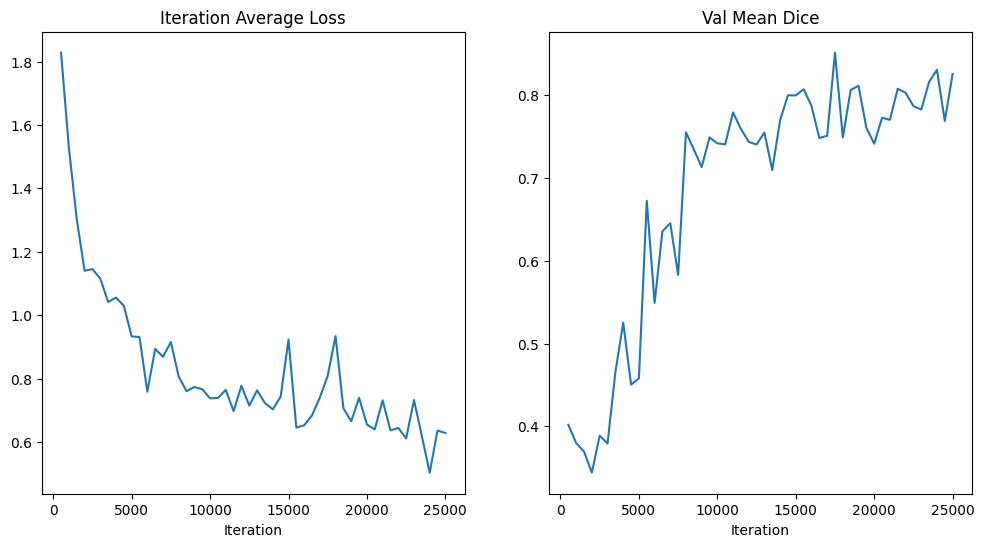

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
#Concat without ViT
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.76646): 100%|█| 24/24 [00:14<00:00,  1.64it/
Training (47 / 25000 Steps) (loss=2.63729): 100%|█| 24/24 [00:12<00:00,  1.94it/
Training (71 / 25000 Steps) (loss=2.56068): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (95 / 25000 Steps) (loss=2.47019): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (119 / 25000 Steps) (loss=2.39896): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (143 / 25000 Steps) (loss=2.35164): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (167 / 25000 Steps) (loss=2.33478): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (191 / 25000 Steps) (loss=2.23485): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (215 / 25000 Steps) (loss=2.12191): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (239 / 25000 Steps) (loss=2.09699): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (263 / 25000 Steps) (loss=2.10757): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (287 / 25000 Steps) (loss=2.11329): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4540305435657501 Current Avg. Dice: 0.4540305435657501


Training (503 / 25000 Steps) (loss=2.07121): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (527 / 25000 Steps) (loss=2.36996): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (551 / 25000 Steps) (loss=2.27001): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (575 / 25000 Steps) (loss=1.79905): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (599 / 25000 Steps) (loss=1.74482): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (623 / 25000 Steps) (loss=1.67795): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (647 / 25000 Steps) (loss=1.62898): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (671 / 25000 Steps) (loss=1.63663): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (695 / 25000 Steps) (loss=1.60226): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (719 / 25000 Steps) (loss=1.60288): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (743 / 25000 Steps) (loss=1.59093): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (767 / 25000 Steps) (loss=1.58252): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4916743338108063 Current Avg. Dice: 0.4916743338108063


Training (1007 / 25000 Steps) (loss=1.72607): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (1031 / 25000 Steps) (loss=1.37526): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1055 / 25000 Steps) (loss=1.43538): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1079 / 25000 Steps) (loss=1.33879): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1103 / 25000 Steps) (loss=1.44018): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1127 / 25000 Steps) (loss=1.31180): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1151 / 25000 Steps) (loss=1.42651): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1175 / 25000 Steps) (loss=1.35322): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1199 / 25000 Steps) (loss=1.47268): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1223 / 25000 Steps) (loss=1.51770): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1247 / 25000 Steps) (loss=1.55336): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1271 / 25000 Steps) (loss=1.31576): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4916743338108063 Current Avg. Dice: 0.380405992269516


Training (1511 / 25000 Steps) (loss=1.36185): 100%|█| 24/24 [00:13<00:00,  1.73i
Training (1535 / 25000 Steps) (loss=1.29993): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1559 / 25000 Steps) (loss=1.30137): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1583 / 25000 Steps) (loss=1.22186): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1607 / 25000 Steps) (loss=1.36448): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1631 / 25000 Steps) (loss=1.21846): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=1.47898): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1679 / 25000 Steps) (loss=1.33848): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1703 / 25000 Steps) (loss=1.25739): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1727 / 25000 Steps) (loss=1.23492): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1751 / 25000 Steps) (loss=1.21677): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1775 / 25000 Steps) (loss=1.12631): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4916743338108063 Current Avg. Dice: 0.4124698340892792


Training (2015 / 25000 Steps) (loss=1.66630): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2039 / 25000 Steps) (loss=1.08926): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2063 / 25000 Steps) (loss=1.10862): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2087 / 25000 Steps) (loss=1.16084): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2111 / 25000 Steps) (loss=1.29766): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2135 / 25000 Steps) (loss=1.29772): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2159 / 25000 Steps) (loss=1.10870): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2183 / 25000 Steps) (loss=1.39373): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2207 / 25000 Steps) (loss=1.26256): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2231 / 25000 Steps) (loss=1.07202): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2255 / 25000 Steps) (loss=1.04559): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2279 / 25000 Steps) (loss=1.23437): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4916743338108063 Current Avg. Dice: 0.44750428199768066


Training (2519 / 25000 Steps) (loss=1.14575): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2543 / 25000 Steps) (loss=1.05868): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2567 / 25000 Steps) (loss=1.17094): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2591 / 25000 Steps) (loss=1.04960): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2615 / 25000 Steps) (loss=1.17594): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2639 / 25000 Steps) (loss=1.16685): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2663 / 25000 Steps) (loss=1.03268): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2687 / 25000 Steps) (loss=1.18207): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2711 / 25000 Steps) (loss=1.09477): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2735 / 25000 Steps) (loss=1.29236): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2759 / 25000 Steps) (loss=1.45854): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2783 / 25000 Steps) (loss=1.01248): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.49948930740356445 Current Avg. Dice: 0.49948930740356445


Training (3023 / 25000 Steps) (loss=1.03191): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (3047 / 25000 Steps) (loss=1.08117): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3071 / 25000 Steps) (loss=0.99981): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3095 / 25000 Steps) (loss=1.03719): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3119 / 25000 Steps) (loss=1.49107): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3143 / 25000 Steps) (loss=1.16676): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3167 / 25000 Steps) (loss=1.11241): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3191 / 25000 Steps) (loss=1.15086): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3215 / 25000 Steps) (loss=1.05941): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3239 / 25000 Steps) (loss=1.06504): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3263 / 25000 Steps) (loss=1.02572): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3287 / 25000 Steps) (loss=1.06335): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5020620822906494 Current Avg. Dice: 0.5020620822906494


Training (3503 / 25000 Steps) (loss=1.00279): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (3527 / 25000 Steps) (loss=0.95989): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3551 / 25000 Steps) (loss=0.98755): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3575 / 25000 Steps) (loss=1.14889): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3599 / 25000 Steps) (loss=0.94947): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3623 / 25000 Steps) (loss=0.94128): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3647 / 25000 Steps) (loss=1.03509): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3671 / 25000 Steps) (loss=1.02107): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3695 / 25000 Steps) (loss=0.96443): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3719 / 25000 Steps) (loss=1.07783): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3743 / 25000 Steps) (loss=1.06100): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3767 / 25000 Steps) (loss=0.97270): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5020620822906494 Current Avg. Dice: 0.46375951170921326


Training (4007 / 25000 Steps) (loss=0.96306): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4031 / 25000 Steps) (loss=0.95093): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4055 / 25000 Steps) (loss=0.98926): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4079 / 25000 Steps) (loss=0.94239): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4103 / 25000 Steps) (loss=0.93123): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4127 / 25000 Steps) (loss=0.89149): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4151 / 25000 Steps) (loss=0.95768): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4175 / 25000 Steps) (loss=1.66135): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4199 / 25000 Steps) (loss=1.01990): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4223 / 25000 Steps) (loss=0.92131): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4247 / 25000 Steps) (loss=0.92149): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4271 / 25000 Steps) (loss=0.99581): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5020620822906494 Current Avg. Dice: 0.4531393051147461


Training (4511 / 25000 Steps) (loss=0.89344): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (4535 / 25000 Steps) (loss=1.01039): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4559 / 25000 Steps) (loss=0.92233): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4583 / 25000 Steps) (loss=0.95906): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4607 / 25000 Steps) (loss=0.91266): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4631 / 25000 Steps) (loss=0.92654): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4655 / 25000 Steps) (loss=0.95002): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4679 / 25000 Steps) (loss=1.01052): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4703 / 25000 Steps) (loss=0.89501): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4727 / 25000 Steps) (loss=0.87956): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4751 / 25000 Steps) (loss=0.83599): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4775 / 25000 Steps) (loss=1.07681): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5020620822906494 Current Avg. Dice: 0.4707973003387451


Training (5015 / 25000 Steps) (loss=1.04709): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5039 / 25000 Steps) (loss=0.95090): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5063 / 25000 Steps) (loss=0.94989): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5087 / 25000 Steps) (loss=1.00084): 100%|█| 24/24 [00:12<00:00,  1.92i
Training (5111 / 25000 Steps) (loss=1.10407): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5135 / 25000 Steps) (loss=0.91002): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5159 / 25000 Steps) (loss=0.99842): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5183 / 25000 Steps) (loss=0.83697): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5207 / 25000 Steps) (loss=0.84166): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5231 / 25000 Steps) (loss=0.85378): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5255 / 25000 Steps) (loss=1.07305): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5279 / 25000 Steps) (loss=1.02414): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5020620822906494 Current Avg. Dice: 0.5013741254806519


Training (5519 / 25000 Steps) (loss=0.88666): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (5543 / 25000 Steps) (loss=0.84635): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5567 / 25000 Steps) (loss=0.90880): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5591 / 25000 Steps) (loss=0.96278): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5615 / 25000 Steps) (loss=0.80069): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5639 / 25000 Steps) (loss=0.94347): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5663 / 25000 Steps) (loss=1.03107): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5687 / 25000 Steps) (loss=0.87506): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5711 / 25000 Steps) (loss=0.93878): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5735 / 25000 Steps) (loss=0.87658): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5759 / 25000 Steps) (loss=0.84016): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5783 / 25000 Steps) (loss=0.94756): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6193401217460632 Current Avg. Dice: 0.6193401217460632


Training (6023 / 25000 Steps) (loss=0.83651): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (6047 / 25000 Steps) (loss=1.00570): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6071 / 25000 Steps) (loss=0.89366): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6095 / 25000 Steps) (loss=0.84323): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6119 / 25000 Steps) (loss=0.81007): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6143 / 25000 Steps) (loss=0.81404): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6167 / 25000 Steps) (loss=0.97694): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6191 / 25000 Steps) (loss=0.85831): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6215 / 25000 Steps) (loss=0.83929): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6239 / 25000 Steps) (loss=0.75393): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6263 / 25000 Steps) (loss=0.84306): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6287 / 25000 Steps) (loss=0.92659): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6193401217460632 Current Avg. Dice: 0.6093432903289795


Training (6503 / 25000 Steps) (loss=0.83250): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (6527 / 25000 Steps) (loss=0.80257): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6551 / 25000 Steps) (loss=0.76855): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6575 / 25000 Steps) (loss=0.71654): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6599 / 25000 Steps) (loss=0.85180): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6623 / 25000 Steps) (loss=0.87404): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6647 / 25000 Steps) (loss=1.02495): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6671 / 25000 Steps) (loss=0.94847): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6695 / 25000 Steps) (loss=0.81161): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6719 / 25000 Steps) (loss=0.77549): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6743 / 25000 Steps) (loss=0.81928): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6767 / 25000 Steps) (loss=0.86920): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6235024929046631 Current Avg. Dice: 0.6235024929046631


Training (7007 / 25000 Steps) (loss=0.73500): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (7031 / 25000 Steps) (loss=0.86161): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7055 / 25000 Steps) (loss=0.82049): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7079 / 25000 Steps) (loss=0.78270): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7103 / 25000 Steps) (loss=0.86906): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7127 / 25000 Steps) (loss=0.79275): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7151 / 25000 Steps) (loss=0.90027): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7175 / 25000 Steps) (loss=0.68904): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7199 / 25000 Steps) (loss=0.83552): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7223 / 25000 Steps) (loss=0.81755): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7247 / 25000 Steps) (loss=0.79324): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7271 / 25000 Steps) (loss=0.83847): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6792631149291992 Current Avg. Dice: 0.6792631149291992


Training (7511 / 25000 Steps) (loss=0.67535): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (7535 / 25000 Steps) (loss=0.73913): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7559 / 25000 Steps) (loss=0.78252): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7583 / 25000 Steps) (loss=0.74949): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7607 / 25000 Steps) (loss=0.72027): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7631 / 25000 Steps) (loss=0.70929): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7655 / 25000 Steps) (loss=0.83784): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7679 / 25000 Steps) (loss=0.77694): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7703 / 25000 Steps) (loss=0.71261): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7727 / 25000 Steps) (loss=0.86340): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7751 / 25000 Steps) (loss=0.61990): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7775 / 25000 Steps) (loss=0.63364): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6792631149291992 Current Avg. Dice: 0.6430314183235168


Training (8015 / 25000 Steps) (loss=0.93943): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8039 / 25000 Steps) (loss=0.68783): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8063 / 25000 Steps) (loss=0.77619): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8087 / 25000 Steps) (loss=0.84558): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8111 / 25000 Steps) (loss=0.78530): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8135 / 25000 Steps) (loss=0.72635): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8159 / 25000 Steps) (loss=0.59422): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8183 / 25000 Steps) (loss=0.83876): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8207 / 25000 Steps) (loss=0.81602): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8231 / 25000 Steps) (loss=0.64980): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8255 / 25000 Steps) (loss=0.76379): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8279 / 25000 Steps) (loss=0.59828): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6792631149291992 Current Avg. Dice: 0.6031365990638733


Training (8519 / 25000 Steps) (loss=0.76401): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8543 / 25000 Steps) (loss=0.64504): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8567 / 25000 Steps) (loss=0.55484): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8591 / 25000 Steps) (loss=0.89180): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8615 / 25000 Steps) (loss=0.78781): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8639 / 25000 Steps) (loss=0.72661): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8663 / 25000 Steps) (loss=0.79195): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8687 / 25000 Steps) (loss=0.73672): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8711 / 25000 Steps) (loss=0.71806): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8735 / 25000 Steps) (loss=0.81160): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8759 / 25000 Steps) (loss=0.87024): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8783 / 25000 Steps) (loss=0.75833): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.709704577922821 Current Avg. Dice: 0.709704577922821


Training (9023 / 25000 Steps) (loss=0.58731): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (9047 / 25000 Steps) (loss=0.59991): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9071 / 25000 Steps) (loss=0.75614): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9095 / 25000 Steps) (loss=0.82797): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9119 / 25000 Steps) (loss=0.59258): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9143 / 25000 Steps) (loss=0.68362): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9167 / 25000 Steps) (loss=0.77208): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9191 / 25000 Steps) (loss=0.93467): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9215 / 25000 Steps) (loss=0.84391): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9239 / 25000 Steps) (loss=0.79077): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9263 / 25000 Steps) (loss=0.48054): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9287 / 25000 Steps) (loss=0.67673): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7191033363342285 Current Avg. Dice: 0.7191033363342285


Training (9503 / 25000 Steps) (loss=0.79741): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (9527 / 25000 Steps) (loss=0.81205): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9551 / 25000 Steps) (loss=0.57019): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9575 / 25000 Steps) (loss=0.87956): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9599 / 25000 Steps) (loss=0.73338): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9623 / 25000 Steps) (loss=0.76825): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9647 / 25000 Steps) (loss=0.80243): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9671 / 25000 Steps) (loss=0.76404): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9695 / 25000 Steps) (loss=0.85131): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9719 / 25000 Steps) (loss=0.54072): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9743 / 25000 Steps) (loss=0.93695): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9767 / 25000 Steps) (loss=0.87334): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7508031725883484


Training (10007 / 25000 Steps) (loss=0.95256): 100%|█| 24/24 [00:17<00:00,  1.41
Training (10031 / 25000 Steps) (loss=0.80780): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10055 / 25000 Steps) (loss=0.71504): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10079 / 25000 Steps) (loss=0.76452): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10103 / 25000 Steps) (loss=0.82944): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10127 / 25000 Steps) (loss=0.65729): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10151 / 25000 Steps) (loss=0.85375): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10175 / 25000 Steps) (loss=0.74480): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10199 / 25000 Steps) (loss=0.75805): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10223 / 25000 Steps) (loss=0.90597): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10247 / 25000 Steps) (loss=0.64664): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10271 / 25000 Steps) (loss=0.63667): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7252471446990967


Training (10511 / 25000 Steps) (loss=0.64358): 100%|█| 24/24 [00:13<00:00,  1.79
Training (10535 / 25000 Steps) (loss=0.77406): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10559 / 25000 Steps) (loss=0.76519): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10583 / 25000 Steps) (loss=0.82282): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10607 / 25000 Steps) (loss=0.56092): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10631 / 25000 Steps) (loss=0.63927): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10655 / 25000 Steps) (loss=0.63372): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10679 / 25000 Steps) (loss=0.80788): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10703 / 25000 Steps) (loss=0.78245): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10727 / 25000 Steps) (loss=0.68478): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10751 / 25000 Steps) (loss=0.64015): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10775 / 25000 Steps) (loss=0.83318): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.6771947741508484


Training (11015 / 25000 Steps) (loss=1.42397): 100%|█| 24/24 [00:13<00:00,  1.78
Training (11039 / 25000 Steps) (loss=0.57404): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11063 / 25000 Steps) (loss=1.01532): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11087 / 25000 Steps) (loss=0.95257): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11111 / 25000 Steps) (loss=0.81185): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11135 / 25000 Steps) (loss=0.71574): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11159 / 25000 Steps) (loss=0.87685): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11183 / 25000 Steps) (loss=0.61075): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11207 / 25000 Steps) (loss=0.88130): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11231 / 25000 Steps) (loss=0.59027): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11255 / 25000 Steps) (loss=0.73145): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11279 / 25000 Steps) (loss=0.70076): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7369170784950256


Training (11519 / 25000 Steps) (loss=0.56052): 100%|█| 24/24 [00:13<00:00,  1.78
Training (11543 / 25000 Steps) (loss=0.66658): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11567 / 25000 Steps) (loss=0.84720): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11591 / 25000 Steps) (loss=0.73061): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11615 / 25000 Steps) (loss=0.86527): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11639 / 25000 Steps) (loss=0.66747): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11663 / 25000 Steps) (loss=0.57970): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11687 / 25000 Steps) (loss=0.69409): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11711 / 25000 Steps) (loss=0.69771): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11735 / 25000 Steps) (loss=0.64222): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11759 / 25000 Steps) (loss=0.60538): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11783 / 25000 Steps) (loss=0.83954): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.6630522012710571


Training (12023 / 25000 Steps) (loss=0.75519): 100%|█| 24/24 [00:13<00:00,  1.79
Training (12047 / 25000 Steps) (loss=0.63515): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12071 / 25000 Steps) (loss=0.74805): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12095 / 25000 Steps) (loss=0.50925): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12119 / 25000 Steps) (loss=0.64052): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12143 / 25000 Steps) (loss=0.63157): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12167 / 25000 Steps) (loss=0.61691): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12191 / 25000 Steps) (loss=0.59489): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12215 / 25000 Steps) (loss=0.62939): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12239 / 25000 Steps) (loss=0.66379): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12263 / 25000 Steps) (loss=0.72481): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12287 / 25000 Steps) (loss=0.77311): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.6871479153633118


Training (12503 / 25000 Steps) (loss=0.76918): 100%|█| 24/24 [00:13<00:00,  1.78
Training (12527 / 25000 Steps) (loss=0.76408): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12551 / 25000 Steps) (loss=0.68907): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12575 / 25000 Steps) (loss=0.61799): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12599 / 25000 Steps) (loss=0.62699): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12623 / 25000 Steps) (loss=0.76429): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12647 / 25000 Steps) (loss=0.51974): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12671 / 25000 Steps) (loss=0.94362): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12695 / 25000 Steps) (loss=0.91307): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12719 / 25000 Steps) (loss=0.66712): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12743 / 25000 Steps) (loss=0.58264): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12767 / 25000 Steps) (loss=0.74068): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7139331698417664


Training (13007 / 25000 Steps) (loss=0.71823): 100%|█| 24/24 [00:13<00:00,  1.78
Training (13031 / 25000 Steps) (loss=0.61004): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13055 / 25000 Steps) (loss=0.86121): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13079 / 25000 Steps) (loss=0.46763): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13103 / 25000 Steps) (loss=0.58184): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13127 / 25000 Steps) (loss=0.64848): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13151 / 25000 Steps) (loss=0.59478): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13175 / 25000 Steps) (loss=0.54737): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13199 / 25000 Steps) (loss=0.96135): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13223 / 25000 Steps) (loss=0.72956): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13247 / 25000 Steps) (loss=0.63575): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13271 / 25000 Steps) (loss=0.71247): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7497784495353699


Training (13511 / 25000 Steps) (loss=0.51282): 100%|█| 24/24 [00:13<00:00,  1.78
Training (13535 / 25000 Steps) (loss=0.69346): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13559 / 25000 Steps) (loss=0.46356): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13583 / 25000 Steps) (loss=0.72823): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13607 / 25000 Steps) (loss=0.85295): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13631 / 25000 Steps) (loss=0.78284): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13655 / 25000 Steps) (loss=0.53468): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13679 / 25000 Steps) (loss=0.65507): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13703 / 25000 Steps) (loss=0.54285): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13727 / 25000 Steps) (loss=0.67357): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13751 / 25000 Steps) (loss=0.78353): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13775 / 25000 Steps) (loss=0.63032): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.6779496073722839


Training (14015 / 25000 Steps) (loss=0.64082): 100%|█| 24/24 [00:13<00:00,  1.78
Training (14039 / 25000 Steps) (loss=0.72783): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14063 / 25000 Steps) (loss=0.62898): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14087 / 25000 Steps) (loss=0.53643): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14111 / 25000 Steps) (loss=0.80162): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14135 / 25000 Steps) (loss=0.61577): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14159 / 25000 Steps) (loss=0.85504): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14183 / 25000 Steps) (loss=0.70530): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14207 / 25000 Steps) (loss=0.75638): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14231 / 25000 Steps) (loss=0.61083): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14255 / 25000 Steps) (loss=0.73165): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14279 / 25000 Steps) (loss=0.71392): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7394503951072693


Training (14519 / 25000 Steps) (loss=0.70506): 100%|█| 24/24 [00:13<00:00,  1.78
Training (14543 / 25000 Steps) (loss=0.49985): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14567 / 25000 Steps) (loss=0.75418): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14591 / 25000 Steps) (loss=0.63059): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14615 / 25000 Steps) (loss=0.71244): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14639 / 25000 Steps) (loss=0.84848): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14663 / 25000 Steps) (loss=0.70655): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14687 / 25000 Steps) (loss=0.65998): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14711 / 25000 Steps) (loss=0.85322): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14735 / 25000 Steps) (loss=0.57328): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14759 / 25000 Steps) (loss=0.67056): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14783 / 25000 Steps) (loss=0.69293): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508031725883484 Current Avg. Dice: 0.7120115160942078


Training (15023 / 25000 Steps) (loss=0.61963): 100%|█| 24/24 [00:13<00:00,  1.78
Training (15047 / 25000 Steps) (loss=0.60432): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15071 / 25000 Steps) (loss=0.69845): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15095 / 25000 Steps) (loss=0.57062): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15119 / 25000 Steps) (loss=0.66083): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15143 / 25000 Steps) (loss=0.68710): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15167 / 25000 Steps) (loss=0.76204): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15191 / 25000 Steps) (loss=0.83965): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15215 / 25000 Steps) (loss=0.60769): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15239 / 25000 Steps) (loss=0.60031): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15263 / 25000 Steps) (loss=0.67718): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15287 / 25000 Steps) (loss=0.66254): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7587758898735046


Training (15503 / 25000 Steps) (loss=0.70901): 100%|█| 24/24 [00:16<00:00,  1.42
Training (15527 / 25000 Steps) (loss=0.75368): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15551 / 25000 Steps) (loss=0.67185): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15575 / 25000 Steps) (loss=0.66624): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15599 / 25000 Steps) (loss=0.78889): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15623 / 25000 Steps) (loss=0.44706): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15647 / 25000 Steps) (loss=0.54739): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15671 / 25000 Steps) (loss=0.87874): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15695 / 25000 Steps) (loss=0.79411): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15719 / 25000 Steps) (loss=0.65091): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15743 / 25000 Steps) (loss=0.77671): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15767 / 25000 Steps) (loss=0.70994): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7563961148262024


Training (16007 / 25000 Steps) (loss=0.77117): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16031 / 25000 Steps) (loss=0.53648): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16055 / 25000 Steps) (loss=0.80832): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16079 / 25000 Steps) (loss=0.67153): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16103 / 25000 Steps) (loss=0.62139): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16127 / 25000 Steps) (loss=0.65007): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16151 / 25000 Steps) (loss=0.84694): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16175 / 25000 Steps) (loss=0.51564): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16199 / 25000 Steps) (loss=0.83201): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16223 / 25000 Steps) (loss=0.61866): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16247 / 25000 Steps) (loss=0.47470): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16271 / 25000 Steps) (loss=0.74670): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7229147553443909


Training (16511 / 25000 Steps) (loss=0.63793): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.60514): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16559 / 25000 Steps) (loss=0.94256): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16583 / 25000 Steps) (loss=0.82712): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16607 / 25000 Steps) (loss=0.69233): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16631 / 25000 Steps) (loss=0.59422): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16655 / 25000 Steps) (loss=0.55085): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16679 / 25000 Steps) (loss=0.50221): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16703 / 25000 Steps) (loss=0.51769): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16727 / 25000 Steps) (loss=0.74948): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16751 / 25000 Steps) (loss=0.64510): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16775 / 25000 Steps) (loss=0.74204): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7397913932800293


Training (17015 / 25000 Steps) (loss=0.61755): 100%|█| 24/24 [00:13<00:00,  1.78
Training (17039 / 25000 Steps) (loss=0.44655): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17063 / 25000 Steps) (loss=0.48845): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17087 / 25000 Steps) (loss=0.64497): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17111 / 25000 Steps) (loss=0.63196): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17135 / 25000 Steps) (loss=0.60450): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17159 / 25000 Steps) (loss=0.69016): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17183 / 25000 Steps) (loss=0.53470): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17207 / 25000 Steps) (loss=0.75942): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17231 / 25000 Steps) (loss=0.48975): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17255 / 25000 Steps) (loss=0.60577): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17279 / 25000 Steps) (loss=0.61873): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7138419151306152


Training (17519 / 25000 Steps) (loss=0.45748): 100%|█| 24/24 [00:13<00:00,  1.78
Training (17543 / 25000 Steps) (loss=0.60522): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17567 / 25000 Steps) (loss=0.68479): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17591 / 25000 Steps) (loss=0.62709): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17615 / 25000 Steps) (loss=0.85545): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17639 / 25000 Steps) (loss=0.44119): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17663 / 25000 Steps) (loss=0.56346): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17687 / 25000 Steps) (loss=0.67075): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17711 / 25000 Steps) (loss=0.64504): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17735 / 25000 Steps) (loss=0.78217): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17759 / 25000 Steps) (loss=0.61227): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17783 / 25000 Steps) (loss=0.72202): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.6783528327941895


Training (18023 / 25000 Steps) (loss=0.77784): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18047 / 25000 Steps) (loss=0.53903): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18071 / 25000 Steps) (loss=0.50448): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18095 / 25000 Steps) (loss=0.61336): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18119 / 25000 Steps) (loss=0.65780): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18143 / 25000 Steps) (loss=0.45909): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18167 / 25000 Steps) (loss=0.86964): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18191 / 25000 Steps) (loss=0.76971): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18215 / 25000 Steps) (loss=0.55575): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18239 / 25000 Steps) (loss=0.64147): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18263 / 25000 Steps) (loss=0.70430): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18287 / 25000 Steps) (loss=0.63488): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.6539802551269531


Training (18503 / 25000 Steps) (loss=0.68915): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18527 / 25000 Steps) (loss=0.49600): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18551 / 25000 Steps) (loss=0.67197): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18575 / 25000 Steps) (loss=0.59812): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18599 / 25000 Steps) (loss=0.66271): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18623 / 25000 Steps) (loss=0.52133): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18647 / 25000 Steps) (loss=0.37956): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18671 / 25000 Steps) (loss=0.77629): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18695 / 25000 Steps) (loss=0.72607): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18719 / 25000 Steps) (loss=0.78915): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18743 / 25000 Steps) (loss=0.70463): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18767 / 25000 Steps) (loss=0.56145): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7559859156608582


Training (19007 / 25000 Steps) (loss=0.66555): 100%|█| 24/24 [00:13<00:00,  1.78
Training (19031 / 25000 Steps) (loss=0.62087): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19055 / 25000 Steps) (loss=0.71632): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19079 / 25000 Steps) (loss=0.69730): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19103 / 25000 Steps) (loss=0.72135): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19127 / 25000 Steps) (loss=0.41691): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19151 / 25000 Steps) (loss=0.60352): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19175 / 25000 Steps) (loss=0.61966): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19199 / 25000 Steps) (loss=0.58134): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19223 / 25000 Steps) (loss=0.53189): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19247 / 25000 Steps) (loss=0.66282): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19271 / 25000 Steps) (loss=0.79152): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7587758898735046 Current Avg. Dice: 0.7528097629547119


Training (19511 / 25000 Steps) (loss=0.85233): 100%|█| 24/24 [00:13<00:00,  1.79
Training (19535 / 25000 Steps) (loss=0.67667): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19559 / 25000 Steps) (loss=0.38486): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19583 / 25000 Steps) (loss=0.52607): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19607 / 25000 Steps) (loss=0.72042): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19631 / 25000 Steps) (loss=0.56538): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19655 / 25000 Steps) (loss=0.75496): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19679 / 25000 Steps) (loss=0.79563): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19703 / 25000 Steps) (loss=0.71395): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19727 / 25000 Steps) (loss=0.55097): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19751 / 25000 Steps) (loss=0.57226): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19775 / 25000 Steps) (loss=0.60776): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7699467539787292 Current Avg. Dice: 0.7699467539787292


Training (20015 / 25000 Steps) (loss=0.70699): 100%|█| 24/24 [00:16<00:00,  1.41
Training (20039 / 25000 Steps) (loss=0.78624): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20063 / 25000 Steps) (loss=0.44434): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20087 / 25000 Steps) (loss=0.67204): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20111 / 25000 Steps) (loss=0.51721): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20135 / 25000 Steps) (loss=0.53619): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20159 / 25000 Steps) (loss=0.66360): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20183 / 25000 Steps) (loss=0.77227): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20207 / 25000 Steps) (loss=0.54054): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20231 / 25000 Steps) (loss=0.75157): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20255 / 25000 Steps) (loss=0.53313): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20279 / 25000 Steps) (loss=0.53574): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7699467539787292 Current Avg. Dice: 0.7361934781074524


Training (20519 / 25000 Steps) (loss=0.56099): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20543 / 25000 Steps) (loss=0.39962): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20567 / 25000 Steps) (loss=0.46657): 100%|█| 24/24 [00:12<00:00,  1.94
Training (20591 / 25000 Steps) (loss=0.54852): 100%|█| 24/24 [00:12<00:00,  1.94
Training (20615 / 25000 Steps) (loss=0.69373): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20639 / 25000 Steps) (loss=0.49693): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20663 / 25000 Steps) (loss=0.69829): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20687 / 25000 Steps) (loss=0.81977): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20711 / 25000 Steps) (loss=0.85237): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20735 / 25000 Steps) (loss=0.73123): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20759 / 25000 Steps) (loss=0.49764): 100%|█| 24/24 [00:12<00:00,  1.94
Training (20783 / 25000 Steps) (loss=0.60475): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7699467539787292 Current Avg. Dice: 0.7359345555305481


Training (21023 / 25000 Steps) (loss=0.76242): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21047 / 25000 Steps) (loss=0.74557): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21071 / 25000 Steps) (loss=0.57721): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21095 / 25000 Steps) (loss=0.46818): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21119 / 25000 Steps) (loss=0.66087): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21143 / 25000 Steps) (loss=0.61687): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21167 / 25000 Steps) (loss=0.64120): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21191 / 25000 Steps) (loss=0.81091): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21215 / 25000 Steps) (loss=0.58762): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21239 / 25000 Steps) (loss=0.75202): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21263 / 25000 Steps) (loss=0.67137): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21287 / 25000 Steps) (loss=0.45036): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7699467539787292 Current Avg. Dice: 0.7400066256523132


Training (21503 / 25000 Steps) (loss=0.66110): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21527 / 25000 Steps) (loss=0.79005): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21551 / 25000 Steps) (loss=0.63686): 100%|█| 24/24 [00:12<00:00,  1.92
Training (21575 / 25000 Steps) (loss=0.60748): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21599 / 25000 Steps) (loss=0.50322): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21623 / 25000 Steps) (loss=0.67018): 100%|█| 24/24 [00:12<00:00,  1.95
Training (21647 / 25000 Steps) (loss=0.59511): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21671 / 25000 Steps) (loss=0.49477): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21695 / 25000 Steps) (loss=0.55748): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21719 / 25000 Steps) (loss=0.72884): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21743 / 25000 Steps) (loss=0.74181): 100%|█| 24/24 [00:12<00:00,  1.92
Training (21767 / 25000 Steps) (loss=0.61451): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7699467539787292 Current Avg. Dice: 0.728915274143219


Training (22007 / 25000 Steps) (loss=0.49007): 100%|█| 24/24 [00:13<00:00,  1.75
Training (22031 / 25000 Steps) (loss=0.62677): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22055 / 25000 Steps) (loss=0.61145): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22079 / 25000 Steps) (loss=0.72131): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22103 / 25000 Steps) (loss=0.73669): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22127 / 25000 Steps) (loss=0.68977): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22151 / 25000 Steps) (loss=0.55271): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22175 / 25000 Steps) (loss=0.58575): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22199 / 25000 Steps) (loss=0.82633): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22223 / 25000 Steps) (loss=0.72757): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22247 / 25000 Steps) (loss=0.73326): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22271 / 25000 Steps) (loss=0.58132): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.814694881439209 Current Avg. Dice: 0.814694881439209


Training (22511 / 25000 Steps) (loss=0.43837): 100%|█| 24/24 [00:17<00:00,  1.38
Training (22535 / 25000 Steps) (loss=0.53145): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22559 / 25000 Steps) (loss=0.57291): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22583 / 25000 Steps) (loss=0.41597): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22607 / 25000 Steps) (loss=0.41372): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22631 / 25000 Steps) (loss=0.42036): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22655 / 25000 Steps) (loss=0.50139): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22679 / 25000 Steps) (loss=0.56202): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22703 / 25000 Steps) (loss=0.60892): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22727 / 25000 Steps) (loss=0.52072): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22751 / 25000 Steps) (loss=0.54890): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22775 / 25000 Steps) (loss=0.63622): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.814694881439209 Current Avg. Dice: 0.7159382700920105


Training (23015 / 25000 Steps) (loss=0.74412): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23039 / 25000 Steps) (loss=0.50880): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23063 / 25000 Steps) (loss=0.69643): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23087 / 25000 Steps) (loss=0.45357): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23111 / 25000 Steps) (loss=0.55219): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23135 / 25000 Steps) (loss=0.80759): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23159 / 25000 Steps) (loss=0.55784): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23183 / 25000 Steps) (loss=0.72733): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23207 / 25000 Steps) (loss=0.72875): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23231 / 25000 Steps) (loss=0.70318): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23255 / 25000 Steps) (loss=0.68017): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23279 / 25000 Steps) (loss=0.46707): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.814694881439209 Current Avg. Dice: 0.7594826817512512


Training (23519 / 25000 Steps) (loss=0.75103): 100%|█| 24/24 [00:13<00:00,  1.74
Training (23543 / 25000 Steps) (loss=0.76207): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23567 / 25000 Steps) (loss=0.71855): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23591 / 25000 Steps) (loss=0.67997): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23615 / 25000 Steps) (loss=0.85912): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23639 / 25000 Steps) (loss=0.61362): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23663 / 25000 Steps) (loss=0.60317): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23687 / 25000 Steps) (loss=0.63790): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23711 / 25000 Steps) (loss=0.69761): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23735 / 25000 Steps) (loss=0.37720): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23759 / 25000 Steps) (loss=0.73272): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23783 / 25000 Steps) (loss=0.45652): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.814694881439209 Current Avg. Dice: 0.7380852103233337


Training (24023 / 25000 Steps) (loss=0.76578): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24047 / 25000 Steps) (loss=0.68708): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24071 / 25000 Steps) (loss=0.58061): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24095 / 25000 Steps) (loss=0.47646): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24119 / 25000 Steps) (loss=0.76494): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24143 / 25000 Steps) (loss=0.51456): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24167 / 25000 Steps) (loss=0.53448): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24191 / 25000 Steps) (loss=0.44574): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24215 / 25000 Steps) (loss=0.72582): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24239 / 25000 Steps) (loss=0.70642): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24263 / 25000 Steps) (loss=0.36767): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24287 / 25000 Steps) (loss=0.66943): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.814694881439209 Current Avg. Dice: 0.6956930160522461


Training (24503 / 25000 Steps) (loss=0.73593): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24527 / 25000 Steps) (loss=0.59176): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24551 / 25000 Steps) (loss=0.67341): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24575 / 25000 Steps) (loss=0.78971): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24599 / 25000 Steps) (loss=0.41898): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24623 / 25000 Steps) (loss=0.60672): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24647 / 25000 Steps) (loss=0.68150): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24671 / 25000 Steps) (loss=0.66543): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24695 / 25000 Steps) (loss=0.53677): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24719 / 25000 Steps) (loss=0.55841): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24743 / 25000 Steps) (loss=0.74292): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24767 / 25000 Steps) (loss=0.51084): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.814694881439209 Current Avg. Dice: 0.6756777763366699


Training (25007 / 25000 Steps) (loss=0.40981): 100%|█| 24/24 [00:13<00:00,  1.79


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8147 at iteration: 22500


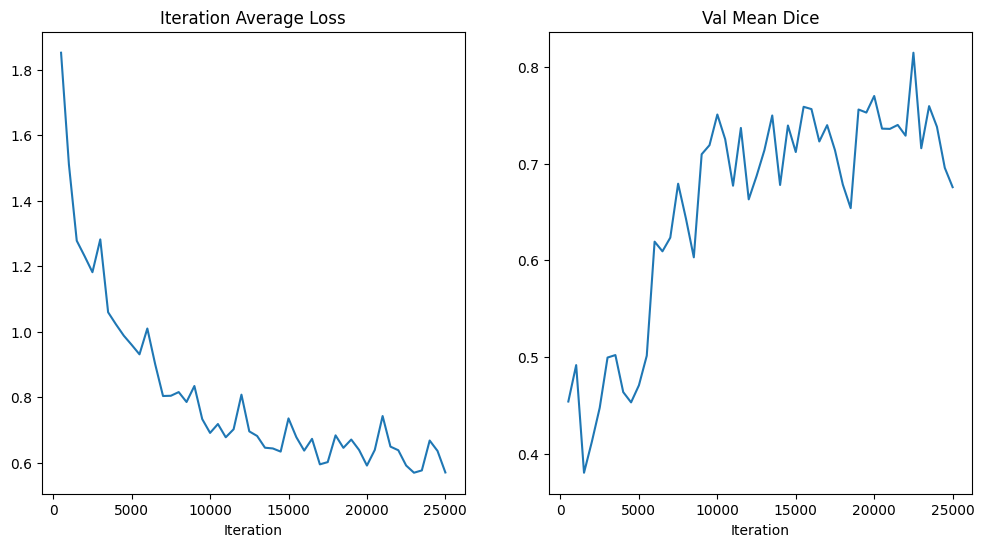

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.64805): 100%|█| 24/24 [00:13<00:00,  1.74it/
Training (47 / 25000 Steps) (loss=2.56115): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (71 / 25000 Steps) (loss=2.57353): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (95 / 25000 Steps) (loss=2.41322): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (119 / 25000 Steps) (loss=2.36705): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (143 / 25000 Steps) (loss=2.34878): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (167 / 25000 Steps) (loss=2.39149): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (191 / 25000 Steps) (loss=2.23889): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (215 / 25000 Steps) (loss=2.19163): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (239 / 25000 Steps) (loss=2.13033): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (263 / 25000 Steps) (loss=2.21176): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (287 / 25000 Steps) (loss=2.22587): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3357826769351959 Current Avg. Dice: 0.3357826769351959


Training (503 / 25000 Steps) (loss=1.92790): 100%|█| 24/24 [00:16<00:00,  1.49it
Training (527 / 25000 Steps) (loss=1.90694): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (551 / 25000 Steps) (loss=1.82772): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (575 / 25000 Steps) (loss=1.92275): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (599 / 25000 Steps) (loss=2.02977): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (623 / 25000 Steps) (loss=1.76015): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (647 / 25000 Steps) (loss=1.80949): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (671 / 25000 Steps) (loss=1.81147): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (695 / 25000 Steps) (loss=1.70204): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (719 / 25000 Steps) (loss=1.57658): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (743 / 25000 Steps) (loss=1.79274): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (767 / 25000 Steps) (loss=1.74498): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.3357826769351959 Current Avg. Dice: 0.3268478214740753


Training (1007 / 25000 Steps) (loss=1.56633): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (1031 / 25000 Steps) (loss=1.52605): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1055 / 25000 Steps) (loss=1.76549): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1079 / 25000 Steps) (loss=1.40680): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1103 / 25000 Steps) (loss=1.34871): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1127 / 25000 Steps) (loss=1.35675): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1151 / 25000 Steps) (loss=1.35355): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1175 / 25000 Steps) (loss=1.43228): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1199 / 25000 Steps) (loss=1.39585): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1223 / 25000 Steps) (loss=1.33050): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1247 / 25000 Steps) (loss=1.37205): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1271 / 25000 Steps) (loss=1.47077): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.33945727348327637 Current Avg. Dice: 0.33945727348327637


Training (1511 / 25000 Steps) (loss=1.28961): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (1535 / 25000 Steps) (loss=1.39890): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1559 / 25000 Steps) (loss=1.30315): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1583 / 25000 Steps) (loss=1.15651): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1607 / 25000 Steps) (loss=1.15434): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1631 / 25000 Steps) (loss=1.16764): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1655 / 25000 Steps) (loss=1.22224): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1679 / 25000 Steps) (loss=1.29597): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1703 / 25000 Steps) (loss=1.51732): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1727 / 25000 Steps) (loss=1.30403): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1751 / 25000 Steps) (loss=1.19745): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (1775 / 25000 Steps) (loss=2.08924): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.35642877221107483 Current Avg. Dice: 0.35642877221107483


Training (2015 / 25000 Steps) (loss=1.26320): 100%|█| 24/24 [00:16<00:00,  1.46i
Training (2039 / 25000 Steps) (loss=1.24516): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2063 / 25000 Steps) (loss=1.24927): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2087 / 25000 Steps) (loss=1.42141): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2111 / 25000 Steps) (loss=1.25166): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2135 / 25000 Steps) (loss=1.07129): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2159 / 25000 Steps) (loss=1.23327): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2183 / 25000 Steps) (loss=1.34258): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2207 / 25000 Steps) (loss=1.55049): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2231 / 25000 Steps) (loss=1.09812): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2255 / 25000 Steps) (loss=1.12136): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (2279 / 25000 Steps) (loss=1.89034): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.35642877221107483 Current Avg. Dice: 0.35551130771636963


Training (2519 / 25000 Steps) (loss=1.07450): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (2543 / 25000 Steps) (loss=1.09695): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2567 / 25000 Steps) (loss=1.18128): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2591 / 25000 Steps) (loss=1.11075): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2615 / 25000 Steps) (loss=1.04645): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (2639 / 25000 Steps) (loss=1.06177): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2663 / 25000 Steps) (loss=1.18186): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2687 / 25000 Steps) (loss=1.11079): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2711 / 25000 Steps) (loss=1.12103): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2735 / 25000 Steps) (loss=1.04631): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2759 / 25000 Steps) (loss=1.07472): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (2783 / 25000 Steps) (loss=1.09861): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.36765387654304504 Current Avg. Dice: 0.36765387654304504


Training (3023 / 25000 Steps) (loss=1.06427): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (3047 / 25000 Steps) (loss=1.11991): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3071 / 25000 Steps) (loss=1.19425): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3095 / 25000 Steps) (loss=1.04460): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3119 / 25000 Steps) (loss=1.03764): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3143 / 25000 Steps) (loss=1.02538): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3167 / 25000 Steps) (loss=1.04677): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3191 / 25000 Steps) (loss=0.98270): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3215 / 25000 Steps) (loss=1.37955): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3239 / 25000 Steps) (loss=1.05031): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3263 / 25000 Steps) (loss=1.00815): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3287 / 25000 Steps) (loss=1.05406): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4788249433040619 Current Avg. Dice: 0.4788249433040619


Training (3503 / 25000 Steps) (loss=1.26884): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (3527 / 25000 Steps) (loss=1.10463): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3551 / 25000 Steps) (loss=1.03661): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3575 / 25000 Steps) (loss=1.02844): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3599 / 25000 Steps) (loss=1.12282): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3623 / 25000 Steps) (loss=1.09201): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3647 / 25000 Steps) (loss=1.03202): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3671 / 25000 Steps) (loss=1.04259): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3695 / 25000 Steps) (loss=1.03142): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (3719 / 25000 Steps) (loss=1.00721): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (3743 / 25000 Steps) (loss=1.17603): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (3767 / 25000 Steps) (loss=1.58134): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5580527782440186 Current Avg. Dice: 0.5580527782440186


Training (4007 / 25000 Steps) (loss=0.94298): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (4031 / 25000 Steps) (loss=1.07348): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4055 / 25000 Steps) (loss=1.09908): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4079 / 25000 Steps) (loss=1.01142): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4103 / 25000 Steps) (loss=1.41599): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4127 / 25000 Steps) (loss=1.08250): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4151 / 25000 Steps) (loss=1.15144): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4175 / 25000 Steps) (loss=1.02810): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4199 / 25000 Steps) (loss=0.94951): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4223 / 25000 Steps) (loss=0.91210): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4247 / 25000 Steps) (loss=1.00200): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4271 / 25000 Steps) (loss=1.07105): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5580527782440186 Current Avg. Dice: 0.504821240901947


Training (4511 / 25000 Steps) (loss=0.91894): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (4535 / 25000 Steps) (loss=0.90067): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4559 / 25000 Steps) (loss=0.99054): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4583 / 25000 Steps) (loss=0.98546): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4607 / 25000 Steps) (loss=0.94783): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4631 / 25000 Steps) (loss=0.93171): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4655 / 25000 Steps) (loss=1.03233): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4679 / 25000 Steps) (loss=1.01382): 100%|█| 24/24 [00:11<00:00,  2.05i
Training (4703 / 25000 Steps) (loss=0.87696): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (4727 / 25000 Steps) (loss=0.85564): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4751 / 25000 Steps) (loss=1.04681): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (4775 / 25000 Steps) (loss=0.99934): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5580527782440186 Current Avg. Dice: 0.5128632187843323


Training (5015 / 25000 Steps) (loss=0.98138): 100%|█| 24/24 [00:13<00:00,  1.83i
Training (5039 / 25000 Steps) (loss=1.17303): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5063 / 25000 Steps) (loss=0.97481): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5087 / 25000 Steps) (loss=0.96648): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5111 / 25000 Steps) (loss=0.96470): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5135 / 25000 Steps) (loss=0.93630): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (5159 / 25000 Steps) (loss=0.90551): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5183 / 25000 Steps) (loss=0.92076): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5207 / 25000 Steps) (loss=0.92831): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5231 / 25000 Steps) (loss=0.91082): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5255 / 25000 Steps) (loss=1.01010): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5279 / 25000 Steps) (loss=0.93873): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5580527782440186 Current Avg. Dice: 0.46382132172584534


Training (5519 / 25000 Steps) (loss=0.94806): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (5543 / 25000 Steps) (loss=0.99585): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5567 / 25000 Steps) (loss=0.85360): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5591 / 25000 Steps) (loss=0.89744): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5615 / 25000 Steps) (loss=0.85336): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5639 / 25000 Steps) (loss=0.90670): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5663 / 25000 Steps) (loss=1.00329): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5687 / 25000 Steps) (loss=0.97907): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5711 / 25000 Steps) (loss=0.88330): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (5735 / 25000 Steps) (loss=0.92394): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5759 / 25000 Steps) (loss=0.83159): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5783 / 25000 Steps) (loss=0.87904): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6012144088745117 Current Avg. Dice: 0.6012144088745117


Training (6023 / 25000 Steps) (loss=0.91352): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (6047 / 25000 Steps) (loss=0.79697): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6071 / 25000 Steps) (loss=0.82791): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6095 / 25000 Steps) (loss=0.95510): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6119 / 25000 Steps) (loss=0.80072): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6143 / 25000 Steps) (loss=0.81324): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6167 / 25000 Steps) (loss=0.81302): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6191 / 25000 Steps) (loss=0.82703): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6215 / 25000 Steps) (loss=1.38581): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6239 / 25000 Steps) (loss=0.86159): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6263 / 25000 Steps) (loss=1.04600): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6287 / 25000 Steps) (loss=0.72023): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6229470372200012 Current Avg. Dice: 0.6229470372200012


Training (6503 / 25000 Steps) (loss=0.80006): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (6527 / 25000 Steps) (loss=0.88957): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6551 / 25000 Steps) (loss=0.74644): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6575 / 25000 Steps) (loss=0.90468): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6599 / 25000 Steps) (loss=0.85524): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6623 / 25000 Steps) (loss=0.87678): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (6647 / 25000 Steps) (loss=0.83728): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (6671 / 25000 Steps) (loss=0.77232): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6695 / 25000 Steps) (loss=0.93598): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6719 / 25000 Steps) (loss=0.90936): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6743 / 25000 Steps) (loss=0.87929): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6767 / 25000 Steps) (loss=0.85514): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6229470372200012 Current Avg. Dice: 0.5612606406211853


Training (7007 / 25000 Steps) (loss=0.86582): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (7031 / 25000 Steps) (loss=0.80796): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7055 / 25000 Steps) (loss=0.92087): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7079 / 25000 Steps) (loss=1.01046): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7103 / 25000 Steps) (loss=0.88991): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7127 / 25000 Steps) (loss=0.84401): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7151 / 25000 Steps) (loss=0.78575): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7175 / 25000 Steps) (loss=0.76149): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7199 / 25000 Steps) (loss=0.77338): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7223 / 25000 Steps) (loss=0.80083): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7247 / 25000 Steps) (loss=0.78983): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7271 / 25000 Steps) (loss=0.95430): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6601210832595825 Current Avg. Dice: 0.6601210832595825


Training (7511 / 25000 Steps) (loss=0.80487): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (7535 / 25000 Steps) (loss=0.87858): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7559 / 25000 Steps) (loss=0.83642): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7583 / 25000 Steps) (loss=0.80782): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7607 / 25000 Steps) (loss=0.87683): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7631 / 25000 Steps) (loss=0.85521): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7655 / 25000 Steps) (loss=0.78021): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7679 / 25000 Steps) (loss=0.76696): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7703 / 25000 Steps) (loss=0.82156): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7727 / 25000 Steps) (loss=0.71658): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7751 / 25000 Steps) (loss=0.86594): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (7775 / 25000 Steps) (loss=0.83053): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6601210832595825 Current Avg. Dice: 0.6355215907096863


Training (8015 / 25000 Steps) (loss=0.73710): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (8039 / 25000 Steps) (loss=0.78386): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8063 / 25000 Steps) (loss=0.76887): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8087 / 25000 Steps) (loss=0.86529): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8111 / 25000 Steps) (loss=0.73367): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8135 / 25000 Steps) (loss=0.75410): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8159 / 25000 Steps) (loss=0.75282): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8183 / 25000 Steps) (loss=0.59100): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8207 / 25000 Steps) (loss=0.85282): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8231 / 25000 Steps) (loss=0.76786): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8255 / 25000 Steps) (loss=0.88226): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8279 / 25000 Steps) (loss=0.68320): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6752761006355286 Current Avg. Dice: 0.6752761006355286


Training (8519 / 25000 Steps) (loss=0.68164): 100%|█| 24/24 [00:16<00:00,  1.45i
Training (8543 / 25000 Steps) (loss=0.71387): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8567 / 25000 Steps) (loss=0.72203): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8591 / 25000 Steps) (loss=0.95461): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8615 / 25000 Steps) (loss=0.64621): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8639 / 25000 Steps) (loss=0.91750): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8663 / 25000 Steps) (loss=0.76752): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (8687 / 25000 Steps) (loss=0.79635): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8711 / 25000 Steps) (loss=0.81375): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (8735 / 25000 Steps) (loss=0.63890): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8759 / 25000 Steps) (loss=0.73325): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8783 / 25000 Steps) (loss=0.73141): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6752761006355286 Current Avg. Dice: 0.6543704867362976


Training (9023 / 25000 Steps) (loss=0.86204): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (9047 / 25000 Steps) (loss=0.76569): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9071 / 25000 Steps) (loss=0.85023): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9095 / 25000 Steps) (loss=0.76960): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9119 / 25000 Steps) (loss=0.65539): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9143 / 25000 Steps) (loss=0.80271): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9167 / 25000 Steps) (loss=0.90436): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9191 / 25000 Steps) (loss=0.71025): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9215 / 25000 Steps) (loss=0.82212): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9239 / 25000 Steps) (loss=0.68170): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9263 / 25000 Steps) (loss=0.58720): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9287 / 25000 Steps) (loss=0.78347): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6752761006355286 Current Avg. Dice: 0.646826982498169


Training (9503 / 25000 Steps) (loss=0.68421): 100%|█| 24/24 [00:13<00:00,  1.84i
Training (9527 / 25000 Steps) (loss=0.59868): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9551 / 25000 Steps) (loss=0.77380): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9575 / 25000 Steps) (loss=0.78991): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9599 / 25000 Steps) (loss=0.76441): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9623 / 25000 Steps) (loss=0.67914): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9647 / 25000 Steps) (loss=0.77015): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9671 / 25000 Steps) (loss=0.80173): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9695 / 25000 Steps) (loss=0.76078): 100%|█| 24/24 [00:11<00:00,  2.08i
Training (9719 / 25000 Steps) (loss=0.82019): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9743 / 25000 Steps) (loss=0.51632): 100%|█| 24/24 [00:11<00:00,  2.07i
Training (9767 / 25000 Steps) (loss=0.72143): 100%|█| 24/24 [00:11<00:00,  2.06i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7100827693939209 Current Avg. Dice: 0.7100827693939209


Training (10007 / 25000 Steps) (loss=0.76658): 100%|█| 24/24 [00:16<00:00,  1.45
Training (10031 / 25000 Steps) (loss=0.69173): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10055 / 25000 Steps) (loss=0.97561): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10079 / 25000 Steps) (loss=0.84253): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10103 / 25000 Steps) (loss=0.75197): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10127 / 25000 Steps) (loss=0.75648): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10151 / 25000 Steps) (loss=0.79953): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10175 / 25000 Steps) (loss=0.68529): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10199 / 25000 Steps) (loss=0.82657): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10223 / 25000 Steps) (loss=0.63723): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10247 / 25000 Steps) (loss=0.61540): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10271 / 25000 Steps) (loss=0.75333): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7100827693939209 Current Avg. Dice: 0.6260513663291931


Training (10511 / 25000 Steps) (loss=0.59108): 100%|█| 24/24 [00:13<00:00,  1.83
Training (10535 / 25000 Steps) (loss=0.85039): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10559 / 25000 Steps) (loss=0.74393): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10583 / 25000 Steps) (loss=0.72416): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10607 / 25000 Steps) (loss=0.71758): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10631 / 25000 Steps) (loss=0.75322): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10655 / 25000 Steps) (loss=0.72121): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10679 / 25000 Steps) (loss=0.67734): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10703 / 25000 Steps) (loss=0.69888): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10727 / 25000 Steps) (loss=0.85435): 100%|█| 24/24 [00:11<00:00,  2.07
Training (10751 / 25000 Steps) (loss=0.78297): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10775 / 25000 Steps) (loss=0.67266): 100%|█| 24/24 [00:11<00:00,  2.08
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7100827693939209 Current Avg. Dice: 0.70113605260849


Training (11015 / 25000 Steps) (loss=0.64820): 100%|█| 24/24 [00:13<00:00,  1.83
Training (11039 / 25000 Steps) (loss=0.80403): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11063 / 25000 Steps) (loss=0.50077): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11087 / 25000 Steps) (loss=0.75178): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11111 / 25000 Steps) (loss=0.67146): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11135 / 25000 Steps) (loss=0.71481): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11159 / 25000 Steps) (loss=0.79867): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11183 / 25000 Steps) (loss=0.60533): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11207 / 25000 Steps) (loss=0.66416): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11231 / 25000 Steps) (loss=0.60598): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11255 / 25000 Steps) (loss=0.65305): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11279 / 25000 Steps) (loss=0.60143): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7100827693939209 Current Avg. Dice: 0.6547754406929016


Training (11519 / 25000 Steps) (loss=0.71337): 100%|█| 24/24 [00:13<00:00,  1.84
Training (11543 / 25000 Steps) (loss=0.57947): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11567 / 25000 Steps) (loss=0.76940): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11591 / 25000 Steps) (loss=0.58321): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11615 / 25000 Steps) (loss=0.67313): 100%|█| 24/24 [00:11<00:00,  2.07
Training (11639 / 25000 Steps) (loss=0.71367): 100%|█| 24/24 [00:11<00:00,  2.08
Training (11663 / 25000 Steps) (loss=0.73826): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11687 / 25000 Steps) (loss=0.79803): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11711 / 25000 Steps) (loss=0.58029): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11735 / 25000 Steps) (loss=0.53947): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11759 / 25000 Steps) (loss=0.68472): 100%|█| 24/24 [00:11<00:00,  2.05
Training (11783 / 25000 Steps) (loss=0.71893): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7100827693939209 Current Avg. Dice: 0.6035287380218506


Training (12023 / 25000 Steps) (loss=0.76301): 100%|█| 24/24 [00:13<00:00,  1.82
Training (12047 / 25000 Steps) (loss=0.71963): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12071 / 25000 Steps) (loss=0.85925): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12095 / 25000 Steps) (loss=0.73200): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12119 / 25000 Steps) (loss=1.01411): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12143 / 25000 Steps) (loss=0.76293): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12167 / 25000 Steps) (loss=0.65800): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12191 / 25000 Steps) (loss=0.50586): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12215 / 25000 Steps) (loss=0.65871): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12239 / 25000 Steps) (loss=0.71884): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12263 / 25000 Steps) (loss=0.58845): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12287 / 25000 Steps) (loss=0.59828): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7539486885070801


Training (12503 / 25000 Steps) (loss=0.67918): 100%|█| 24/24 [00:16<00:00,  1.44
Training (12527 / 25000 Steps) (loss=0.73706): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12551 / 25000 Steps) (loss=0.69276): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12575 / 25000 Steps) (loss=0.76488): 100%|█| 24/24 [00:11<00:00,  2.07
Training (12599 / 25000 Steps) (loss=0.63945): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12623 / 25000 Steps) (loss=0.47180): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12647 / 25000 Steps) (loss=0.81643): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12671 / 25000 Steps) (loss=0.57858): 100%|█| 24/24 [00:11<00:00,  2.06
Training (12695 / 25000 Steps) (loss=0.65237): 100%|█| 24/24 [00:11<00:00,  2.04
Training (12719 / 25000 Steps) (loss=0.60551): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12743 / 25000 Steps) (loss=0.89088): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12767 / 25000 Steps) (loss=0.62054): 100%|█| 24/24 [00:11<00:00,  2.05
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6907625198364258


Training (13007 / 25000 Steps) (loss=0.50860): 100%|█| 24/24 [00:13<00:00,  1.81
Training (13031 / 25000 Steps) (loss=0.58912): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13055 / 25000 Steps) (loss=0.69824): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13079 / 25000 Steps) (loss=0.80152): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13103 / 25000 Steps) (loss=0.76566): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13127 / 25000 Steps) (loss=0.57703): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13151 / 25000 Steps) (loss=0.55892): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13175 / 25000 Steps) (loss=0.60911): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13199 / 25000 Steps) (loss=0.64352): 100%|█| 24/24 [00:11<00:00,  2.06
Training (13223 / 25000 Steps) (loss=0.72497): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13247 / 25000 Steps) (loss=0.57285): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13271 / 25000 Steps) (loss=0.64103): 100%|█| 24/24 [00:11<00:00,  2.04
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6900094151496887


Training (13511 / 25000 Steps) (loss=0.63878): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13535 / 25000 Steps) (loss=0.64086): 100%|█| 24/24 [00:11<00:00,  2.05
Training (13559 / 25000 Steps) (loss=0.64924): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13583 / 25000 Steps) (loss=0.49667): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13607 / 25000 Steps) (loss=0.74829): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13631 / 25000 Steps) (loss=0.79356): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13655 / 25000 Steps) (loss=1.36806): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13679 / 25000 Steps) (loss=0.49809): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13703 / 25000 Steps) (loss=0.66805): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13727 / 25000 Steps) (loss=0.51916): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13751 / 25000 Steps) (loss=0.68029): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13775 / 25000 Steps) (loss=0.65389): 100%|█| 24/24 [00:11<00:00,  2.07
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7216708064079285


Training (14015 / 25000 Steps) (loss=0.66457): 100%|█| 24/24 [00:13<00:00,  1.83
Training (14039 / 25000 Steps) (loss=0.68555): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14063 / 25000 Steps) (loss=0.71482): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14087 / 25000 Steps) (loss=0.52359): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14111 / 25000 Steps) (loss=0.57963): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14135 / 25000 Steps) (loss=0.69844): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14159 / 25000 Steps) (loss=0.51111): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14183 / 25000 Steps) (loss=0.65262): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14207 / 25000 Steps) (loss=0.79806): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14231 / 25000 Steps) (loss=0.67002): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14255 / 25000 Steps) (loss=0.74014): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14279 / 25000 Steps) (loss=0.79407): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6043736934661865


Training (14519 / 25000 Steps) (loss=0.69351): 100%|█| 24/24 [00:13<00:00,  1.83
Training (14543 / 25000 Steps) (loss=0.51768): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14567 / 25000 Steps) (loss=0.37057): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14591 / 25000 Steps) (loss=0.67225): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14615 / 25000 Steps) (loss=0.63338): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14639 / 25000 Steps) (loss=0.74034): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14663 / 25000 Steps) (loss=0.66549): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14687 / 25000 Steps) (loss=0.85254): 100%|█| 24/24 [00:11<00:00,  2.07
Training (14711 / 25000 Steps) (loss=0.66448): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14735 / 25000 Steps) (loss=0.88500): 100%|█| 24/24 [00:11<00:00,  2.08
Training (14759 / 25000 Steps) (loss=0.63132): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14783 / 25000 Steps) (loss=0.73955): 100%|█| 24/24 [00:11<00:00,  2.06
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6194600462913513


Training (15023 / 25000 Steps) (loss=0.47884): 100%|█| 24/24 [00:13<00:00,  1.84
Training (15047 / 25000 Steps) (loss=0.64805): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15071 / 25000 Steps) (loss=0.60665): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15095 / 25000 Steps) (loss=0.79015): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15119 / 25000 Steps) (loss=0.54691): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15143 / 25000 Steps) (loss=0.51108): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15167 / 25000 Steps) (loss=0.62662): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15191 / 25000 Steps) (loss=0.54440): 100%|█| 24/24 [00:11<00:00,  2.08
Training (15215 / 25000 Steps) (loss=0.70252): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15239 / 25000 Steps) (loss=0.65845): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15263 / 25000 Steps) (loss=0.78998): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15287 / 25000 Steps) (loss=0.43803): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7116214632987976


Training (15503 / 25000 Steps) (loss=0.62853): 100%|█| 24/24 [00:13<00:00,  1.84
Training (15527 / 25000 Steps) (loss=1.16543): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15551 / 25000 Steps) (loss=0.71748): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15575 / 25000 Steps) (loss=0.65541): 100%|█| 24/24 [00:11<00:00,  2.06
Training (15599 / 25000 Steps) (loss=0.72360): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15623 / 25000 Steps) (loss=0.62425): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15647 / 25000 Steps) (loss=0.53327): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15671 / 25000 Steps) (loss=0.52456): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15695 / 25000 Steps) (loss=0.53026): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15719 / 25000 Steps) (loss=0.62573): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15743 / 25000 Steps) (loss=0.76097): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15767 / 25000 Steps) (loss=0.73848): 100%|█| 24/24 [00:11<00:00,  2.07
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6750302314758301


Training (16007 / 25000 Steps) (loss=0.47683): 100%|█| 24/24 [00:13<00:00,  1.84
Training (16031 / 25000 Steps) (loss=0.71025): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16055 / 25000 Steps) (loss=0.76209): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16079 / 25000 Steps) (loss=0.80348): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16103 / 25000 Steps) (loss=0.84441): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16127 / 25000 Steps) (loss=0.68322): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16151 / 25000 Steps) (loss=0.59853): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16175 / 25000 Steps) (loss=1.99475): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16199 / 25000 Steps) (loss=1.06394): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16223 / 25000 Steps) (loss=0.59630): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16247 / 25000 Steps) (loss=0.69705): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16271 / 25000 Steps) (loss=1.00833): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.684190571308136


Training (16511 / 25000 Steps) (loss=0.69214): 100%|█| 24/24 [00:13<00:00,  1.83
Training (16535 / 25000 Steps) (loss=0.52587): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16559 / 25000 Steps) (loss=0.75767): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16583 / 25000 Steps) (loss=0.63925): 100%|█| 24/24 [00:11<00:00,  2.06
Training (16607 / 25000 Steps) (loss=0.54332): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16631 / 25000 Steps) (loss=0.75451): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16655 / 25000 Steps) (loss=0.86620): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16679 / 25000 Steps) (loss=0.67476): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16703 / 25000 Steps) (loss=0.50543): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16727 / 25000 Steps) (loss=0.61197): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16751 / 25000 Steps) (loss=0.73128): 100%|█| 24/24 [00:11<00:00,  2.08
Training (16775 / 25000 Steps) (loss=0.57868): 100%|█| 24/24 [00:11<00:00,  2.07
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6383866667747498


Training (17015 / 25000 Steps) (loss=0.85902): 100%|█| 24/24 [00:13<00:00,  1.84
Training (17039 / 25000 Steps) (loss=0.60955): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17063 / 25000 Steps) (loss=0.70516): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17087 / 25000 Steps) (loss=0.76917): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17111 / 25000 Steps) (loss=0.74979): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17135 / 25000 Steps) (loss=0.63001): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17159 / 25000 Steps) (loss=0.66153): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17183 / 25000 Steps) (loss=0.77941): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17207 / 25000 Steps) (loss=0.44803): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17231 / 25000 Steps) (loss=0.64714): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17255 / 25000 Steps) (loss=0.60535): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17279 / 25000 Steps) (loss=0.63145): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6710912585258484


Training (17519 / 25000 Steps) (loss=0.57043): 100%|█| 24/24 [00:13<00:00,  1.84
Training (17543 / 25000 Steps) (loss=0.62637): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17567 / 25000 Steps) (loss=0.78748): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17591 / 25000 Steps) (loss=1.19064): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17615 / 25000 Steps) (loss=0.42035): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17639 / 25000 Steps) (loss=0.47311): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17663 / 25000 Steps) (loss=0.74015): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17687 / 25000 Steps) (loss=0.43461): 100%|█| 24/24 [00:11<00:00,  2.06
Training (17711 / 25000 Steps) (loss=0.68052): 100%|█| 24/24 [00:11<00:00,  2.07
Training (17735 / 25000 Steps) (loss=0.62146): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17759 / 25000 Steps) (loss=0.68377): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17783 / 25000 Steps) (loss=0.78811): 100%|█| 24/24 [00:11<00:00,  2.08
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6725804805755615


Training (18023 / 25000 Steps) (loss=0.63959): 100%|█| 24/24 [00:13<00:00,  1.83
Training (18047 / 25000 Steps) (loss=0.62576): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18071 / 25000 Steps) (loss=0.50269): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18095 / 25000 Steps) (loss=0.54672): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18119 / 25000 Steps) (loss=0.66910): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18143 / 25000 Steps) (loss=0.56936): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18167 / 25000 Steps) (loss=0.67311): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18191 / 25000 Steps) (loss=0.86205): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18215 / 25000 Steps) (loss=0.73531): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18239 / 25000 Steps) (loss=0.72890): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18263 / 25000 Steps) (loss=0.70258): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18287 / 25000 Steps) (loss=0.48530): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6455909609794617


Training (18503 / 25000 Steps) (loss=0.68448): 100%|█| 24/24 [00:13<00:00,  1.84
Training (18527 / 25000 Steps) (loss=1.05605): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18551 / 25000 Steps) (loss=0.70605): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18575 / 25000 Steps) (loss=0.84971): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18599 / 25000 Steps) (loss=0.59522): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18623 / 25000 Steps) (loss=0.53713): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18647 / 25000 Steps) (loss=0.70752): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18671 / 25000 Steps) (loss=0.75237): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18695 / 25000 Steps) (loss=0.68297): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18719 / 25000 Steps) (loss=0.78421): 100%|█| 24/24 [00:11<00:00,  2.07
Training (18743 / 25000 Steps) (loss=0.66506): 100%|█| 24/24 [00:11<00:00,  2.08
Training (18767 / 25000 Steps) (loss=0.57153): 100%|█| 24/24 [00:11<00:00,  2.06
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.712446391582489


Training (19007 / 25000 Steps) (loss=0.65826): 100%|█| 24/24 [00:13<00:00,  1.84
Training (19031 / 25000 Steps) (loss=0.69221): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19055 / 25000 Steps) (loss=0.60900): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19079 / 25000 Steps) (loss=0.64834): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19103 / 25000 Steps) (loss=0.64416): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19127 / 25000 Steps) (loss=0.63823): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19151 / 25000 Steps) (loss=0.55086): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19175 / 25000 Steps) (loss=0.62620): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19199 / 25000 Steps) (loss=0.57826): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19223 / 25000 Steps) (loss=0.44024): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19247 / 25000 Steps) (loss=0.71907): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19271 / 25000 Steps) (loss=0.78311): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7360081672668457


Training (19511 / 25000 Steps) (loss=0.60873): 100%|█| 24/24 [00:13<00:00,  1.84
Training (19535 / 25000 Steps) (loss=0.49599): 100%|█| 24/24 [00:11<00:00,  2.06
Training (19559 / 25000 Steps) (loss=0.72438): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19583 / 25000 Steps) (loss=0.55804): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19607 / 25000 Steps) (loss=0.54556): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19631 / 25000 Steps) (loss=0.63860): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19655 / 25000 Steps) (loss=0.69651): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19679 / 25000 Steps) (loss=0.78633): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19703 / 25000 Steps) (loss=0.58815): 100%|█| 24/24 [00:11<00:00,  2.07
Training (19727 / 25000 Steps) (loss=0.79141): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19751 / 25000 Steps) (loss=0.73719): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19775 / 25000 Steps) (loss=0.63595): 100%|█| 24/24 [00:11<00:00,  2.08
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6379875540733337


Training (20015 / 25000 Steps) (loss=0.43142): 100%|█| 24/24 [00:13<00:00,  1.84
Training (20039 / 25000 Steps) (loss=0.69543): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20063 / 25000 Steps) (loss=0.88648): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20087 / 25000 Steps) (loss=0.36399): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20111 / 25000 Steps) (loss=0.84249): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20135 / 25000 Steps) (loss=0.76609): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20159 / 25000 Steps) (loss=0.62994): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20183 / 25000 Steps) (loss=0.76548): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20207 / 25000 Steps) (loss=0.58594): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20231 / 25000 Steps) (loss=0.58762): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20255 / 25000 Steps) (loss=0.58071): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20279 / 25000 Steps) (loss=0.81824): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6994831562042236


Training (20519 / 25000 Steps) (loss=0.80364): 100%|█| 24/24 [00:13<00:00,  1.84
Training (20543 / 25000 Steps) (loss=0.62735): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20567 / 25000 Steps) (loss=0.71200): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20591 / 25000 Steps) (loss=0.58351): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20615 / 25000 Steps) (loss=0.69923): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20639 / 25000 Steps) (loss=0.67583): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20663 / 25000 Steps) (loss=0.69447): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20687 / 25000 Steps) (loss=0.74511): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20711 / 25000 Steps) (loss=0.52334): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20735 / 25000 Steps) (loss=0.51121): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20759 / 25000 Steps) (loss=0.63257): 100%|█| 24/24 [00:11<00:00,  2.07
Training (20783 / 25000 Steps) (loss=0.72660): 100%|█| 24/24 [00:11<00:00,  2.08
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6922816634178162


Training (21023 / 25000 Steps) (loss=0.61669): 100%|█| 24/24 [00:13<00:00,  1.84
Training (21047 / 25000 Steps) (loss=0.64726): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21071 / 25000 Steps) (loss=0.45131): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21095 / 25000 Steps) (loss=0.73808): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21119 / 25000 Steps) (loss=0.55837): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21143 / 25000 Steps) (loss=0.42342): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21167 / 25000 Steps) (loss=0.56991): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21191 / 25000 Steps) (loss=0.55039): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21215 / 25000 Steps) (loss=0.47651): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21239 / 25000 Steps) (loss=0.52574): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21263 / 25000 Steps) (loss=0.68275): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21287 / 25000 Steps) (loss=0.63539): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7317893505096436


Training (21503 / 25000 Steps) (loss=0.68183): 100%|█| 24/24 [00:13<00:00,  1.83
Training (21527 / 25000 Steps) (loss=0.54738): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21551 / 25000 Steps) (loss=0.70129): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21575 / 25000 Steps) (loss=0.52195): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21599 / 25000 Steps) (loss=0.66452): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21623 / 25000 Steps) (loss=0.58993): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21647 / 25000 Steps) (loss=0.65108): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21671 / 25000 Steps) (loss=0.58132): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21695 / 25000 Steps) (loss=0.67602): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21719 / 25000 Steps) (loss=0.60999): 100%|█| 24/24 [00:11<00:00,  2.07
Training (21743 / 25000 Steps) (loss=0.65615): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21767 / 25000 Steps) (loss=0.84224): 100%|█| 24/24 [00:11<00:00,  2.08
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6890680193901062


Training (22007 / 25000 Steps) (loss=0.66550): 100%|█| 24/24 [00:13<00:00,  1.84
Training (22031 / 25000 Steps) (loss=0.50458): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22055 / 25000 Steps) (loss=0.76373): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22079 / 25000 Steps) (loss=0.72271): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22103 / 25000 Steps) (loss=0.65353): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22127 / 25000 Steps) (loss=0.72725): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22151 / 25000 Steps) (loss=0.65561): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22175 / 25000 Steps) (loss=0.45104): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22199 / 25000 Steps) (loss=0.67851): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22223 / 25000 Steps) (loss=0.66334): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22247 / 25000 Steps) (loss=0.50385): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22271 / 25000 Steps) (loss=0.65937): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7118017673492432


Training (22511 / 25000 Steps) (loss=0.57824): 100%|█| 24/24 [00:13<00:00,  1.84
Training (22535 / 25000 Steps) (loss=0.59119): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22559 / 25000 Steps) (loss=0.60778): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22583 / 25000 Steps) (loss=0.54295): 100%|█| 24/24 [00:11<00:00,  2.06
Training (22607 / 25000 Steps) (loss=0.74871): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22631 / 25000 Steps) (loss=0.71874): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22655 / 25000 Steps) (loss=0.70422): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22679 / 25000 Steps) (loss=0.62657): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22703 / 25000 Steps) (loss=0.35714): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22727 / 25000 Steps) (loss=0.46746): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22751 / 25000 Steps) (loss=0.57848): 100%|█| 24/24 [00:11<00:00,  2.08
Training (22775 / 25000 Steps) (loss=0.70065): 100%|█| 24/24 [00:11<00:00,  2.07
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.6769199371337891


Training (23015 / 25000 Steps) (loss=0.68705): 100%|█| 24/24 [00:13<00:00,  1.84
Training (23039 / 25000 Steps) (loss=0.64682): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23063 / 25000 Steps) (loss=0.70747): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23087 / 25000 Steps) (loss=0.53519): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23111 / 25000 Steps) (loss=0.67841): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23135 / 25000 Steps) (loss=0.66468): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23159 / 25000 Steps) (loss=0.63611): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23183 / 25000 Steps) (loss=0.63717): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23207 / 25000 Steps) (loss=0.51817): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23231 / 25000 Steps) (loss=0.58320): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23255 / 25000 Steps) (loss=0.64310): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23279 / 25000 Steps) (loss=0.69569): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539486885070801 Current Avg. Dice: 0.7255396842956543


Training (23519 / 25000 Steps) (loss=0.77417): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23543 / 25000 Steps) (loss=0.67066): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23567 / 25000 Steps) (loss=0.40897): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23591 / 25000 Steps) (loss=0.67983): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23615 / 25000 Steps) (loss=0.56327): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23639 / 25000 Steps) (loss=0.51142): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23663 / 25000 Steps) (loss=0.59032): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23687 / 25000 Steps) (loss=0.61185): 100%|█| 24/24 [00:11<00:00,  2.05
Training (23711 / 25000 Steps) (loss=0.71894): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23735 / 25000 Steps) (loss=0.64393): 100%|█| 24/24 [00:11<00:00,  2.07
Training (23759 / 25000 Steps) (loss=0.53600): 100%|█| 24/24 [00:11<00:00,  2.06
Training (23783 / 25000 Steps) (loss=0.61438): 100%|█| 24/24 [00:11<00:00,  2.04
Training (23807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7751920223236084 Current Avg. Dice: 0.7751920223236084


Training (24023 / 25000 Steps) (loss=0.74478): 100%|█| 24/24 [00:16<00:00,  1.44
Training (24047 / 25000 Steps) (loss=0.68847): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24071 / 25000 Steps) (loss=0.61813): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24095 / 25000 Steps) (loss=0.45114): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24119 / 25000 Steps) (loss=0.81517): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24143 / 25000 Steps) (loss=0.63575): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24167 / 25000 Steps) (loss=0.61452): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24191 / 25000 Steps) (loss=0.42122): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24215 / 25000 Steps) (loss=0.45493): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24239 / 25000 Steps) (loss=0.60960): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24263 / 25000 Steps) (loss=0.78284): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24287 / 25000 Steps) (loss=0.71742): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7751920223236084 Current Avg. Dice: 0.6295261383056641


Training (24503 / 25000 Steps) (loss=0.73890): 100%|█| 24/24 [00:13<00:00,  1.83
Training (24527 / 25000 Steps) (loss=0.66836): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24551 / 25000 Steps) (loss=0.63849): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24575 / 25000 Steps) (loss=0.90076): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24599 / 25000 Steps) (loss=0.66145): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24623 / 25000 Steps) (loss=0.47254): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24647 / 25000 Steps) (loss=0.41627): 100%|█| 24/24 [00:11<00:00,  2.06
Training (24671 / 25000 Steps) (loss=0.50663): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24695 / 25000 Steps) (loss=0.74819): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24719 / 25000 Steps) (loss=0.69780): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24743 / 25000 Steps) (loss=0.68248): 100%|█| 24/24 [00:11<00:00,  2.05
Training (24767 / 25000 Steps) (loss=0.59137): 100%|█| 24/24 [00:11<00:00,  2.04
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7751920223236084 Current Avg. Dice: 0.7291945815086365


Training (25007 / 25000 Steps) (loss=0.47151): 100%|█| 24/24 [00:13<00:00,  1.81


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Documents/swin_unetr/dwt_swinunetr_model/dwtunetr_pretrainonwordfinetuneonmiccai_test_best_metric_model.pth'

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7752 at iteration: 24000


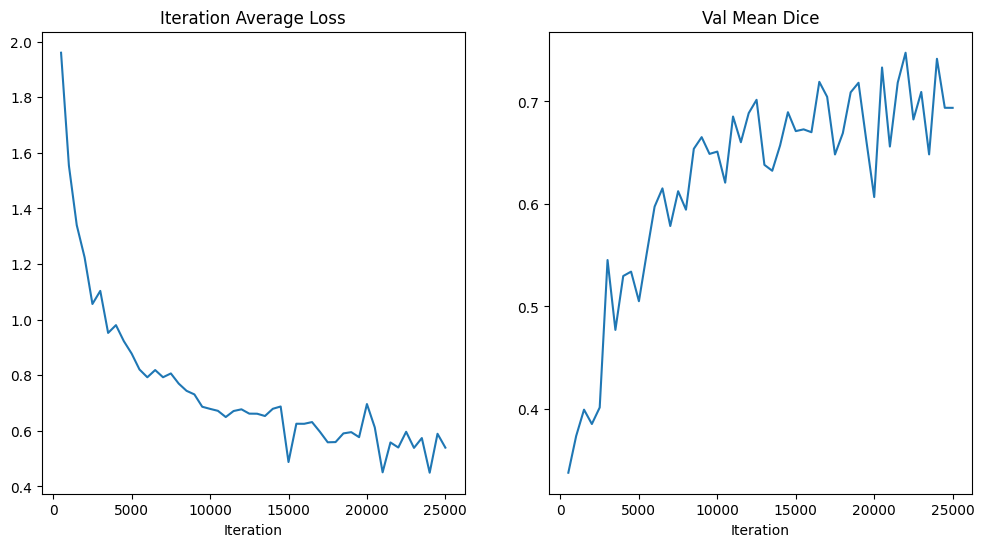

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
#Concat without ViT
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.98049): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.88445): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (71 / 25000 Steps) (loss=2.85814): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (95 / 25000 Steps) (loss=2.70377): 100%|█| 24/24 [00:12<00:00,  1.96it/
Training (119 / 25000 Steps) (loss=2.70275): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (143 / 25000 Steps) (loss=2.67560): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (167 / 25000 Steps) (loss=2.58737): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (191 / 25000 Steps) (loss=2.51372): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (215 / 25000 Steps) (loss=2.47334): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (239 / 25000 Steps) (loss=2.48273): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (263 / 25000 Steps) (loss=2.34836): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (287 / 25000 Steps) (loss=2.41723): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3549300730228424 Current Avg. Dice: 0.3549300730228424


Training (503 / 25000 Steps) (loss=2.07966): 100%|█| 24/24 [00:18<00:00,  1.33it
Training (527 / 25000 Steps) (loss=1.96998): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (551 / 25000 Steps) (loss=1.96898): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (575 / 25000 Steps) (loss=2.13291): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (599 / 25000 Steps) (loss=2.12768): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (623 / 25000 Steps) (loss=2.05057): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (647 / 25000 Steps) (loss=2.00657): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (671 / 25000 Steps) (loss=1.92554): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (695 / 25000 Steps) (loss=1.92043): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (719 / 25000 Steps) (loss=1.91083): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (743 / 25000 Steps) (loss=1.86068): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (767 / 25000 Steps) (loss=1.73798): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.3549300730228424 Current Avg. Dice: 0.3342519700527191


Training (1007 / 25000 Steps) (loss=1.73192): 100%|█| 24/24 [00:13<00:00,  1.73i
Training (1031 / 25000 Steps) (loss=1.54576): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1055 / 25000 Steps) (loss=1.53642): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1079 / 25000 Steps) (loss=1.63642): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1103 / 25000 Steps) (loss=1.84196): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1127 / 25000 Steps) (loss=1.53587): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1151 / 25000 Steps) (loss=1.43847): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1175 / 25000 Steps) (loss=1.55737): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1199 / 25000 Steps) (loss=1.38387): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1223 / 25000 Steps) (loss=1.38828): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1247 / 25000 Steps) (loss=1.37595): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1271 / 25000 Steps) (loss=1.39717): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3693774938583374 Current Avg. Dice: 0.3693774938583374


Training (1511 / 25000 Steps) (loss=1.19881): 100%|█| 24/24 [00:17<00:00,  1.37i
Training (1535 / 25000 Steps) (loss=1.34222): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1559 / 25000 Steps) (loss=1.26985): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1583 / 25000 Steps) (loss=1.26623): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1607 / 25000 Steps) (loss=1.27567): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1631 / 25000 Steps) (loss=1.24125): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1655 / 25000 Steps) (loss=1.20458): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1679 / 25000 Steps) (loss=1.27566): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1703 / 25000 Steps) (loss=1.16035): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1727 / 25000 Steps) (loss=1.26925): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1751 / 25000 Steps) (loss=1.37605): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1775 / 25000 Steps) (loss=1.21592): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4124353229999542 Current Avg. Dice: 0.4124353229999542


Training (2015 / 25000 Steps) (loss=1.15357): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (2039 / 25000 Steps) (loss=1.12523): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2063 / 25000 Steps) (loss=1.38956): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2087 / 25000 Steps) (loss=1.28349): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2111 / 25000 Steps) (loss=1.19703): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2135 / 25000 Steps) (loss=1.27363): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2159 / 25000 Steps) (loss=1.15641): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2183 / 25000 Steps) (loss=1.10114): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2207 / 25000 Steps) (loss=1.31824): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2231 / 25000 Steps) (loss=1.27156): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2255 / 25000 Steps) (loss=1.19958): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2279 / 25000 Steps) (loss=1.14066): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4124353229999542 Current Avg. Dice: 0.4095405638217926


Training (2519 / 25000 Steps) (loss=1.07753): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (2543 / 25000 Steps) (loss=1.13395): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2567 / 25000 Steps) (loss=1.50828): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2591 / 25000 Steps) (loss=1.12413): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2615 / 25000 Steps) (loss=1.11065): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2639 / 25000 Steps) (loss=1.82010): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2663 / 25000 Steps) (loss=1.13680): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2687 / 25000 Steps) (loss=1.20709): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2711 / 25000 Steps) (loss=1.16642): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2735 / 25000 Steps) (loss=1.12390): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2759 / 25000 Steps) (loss=0.97934): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2783 / 25000 Steps) (loss=1.14115): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5142349600791931 Current Avg. Dice: 0.5142349600791931


Training (3023 / 25000 Steps) (loss=1.08090): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (3047 / 25000 Steps) (loss=1.00500): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3071 / 25000 Steps) (loss=1.18095): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3095 / 25000 Steps) (loss=1.04719): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3119 / 25000 Steps) (loss=1.04958): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3143 / 25000 Steps) (loss=0.99867): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3167 / 25000 Steps) (loss=1.03519): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3191 / 25000 Steps) (loss=1.09980): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3215 / 25000 Steps) (loss=1.00110): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3239 / 25000 Steps) (loss=1.05067): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3263 / 25000 Steps) (loss=1.11036): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3287 / 25000 Steps) (loss=1.01629): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5142349600791931 Current Avg. Dice: 0.4909071922302246


Training (3503 / 25000 Steps) (loss=0.99224): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (3527 / 25000 Steps) (loss=1.01782): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3551 / 25000 Steps) (loss=1.08700): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3575 / 25000 Steps) (loss=0.96970): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3599 / 25000 Steps) (loss=0.97689): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3623 / 25000 Steps) (loss=1.01775): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3647 / 25000 Steps) (loss=0.99413): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3671 / 25000 Steps) (loss=1.10037): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3695 / 25000 Steps) (loss=1.00520): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3719 / 25000 Steps) (loss=1.44564): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3743 / 25000 Steps) (loss=0.96813): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3767 / 25000 Steps) (loss=0.97001): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5142349600791931 Current Avg. Dice: 0.5013745427131653


Training (4007 / 25000 Steps) (loss=0.94927): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (4031 / 25000 Steps) (loss=1.06627): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4055 / 25000 Steps) (loss=1.03728): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4079 / 25000 Steps) (loss=0.96048): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4103 / 25000 Steps) (loss=1.12665): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4127 / 25000 Steps) (loss=1.00716): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4151 / 25000 Steps) (loss=1.00967): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4175 / 25000 Steps) (loss=1.14419): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4199 / 25000 Steps) (loss=0.95347): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4223 / 25000 Steps) (loss=0.94987): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4247 / 25000 Steps) (loss=1.03945): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4271 / 25000 Steps) (loss=0.99005): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6019663214683533 Current Avg. Dice: 0.6019663214683533


Training (4511 / 25000 Steps) (loss=0.98554): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (4535 / 25000 Steps) (loss=0.98608): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4559 / 25000 Steps) (loss=0.90667): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4583 / 25000 Steps) (loss=0.95779): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4607 / 25000 Steps) (loss=0.88758): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4631 / 25000 Steps) (loss=0.89206): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4655 / 25000 Steps) (loss=1.01292): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4679 / 25000 Steps) (loss=1.07918): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4703 / 25000 Steps) (loss=1.07401): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4727 / 25000 Steps) (loss=0.92465): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4751 / 25000 Steps) (loss=0.94669): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4775 / 25000 Steps) (loss=1.18236): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6019663214683533 Current Avg. Dice: 0.5577813982963562


Training (5015 / 25000 Steps) (loss=0.85409): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (5039 / 25000 Steps) (loss=0.93427): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5063 / 25000 Steps) (loss=0.87692): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5087 / 25000 Steps) (loss=0.91190): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5111 / 25000 Steps) (loss=0.89468): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5135 / 25000 Steps) (loss=1.01955): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5159 / 25000 Steps) (loss=0.85198): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5183 / 25000 Steps) (loss=0.82078): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5207 / 25000 Steps) (loss=0.88769): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5231 / 25000 Steps) (loss=0.97575): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5255 / 25000 Steps) (loss=0.93727): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5279 / 25000 Steps) (loss=0.89077): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6451500058174133 Current Avg. Dice: 0.6451500058174133


Training (5519 / 25000 Steps) (loss=0.96130): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (5543 / 25000 Steps) (loss=0.95724): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5567 / 25000 Steps) (loss=0.87313): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5591 / 25000 Steps) (loss=0.82526): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5615 / 25000 Steps) (loss=0.96752): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5639 / 25000 Steps) (loss=1.01769): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5663 / 25000 Steps) (loss=0.86481): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5687 / 25000 Steps) (loss=0.97324): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5711 / 25000 Steps) (loss=0.94770): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5735 / 25000 Steps) (loss=0.79862): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5759 / 25000 Steps) (loss=0.81526): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5783 / 25000 Steps) (loss=0.98620): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6451500058174133 Current Avg. Dice: 0.5358952879905701


Training (6023 / 25000 Steps) (loss=0.78292): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (6047 / 25000 Steps) (loss=0.87301): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6071 / 25000 Steps) (loss=0.85445): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6095 / 25000 Steps) (loss=0.77641): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6119 / 25000 Steps) (loss=0.84171): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6143 / 25000 Steps) (loss=0.80802): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6167 / 25000 Steps) (loss=0.87205): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6191 / 25000 Steps) (loss=1.01943): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6215 / 25000 Steps) (loss=0.91206): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6239 / 25000 Steps) (loss=0.71368): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6263 / 25000 Steps) (loss=0.96848): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6287 / 25000 Steps) (loss=0.95437): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6451500058174133 Current Avg. Dice: 0.6035524010658264


Training (6503 / 25000 Steps) (loss=0.85564): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (6527 / 25000 Steps) (loss=0.83437): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6551 / 25000 Steps) (loss=0.84134): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6575 / 25000 Steps) (loss=1.03371): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6599 / 25000 Steps) (loss=0.82893): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6623 / 25000 Steps) (loss=0.81465): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6647 / 25000 Steps) (loss=0.97801): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6671 / 25000 Steps) (loss=0.91134): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6695 / 25000 Steps) (loss=0.80638): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6719 / 25000 Steps) (loss=0.85972): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6743 / 25000 Steps) (loss=0.71545): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6767 / 25000 Steps) (loss=0.81103): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6451500058174133 Current Avg. Dice: 0.59869384765625


Training (7007 / 25000 Steps) (loss=0.83635): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (7031 / 25000 Steps) (loss=0.85089): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7055 / 25000 Steps) (loss=0.89334): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7079 / 25000 Steps) (loss=0.92531): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7103 / 25000 Steps) (loss=0.77977): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7127 / 25000 Steps) (loss=0.86442): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7151 / 25000 Steps) (loss=0.85137): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7175 / 25000 Steps) (loss=0.89095): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7199 / 25000 Steps) (loss=0.85241): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7223 / 25000 Steps) (loss=0.94255): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7247 / 25000 Steps) (loss=0.78556): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7271 / 25000 Steps) (loss=0.93811): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6451500058174133 Current Avg. Dice: 0.6340675354003906


Training (7511 / 25000 Steps) (loss=0.83642): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (7535 / 25000 Steps) (loss=0.83742): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7559 / 25000 Steps) (loss=0.71762): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7583 / 25000 Steps) (loss=0.83621): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7607 / 25000 Steps) (loss=0.87489): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7631 / 25000 Steps) (loss=0.86688): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7655 / 25000 Steps) (loss=0.70425): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7679 / 25000 Steps) (loss=0.87192): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7703 / 25000 Steps) (loss=0.82876): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7727 / 25000 Steps) (loss=0.93949): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7751 / 25000 Steps) (loss=0.75618): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7775 / 25000 Steps) (loss=0.89224): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6451500058174133 Current Avg. Dice: 0.60394686460495


Training (8015 / 25000 Steps) (loss=0.64631): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8039 / 25000 Steps) (loss=0.65665): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8063 / 25000 Steps) (loss=0.79513): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8087 / 25000 Steps) (loss=0.95717): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8111 / 25000 Steps) (loss=0.95911): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8135 / 25000 Steps) (loss=0.85521): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8159 / 25000 Steps) (loss=0.68282): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8183 / 25000 Steps) (loss=0.65383): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8207 / 25000 Steps) (loss=1.12121): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8231 / 25000 Steps) (loss=0.78715): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8255 / 25000 Steps) (loss=0.69617): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8279 / 25000 Steps) (loss=0.91159): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7271530032157898 Current Avg. Dice: 0.7271530032157898


Training (8519 / 25000 Steps) (loss=0.79735): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (8543 / 25000 Steps) (loss=0.91174): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8567 / 25000 Steps) (loss=0.74665): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8591 / 25000 Steps) (loss=0.86597): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8615 / 25000 Steps) (loss=0.65447): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8639 / 25000 Steps) (loss=0.77697): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8663 / 25000 Steps) (loss=0.83012): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8687 / 25000 Steps) (loss=0.72292): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8711 / 25000 Steps) (loss=0.71247): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8735 / 25000 Steps) (loss=0.74145): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8759 / 25000 Steps) (loss=0.67915): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8783 / 25000 Steps) (loss=0.68424): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7271530032157898 Current Avg. Dice: 0.6382142901420593


Training (9023 / 25000 Steps) (loss=0.73640): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (9047 / 25000 Steps) (loss=0.82334): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9071 / 25000 Steps) (loss=1.15636): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9095 / 25000 Steps) (loss=0.65326): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9119 / 25000 Steps) (loss=0.75560): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9143 / 25000 Steps) (loss=0.70372): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9167 / 25000 Steps) (loss=0.84211): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9191 / 25000 Steps) (loss=0.79269): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9215 / 25000 Steps) (loss=0.63030): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9239 / 25000 Steps) (loss=0.79818): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9263 / 25000 Steps) (loss=0.68992): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9287 / 25000 Steps) (loss=0.68479): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7805400490760803


Training (9503 / 25000 Steps) (loss=0.77330): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (9527 / 25000 Steps) (loss=0.62852): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9551 / 25000 Steps) (loss=0.69326): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9575 / 25000 Steps) (loss=0.61032): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9599 / 25000 Steps) (loss=0.73722): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9623 / 25000 Steps) (loss=0.69967): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9647 / 25000 Steps) (loss=0.78293): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9671 / 25000 Steps) (loss=0.76572): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9695 / 25000 Steps) (loss=0.59328): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9719 / 25000 Steps) (loss=0.76420): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9743 / 25000 Steps) (loss=0.77866): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9767 / 25000 Steps) (loss=0.67760): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7366268634796143


Training (10007 / 25000 Steps) (loss=0.52282): 100%|█| 24/24 [00:13<00:00,  1.76
Training (10031 / 25000 Steps) (loss=0.56753): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10055 / 25000 Steps) (loss=0.77083): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10079 / 25000 Steps) (loss=0.68823): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10103 / 25000 Steps) (loss=0.50910): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10127 / 25000 Steps) (loss=0.73092): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10151 / 25000 Steps) (loss=0.74534): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10175 / 25000 Steps) (loss=0.66070): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10199 / 25000 Steps) (loss=0.81235): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10223 / 25000 Steps) (loss=0.65844): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10247 / 25000 Steps) (loss=0.87210): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10271 / 25000 Steps) (loss=0.85782): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.722499668598175


Training (10511 / 25000 Steps) (loss=0.77140): 100%|█| 24/24 [00:13<00:00,  1.76
Training (10535 / 25000 Steps) (loss=0.59394): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10559 / 25000 Steps) (loss=0.82954): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10583 / 25000 Steps) (loss=0.90993): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10607 / 25000 Steps) (loss=0.83154): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10631 / 25000 Steps) (loss=0.71429): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10655 / 25000 Steps) (loss=0.57363): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10679 / 25000 Steps) (loss=0.70040): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10703 / 25000 Steps) (loss=0.62633): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10727 / 25000 Steps) (loss=0.51216): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10751 / 25000 Steps) (loss=0.64283): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10775 / 25000 Steps) (loss=0.76161): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7796685695648193


Training (11015 / 25000 Steps) (loss=0.79731): 100%|█| 24/24 [00:13<00:00,  1.76
Training (11039 / 25000 Steps) (loss=0.59761): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11063 / 25000 Steps) (loss=0.72150): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11087 / 25000 Steps) (loss=0.69344): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11111 / 25000 Steps) (loss=0.59550): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11135 / 25000 Steps) (loss=0.47557): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11159 / 25000 Steps) (loss=0.65292): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11183 / 25000 Steps) (loss=0.78689): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11207 / 25000 Steps) (loss=0.65981): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11231 / 25000 Steps) (loss=0.46588): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11255 / 25000 Steps) (loss=0.76695): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11279 / 25000 Steps) (loss=0.73724): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.6703543663024902


Training (11519 / 25000 Steps) (loss=0.71418): 100%|█| 24/24 [00:13<00:00,  1.76
Training (11543 / 25000 Steps) (loss=0.60569): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11567 / 25000 Steps) (loss=0.59301): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11591 / 25000 Steps) (loss=0.74674): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11615 / 25000 Steps) (loss=1.02573): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11639 / 25000 Steps) (loss=0.57354): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11663 / 25000 Steps) (loss=0.73212): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11687 / 25000 Steps) (loss=0.67428): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11711 / 25000 Steps) (loss=0.80519): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11735 / 25000 Steps) (loss=0.90253): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11759 / 25000 Steps) (loss=0.71343): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11783 / 25000 Steps) (loss=0.62573): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7104472517967224


Training (12023 / 25000 Steps) (loss=0.60144): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12047 / 25000 Steps) (loss=1.06501): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12071 / 25000 Steps) (loss=0.57189): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12095 / 25000 Steps) (loss=0.75919): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12119 / 25000 Steps) (loss=0.69622): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12143 / 25000 Steps) (loss=0.68322): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12167 / 25000 Steps) (loss=0.78535): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12191 / 25000 Steps) (loss=0.54801): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12215 / 25000 Steps) (loss=0.68900): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12239 / 25000 Steps) (loss=0.56187): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12263 / 25000 Steps) (loss=0.75774): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12287 / 25000 Steps) (loss=0.61372): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.6730782389640808


Training (12503 / 25000 Steps) (loss=0.84145): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12527 / 25000 Steps) (loss=0.63591): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12551 / 25000 Steps) (loss=0.42405): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12575 / 25000 Steps) (loss=0.63738): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12599 / 25000 Steps) (loss=0.71219): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12623 / 25000 Steps) (loss=0.69364): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12647 / 25000 Steps) (loss=0.64856): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12671 / 25000 Steps) (loss=0.82500): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12695 / 25000 Steps) (loss=0.67264): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12719 / 25000 Steps) (loss=0.57861): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12743 / 25000 Steps) (loss=0.70038): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12767 / 25000 Steps) (loss=0.74681): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.6878160834312439


Training (13007 / 25000 Steps) (loss=0.84804): 100%|█| 24/24 [00:13<00:00,  1.76
Training (13031 / 25000 Steps) (loss=0.70615): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13055 / 25000 Steps) (loss=0.52151): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13079 / 25000 Steps) (loss=0.82043): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13103 / 25000 Steps) (loss=0.68936): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13127 / 25000 Steps) (loss=0.74726): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13151 / 25000 Steps) (loss=0.72170): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13175 / 25000 Steps) (loss=0.79283): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13199 / 25000 Steps) (loss=0.72148): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13223 / 25000 Steps) (loss=0.61567): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13247 / 25000 Steps) (loss=0.66753): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13271 / 25000 Steps) (loss=0.65662): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.6946786046028137


Training (13511 / 25000 Steps) (loss=0.73245): 100%|█| 24/24 [00:13<00:00,  1.76
Training (13535 / 25000 Steps) (loss=0.74856): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.81113): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13583 / 25000 Steps) (loss=0.68296): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13607 / 25000 Steps) (loss=0.64185): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13631 / 25000 Steps) (loss=0.76441): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13655 / 25000 Steps) (loss=0.68959): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13679 / 25000 Steps) (loss=0.55333): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13703 / 25000 Steps) (loss=0.56017): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13727 / 25000 Steps) (loss=0.72412): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13751 / 25000 Steps) (loss=0.66970): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13775 / 25000 Steps) (loss=0.79190): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.6581935286521912


Training (14015 / 25000 Steps) (loss=0.61441): 100%|█| 24/24 [00:13<00:00,  1.76
Training (14039 / 25000 Steps) (loss=0.66544): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14063 / 25000 Steps) (loss=0.67469): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14087 / 25000 Steps) (loss=0.56852): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14111 / 25000 Steps) (loss=0.68111): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14135 / 25000 Steps) (loss=0.48820): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14159 / 25000 Steps) (loss=0.45505): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14183 / 25000 Steps) (loss=0.67831): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14207 / 25000 Steps) (loss=0.81470): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14231 / 25000 Steps) (loss=0.52721): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14255 / 25000 Steps) (loss=0.62380): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14279 / 25000 Steps) (loss=0.63413): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.775234043598175


Training (14519 / 25000 Steps) (loss=0.73493): 100%|█| 24/24 [00:13<00:00,  1.76
Training (14543 / 25000 Steps) (loss=0.67138): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14567 / 25000 Steps) (loss=0.71310): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.65695): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14615 / 25000 Steps) (loss=0.79553): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14639 / 25000 Steps) (loss=0.67666): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14663 / 25000 Steps) (loss=0.61192): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14687 / 25000 Steps) (loss=0.81233): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14711 / 25000 Steps) (loss=0.69809): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14735 / 25000 Steps) (loss=0.84525): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14759 / 25000 Steps) (loss=0.73949): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14783 / 25000 Steps) (loss=0.56298): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7161327004432678


Training (15023 / 25000 Steps) (loss=0.75806): 100%|█| 24/24 [00:13<00:00,  1.76
Training (15047 / 25000 Steps) (loss=0.62511): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15071 / 25000 Steps) (loss=0.59142): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15095 / 25000 Steps) (loss=0.66225): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15119 / 25000 Steps) (loss=0.88028): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15143 / 25000 Steps) (loss=0.71704): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15167 / 25000 Steps) (loss=0.65481): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15191 / 25000 Steps) (loss=0.48888): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15215 / 25000 Steps) (loss=0.51989): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15239 / 25000 Steps) (loss=0.66451): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15263 / 25000 Steps) (loss=0.77684): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15287 / 25000 Steps) (loss=0.43778): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.699148952960968


Training (15503 / 25000 Steps) (loss=0.68093): 100%|█| 24/24 [00:13<00:00,  1.77
Training (15527 / 25000 Steps) (loss=0.66044): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15551 / 25000 Steps) (loss=0.80830): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15575 / 25000 Steps) (loss=0.70947): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15599 / 25000 Steps) (loss=0.52653): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15623 / 25000 Steps) (loss=0.48769): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15647 / 25000 Steps) (loss=0.78972): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15671 / 25000 Steps) (loss=0.59008): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15695 / 25000 Steps) (loss=0.72589): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15719 / 25000 Steps) (loss=0.75799): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15743 / 25000 Steps) (loss=0.45299): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15767 / 25000 Steps) (loss=0.73985): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7533085942268372


Training (16007 / 25000 Steps) (loss=0.41643): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16031 / 25000 Steps) (loss=0.69767): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16055 / 25000 Steps) (loss=0.48760): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16079 / 25000 Steps) (loss=0.65903): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16103 / 25000 Steps) (loss=0.62661): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16127 / 25000 Steps) (loss=0.60770): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16151 / 25000 Steps) (loss=0.72227): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16175 / 25000 Steps) (loss=0.64055): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16199 / 25000 Steps) (loss=0.54459): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16223 / 25000 Steps) (loss=0.51740): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16247 / 25000 Steps) (loss=0.73028): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16271 / 25000 Steps) (loss=0.57610): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7768570780754089


Training (16511 / 25000 Steps) (loss=0.61377): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16535 / 25000 Steps) (loss=0.65159): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16559 / 25000 Steps) (loss=0.64445): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16583 / 25000 Steps) (loss=0.70354): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16607 / 25000 Steps) (loss=0.82094): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16631 / 25000 Steps) (loss=0.63360): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16655 / 25000 Steps) (loss=0.52404): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16679 / 25000 Steps) (loss=0.66210): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16703 / 25000 Steps) (loss=0.73389): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16727 / 25000 Steps) (loss=0.69819): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16751 / 25000 Steps) (loss=0.68672): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16775 / 25000 Steps) (loss=0.75793): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7192522883415222


Training (17015 / 25000 Steps) (loss=0.95388): 100%|█| 24/24 [00:13<00:00,  1.77
Training (17039 / 25000 Steps) (loss=0.68006): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17063 / 25000 Steps) (loss=0.58805): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17087 / 25000 Steps) (loss=0.60955): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17111 / 25000 Steps) (loss=0.66265): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17135 / 25000 Steps) (loss=0.61688): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17159 / 25000 Steps) (loss=0.66045): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17183 / 25000 Steps) (loss=0.65212): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17207 / 25000 Steps) (loss=0.77327): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17231 / 25000 Steps) (loss=0.81510): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17255 / 25000 Steps) (loss=0.46846): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17279 / 25000 Steps) (loss=0.76672): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7315311431884766


Training (17519 / 25000 Steps) (loss=0.43436): 100%|█| 24/24 [00:13<00:00,  1.75
Training (17543 / 25000 Steps) (loss=0.64837): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17567 / 25000 Steps) (loss=0.70893): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17591 / 25000 Steps) (loss=0.60256): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17615 / 25000 Steps) (loss=0.74206): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17639 / 25000 Steps) (loss=0.63400): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17663 / 25000 Steps) (loss=0.72318): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17687 / 25000 Steps) (loss=0.56824): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17711 / 25000 Steps) (loss=0.45764): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17735 / 25000 Steps) (loss=0.58685): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17759 / 25000 Steps) (loss=0.50070): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17783 / 25000 Steps) (loss=0.40125): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7805400490760803 Current Avg. Dice: 0.7741835117340088


Training (18023 / 25000 Steps) (loss=0.52628): 100%|█| 24/24 [00:13<00:00,  1.75
Training (18047 / 25000 Steps) (loss=0.67233): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18071 / 25000 Steps) (loss=0.73940): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18095 / 25000 Steps) (loss=0.66551): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18119 / 25000 Steps) (loss=0.79529): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18143 / 25000 Steps) (loss=0.66117): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18167 / 25000 Steps) (loss=0.64225): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18191 / 25000 Steps) (loss=0.58578): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18215 / 25000 Steps) (loss=0.58224): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18239 / 25000 Steps) (loss=0.80494): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18263 / 25000 Steps) (loss=0.47667): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18287 / 25000 Steps) (loss=0.69507): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.8123928904533386


Training (18503 / 25000 Steps) (loss=0.53053): 100%|█| 24/24 [00:17<00:00,  1.39
Training (18527 / 25000 Steps) (loss=0.71711): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18551 / 25000 Steps) (loss=0.79334): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18575 / 25000 Steps) (loss=0.65408): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18599 / 25000 Steps) (loss=0.72262): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18623 / 25000 Steps) (loss=0.73956): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18647 / 25000 Steps) (loss=0.54743): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18671 / 25000 Steps) (loss=0.38808): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18695 / 25000 Steps) (loss=0.72128): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18719 / 25000 Steps) (loss=0.54875): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18743 / 25000 Steps) (loss=0.81834): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18767 / 25000 Steps) (loss=0.61789): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.6981657147407532


Training (19007 / 25000 Steps) (loss=0.68906): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19031 / 25000 Steps) (loss=0.58185): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19055 / 25000 Steps) (loss=0.94012): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19079 / 25000 Steps) (loss=0.44426): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19103 / 25000 Steps) (loss=0.66305): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19127 / 25000 Steps) (loss=0.63214): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19151 / 25000 Steps) (loss=0.77213): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19175 / 25000 Steps) (loss=0.68022): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19199 / 25000 Steps) (loss=0.42686): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19223 / 25000 Steps) (loss=0.56846): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19247 / 25000 Steps) (loss=0.67751): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19271 / 25000 Steps) (loss=0.50748): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7811904549598694


Training (19511 / 25000 Steps) (loss=0.38228): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19535 / 25000 Steps) (loss=0.62138): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19559 / 25000 Steps) (loss=0.64501): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19583 / 25000 Steps) (loss=0.60744): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19607 / 25000 Steps) (loss=0.63530): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19631 / 25000 Steps) (loss=0.51110): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19655 / 25000 Steps) (loss=0.76726): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19679 / 25000 Steps) (loss=0.67034): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19703 / 25000 Steps) (loss=0.40235): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19727 / 25000 Steps) (loss=0.47454): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19751 / 25000 Steps) (loss=0.76532): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19775 / 25000 Steps) (loss=0.65935): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.6651949882507324


Training (20015 / 25000 Steps) (loss=0.67951): 100%|█| 24/24 [00:13<00:00,  1.76
Training (20039 / 25000 Steps) (loss=0.60927): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20063 / 25000 Steps) (loss=0.63867): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20087 / 25000 Steps) (loss=0.65022): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20111 / 25000 Steps) (loss=0.67293): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20135 / 25000 Steps) (loss=0.51381): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20159 / 25000 Steps) (loss=0.80879): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20183 / 25000 Steps) (loss=0.78547): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20207 / 25000 Steps) (loss=0.75781): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20231 / 25000 Steps) (loss=0.63460): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20255 / 25000 Steps) (loss=0.49326): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20279 / 25000 Steps) (loss=0.64422): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.711287796497345


Training (20519 / 25000 Steps) (loss=0.43964): 100%|█| 24/24 [00:13<00:00,  1.76
Training (20543 / 25000 Steps) (loss=0.47224): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20567 / 25000 Steps) (loss=0.53785): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20591 / 25000 Steps) (loss=0.47745): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20615 / 25000 Steps) (loss=0.73015): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20639 / 25000 Steps) (loss=0.55172): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20663 / 25000 Steps) (loss=0.77560): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20687 / 25000 Steps) (loss=0.81800): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20711 / 25000 Steps) (loss=0.67783): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20735 / 25000 Steps) (loss=0.66969): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20759 / 25000 Steps) (loss=0.61378): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20783 / 25000 Steps) (loss=0.68425): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7085809111595154


Training (21023 / 25000 Steps) (loss=0.62863): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21047 / 25000 Steps) (loss=0.61953): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21071 / 25000 Steps) (loss=0.65437): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21095 / 25000 Steps) (loss=0.41759): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21119 / 25000 Steps) (loss=0.62928): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21143 / 25000 Steps) (loss=0.56600): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21167 / 25000 Steps) (loss=0.78446): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21191 / 25000 Steps) (loss=0.84739): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21215 / 25000 Steps) (loss=0.64204): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21239 / 25000 Steps) (loss=0.68457): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21263 / 25000 Steps) (loss=0.68552): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21287 / 25000 Steps) (loss=0.55289): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7216340899467468


Training (21503 / 25000 Steps) (loss=0.51657): 100%|█| 24/24 [00:13<00:00,  1.77
Training (21527 / 25000 Steps) (loss=0.52362): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21551 / 25000 Steps) (loss=0.46458): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21575 / 25000 Steps) (loss=0.69535): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21599 / 25000 Steps) (loss=0.68957): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21623 / 25000 Steps) (loss=0.61636): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21647 / 25000 Steps) (loss=0.71538): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21671 / 25000 Steps) (loss=0.48376): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21695 / 25000 Steps) (loss=0.42758): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21719 / 25000 Steps) (loss=0.63841): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21743 / 25000 Steps) (loss=0.56646): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21767 / 25000 Steps) (loss=0.79709): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7444076538085938


Training (22007 / 25000 Steps) (loss=0.58387): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22031 / 25000 Steps) (loss=0.44148): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22055 / 25000 Steps) (loss=0.64165): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22079 / 25000 Steps) (loss=0.64235): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22103 / 25000 Steps) (loss=0.60461): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22127 / 25000 Steps) (loss=0.47074): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22151 / 25000 Steps) (loss=0.61622): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22175 / 25000 Steps) (loss=0.48985): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22199 / 25000 Steps) (loss=0.66853): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22223 / 25000 Steps) (loss=0.56590): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22247 / 25000 Steps) (loss=0.53488): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22271 / 25000 Steps) (loss=0.60892): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7037929892539978


Training (22511 / 25000 Steps) (loss=0.70451): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22535 / 25000 Steps) (loss=0.55688): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22559 / 25000 Steps) (loss=0.54618): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22583 / 25000 Steps) (loss=0.56223): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22607 / 25000 Steps) (loss=0.42736): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22631 / 25000 Steps) (loss=0.64559): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22655 / 25000 Steps) (loss=0.64206): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22679 / 25000 Steps) (loss=0.60826): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22703 / 25000 Steps) (loss=0.44735): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22727 / 25000 Steps) (loss=0.70627): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22751 / 25000 Steps) (loss=0.79007): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22775 / 25000 Steps) (loss=0.51903): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.6821295619010925


Training (23015 / 25000 Steps) (loss=0.63280): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23039 / 25000 Steps) (loss=0.50199): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23063 / 25000 Steps) (loss=0.66282): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23087 / 25000 Steps) (loss=0.57888): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23111 / 25000 Steps) (loss=0.55229): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23135 / 25000 Steps) (loss=0.47672): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23159 / 25000 Steps) (loss=0.65426): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23183 / 25000 Steps) (loss=0.91601): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23207 / 25000 Steps) (loss=0.69391): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23231 / 25000 Steps) (loss=0.64022): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23255 / 25000 Steps) (loss=0.66351): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23279 / 25000 Steps) (loss=0.57405): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.6985662579536438


Training (23519 / 25000 Steps) (loss=0.66840): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23543 / 25000 Steps) (loss=0.64021): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23567 / 25000 Steps) (loss=0.70263): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23591 / 25000 Steps) (loss=0.64847): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23615 / 25000 Steps) (loss=0.45743): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23639 / 25000 Steps) (loss=0.76030): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23663 / 25000 Steps) (loss=0.61617): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23687 / 25000 Steps) (loss=0.71955): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23711 / 25000 Steps) (loss=0.45041): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23735 / 25000 Steps) (loss=0.48345): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23759 / 25000 Steps) (loss=0.62142): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23783 / 25000 Steps) (loss=0.55458): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7346009612083435


Training (24023 / 25000 Steps) (loss=0.68735): 100%|█| 24/24 [00:13<00:00,  1.76
Training (24047 / 25000 Steps) (loss=0.50655): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24071 / 25000 Steps) (loss=0.70747): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24095 / 25000 Steps) (loss=0.68034): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24119 / 25000 Steps) (loss=0.60970): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24143 / 25000 Steps) (loss=0.58848): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24167 / 25000 Steps) (loss=0.83466): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24191 / 25000 Steps) (loss=0.94093): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24215 / 25000 Steps) (loss=0.63277): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24239 / 25000 Steps) (loss=0.68268): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24263 / 25000 Steps) (loss=0.54696): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24287 / 25000 Steps) (loss=0.64500): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.7140922546386719


Training (24503 / 25000 Steps) (loss=0.56913): 100%|█| 24/24 [00:13<00:00,  1.76
Training (24527 / 25000 Steps) (loss=0.50634): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24551 / 25000 Steps) (loss=0.69277): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24575 / 25000 Steps) (loss=0.50610): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24599 / 25000 Steps) (loss=0.54593): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24623 / 25000 Steps) (loss=0.50674): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24647 / 25000 Steps) (loss=0.53556): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24671 / 25000 Steps) (loss=0.61741): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24695 / 25000 Steps) (loss=0.58721): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24719 / 25000 Steps) (loss=0.50545): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24743 / 25000 Steps) (loss=0.45638): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24767 / 25000 Steps) (loss=0.50746): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8123928904533386 Current Avg. Dice: 0.710699737071991


Training (25007 / 25000 Steps) (loss=0.62915): 100%|█| 24/24 [00:13<00:00,  1.76


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8124 at iteration: 18500


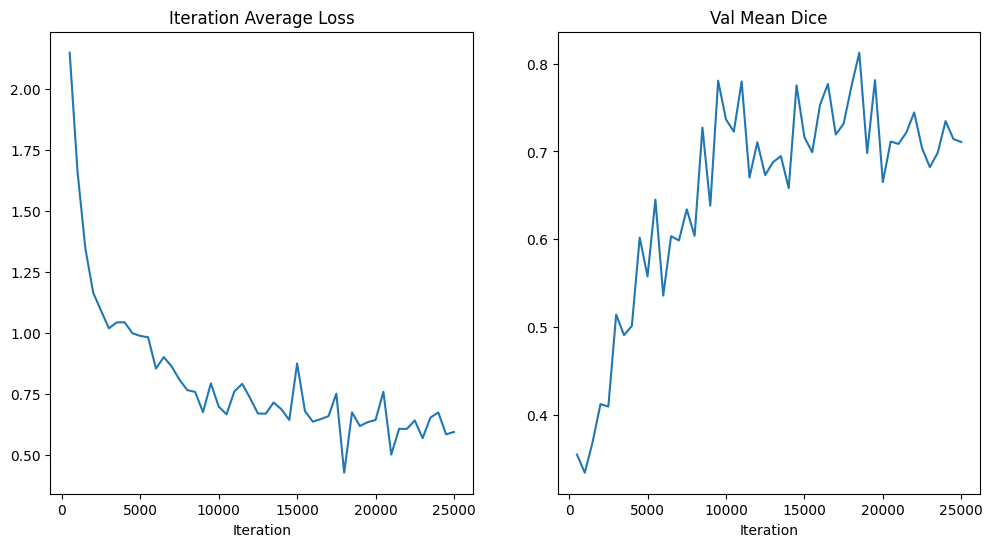

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [7]:
#test
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_test1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_test1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.81187): 100%|█| 24/24 [00:14<00:00,  1.67it/
Training (47 / 25000 Steps) (loss=2.53717): 100%|█| 24/24 [00:12<00:00,  1.95it/
Training (71 / 25000 Steps) (loss=2.54913): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (95 / 25000 Steps) (loss=2.54394): 100%|█| 24/24 [00:12<00:00,  1.96it/
Training (119 / 25000 Steps) (loss=2.39030): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (143 / 25000 Steps) (loss=2.47951): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (167 / 25000 Steps) (loss=2.33193): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (191 / 25000 Steps) (loss=2.37161): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (215 / 25000 Steps) (loss=2.41816): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (239 / 25000 Steps) (loss=2.40144): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (263 / 25000 Steps) (loss=2.30482): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (287 / 25000 Steps) (loss=2.17088): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.47951292991638184 Current Avg. Dice: 0.47951292991638184


Training (503 / 25000 Steps) (loss=1.91113): 100%|█| 24/24 [00:17<00:00,  1.36it
Training (527 / 25000 Steps) (loss=2.00220): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (551 / 25000 Steps) (loss=1.85826): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (575 / 25000 Steps) (loss=1.87051): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (599 / 25000 Steps) (loss=1.71707): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (623 / 25000 Steps) (loss=1.77465): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (647 / 25000 Steps) (loss=1.76148): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (671 / 25000 Steps) (loss=1.78126): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (695 / 25000 Steps) (loss=1.61960): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (719 / 25000 Steps) (loss=1.67062): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (743 / 25000 Steps) (loss=1.53528): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (767 / 25000 Steps) (loss=1.80212): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.47951292991638184 Current Avg. Dice: 0.31273069977760315


Training (1007 / 25000 Steps) (loss=1.62375): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (1031 / 25000 Steps) (loss=1.54975): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1055 / 25000 Steps) (loss=1.36217): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1079 / 25000 Steps) (loss=1.47889): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1103 / 25000 Steps) (loss=1.45428): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1127 / 25000 Steps) (loss=1.40305): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1151 / 25000 Steps) (loss=1.22687): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1175 / 25000 Steps) (loss=1.56489): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1199 / 25000 Steps) (loss=1.62266): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1223 / 25000 Steps) (loss=1.16237): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1247 / 25000 Steps) (loss=1.24612): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1271 / 25000 Steps) (loss=1.47432): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.47951292991638184 Current Avg. Dice: 0.42222830653190613


Training (1511 / 25000 Steps) (loss=1.36115): 100%|█| 24/24 [00:14<00:00,  1.71i
Training (1535 / 25000 Steps) (loss=1.20184): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1559 / 25000 Steps) (loss=1.24077): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1583 / 25000 Steps) (loss=1.29537): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1607 / 25000 Steps) (loss=1.19216): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1631 / 25000 Steps) (loss=1.23251): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1655 / 25000 Steps) (loss=1.30917): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1679 / 25000 Steps) (loss=1.18150): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1703 / 25000 Steps) (loss=1.35469): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1727 / 25000 Steps) (loss=1.22673): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1751 / 25000 Steps) (loss=1.12806): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1775 / 25000 Steps) (loss=1.17201): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.47951292991638184 Current Avg. Dice: 0.3878338634967804


Training (2015 / 25000 Steps) (loss=1.24796): 100%|█| 24/24 [00:13<00:00,  1.72i
Training (2039 / 25000 Steps) (loss=1.03057): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2063 / 25000 Steps) (loss=1.17202): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2087 / 25000 Steps) (loss=1.08557): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2111 / 25000 Steps) (loss=1.11266): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2135 / 25000 Steps) (loss=1.19258): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2159 / 25000 Steps) (loss=1.29001): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2183 / 25000 Steps) (loss=1.15333): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2207 / 25000 Steps) (loss=1.23432): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2231 / 25000 Steps) (loss=1.05680): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2255 / 25000 Steps) (loss=1.25053): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2279 / 25000 Steps) (loss=1.15538): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5112625360488892 Current Avg. Dice: 0.5112625360488892


Training (2519 / 25000 Steps) (loss=1.08677): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (2543 / 25000 Steps) (loss=1.09094): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2567 / 25000 Steps) (loss=1.07015): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2591 / 25000 Steps) (loss=1.08506): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2615 / 25000 Steps) (loss=1.06423): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2639 / 25000 Steps) (loss=1.10853): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2663 / 25000 Steps) (loss=1.00381): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2687 / 25000 Steps) (loss=1.10964): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2711 / 25000 Steps) (loss=1.03475): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2735 / 25000 Steps) (loss=1.05876): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2759 / 25000 Steps) (loss=1.10164): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2783 / 25000 Steps) (loss=1.05737): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5112625360488892 Current Avg. Dice: 0.472099632024765


Training (3023 / 25000 Steps) (loss=1.03889): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (3047 / 25000 Steps) (loss=0.92417): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (3071 / 25000 Steps) (loss=1.07304): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3095 / 25000 Steps) (loss=0.98376): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3119 / 25000 Steps) (loss=1.19991): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3143 / 25000 Steps) (loss=1.07723): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3167 / 25000 Steps) (loss=1.18217): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3191 / 25000 Steps) (loss=0.97840): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3215 / 25000 Steps) (loss=0.93889): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3239 / 25000 Steps) (loss=0.96973): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3263 / 25000 Steps) (loss=1.14647): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3287 / 25000 Steps) (loss=0.95905): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5112625360488892 Current Avg. Dice: 0.4948926270008087


Training (3503 / 25000 Steps) (loss=0.97546): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (3527 / 25000 Steps) (loss=1.12559): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3551 / 25000 Steps) (loss=1.01406): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (3575 / 25000 Steps) (loss=0.93501): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3599 / 25000 Steps) (loss=1.09783): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3623 / 25000 Steps) (loss=1.01544): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3647 / 25000 Steps) (loss=0.95608): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3671 / 25000 Steps) (loss=1.04921): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3695 / 25000 Steps) (loss=1.05069): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3719 / 25000 Steps) (loss=1.19326): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3743 / 25000 Steps) (loss=1.18018): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3767 / 25000 Steps) (loss=1.12151): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5353184342384338 Current Avg. Dice: 0.5353184342384338


Training (4007 / 25000 Steps) (loss=0.89118): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (4031 / 25000 Steps) (loss=0.97925): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4055 / 25000 Steps) (loss=0.93270): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (4079 / 25000 Steps) (loss=1.01704): 100%|█| 24/24 [00:12<00:00,  1.92i
Training (4103 / 25000 Steps) (loss=0.96834): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4127 / 25000 Steps) (loss=1.33589): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4151 / 25000 Steps) (loss=0.92192): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4175 / 25000 Steps) (loss=0.96805): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (4199 / 25000 Steps) (loss=0.84857): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4223 / 25000 Steps) (loss=1.05254): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (4247 / 25000 Steps) (loss=1.00979): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4271 / 25000 Steps) (loss=0.95125): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5552937388420105 Current Avg. Dice: 0.5552937388420105


Training (4511 / 25000 Steps) (loss=0.96644): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (4535 / 25000 Steps) (loss=1.11418): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4559 / 25000 Steps) (loss=0.84471): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4583 / 25000 Steps) (loss=0.95548): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4607 / 25000 Steps) (loss=0.91540): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4631 / 25000 Steps) (loss=0.91696): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4655 / 25000 Steps) (loss=0.96458): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (4679 / 25000 Steps) (loss=0.88680): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (4703 / 25000 Steps) (loss=0.91930): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4727 / 25000 Steps) (loss=1.14246): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4751 / 25000 Steps) (loss=1.08799): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4775 / 25000 Steps) (loss=1.00343): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5552937388420105 Current Avg. Dice: 0.5214831829071045


Training (5015 / 25000 Steps) (loss=0.93394): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (5039 / 25000 Steps) (loss=0.84113): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5063 / 25000 Steps) (loss=0.92978): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5087 / 25000 Steps) (loss=0.97694): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5111 / 25000 Steps) (loss=0.84612): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5135 / 25000 Steps) (loss=0.97970): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5159 / 25000 Steps) (loss=0.85704): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5183 / 25000 Steps) (loss=0.79844): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (5207 / 25000 Steps) (loss=0.88824): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5231 / 25000 Steps) (loss=0.92676): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (5255 / 25000 Steps) (loss=0.87051): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5279 / 25000 Steps) (loss=0.89679): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5693521499633789 Current Avg. Dice: 0.5693521499633789


Training (5519 / 25000 Steps) (loss=0.98125): 100%|█| 24/24 [00:17<00:00,  1.37i
Training (5543 / 25000 Steps) (loss=0.81455): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (5567 / 25000 Steps) (loss=0.92741): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5591 / 25000 Steps) (loss=0.85839): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5615 / 25000 Steps) (loss=0.86645): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5639 / 25000 Steps) (loss=0.79219): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5663 / 25000 Steps) (loss=0.82404): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5687 / 25000 Steps) (loss=1.31694): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5711 / 25000 Steps) (loss=0.89341): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5735 / 25000 Steps) (loss=0.96638): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5759 / 25000 Steps) (loss=0.94708): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5783 / 25000 Steps) (loss=0.86532): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5693521499633789 Current Avg. Dice: 0.5314236283302307


Training (6023 / 25000 Steps) (loss=0.79188): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (6047 / 25000 Steps) (loss=0.85987): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6071 / 25000 Steps) (loss=0.90162): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6095 / 25000 Steps) (loss=0.88443): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6119 / 25000 Steps) (loss=0.83187): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6143 / 25000 Steps) (loss=0.85855): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6167 / 25000 Steps) (loss=0.87365): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6191 / 25000 Steps) (loss=0.82310): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6215 / 25000 Steps) (loss=0.87327): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6239 / 25000 Steps) (loss=0.86441): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6263 / 25000 Steps) (loss=0.79160): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6287 / 25000 Steps) (loss=0.80647): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5693521499633789 Current Avg. Dice: 0.5571918487548828


Training (6503 / 25000 Steps) (loss=0.83914): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (6527 / 25000 Steps) (loss=0.84269): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6551 / 25000 Steps) (loss=0.85490): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6575 / 25000 Steps) (loss=0.82344): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6599 / 25000 Steps) (loss=0.79772): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6623 / 25000 Steps) (loss=0.85033): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6647 / 25000 Steps) (loss=0.87460): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6671 / 25000 Steps) (loss=0.82932): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6695 / 25000 Steps) (loss=0.75403): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6719 / 25000 Steps) (loss=0.84336): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6743 / 25000 Steps) (loss=0.79008): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6767 / 25000 Steps) (loss=0.89502): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6097691655158997 Current Avg. Dice: 0.6097691655158997


Training (7007 / 25000 Steps) (loss=0.93874): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (7031 / 25000 Steps) (loss=0.81589): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7055 / 25000 Steps) (loss=0.86288): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7079 / 25000 Steps) (loss=0.83558): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7103 / 25000 Steps) (loss=0.77278): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7127 / 25000 Steps) (loss=0.87167): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7151 / 25000 Steps) (loss=0.80046): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7175 / 25000 Steps) (loss=0.72825): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7199 / 25000 Steps) (loss=0.96749): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7223 / 25000 Steps) (loss=0.99324): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7247 / 25000 Steps) (loss=0.79968): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7271 / 25000 Steps) (loss=0.96103): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6907089352607727 Current Avg. Dice: 0.6907089352607727


Training (7511 / 25000 Steps) (loss=0.78066): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (7535 / 25000 Steps) (loss=0.82424): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7559 / 25000 Steps) (loss=0.88846): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7583 / 25000 Steps) (loss=0.77452): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7607 / 25000 Steps) (loss=0.83788): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7631 / 25000 Steps) (loss=0.80489): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7655 / 25000 Steps) (loss=0.83833): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7679 / 25000 Steps) (loss=0.63768): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7703 / 25000 Steps) (loss=0.78478): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7727 / 25000 Steps) (loss=0.81133): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7751 / 25000 Steps) (loss=1.21793): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7775 / 25000 Steps) (loss=0.81448): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6907089352607727 Current Avg. Dice: 0.6375194191932678


Training (8015 / 25000 Steps) (loss=0.69150): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (8039 / 25000 Steps) (loss=0.66849): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8063 / 25000 Steps) (loss=0.80329): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8087 / 25000 Steps) (loss=0.87448): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8111 / 25000 Steps) (loss=0.80643): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8135 / 25000 Steps) (loss=0.63479): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8159 / 25000 Steps) (loss=0.93689): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8183 / 25000 Steps) (loss=0.70811): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8207 / 25000 Steps) (loss=0.85549): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8231 / 25000 Steps) (loss=0.72724): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8255 / 25000 Steps) (loss=0.77102): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8279 / 25000 Steps) (loss=0.83799): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.710214376449585


Training (8519 / 25000 Steps) (loss=0.80102): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (8543 / 25000 Steps) (loss=0.87458): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8567 / 25000 Steps) (loss=0.77228): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8591 / 25000 Steps) (loss=0.82007): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8615 / 25000 Steps) (loss=1.07911): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8639 / 25000 Steps) (loss=0.73576): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8663 / 25000 Steps) (loss=0.79106): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8687 / 25000 Steps) (loss=0.85219): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8711 / 25000 Steps) (loss=0.78986): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8735 / 25000 Steps) (loss=0.85587): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8759 / 25000 Steps) (loss=0.79362): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8783 / 25000 Steps) (loss=0.82073): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6650541424751282


Training (9023 / 25000 Steps) (loss=0.70473): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (9047 / 25000 Steps) (loss=0.63913): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9071 / 25000 Steps) (loss=0.71696): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9095 / 25000 Steps) (loss=0.91060): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9119 / 25000 Steps) (loss=0.69724): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9143 / 25000 Steps) (loss=0.82108): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9167 / 25000 Steps) (loss=0.87069): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9191 / 25000 Steps) (loss=0.80800): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9215 / 25000 Steps) (loss=0.78306): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9239 / 25000 Steps) (loss=0.78040): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9263 / 25000 Steps) (loss=0.74248): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9287 / 25000 Steps) (loss=0.78766): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6813972592353821


Training (9503 / 25000 Steps) (loss=0.86148): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (9527 / 25000 Steps) (loss=0.70679): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9551 / 25000 Steps) (loss=0.82317): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9575 / 25000 Steps) (loss=0.66815): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9599 / 25000 Steps) (loss=0.68243): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9623 / 25000 Steps) (loss=0.87540): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9647 / 25000 Steps) (loss=0.92330): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9671 / 25000 Steps) (loss=0.79137): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9695 / 25000 Steps) (loss=0.93350): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9719 / 25000 Steps) (loss=0.77922): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9743 / 25000 Steps) (loss=0.81021): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9767 / 25000 Steps) (loss=0.77315): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6260536313056946


Training (10007 / 25000 Steps) (loss=0.75308): 100%|█| 24/24 [00:13<00:00,  1.74
Training (10031 / 25000 Steps) (loss=0.77798): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10055 / 25000 Steps) (loss=0.60021): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10079 / 25000 Steps) (loss=0.79515): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10103 / 25000 Steps) (loss=0.59887): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10127 / 25000 Steps) (loss=0.78247): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10151 / 25000 Steps) (loss=0.65194): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10175 / 25000 Steps) (loss=0.70221): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10199 / 25000 Steps) (loss=0.50651): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10223 / 25000 Steps) (loss=0.64947): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10247 / 25000 Steps) (loss=0.74565): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10271 / 25000 Steps) (loss=0.70898): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.7018453478813171


Training (10511 / 25000 Steps) (loss=0.47720): 100%|█| 24/24 [00:13<00:00,  1.72
Training (10535 / 25000 Steps) (loss=0.85151): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10559 / 25000 Steps) (loss=0.58969): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10583 / 25000 Steps) (loss=0.91317): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10607 / 25000 Steps) (loss=0.63007): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10631 / 25000 Steps) (loss=0.48421): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10655 / 25000 Steps) (loss=0.57417): 100%|█| 24/24 [00:12<00:00,  1.94
Training (10679 / 25000 Steps) (loss=0.80864): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10703 / 25000 Steps) (loss=0.83612): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10727 / 25000 Steps) (loss=0.80171): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10751 / 25000 Steps) (loss=0.60757): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10775 / 25000 Steps) (loss=0.68524): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6734235882759094


Training (11015 / 25000 Steps) (loss=1.09633): 100%|█| 24/24 [00:13<00:00,  1.76
Training (11039 / 25000 Steps) (loss=0.61778): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11063 / 25000 Steps) (loss=0.65186): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11087 / 25000 Steps) (loss=0.94730): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11111 / 25000 Steps) (loss=0.50844): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11135 / 25000 Steps) (loss=0.78383): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11159 / 25000 Steps) (loss=0.54724): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11183 / 25000 Steps) (loss=0.70668): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11207 / 25000 Steps) (loss=0.70963): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11231 / 25000 Steps) (loss=0.68351): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11255 / 25000 Steps) (loss=0.46872): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11279 / 25000 Steps) (loss=0.68255): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6646186709403992


Training (11519 / 25000 Steps) (loss=0.79799): 100%|█| 24/24 [00:13<00:00,  1.77
Training (11543 / 25000 Steps) (loss=0.71819): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11567 / 25000 Steps) (loss=0.71365): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11591 / 25000 Steps) (loss=0.64521): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11615 / 25000 Steps) (loss=0.51966): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11639 / 25000 Steps) (loss=0.83730): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11663 / 25000 Steps) (loss=0.74017): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11687 / 25000 Steps) (loss=0.73659): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11711 / 25000 Steps) (loss=0.61895): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11735 / 25000 Steps) (loss=0.67516): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11759 / 25000 Steps) (loss=0.74947): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11783 / 25000 Steps) (loss=0.60470): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.637152910232544


Training (12023 / 25000 Steps) (loss=0.49590): 100%|█| 24/24 [00:13<00:00,  1.76
Training (12047 / 25000 Steps) (loss=0.78940): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12071 / 25000 Steps) (loss=0.73849): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12095 / 25000 Steps) (loss=0.57612): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12119 / 25000 Steps) (loss=0.83347): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12143 / 25000 Steps) (loss=0.72736): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12167 / 25000 Steps) (loss=0.66663): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12191 / 25000 Steps) (loss=0.73727): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12215 / 25000 Steps) (loss=0.77118): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12239 / 25000 Steps) (loss=0.63750): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12263 / 25000 Steps) (loss=0.78006): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12287 / 25000 Steps) (loss=0.54374): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6801696419715881


Training (12503 / 25000 Steps) (loss=0.86332): 100%|█| 24/24 [00:13<00:00,  1.75
Training (12527 / 25000 Steps) (loss=0.62925): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12551 / 25000 Steps) (loss=0.71175): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12575 / 25000 Steps) (loss=0.77819): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12599 / 25000 Steps) (loss=0.74341): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12623 / 25000 Steps) (loss=1.07301): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12647 / 25000 Steps) (loss=0.54589): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12671 / 25000 Steps) (loss=0.84148): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12695 / 25000 Steps) (loss=0.55583): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12719 / 25000 Steps) (loss=0.70807): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12743 / 25000 Steps) (loss=0.74802): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12767 / 25000 Steps) (loss=0.57135): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.710214376449585 Current Avg. Dice: 0.6592113971710205


Training (13007 / 25000 Steps) (loss=0.71065): 100%|█| 24/24 [00:13<00:00,  1.76
Training (13031 / 25000 Steps) (loss=0.55952): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13055 / 25000 Steps) (loss=0.61812): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13079 / 25000 Steps) (loss=0.72148): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13103 / 25000 Steps) (loss=0.79906): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13127 / 25000 Steps) (loss=0.83093): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13151 / 25000 Steps) (loss=0.69541): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13175 / 25000 Steps) (loss=0.59772): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13199 / 25000 Steps) (loss=0.82774): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13223 / 25000 Steps) (loss=0.79294): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13247 / 25000 Steps) (loss=0.73636): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13271 / 25000 Steps) (loss=1.15846): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7205074429512024 Current Avg. Dice: 0.7205074429512024


Training (13511 / 25000 Steps) (loss=0.69109): 100%|█| 24/24 [00:17<00:00,  1.40
Training (13535 / 25000 Steps) (loss=0.77113): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.69627): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13583 / 25000 Steps) (loss=0.53929): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13607 / 25000 Steps) (loss=0.61656): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13631 / 25000 Steps) (loss=0.68119): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13655 / 25000 Steps) (loss=0.84519): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13679 / 25000 Steps) (loss=0.52804): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13703 / 25000 Steps) (loss=0.84141): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13727 / 25000 Steps) (loss=0.68606): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13751 / 25000 Steps) (loss=0.69461): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13775 / 25000 Steps) (loss=0.80381): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7205074429512024 Current Avg. Dice: 0.6935091018676758


Training (14015 / 25000 Steps) (loss=0.69166): 100%|█| 24/24 [00:13<00:00,  1.76
Training (14039 / 25000 Steps) (loss=0.76754): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14063 / 25000 Steps) (loss=0.57327): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14087 / 25000 Steps) (loss=0.60610): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14111 / 25000 Steps) (loss=0.63590): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.74180): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14159 / 25000 Steps) (loss=0.76224): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14183 / 25000 Steps) (loss=0.70562): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14207 / 25000 Steps) (loss=0.65063): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14231 / 25000 Steps) (loss=0.71855): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14255 / 25000 Steps) (loss=0.69074): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14279 / 25000 Steps) (loss=0.80014): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7458834648132324 Current Avg. Dice: 0.7458834648132324


Training (14519 / 25000 Steps) (loss=0.63630): 100%|█| 24/24 [00:17<00:00,  1.40
Training (14543 / 25000 Steps) (loss=0.65653): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14567 / 25000 Steps) (loss=0.50075): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.70542): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14615 / 25000 Steps) (loss=0.59864): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14639 / 25000 Steps) (loss=0.72225): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14663 / 25000 Steps) (loss=0.64027): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14687 / 25000 Steps) (loss=0.65282): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14711 / 25000 Steps) (loss=0.65094): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14735 / 25000 Steps) (loss=0.78359): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14759 / 25000 Steps) (loss=0.70192): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14783 / 25000 Steps) (loss=0.96682): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7458834648132324 Current Avg. Dice: 0.6547389626502991


Training (15023 / 25000 Steps) (loss=0.93923): 100%|█| 24/24 [00:13<00:00,  1.75
Training (15047 / 25000 Steps) (loss=0.83525): 100%|█| 24/24 [00:12<00:00,  1.93
Training (15071 / 25000 Steps) (loss=0.71061): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15095 / 25000 Steps) (loss=0.70492): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15119 / 25000 Steps) (loss=0.72139): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15143 / 25000 Steps) (loss=0.67833): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15167 / 25000 Steps) (loss=0.67599): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15191 / 25000 Steps) (loss=0.66888): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15215 / 25000 Steps) (loss=0.66509): 100%|█| 24/24 [00:12<00:00,  1.94
Training (15239 / 25000 Steps) (loss=0.67410): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15263 / 25000 Steps) (loss=1.06896): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15287 / 25000 Steps) (loss=0.80176): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7458834648132324 Current Avg. Dice: 0.676582396030426


Training (15503 / 25000 Steps) (loss=0.55656): 100%|█| 24/24 [00:13<00:00,  1.75
Training (15527 / 25000 Steps) (loss=0.65534): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15551 / 25000 Steps) (loss=0.61676): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15575 / 25000 Steps) (loss=0.68444): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15599 / 25000 Steps) (loss=0.64843): 100%|█| 24/24 [00:12<00:00,  1.94
Training (15623 / 25000 Steps) (loss=0.58619): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15647 / 25000 Steps) (loss=0.44662): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15671 / 25000 Steps) (loss=0.62536): 100%|█| 24/24 [00:12<00:00,  1.93
Training (15695 / 25000 Steps) (loss=0.71604): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15719 / 25000 Steps) (loss=0.53944): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15743 / 25000 Steps) (loss=0.66466): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15767 / 25000 Steps) (loss=0.63467): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7458834648132324 Current Avg. Dice: 0.6893870234489441


Training (16007 / 25000 Steps) (loss=0.65079): 100%|█| 24/24 [00:13<00:00,  1.74
Training (16031 / 25000 Steps) (loss=0.62746): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16055 / 25000 Steps) (loss=0.58858): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16079 / 25000 Steps) (loss=0.54120): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16103 / 25000 Steps) (loss=0.85579): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16127 / 25000 Steps) (loss=0.87716): 100%|█| 24/24 [00:12<00:00,  1.94
Training (16151 / 25000 Steps) (loss=0.81095): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16175 / 25000 Steps) (loss=0.50381): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16199 / 25000 Steps) (loss=0.56034): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16223 / 25000 Steps) (loss=0.72842): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16247 / 25000 Steps) (loss=0.84480): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16271 / 25000 Steps) (loss=0.65104): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7458834648132324 Current Avg. Dice: 0.6877906322479248


Training (16511 / 25000 Steps) (loss=0.86837): 100%|█| 24/24 [00:13<00:00,  1.74
Training (16535 / 25000 Steps) (loss=0.78345): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16559 / 25000 Steps) (loss=0.51988): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16583 / 25000 Steps) (loss=0.53229): 100%|█| 24/24 [00:12<00:00,  1.94
Training (16607 / 25000 Steps) (loss=0.62921): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16631 / 25000 Steps) (loss=0.72974): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16655 / 25000 Steps) (loss=0.66620): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16679 / 25000 Steps) (loss=0.54447): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16703 / 25000 Steps) (loss=0.59673): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16727 / 25000 Steps) (loss=0.73054): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16751 / 25000 Steps) (loss=0.52988): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16775 / 25000 Steps) (loss=0.67452): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7458834648132324 Current Avg. Dice: 0.6773441433906555


Training (17015 / 25000 Steps) (loss=0.36961): 100%|█| 24/24 [00:13<00:00,  1.76
Training (17039 / 25000 Steps) (loss=0.68426): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17063 / 25000 Steps) (loss=0.71695): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17087 / 25000 Steps) (loss=0.72108): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17111 / 25000 Steps) (loss=0.61851): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17135 / 25000 Steps) (loss=0.64121): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17159 / 25000 Steps) (loss=0.65768): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17183 / 25000 Steps) (loss=0.73211): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17207 / 25000 Steps) (loss=0.63504): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17231 / 25000 Steps) (loss=0.65478): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17255 / 25000 Steps) (loss=0.68474): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17279 / 25000 Steps) (loss=0.63997): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7569325566291809


Training (17519 / 25000 Steps) (loss=0.59256): 100%|█| 24/24 [00:17<00:00,  1.39
Training (17543 / 25000 Steps) (loss=0.60963): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17567 / 25000 Steps) (loss=0.58249): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17591 / 25000 Steps) (loss=0.88263): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17615 / 25000 Steps) (loss=0.54598): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17639 / 25000 Steps) (loss=0.63287): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17663 / 25000 Steps) (loss=0.64345): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17687 / 25000 Steps) (loss=0.74505): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17711 / 25000 Steps) (loss=0.59452): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17735 / 25000 Steps) (loss=0.78569): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17759 / 25000 Steps) (loss=0.68085): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17783 / 25000 Steps) (loss=0.50567): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.752031147480011


Training (18023 / 25000 Steps) (loss=0.71210): 100%|█| 24/24 [00:13<00:00,  1.76
Training (18047 / 25000 Steps) (loss=0.71244): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18071 / 25000 Steps) (loss=0.54214): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18095 / 25000 Steps) (loss=0.65769): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18119 / 25000 Steps) (loss=0.56496): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18143 / 25000 Steps) (loss=0.68542): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18167 / 25000 Steps) (loss=0.45673): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18191 / 25000 Steps) (loss=0.73189): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18215 / 25000 Steps) (loss=0.55902): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18239 / 25000 Steps) (loss=0.78964): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18263 / 25000 Steps) (loss=0.69187): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18287 / 25000 Steps) (loss=0.53941): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7188490033149719


Training (18503 / 25000 Steps) (loss=0.45311): 100%|█| 24/24 [00:13<00:00,  1.76
Training (18527 / 25000 Steps) (loss=0.69283): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18551 / 25000 Steps) (loss=0.66404): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18575 / 25000 Steps) (loss=0.69746): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18599 / 25000 Steps) (loss=0.79790): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18623 / 25000 Steps) (loss=0.54950): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18647 / 25000 Steps) (loss=0.73439): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18671 / 25000 Steps) (loss=0.77198): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18695 / 25000 Steps) (loss=0.79383): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18719 / 25000 Steps) (loss=0.69256): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18743 / 25000 Steps) (loss=0.63976): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18767 / 25000 Steps) (loss=0.55250): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.6944937705993652


Training (19007 / 25000 Steps) (loss=0.59498): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19031 / 25000 Steps) (loss=0.80420): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19055 / 25000 Steps) (loss=0.67289): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19079 / 25000 Steps) (loss=0.84584): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19103 / 25000 Steps) (loss=0.68221): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19127 / 25000 Steps) (loss=0.39866): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19151 / 25000 Steps) (loss=0.62488): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19175 / 25000 Steps) (loss=0.74574): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19199 / 25000 Steps) (loss=0.71626): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19223 / 25000 Steps) (loss=0.56829): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19247 / 25000 Steps) (loss=0.60329): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19271 / 25000 Steps) (loss=0.63925): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.659349262714386


Training (19511 / 25000 Steps) (loss=0.70376): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19535 / 25000 Steps) (loss=0.59434): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19559 / 25000 Steps) (loss=0.74018): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19583 / 25000 Steps) (loss=0.73473): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19607 / 25000 Steps) (loss=0.60491): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19631 / 25000 Steps) (loss=0.71679): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19655 / 25000 Steps) (loss=0.72544): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19679 / 25000 Steps) (loss=0.74396): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19703 / 25000 Steps) (loss=0.67153): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19727 / 25000 Steps) (loss=0.74349): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19751 / 25000 Steps) (loss=0.78217): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19775 / 25000 Steps) (loss=0.77311): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.6751044392585754


Training (20015 / 25000 Steps) (loss=0.64613): 100%|█| 24/24 [00:13<00:00,  1.76
Training (20039 / 25000 Steps) (loss=0.70180): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20063 / 25000 Steps) (loss=0.72663): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20087 / 25000 Steps) (loss=0.59310): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20111 / 25000 Steps) (loss=0.62550): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20135 / 25000 Steps) (loss=0.73732): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20159 / 25000 Steps) (loss=0.64260): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20183 / 25000 Steps) (loss=0.73604): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20207 / 25000 Steps) (loss=0.65384): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20231 / 25000 Steps) (loss=0.46390): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20255 / 25000 Steps) (loss=0.60035): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20279 / 25000 Steps) (loss=0.49667): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.629874050617218


Training (20519 / 25000 Steps) (loss=0.81121): 100%|█| 24/24 [00:13<00:00,  1.77
Training (20543 / 25000 Steps) (loss=0.60739): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20567 / 25000 Steps) (loss=0.85928): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20591 / 25000 Steps) (loss=0.64818): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20615 / 25000 Steps) (loss=0.44172): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20639 / 25000 Steps) (loss=0.72614): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20663 / 25000 Steps) (loss=0.83004): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20687 / 25000 Steps) (loss=0.55363): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20711 / 25000 Steps) (loss=0.51886): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20735 / 25000 Steps) (loss=0.53242): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20759 / 25000 Steps) (loss=0.65095): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20783 / 25000 Steps) (loss=0.73009): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7460924983024597


Training (21023 / 25000 Steps) (loss=0.61553): 100%|█| 24/24 [00:13<00:00,  1.75
Training (21047 / 25000 Steps) (loss=0.81740): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21071 / 25000 Steps) (loss=0.72707): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21095 / 25000 Steps) (loss=0.65669): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21119 / 25000 Steps) (loss=0.61114): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21143 / 25000 Steps) (loss=0.53745): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21167 / 25000 Steps) (loss=0.57446): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21191 / 25000 Steps) (loss=0.69676): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21215 / 25000 Steps) (loss=0.59073): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21239 / 25000 Steps) (loss=0.77529): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21263 / 25000 Steps) (loss=0.52811): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21287 / 25000 Steps) (loss=0.69721): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7318490147590637


Training (21503 / 25000 Steps) (loss=0.68618): 100%|█| 24/24 [00:13<00:00,  1.75
Training (21527 / 25000 Steps) (loss=0.62900): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21551 / 25000 Steps) (loss=0.78539): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21575 / 25000 Steps) (loss=0.52583): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21599 / 25000 Steps) (loss=0.67304): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21623 / 25000 Steps) (loss=0.65781): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21647 / 25000 Steps) (loss=0.67519): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21671 / 25000 Steps) (loss=0.56679): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21695 / 25000 Steps) (loss=0.60330): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21719 / 25000 Steps) (loss=0.58773): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21743 / 25000 Steps) (loss=0.62271): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21767 / 25000 Steps) (loss=0.75364): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7142775058746338


Training (22007 / 25000 Steps) (loss=0.55034): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22031 / 25000 Steps) (loss=0.73886): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22055 / 25000 Steps) (loss=0.53201): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22079 / 25000 Steps) (loss=0.59853): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22103 / 25000 Steps) (loss=0.71004): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22127 / 25000 Steps) (loss=0.55676): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22151 / 25000 Steps) (loss=0.68591): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22175 / 25000 Steps) (loss=0.44708): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22199 / 25000 Steps) (loss=0.50441): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22223 / 25000 Steps) (loss=0.79753): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22247 / 25000 Steps) (loss=0.57826): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22271 / 25000 Steps) (loss=0.75613): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.6734729409217834


Training (22511 / 25000 Steps) (loss=0.81117): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22535 / 25000 Steps) (loss=0.51363): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22559 / 25000 Steps) (loss=0.72558): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22583 / 25000 Steps) (loss=0.73117): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22607 / 25000 Steps) (loss=0.67412): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22631 / 25000 Steps) (loss=0.45371): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22655 / 25000 Steps) (loss=0.76770): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22679 / 25000 Steps) (loss=0.59721): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22703 / 25000 Steps) (loss=0.59018): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22727 / 25000 Steps) (loss=0.57434): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22751 / 25000 Steps) (loss=0.78294): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22775 / 25000 Steps) (loss=0.59167): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7239513993263245


Training (23015 / 25000 Steps) (loss=0.58035): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23039 / 25000 Steps) (loss=0.38498): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23063 / 25000 Steps) (loss=0.70777): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23087 / 25000 Steps) (loss=0.65120): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23111 / 25000 Steps) (loss=0.62145): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23135 / 25000 Steps) (loss=0.84230): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23159 / 25000 Steps) (loss=0.61744): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23183 / 25000 Steps) (loss=0.53415): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23207 / 25000 Steps) (loss=0.39664): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23231 / 25000 Steps) (loss=0.73844): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23255 / 25000 Steps) (loss=0.41723): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23279 / 25000 Steps) (loss=0.67548): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.678702175617218


Training (23519 / 25000 Steps) (loss=0.74293): 100%|█| 24/24 [00:13<00:00,  1.77
Training (23543 / 25000 Steps) (loss=0.71893): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23567 / 25000 Steps) (loss=0.67723): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23591 / 25000 Steps) (loss=0.69378): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23615 / 25000 Steps) (loss=0.67140): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23639 / 25000 Steps) (loss=0.61856): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23663 / 25000 Steps) (loss=0.58856): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23687 / 25000 Steps) (loss=0.61194): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23711 / 25000 Steps) (loss=0.69348): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23735 / 25000 Steps) (loss=0.71292): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23759 / 25000 Steps) (loss=0.59141): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23783 / 25000 Steps) (loss=0.62541): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7452554702758789


Training (24023 / 25000 Steps) (loss=0.68648): 100%|█| 24/24 [00:13<00:00,  1.76
Training (24047 / 25000 Steps) (loss=0.60148): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24071 / 25000 Steps) (loss=0.63072): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24095 / 25000 Steps) (loss=0.70569): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24119 / 25000 Steps) (loss=0.71985): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24143 / 25000 Steps) (loss=0.78830): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24167 / 25000 Steps) (loss=0.58299): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24191 / 25000 Steps) (loss=0.62313): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24215 / 25000 Steps) (loss=0.60581): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24239 / 25000 Steps) (loss=0.51718): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24263 / 25000 Steps) (loss=0.63025): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24287 / 25000 Steps) (loss=0.63648): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7221638560295105


Training (24503 / 25000 Steps) (loss=0.40482): 100%|█| 24/24 [00:13<00:00,  1.76
Training (24527 / 25000 Steps) (loss=0.69606): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24551 / 25000 Steps) (loss=0.62794): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24575 / 25000 Steps) (loss=0.76665): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24599 / 25000 Steps) (loss=0.50777): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24623 / 25000 Steps) (loss=0.57904): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24647 / 25000 Steps) (loss=0.84414): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24671 / 25000 Steps) (loss=0.59425): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24695 / 25000 Steps) (loss=0.67018): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24719 / 25000 Steps) (loss=0.66838): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24743 / 25000 Steps) (loss=0.62764): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24767 / 25000 Steps) (loss=0.78086): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7569325566291809 Current Avg. Dice: 0.7013335227966309


Training (25007 / 25000 Steps) (loss=0.67297): 100%|█| 24/24 [00:13<00:00,  1.74


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7569 at iteration: 17500


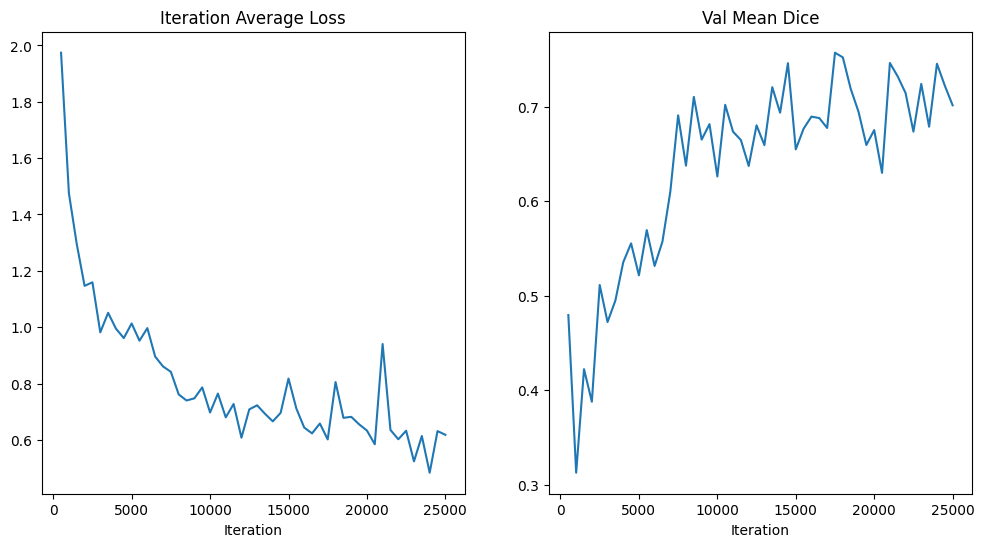

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [18]:
#inference MMH
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [20]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [21]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=57, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
# set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 57/57 [00:18<00:00,  3.12it/s]


In [10]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:12<00:00,  4.65it/s]

dice_val: 0.2666066586971283


In [11]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.34900960326194763


In [12]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.02it/s]

dice_val: 0.31487661600112915


In [13]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.4232094883918762


In [14]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.95it/s]

dice_val: 0.3234732747077942


In [ ]:
#inference MMH up down flip

In [23]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503_updown_flip/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors

Loading dataset: 100%|██████████████████████████| 57/57 [00:19<00:00,  2.93it/s]


In [24]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.91it/s]

dice_val: 0.2643609642982483


In [25]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.07it/s]

dice_val: 0.30316197872161865


In [26]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.32531973719596863


In [27]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.16it/s]

dice_val: 0.3863683342933655


In [28]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.08it/s]

dice_val: 0.3078237771987915
